In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)

        # input: 110      
        self.fc1 = nn.Linear(in_features=110, out_features=256)    
        self.fc2 = nn.Linear(in_features=266, out_features=784)

        self.sig = nn.Sigmoid()

    def forward(self, x, num):
        one_hot = F.one_hot(num,num_classes=10)
        x = torch.cat((torch.squeeze(x,dim=1),torch.squeeze(one_hot,dim=1)),1)
        x = self.fc1(x) #110->128
        x = self.act(x) #128->128
        x = torch.cat((torch.squeeze(x,dim=1),torch.squeeze(one_hot,dim=1)),1)
        x = self.fc2(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)

        # input: 794     
        self.fc1 = nn.Linear(in_features=794, out_features=256) 
        self.fc2 = nn.Linear(in_features=266, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x, num):
        one_hot = F.one_hot(num,num_classes=10)
        one_hot = torch.zeros_like(one_hot).to(device)
        x = torch.cat((x,torch.squeeze(one_hot,dim=1)),1)
        x = self.fc1(x) #794->128
        x = self.act(x) #128->128
        x = torch.cat((x,torch.squeeze(one_hot,dim=1)),1)
        x = self.fc2(x) #128->1
        x = self.sig(x) #1->1
        return x
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

In [3]:
print(F.one_hot(torch.tensor(9),num_classes=10))

one = F.one_hot(torch.tensor(9),num_classes=10)
tow = F.one_hot(torch.tensor(1),num_classes=10)
print(torch.cat((one,tow)))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


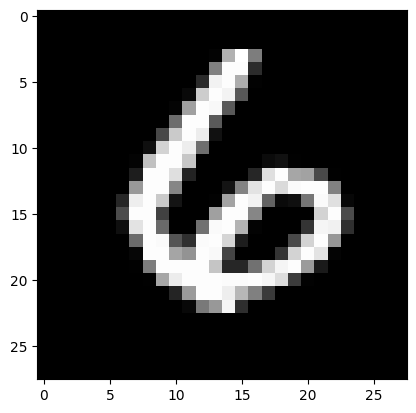

In [4]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [5]:
def train_models(model_d, criterion_d, optimizer_d, model_g, criterion_g, optimizer_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images, labels = next(it)
            except:
                it = iter(train_loader)
                images, labels = next(it)          
            labels = labels.to(device)
            images = images.to(device)
            out_real = model_d(torch.flatten(images,start_dim=1).to(device),labels)
            out_fake = model_d(model_g(torch.randn(out_real.shape[0],100).to(device),labels),labels)
            optimizer_d.zero_grad()
            loss_d = criterion_d(out_real,out_fake).to(device)
            loss_d.backward()
            optimizer_d.step()

        #Train Generator
        labels=torch.randint(0,10,(batch_sz,1)).to(device)
        out_fake = model_d(model_g(torch.randn(batch_sz,100).to(device),labels),labels)
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake).to(device)
        loss_g.backward()
        optimizer_g.step()
        
        
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            l = torch.randint(0,10,(3,1)).to(device)
            disp = model_g(torch.randn(3,100).to(device),l)
            print("Ploting: ", l[0][0].item())
            plot_digit(torch.reshape(disp[0,:],(28,28)).detach().cpu())
            print("Ploting: ", l[1][0].item())
            plot_digit(torch.reshape(disp[1,:],(28,28)).detach().cpu())
            print("Ploting: ", l[2][0].item())
            plot_digit(torch.reshape(disp[2,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 0.6661394834518433 	loss_d: 1.3940410614013672
Ploting:  0


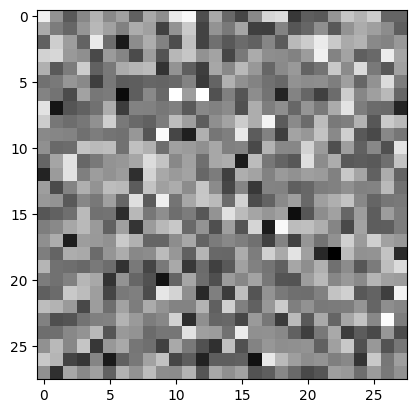

Ploting:  6


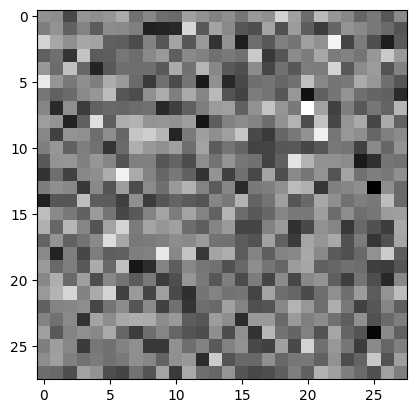

Ploting:  1


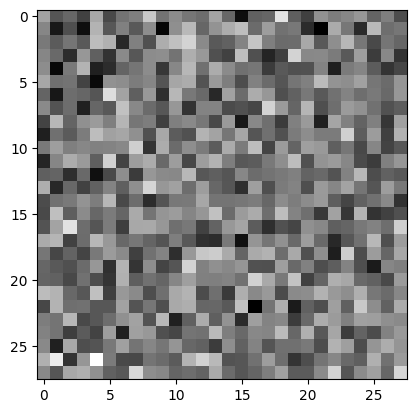

Epoch: 50
loss_g: 0.7430890202522278 	loss_d: 1.3283824920654297
Epoch: 100
loss_g: 0.8180858492851257 	loss_d: 1.2616894245147705
Epoch: 150
loss_g: 0.8872188329696655 	loss_d: 1.214439868927002
Epoch: 200
loss_g: 0.955298125743866 	loss_d: 1.1682450771331787
Epoch: 250
loss_g: 1.020084023475647 	loss_d: 1.1372566223144531
Epoch: 300
loss_g: 1.0825892686843872 	loss_d: 1.100620150566101
Epoch: 350
loss_g: 1.1404879093170166 	loss_d: 1.0634956359863281
Epoch: 400
loss_g: 1.1975948810577393 	loss_d: 1.03495454788208
Epoch: 450
loss_g: 1.25272536277771 	loss_d: 1.0080299377441406
Epoch: 500
loss_g: 1.3062204122543335 	loss_d: 0.9846696257591248
Ploting:  3


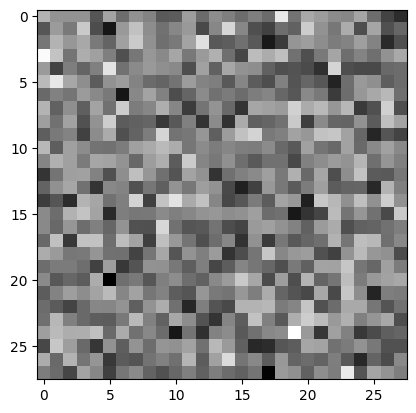

Ploting:  5


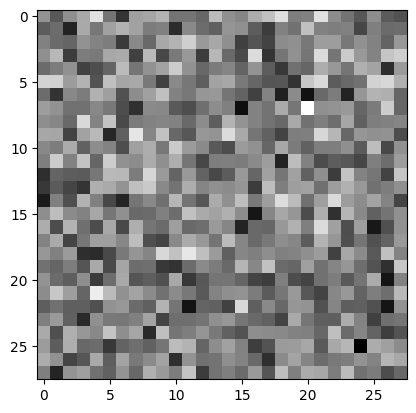

Ploting:  6


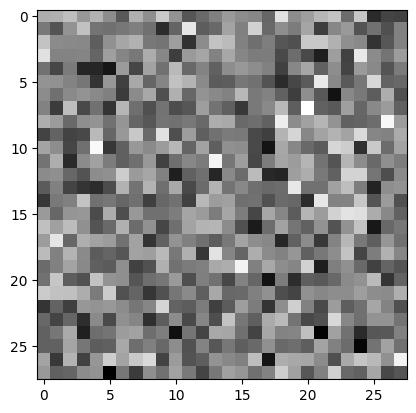

Epoch: 550
loss_g: 1.3550177812576294 	loss_d: 0.9570375084877014
Epoch: 600
loss_g: 1.4049415588378906 	loss_d: 0.9312744140625
Epoch: 650
loss_g: 1.4543349742889404 	loss_d: 0.9086789488792419
Epoch: 700
loss_g: 1.499505639076233 	loss_d: 0.8876562118530273
Epoch: 750
loss_g: 1.543735146522522 	loss_d: 0.8654107451438904
Epoch: 800
loss_g: 1.5854073762893677 	loss_d: 0.8497647047042847
Epoch: 850
loss_g: 1.6270065307617188 	loss_d: 0.832362174987793
Epoch: 900
loss_g: 1.6677350997924805 	loss_d: 0.8086681962013245
Epoch: 950
loss_g: 1.7083089351654053 	loss_d: 0.7850685119628906
Epoch: 1000
loss_g: 1.746777892112732 	loss_d: 0.7656184434890747
Ploting:  8


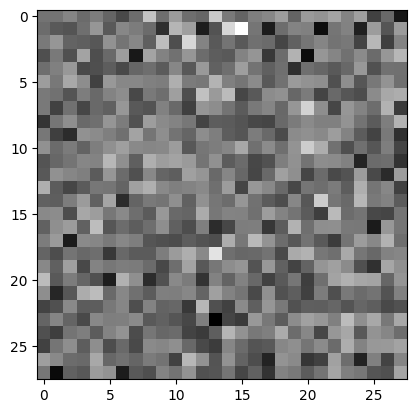

Ploting:  4


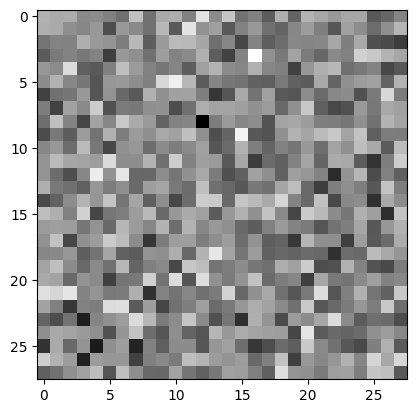

Ploting:  2


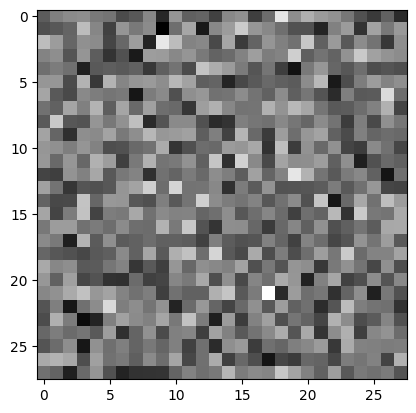

Epoch: 1050
loss_g: 1.785178542137146 	loss_d: 0.7477502226829529
Epoch: 1100
loss_g: 1.819216251373291 	loss_d: 0.7354006767272949
Epoch: 1150
loss_g: 1.8551058769226074 	loss_d: 0.7118816375732422
Epoch: 1200
loss_g: 1.8903535604476929 	loss_d: 0.7002655863761902
Epoch: 1250
loss_g: 1.9212409257888794 	loss_d: 0.6882234215736389
Epoch: 1300
loss_g: 1.9579105377197266 	loss_d: 0.6618798971176147
Epoch: 1350
loss_g: 1.9875843524932861 	loss_d: 0.6463130116462708
Epoch: 1400
loss_g: 2.017261028289795 	loss_d: 0.6286543607711792
Epoch: 1450
loss_g: 2.0535144805908203 	loss_d: 0.6171404123306274
Epoch: 1500
loss_g: 2.0887601375579834 	loss_d: 0.5973820090293884
Ploting:  3


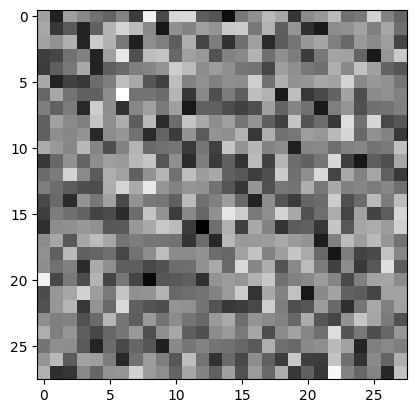

Ploting:  5


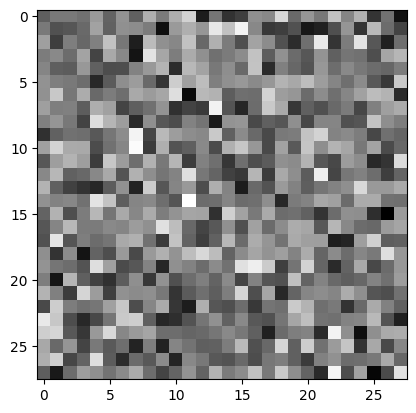

Ploting:  9


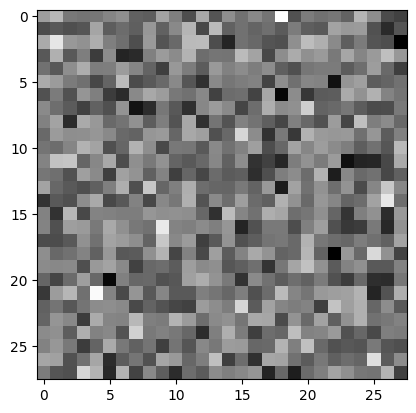

Epoch: 1550
loss_g: 2.114046335220337 	loss_d: 0.5910425186157227
Epoch: 1600
loss_g: 2.1439528465270996 	loss_d: 0.5685628652572632
Epoch: 1650
loss_g: 2.1770846843719482 	loss_d: 0.5485262870788574
Epoch: 1700
loss_g: 2.203850030899048 	loss_d: 0.5436583161354065
Epoch: 1750
loss_g: 2.232919692993164 	loss_d: 0.5298541188240051
Epoch: 1800
loss_g: 2.261932611465454 	loss_d: 0.5195028781890869
Epoch: 1850
loss_g: 2.292332410812378 	loss_d: 0.504381537437439
Epoch: 1900
loss_g: 2.3221065998077393 	loss_d: 0.4863201081752777
Epoch: 1950
loss_g: 2.347829818725586 	loss_d: 0.47940731048583984
Epoch: 2000
loss_g: 2.376667022705078 	loss_d: 0.4564550817012787
Ploting:  8


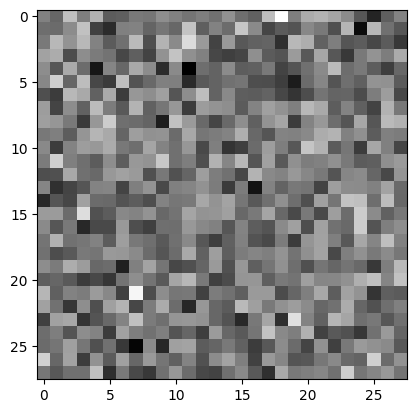

Ploting:  9


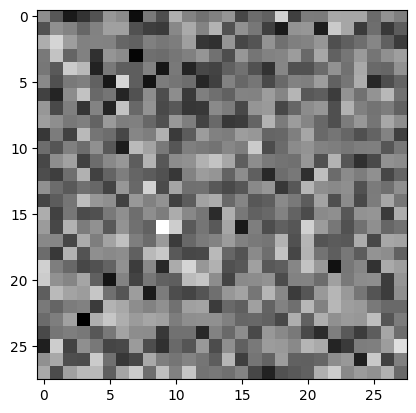

Ploting:  3


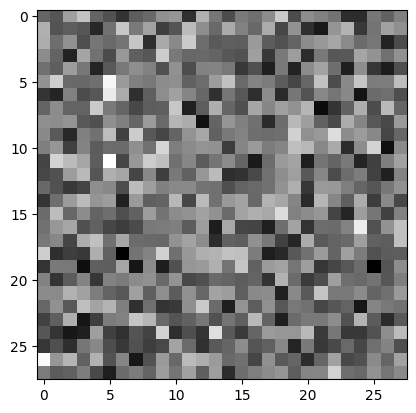

Epoch: 2050
loss_g: 2.403494119644165 	loss_d: 0.4454156756401062
Epoch: 2100
loss_g: 2.431917905807495 	loss_d: 0.4585913121700287
Epoch: 2150
loss_g: 2.4597301483154297 	loss_d: 0.41867339611053467
Epoch: 2200
loss_g: 2.4870359897613525 	loss_d: 0.41841569542884827
Epoch: 2250
loss_g: 2.51173996925354 	loss_d: 0.40577346086502075
Epoch: 2300
loss_g: 2.5353362560272217 	loss_d: 0.4070299565792084
Epoch: 2350
loss_g: 2.564103841781616 	loss_d: 0.389149010181427
Epoch: 2400
loss_g: 2.5870137214660645 	loss_d: 0.3718875050544739
Epoch: 2450
loss_g: 2.6144633293151855 	loss_d: 0.35138094425201416
Epoch: 2500
loss_g: 2.6387953758239746 	loss_d: 0.3644596040248871
Ploting:  8


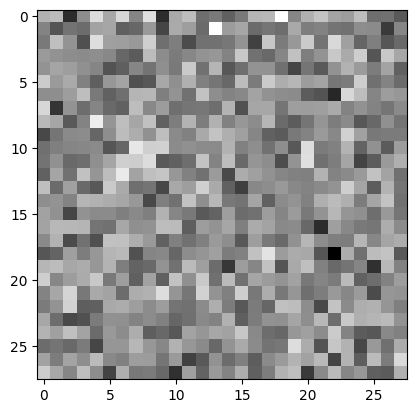

Ploting:  8


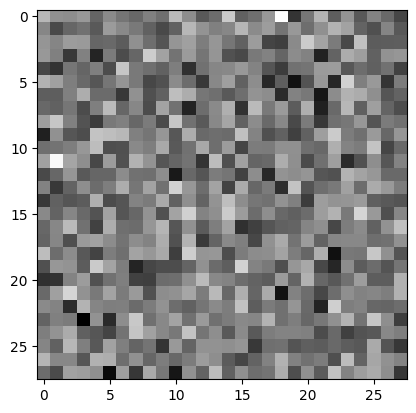

Ploting:  6


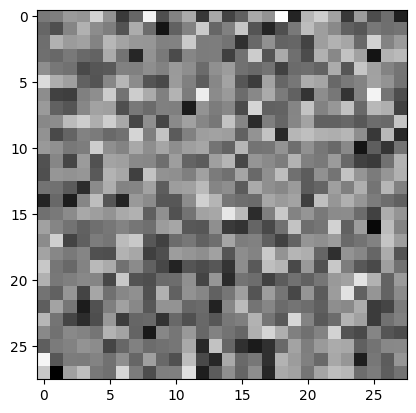

Epoch: 2550
loss_g: 2.6627845764160156 	loss_d: 0.34961044788360596
Epoch: 2600
loss_g: 2.689000129699707 	loss_d: 0.3402310013771057
Epoch: 2650
loss_g: 2.7139415740966797 	loss_d: 0.33517494797706604
Epoch: 2700
loss_g: 2.7365355491638184 	loss_d: 0.32321807742118835
Epoch: 2750
loss_g: 2.759087562561035 	loss_d: 0.311522901058197
Epoch: 2800
loss_g: 2.784088134765625 	loss_d: 0.32189738750457764
Epoch: 2850
loss_g: 2.805185556411743 	loss_d: 0.29948097467422485
Epoch: 2900
loss_g: 2.835482120513916 	loss_d: 0.29684269428253174
Epoch: 2950
loss_g: 2.8553664684295654 	loss_d: 0.28592491149902344
Epoch: 3000
loss_g: 2.88275146484375 	loss_d: 0.2838720679283142
Ploting:  3


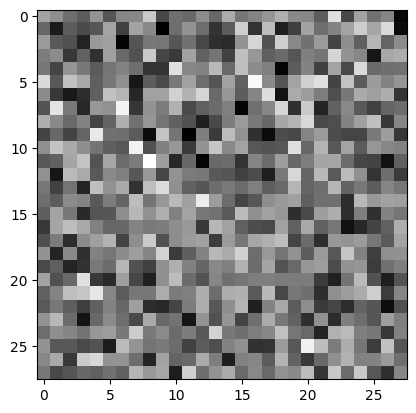

Ploting:  5


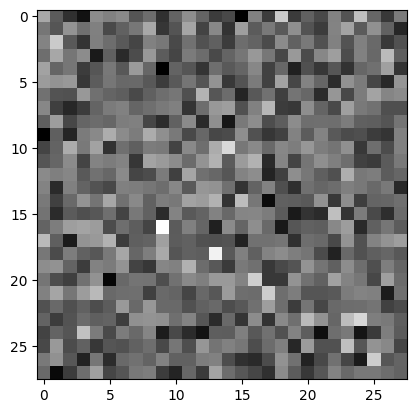

Ploting:  8


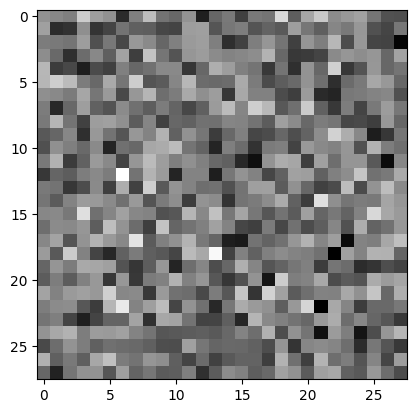

Epoch: 3050
loss_g: 2.900174379348755 	loss_d: 0.27893349528312683
Epoch: 3100
loss_g: 2.9227986335754395 	loss_d: 0.27049705386161804
Epoch: 3150
loss_g: 2.9465532302856445 	loss_d: 0.2626703679561615
Epoch: 3200
loss_g: 2.967728853225708 	loss_d: 0.26287218928337097
Epoch: 3250
loss_g: 2.9858837127685547 	loss_d: 0.26018720865249634
Epoch: 3300
loss_g: 3.010606050491333 	loss_d: 0.24180705845355988
Epoch: 3350
loss_g: 3.031235933303833 	loss_d: 0.23175111413002014
Epoch: 3400
loss_g: 3.0545501708984375 	loss_d: 0.23508842289447784
Epoch: 3450
loss_g: 3.0791125297546387 	loss_d: 0.2291783094406128
Epoch: 3500
loss_g: 3.0887563228607178 	loss_d: 0.22382164001464844
Ploting:  0


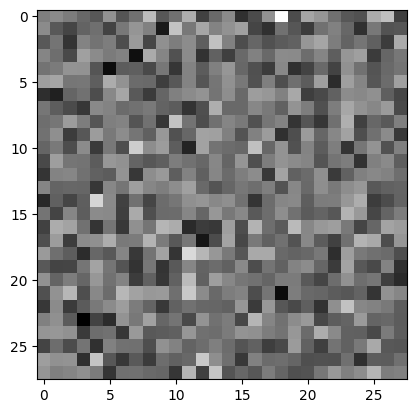

Ploting:  9


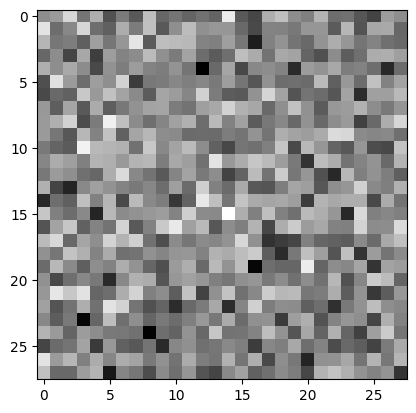

Ploting:  6


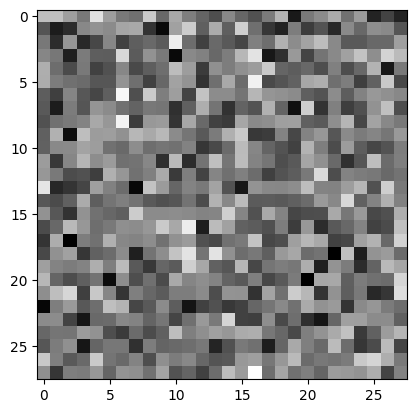

Epoch: 3550
loss_g: 3.118112087249756 	loss_d: 0.2205086052417755
Epoch: 3600
loss_g: 3.1330528259277344 	loss_d: 0.21937833726406097
Epoch: 3650
loss_g: 3.1564977169036865 	loss_d: 0.22348132729530334
Epoch: 3700
loss_g: 3.1749980449676514 	loss_d: 0.21099182963371277
Epoch: 3750
loss_g: 3.1847686767578125 	loss_d: 0.2006961703300476
Epoch: 3800
loss_g: 3.216337203979492 	loss_d: 0.19738902151584625
Epoch: 3850
loss_g: 3.2284393310546875 	loss_d: 0.19641231000423431
Epoch: 3900
loss_g: 3.252394437789917 	loss_d: 0.18871451914310455
Epoch: 3950
loss_g: 3.264540433883667 	loss_d: 0.19311828911304474
Epoch: 4000
loss_g: 3.2897987365722656 	loss_d: 0.18324017524719238
Ploting:  3


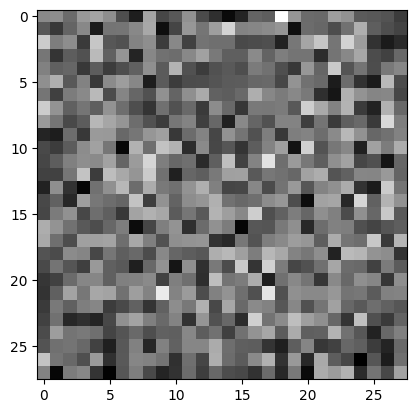

Ploting:  4


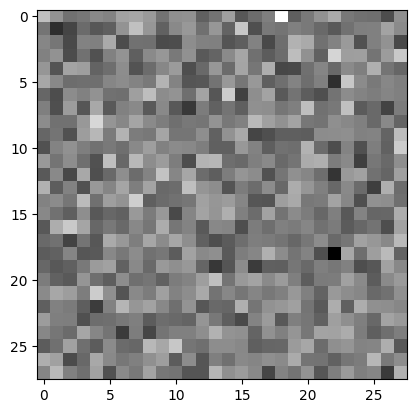

Ploting:  9


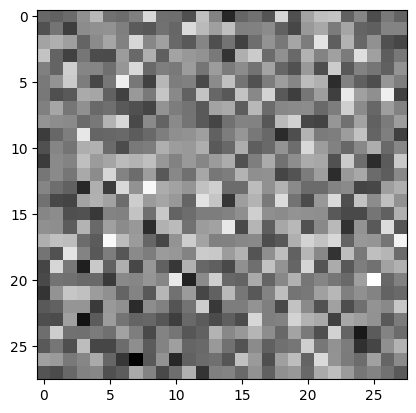

Epoch: 4050
loss_g: 3.303290605545044 	loss_d: 0.17491286993026733
Epoch: 4100
loss_g: 3.3242650032043457 	loss_d: 0.18189188838005066
Epoch: 4150
loss_g: 3.338465690612793 	loss_d: 0.17717847228050232
Epoch: 4200
loss_g: 3.3540356159210205 	loss_d: 0.17352718114852905
Epoch: 4250
loss_g: 3.3748738765716553 	loss_d: 0.1761121302843094
Epoch: 4300
loss_g: 3.3875036239624023 	loss_d: 0.16812534630298615
Epoch: 4350
loss_g: 3.405742645263672 	loss_d: 0.169930562376976
Epoch: 4400
loss_g: 3.41829514503479 	loss_d: 0.1553252786397934
Epoch: 4450
loss_g: 3.444335460662842 	loss_d: 0.15436694025993347
Epoch: 4500
loss_g: 3.45573353767395 	loss_d: 0.17248688638210297
Ploting:  3


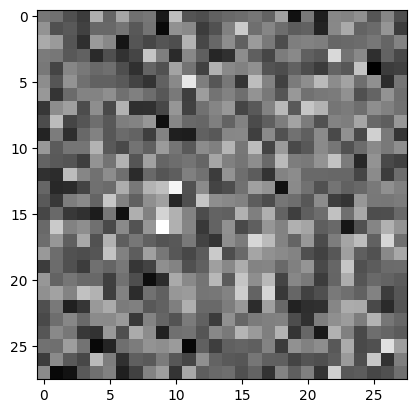

Ploting:  3


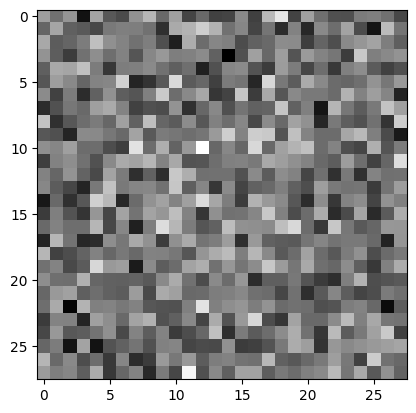

Ploting:  8


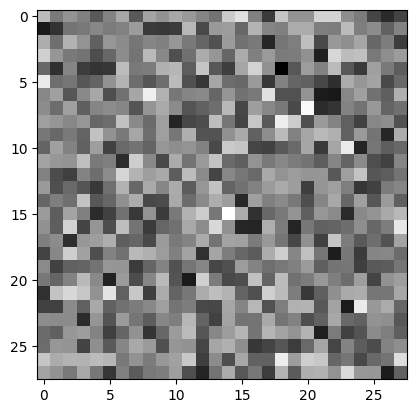

Epoch: 4550
loss_g: 3.4775917530059814 	loss_d: 0.14664337038993835
Epoch: 4600
loss_g: 3.489227771759033 	loss_d: 0.15278270840644836
Epoch: 4650
loss_g: 3.5037760734558105 	loss_d: 0.14686013758182526
Epoch: 4700
loss_g: 3.524707555770874 	loss_d: 0.1529807597398758
Epoch: 4750
loss_g: 3.5328972339630127 	loss_d: 0.14475905895233154
Epoch: 4800
loss_g: 3.5522563457489014 	loss_d: 0.1339130699634552
Epoch: 4850
loss_g: 3.5622546672821045 	loss_d: 0.12570075690746307
Epoch: 4900
loss_g: 3.5767669677734375 	loss_d: 0.1424594670534134
Epoch: 4950
loss_g: 3.5970730781555176 	loss_d: 0.13596807420253754
Epoch: 5000
loss_g: 3.6093978881835938 	loss_d: 0.13506992161273956
Ploting:  1


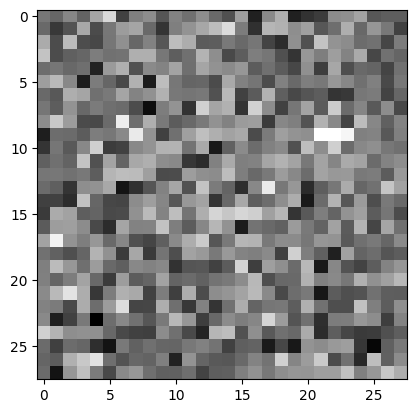

Ploting:  6


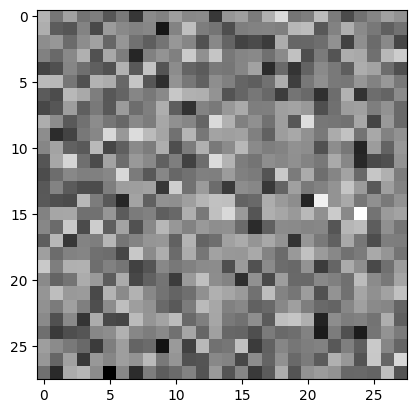

Ploting:  2


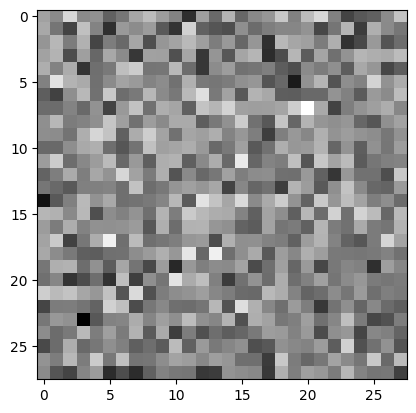

Epoch: 5050
loss_g: 3.625753164291382 	loss_d: 0.13157440721988678
Epoch: 5100
loss_g: 3.631092071533203 	loss_d: 0.12714096903800964
Epoch: 5150
loss_g: 3.6508636474609375 	loss_d: 0.12189178168773651
Epoch: 5200
loss_g: 3.6747443675994873 	loss_d: 0.13382934033870697
Epoch: 5250
loss_g: 3.677274703979492 	loss_d: 0.1213640496134758
Epoch: 5300
loss_g: 3.688014507293701 	loss_d: 0.12556208670139313
Epoch: 5350
loss_g: 3.705080509185791 	loss_d: 0.11811219900846481
Epoch: 5400
loss_g: 3.721938133239746 	loss_d: 0.11763738095760345
Epoch: 5450
loss_g: 3.728013277053833 	loss_d: 0.11865393072366714
Epoch: 5500
loss_g: 3.753196954727173 	loss_d: 0.11546079069375992
Ploting:  5


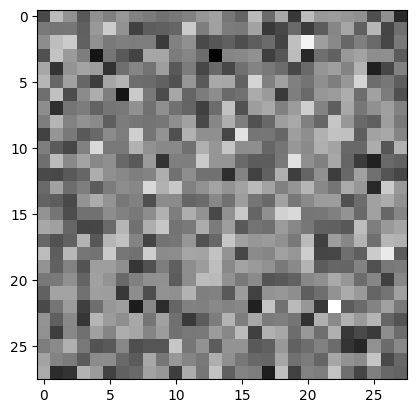

Ploting:  8


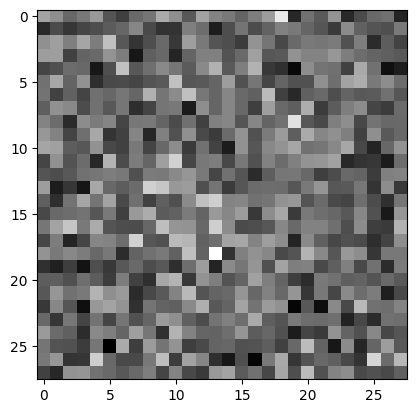

Ploting:  3


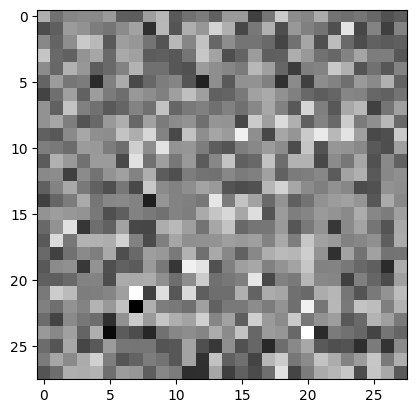

Epoch: 5550
loss_g: 3.7548606395721436 	loss_d: 0.11439283192157745
Epoch: 5600
loss_g: 3.766957998275757 	loss_d: 0.11604078114032745
Epoch: 5650
loss_g: 3.7879109382629395 	loss_d: 0.11511518061161041
Epoch: 5700
loss_g: 3.7882206439971924 	loss_d: 0.10510829836130142
Epoch: 5750
loss_g: 3.799858808517456 	loss_d: 0.0991211086511612
Epoch: 5800
loss_g: 3.8228919506073 	loss_d: 0.10618264973163605
Epoch: 5850
loss_g: 3.833446502685547 	loss_d: 0.10584388673305511
Epoch: 5900
loss_g: 3.837043046951294 	loss_d: 0.10142506659030914
Epoch: 5950
loss_g: 3.8532488346099854 	loss_d: 0.10231831669807434
Epoch: 6000
loss_g: 3.879096508026123 	loss_d: 0.10173028707504272
Ploting:  1


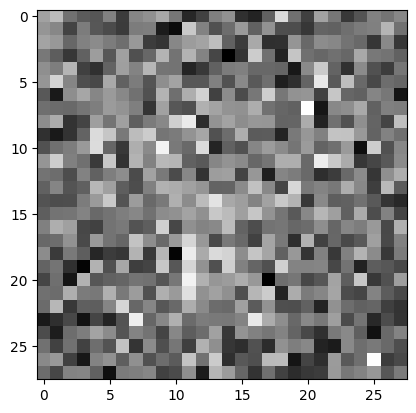

Ploting:  7


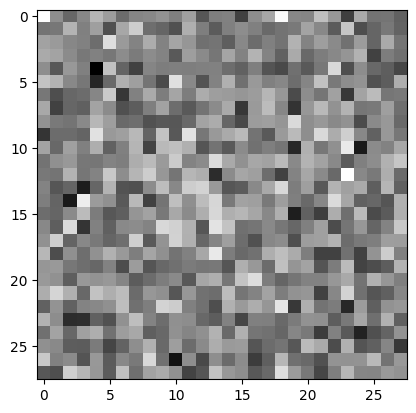

Ploting:  5


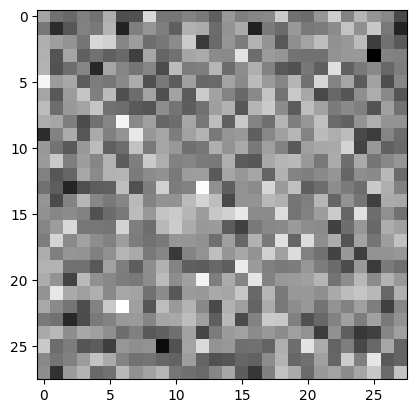

Epoch: 6050
loss_g: 3.874798536300659 	loss_d: 0.10734742134809494
Epoch: 6100
loss_g: 3.8799211978912354 	loss_d: 0.10033544152975082
Epoch: 6150
loss_g: 3.8930015563964844 	loss_d: 0.09328220039606094
Epoch: 6200
loss_g: 3.9145307540893555 	loss_d: 0.09466969966888428
Epoch: 6250
loss_g: 3.917297840118408 	loss_d: 0.0951157733798027
Epoch: 6300
loss_g: 3.917282819747925 	loss_d: 0.09076081961393356
Epoch: 6350
loss_g: 3.9364306926727295 	loss_d: 0.09484338760375977
Epoch: 6400
loss_g: 3.9499406814575195 	loss_d: 0.09068721532821655
Epoch: 6450
loss_g: 3.9637327194213867 	loss_d: 0.08649514615535736
Epoch: 6500
loss_g: 3.96924090385437 	loss_d: 0.09214803576469421
Ploting:  6


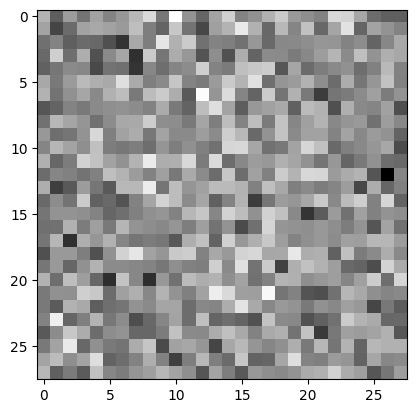

Ploting:  0


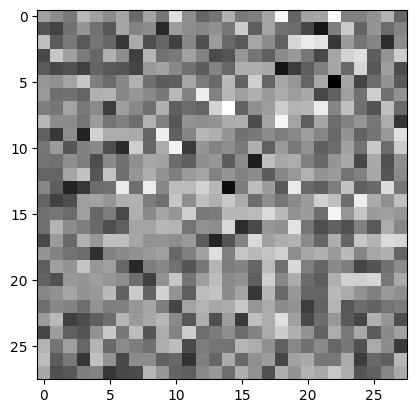

Ploting:  3


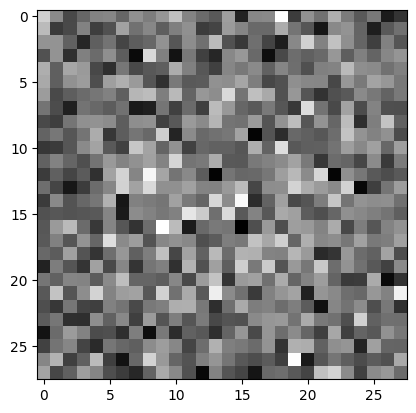

Epoch: 6550
loss_g: 3.9835054874420166 	loss_d: 0.089723601937294
Epoch: 6600
loss_g: 3.99470853805542 	loss_d: 0.08759742230176926
Epoch: 6650
loss_g: 3.996708869934082 	loss_d: 0.09298408031463623
Epoch: 6700
loss_g: 4.0146026611328125 	loss_d: 0.0875789150595665
Epoch: 6750
loss_g: 4.002461910247803 	loss_d: 0.09030376374721527
Epoch: 6800
loss_g: 4.032314777374268 	loss_d: 0.08107553422451019
Epoch: 6850
loss_g: 4.02834939956665 	loss_d: 0.08315102756023407
Epoch: 6900
loss_g: 4.036411762237549 	loss_d: 0.09600026905536652
Epoch: 6950
loss_g: 4.052821636199951 	loss_d: 0.07821623235940933
Epoch: 7000
loss_g: 4.071444988250732 	loss_d: 0.08277799189090729
Ploting:  8


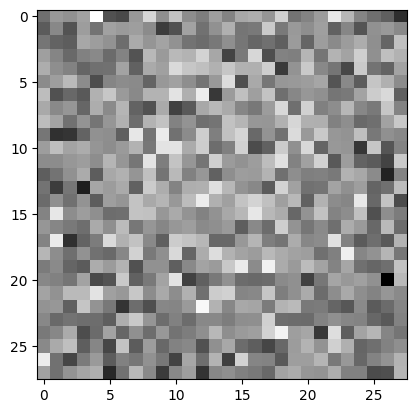

Ploting:  6


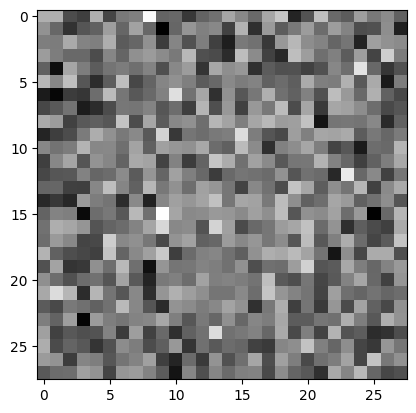

Ploting:  8


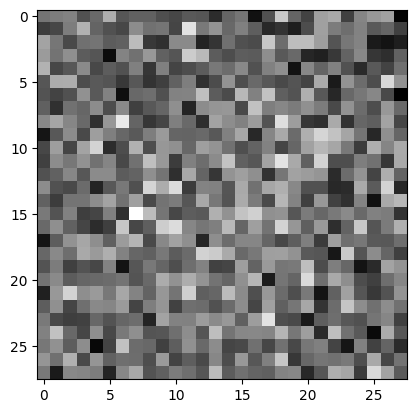

Epoch: 7050
loss_g: 4.077363014221191 	loss_d: 0.07909657061100006
Epoch: 7100
loss_g: 4.081171035766602 	loss_d: 0.08497025072574615
Epoch: 7150
loss_g: 4.087697982788086 	loss_d: 0.07878261804580688
Epoch: 7200
loss_g: 4.099483489990234 	loss_d: 0.07173293828964233
Epoch: 7250
loss_g: 4.103518962860107 	loss_d: 0.06746583431959152
Epoch: 7300
loss_g: 4.117184162139893 	loss_d: 0.08079691976308823
Epoch: 7350
loss_g: 4.1276164054870605 	loss_d: 0.07762046903371811
Epoch: 7400
loss_g: 4.1373748779296875 	loss_d: 0.07794561237096786
Epoch: 7450
loss_g: 4.160841464996338 	loss_d: 0.07502242922782898
Epoch: 7500
loss_g: 4.161462306976318 	loss_d: 0.07245748490095139
Ploting:  2


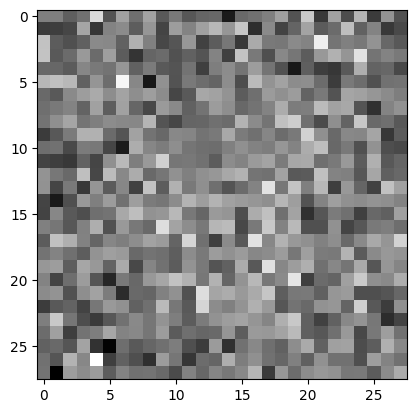

Ploting:  7


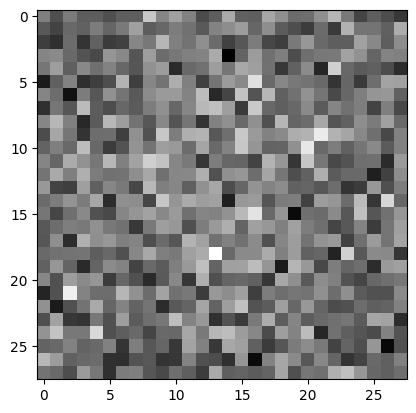

Ploting:  8


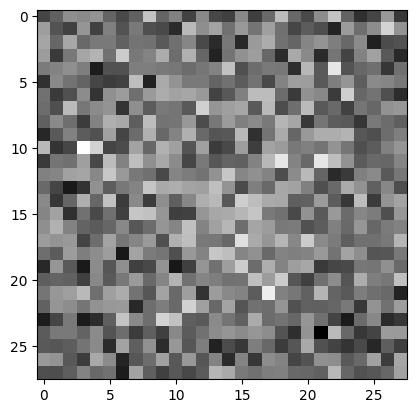

Epoch: 7550
loss_g: 4.148615837097168 	loss_d: 0.06915556639432907
Epoch: 7600
loss_g: 4.150672435760498 	loss_d: 0.07828208059072495
Epoch: 7650
loss_g: 4.158253192901611 	loss_d: 0.0705614760518074
Epoch: 7700
loss_g: 4.165401458740234 	loss_d: 0.07610564678907394
Epoch: 7750
loss_g: 4.187994480133057 	loss_d: 0.06952421367168427
Epoch: 7800
loss_g: 4.186102867126465 	loss_d: 0.06833250820636749
Epoch: 7850
loss_g: 4.202406883239746 	loss_d: 0.07091046124696732
Epoch: 7900
loss_g: 4.2173285484313965 	loss_d: 0.06891026347875595
Epoch: 7950
loss_g: 4.226661205291748 	loss_d: 0.06884969770908356
Epoch: 8000
loss_g: 4.2317962646484375 	loss_d: 0.07139613479375839
Ploting:  1


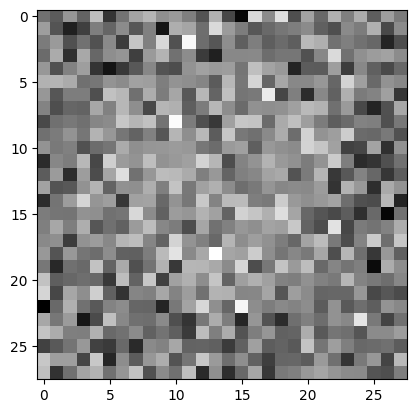

Ploting:  2


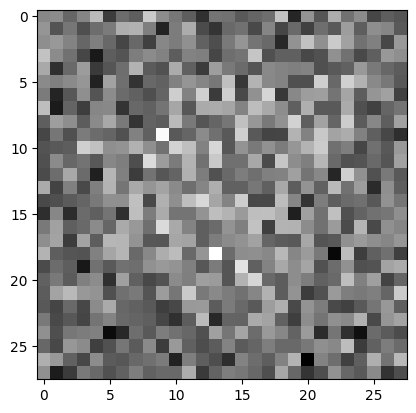

Ploting:  4


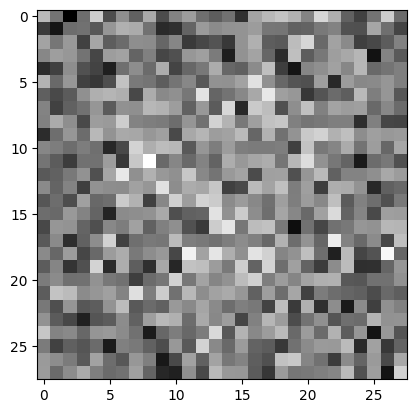

Epoch: 8050
loss_g: 4.229198455810547 	loss_d: 0.06955737620592117
Epoch: 8100
loss_g: 4.2295660972595215 	loss_d: 0.06306096166372299
Epoch: 8150
loss_g: 4.245674133300781 	loss_d: 0.05865873023867607
Epoch: 8200
loss_g: 4.250879764556885 	loss_d: 0.06577513366937637
Epoch: 8250
loss_g: 4.253818511962891 	loss_d: 0.06683278828859329
Epoch: 8300
loss_g: 4.254292011260986 	loss_d: 0.06235264614224434
Epoch: 8350
loss_g: 4.263486385345459 	loss_d: 0.06444977968931198
Epoch: 8400
loss_g: 4.272144794464111 	loss_d: 0.06303136050701141
Epoch: 8450
loss_g: 4.271241188049316 	loss_d: 0.0679963082075119
Epoch: 8500
loss_g: 4.270504474639893 	loss_d: 0.06315722316503525
Ploting:  1


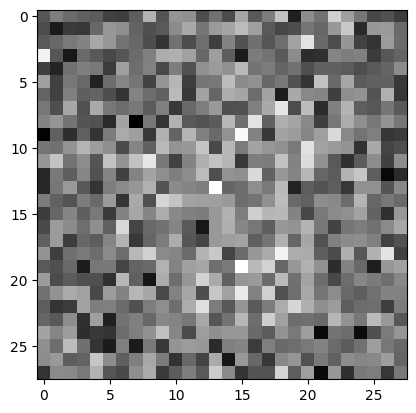

Ploting:  1


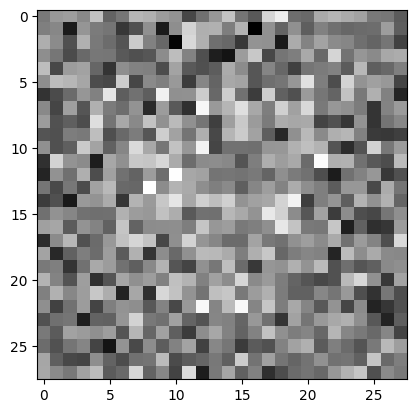

Ploting:  3


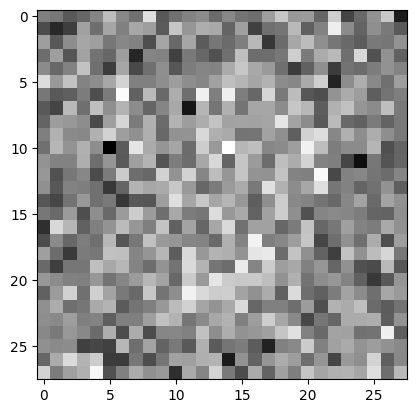

Epoch: 8550
loss_g: 4.312823295593262 	loss_d: 0.0581691600382328
Epoch: 8600
loss_g: 4.301346778869629 	loss_d: 0.06034974008798599
Epoch: 8650
loss_g: 4.288161754608154 	loss_d: 0.06055178865790367
Epoch: 8700
loss_g: 4.298328399658203 	loss_d: 0.05744550749659538
Epoch: 8750
loss_g: 4.296480655670166 	loss_d: 0.06061176210641861
Epoch: 8800
loss_g: 4.319741249084473 	loss_d: 0.05857283994555473
Epoch: 8850
loss_g: 4.332511901855469 	loss_d: 0.055963266640901566
Epoch: 8900
loss_g: 4.326311111450195 	loss_d: 0.060532815754413605
Epoch: 8950
loss_g: 4.339289665222168 	loss_d: 0.05869484692811966
Epoch: 9000
loss_g: 4.345221042633057 	loss_d: 0.05716783553361893
Ploting:  1


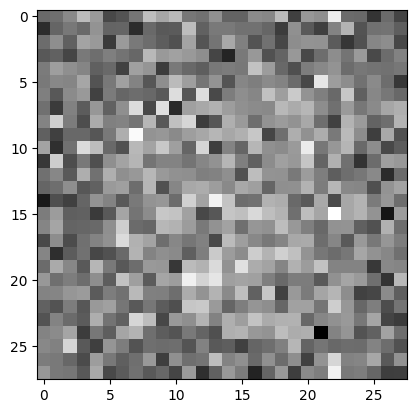

Ploting:  9


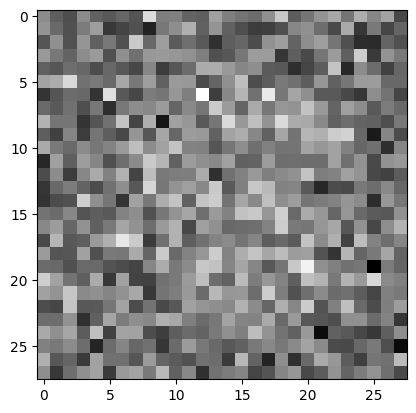

Ploting:  6


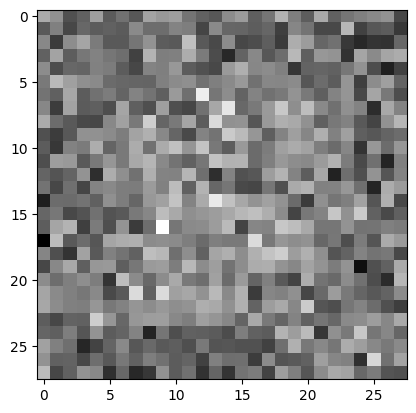

Epoch: 9050
loss_g: 4.358975887298584 	loss_d: 0.06241346150636673
Epoch: 9100
loss_g: 4.350655555725098 	loss_d: 0.05812393128871918
Epoch: 9150
loss_g: 4.35768461227417 	loss_d: 0.06055355444550514
Epoch: 9200
loss_g: 4.3488335609436035 	loss_d: 0.05410785228013992
Epoch: 9250
loss_g: 4.369311332702637 	loss_d: 0.05718264356255531
Epoch: 9300
loss_g: 4.366468906402588 	loss_d: 0.06634445488452911
Epoch: 9350
loss_g: 4.366635799407959 	loss_d: 0.05296662077307701
Epoch: 9400
loss_g: 4.377471446990967 	loss_d: 0.056324250996112823
Epoch: 9450
loss_g: 4.38394832611084 	loss_d: 0.053361814469099045
Epoch: 9500
loss_g: 4.379431247711182 	loss_d: 0.0583115890622139
Ploting:  7


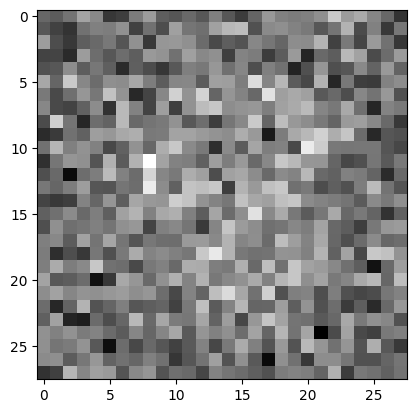

Ploting:  9


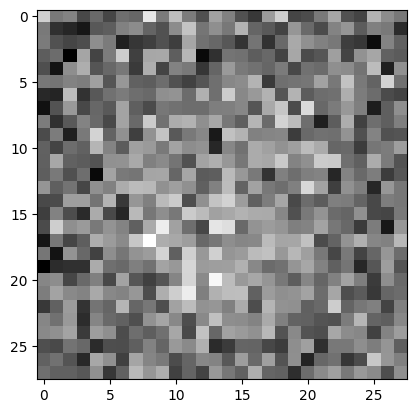

Ploting:  9


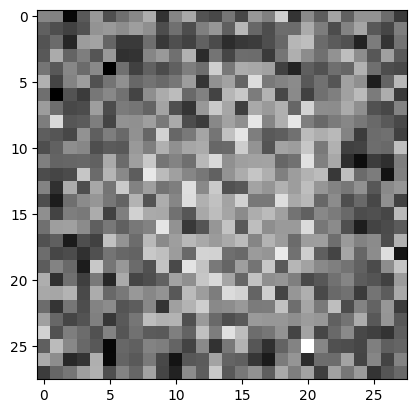

Epoch: 9550
loss_g: 4.379212379455566 	loss_d: 0.05378301441669464
Epoch: 9600
loss_g: 4.411739349365234 	loss_d: 0.04824836924672127
Epoch: 9650
loss_g: 4.414315223693848 	loss_d: 0.04553119093179703
Epoch: 9700
loss_g: 4.398071765899658 	loss_d: 0.05646192282438278
Epoch: 9750
loss_g: 4.4225382804870605 	loss_d: 0.05473164841532707
Epoch: 9800
loss_g: 4.430386066436768 	loss_d: 0.055776968598365784
Epoch: 9850
loss_g: 4.435475826263428 	loss_d: 0.05269131436944008
Epoch: 9900
loss_g: 4.427346706390381 	loss_d: 0.05108422040939331
Epoch: 9950
loss_g: 4.427282810211182 	loss_d: 0.04834580421447754
Epoch: 10000
loss_g: 4.462660312652588 	loss_d: 0.05539216473698616
Ploting:  4


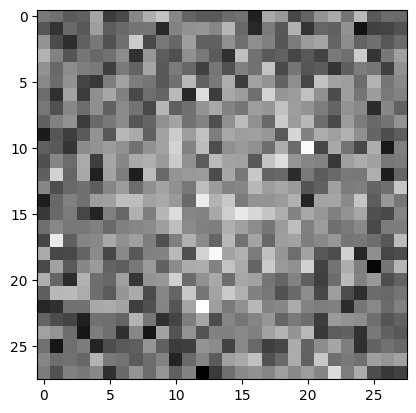

Ploting:  4


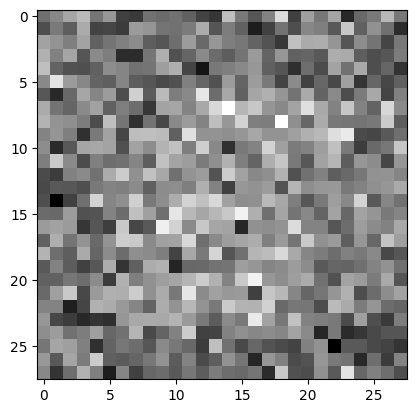

Ploting:  5


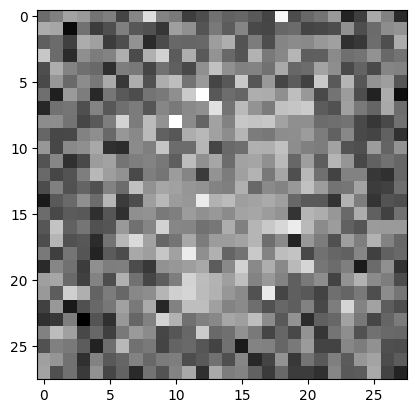

Epoch: 10050
loss_g: 4.426578998565674 	loss_d: 0.050012264400720596
Epoch: 10100
loss_g: 4.428919792175293 	loss_d: 0.055811136960983276
Epoch: 10150
loss_g: 4.463577747344971 	loss_d: 0.050033945590257645
Epoch: 10200
loss_g: 4.4546613693237305 	loss_d: 0.04828396812081337
Epoch: 10250
loss_g: 4.444413185119629 	loss_d: 0.0506560280919075
Epoch: 10300
loss_g: 4.461522579193115 	loss_d: 0.049026116728782654
Epoch: 10350
loss_g: 4.477907180786133 	loss_d: 0.049922894686460495
Epoch: 10400
loss_g: 4.470399856567383 	loss_d: 0.052589159458875656
Epoch: 10450
loss_g: 4.490748405456543 	loss_d: 0.050322216004133224
Epoch: 10500
loss_g: 4.512889862060547 	loss_d: 0.0456695593893528
Ploting:  0


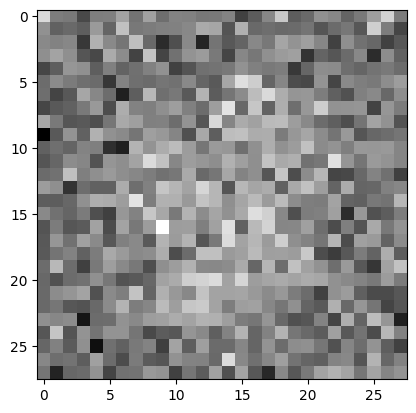

Ploting:  1


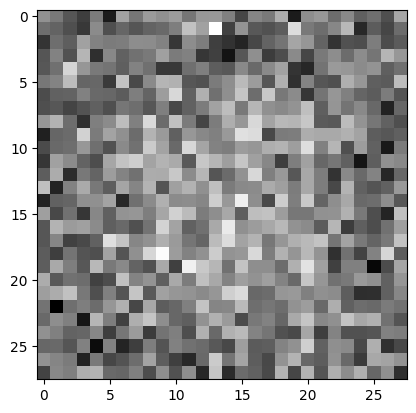

Ploting:  9


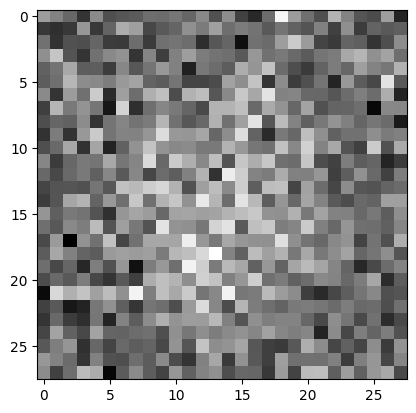

Epoch: 10550
loss_g: 4.4796528816223145 	loss_d: 0.042177338153123856
Epoch: 10600
loss_g: 4.485525608062744 	loss_d: 0.04825368896126747
Epoch: 10650
loss_g: 4.499450206756592 	loss_d: 0.04967958480119705
Epoch: 10700
loss_g: 4.4916486740112305 	loss_d: 0.04586793854832649
Epoch: 10750
loss_g: 4.512907981872559 	loss_d: 0.048025235533714294
Epoch: 10800
loss_g: 4.499835014343262 	loss_d: 0.04701704904437065
Epoch: 10850
loss_g: 4.505965709686279 	loss_d: 0.05091940611600876
Epoch: 10900
loss_g: 4.494149208068848 	loss_d: 0.0471256822347641
Epoch: 10950
loss_g: 4.514533996582031 	loss_d: 0.04279765859246254
Epoch: 11000
loss_g: 4.5203118324279785 	loss_d: 0.0452037937939167
Ploting:  1


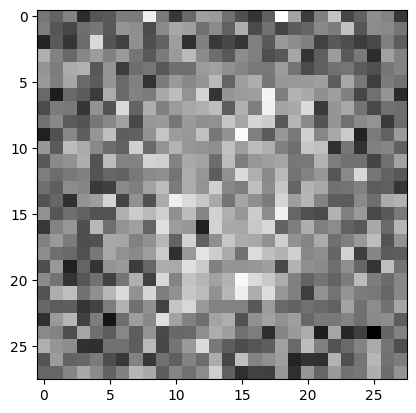

Ploting:  5


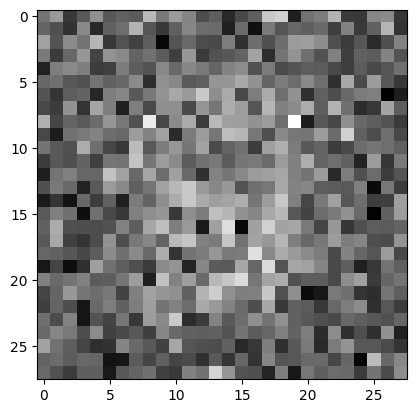

Ploting:  8


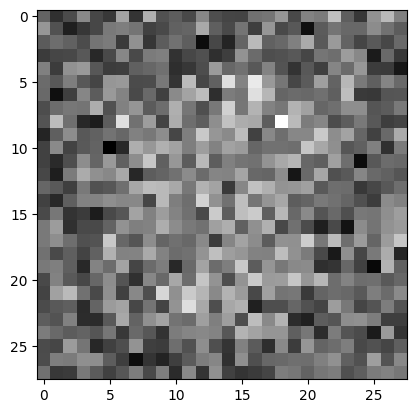

Epoch: 11050
loss_g: 4.520089149475098 	loss_d: 0.045795124024152756
Epoch: 11100
loss_g: 4.535796642303467 	loss_d: 0.04334155470132828
Epoch: 11150
loss_g: 4.521693706512451 	loss_d: 0.045373447239398956
Epoch: 11200
loss_g: 4.510107517242432 	loss_d: 0.044518936425447464
Epoch: 11250
loss_g: 4.559545040130615 	loss_d: 0.041914358735084534
Epoch: 11300
loss_g: 4.542596817016602 	loss_d: 0.046801354736089706
Epoch: 11350
loss_g: 4.525237560272217 	loss_d: 0.0443229153752327
Epoch: 11400
loss_g: 4.548471450805664 	loss_d: 0.04312250018119812
Epoch: 11450
loss_g: 4.561868190765381 	loss_d: 0.048551347106695175
Epoch: 11500
loss_g: 4.539039134979248 	loss_d: 0.04489106684923172
Ploting:  1


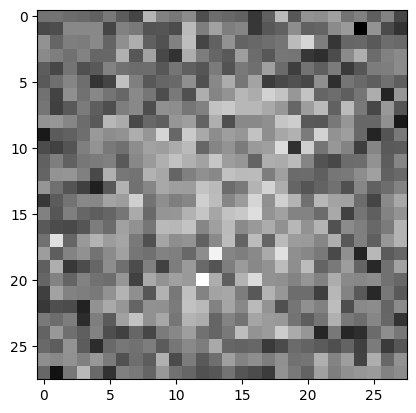

Ploting:  3


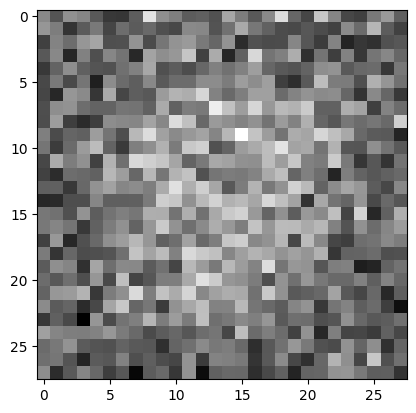

Ploting:  0


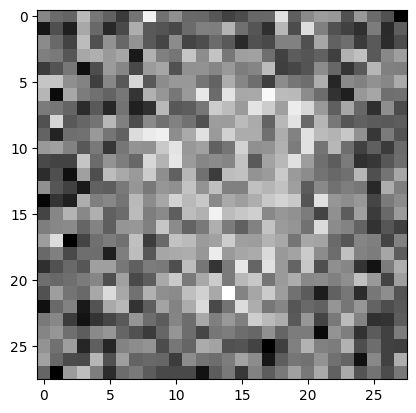

Epoch: 11550
loss_g: 4.512958526611328 	loss_d: 0.04704435542225838
Epoch: 11600
loss_g: 4.5385870933532715 	loss_d: 0.04204241558909416
Epoch: 11650
loss_g: 4.553185939788818 	loss_d: 0.04528125748038292
Epoch: 11700
loss_g: 4.587505340576172 	loss_d: 0.05251363664865494
Epoch: 11750
loss_g: 4.558130264282227 	loss_d: 0.04130035638809204
Epoch: 11800
loss_g: 4.588132381439209 	loss_d: 0.04387437552213669
Epoch: 11850
loss_g: 4.533331394195557 	loss_d: 0.04180971160531044
Epoch: 11900
loss_g: 4.541971206665039 	loss_d: 0.046430040150880814
Epoch: 11950
loss_g: 4.544966697692871 	loss_d: 0.04205356538295746
Epoch: 12000
loss_g: 4.590010166168213 	loss_d: 0.03797629103064537
Ploting:  3


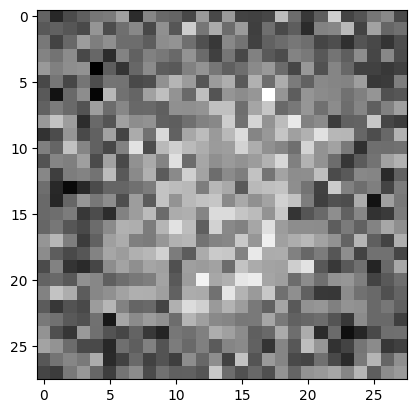

Ploting:  0


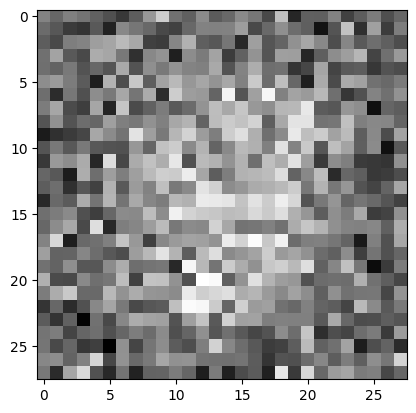

Ploting:  5


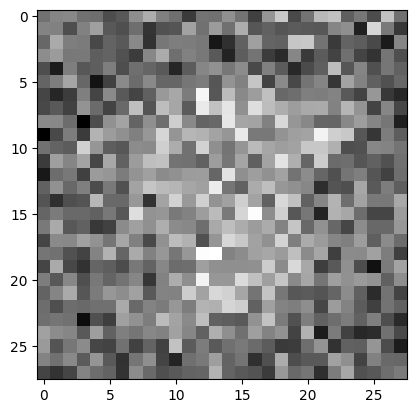

Epoch: 12050
loss_g: 4.543648719787598 	loss_d: 0.03521187976002693
Epoch: 12100
loss_g: 4.580930233001709 	loss_d: 0.04419887438416481
Epoch: 12150
loss_g: 4.583246231079102 	loss_d: 0.04378214851021767
Epoch: 12200
loss_g: 4.547801971435547 	loss_d: 0.04504154995083809
Epoch: 12250
loss_g: 4.584738731384277 	loss_d: 0.04212179034948349
Epoch: 12300
loss_g: 4.582911968231201 	loss_d: 0.040204085409641266
Epoch: 12350
loss_g: 4.584573745727539 	loss_d: 0.038403626531362534
Epoch: 12400
loss_g: 4.571951866149902 	loss_d: 0.044460732489824295
Epoch: 12450
loss_g: 4.5712666511535645 	loss_d: 0.04074227064847946
Epoch: 12500
loss_g: 4.59694766998291 	loss_d: 0.046451058238744736
Ploting:  0


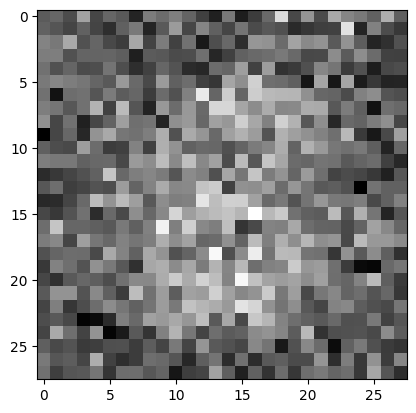

Ploting:  0


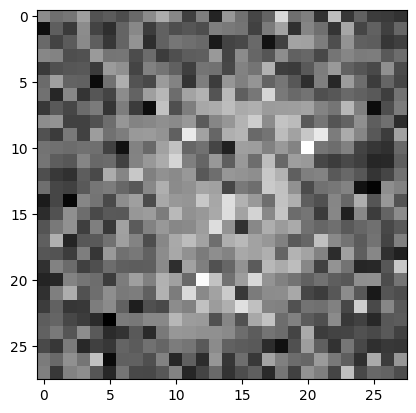

Ploting:  7


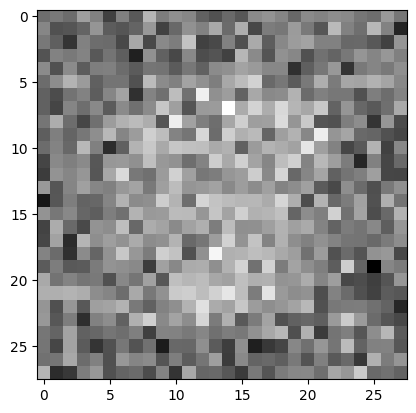

Epoch: 12550
loss_g: 4.5988688468933105 	loss_d: 0.04066795855760574
Epoch: 12600
loss_g: 4.618987083435059 	loss_d: 0.03880979120731354
Epoch: 12650
loss_g: 4.548459529876709 	loss_d: 0.04149942472577095
Epoch: 12700
loss_g: 4.5511322021484375 	loss_d: 0.03987179324030876
Epoch: 12750
loss_g: 4.590120315551758 	loss_d: 0.04079151898622513
Epoch: 12800
loss_g: 4.53407621383667 	loss_d: 0.043923571705818176
Epoch: 12850
loss_g: 4.585506439208984 	loss_d: 0.040973205119371414
Epoch: 12900
loss_g: 4.576957702636719 	loss_d: 0.03731229528784752
Epoch: 12950
loss_g: 4.606484413146973 	loss_d: 0.03415784239768982
Epoch: 13000
loss_g: 4.583307266235352 	loss_d: 0.0396454855799675
Ploting:  1


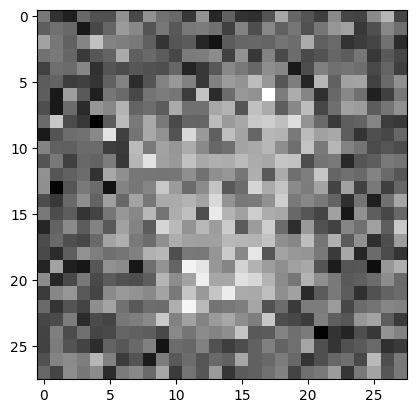

Ploting:  0


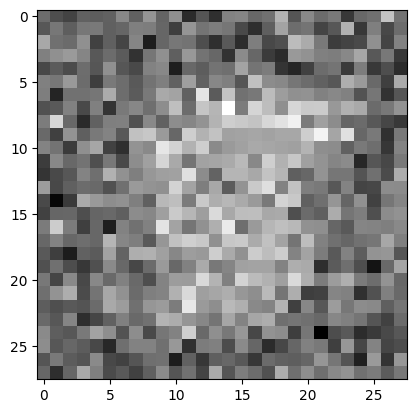

Ploting:  6


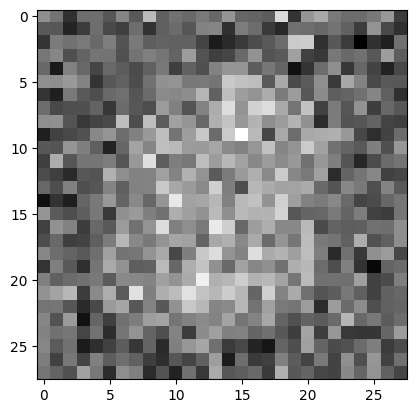

Epoch: 13050
loss_g: 4.600939750671387 	loss_d: 0.041579484939575195
Epoch: 13100
loss_g: 4.547459125518799 	loss_d: 0.03726426512002945
Epoch: 13150
loss_g: 4.628663063049316 	loss_d: 0.03993568941950798
Epoch: 13200
loss_g: 4.581831932067871 	loss_d: 0.03871810808777809
Epoch: 13250
loss_g: 4.613601207733154 	loss_d: 0.04170818254351616
Epoch: 13300
loss_g: 4.595833778381348 	loss_d: 0.03907771408557892
Epoch: 13350
loss_g: 4.568221569061279 	loss_d: 0.03539985418319702
Epoch: 13400
loss_g: 4.674317359924316 	loss_d: 0.038348983973264694
Epoch: 13450
loss_g: 4.650089740753174 	loss_d: 0.03803800046443939
Epoch: 13500
loss_g: 4.598578453063965 	loss_d: 0.03638795390725136
Ploting:  1


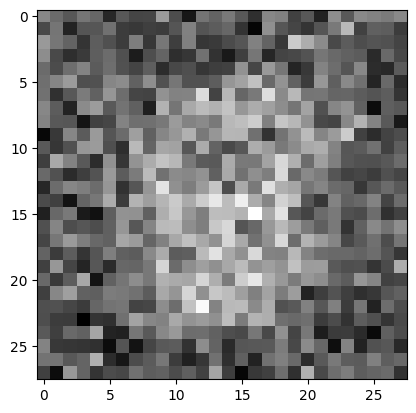

Ploting:  8


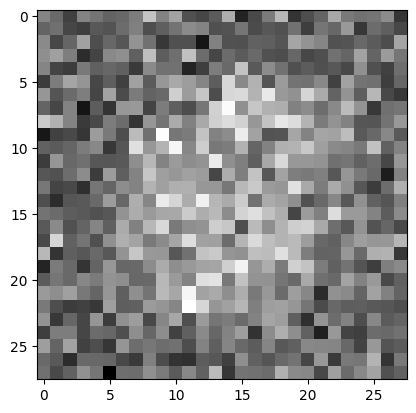

Ploting:  6


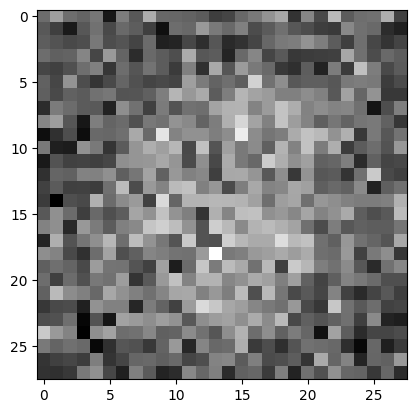

Epoch: 13550
loss_g: 4.673642635345459 	loss_d: 0.03824373334646225
Epoch: 13600
loss_g: 4.630190372467041 	loss_d: 0.03754965588450432
Epoch: 13650
loss_g: 4.642648696899414 	loss_d: 0.03577237203717232
Epoch: 13700
loss_g: 4.577134132385254 	loss_d: 0.03948191553354263
Epoch: 13750
loss_g: 4.610444068908691 	loss_d: 0.03833641856908798
Epoch: 13800
loss_g: 4.603302955627441 	loss_d: 0.03692326322197914
Epoch: 13850
loss_g: 4.5995001792907715 	loss_d: 0.04167213290929794
Epoch: 13900
loss_g: 4.574652194976807 	loss_d: 0.038039349019527435
Epoch: 13950
loss_g: 4.651090145111084 	loss_d: 0.040469277650117874
Epoch: 14000
loss_g: 4.634921550750732 	loss_d: 0.03691992536187172
Ploting:  6


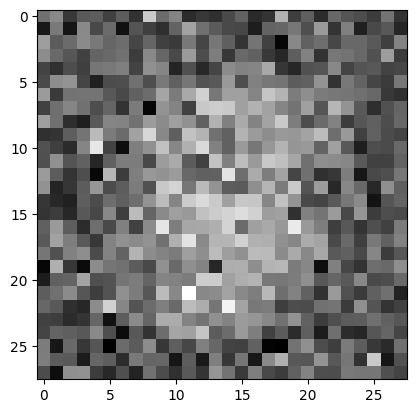

Ploting:  0


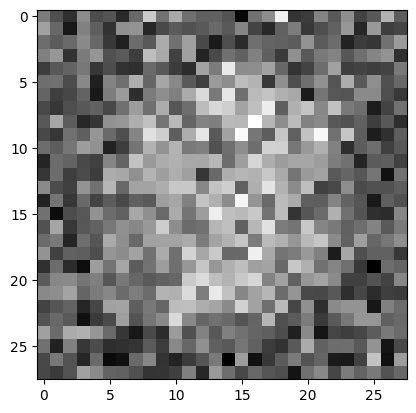

Ploting:  9


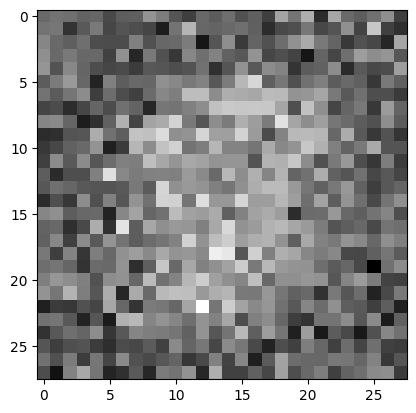

Epoch: 14050
loss_g: 4.577337741851807 	loss_d: 0.03992646187543869
Epoch: 14100
loss_g: 4.581728935241699 	loss_d: 0.03881716728210449
Epoch: 14150
loss_g: 4.632132053375244 	loss_d: 0.03764595091342926
Epoch: 14200
loss_g: 4.59010124206543 	loss_d: 0.03845573961734772
Epoch: 14250
loss_g: 4.623158931732178 	loss_d: 0.039928603917360306
Epoch: 14300
loss_g: 4.596993923187256 	loss_d: 0.0350838340818882
Epoch: 14350
loss_g: 4.581929683685303 	loss_d: 0.037953171879053116
Epoch: 14400
loss_g: 4.612931251525879 	loss_d: 0.03743962198495865
Epoch: 14450
loss_g: 4.626575946807861 	loss_d: 0.041692350059747696
Epoch: 14500
loss_g: 4.6075439453125 	loss_d: 0.04163624718785286
Ploting:  6


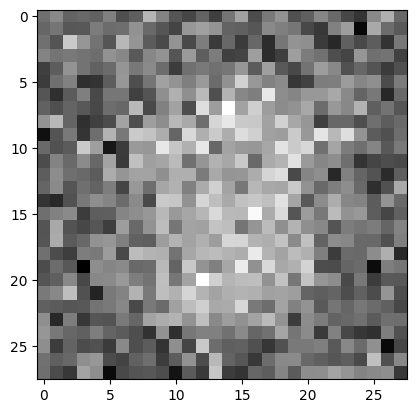

Ploting:  9


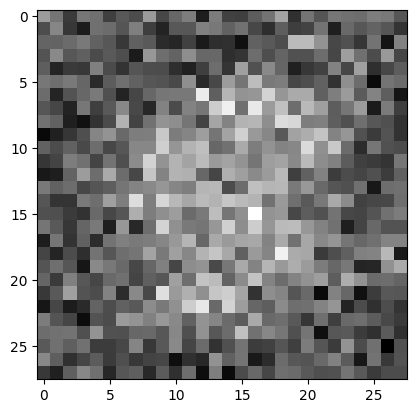

Ploting:  0


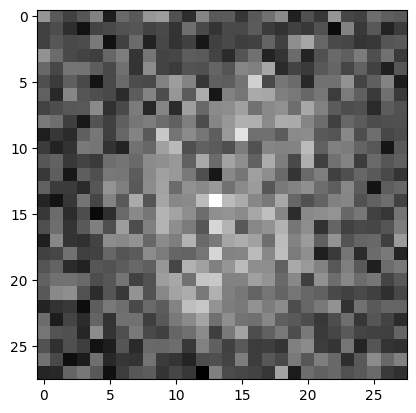

Epoch: 14550
loss_g: 4.610166549682617 	loss_d: 0.03444676473736763
Epoch: 14600
loss_g: 4.629062175750732 	loss_d: 0.04107452929019928
Epoch: 14650
loss_g: 4.599778175354004 	loss_d: 0.043219078332185745
Epoch: 14700
loss_g: 4.613313674926758 	loss_d: 0.03823152557015419
Epoch: 14750
loss_g: 4.6202569007873535 	loss_d: 0.03787865862250328
Epoch: 14800
loss_g: 4.600026607513428 	loss_d: 0.04092397913336754
Epoch: 14850
loss_g: 4.600631237030029 	loss_d: 0.044524915516376495
Epoch: 14900
loss_g: 4.677314281463623 	loss_d: 0.03956837207078934
Epoch: 14950
loss_g: 4.565347671508789 	loss_d: 0.03709038719534874
Epoch: 15000
loss_g: 4.623876571655273 	loss_d: 0.030792510136961937
Ploting:  2


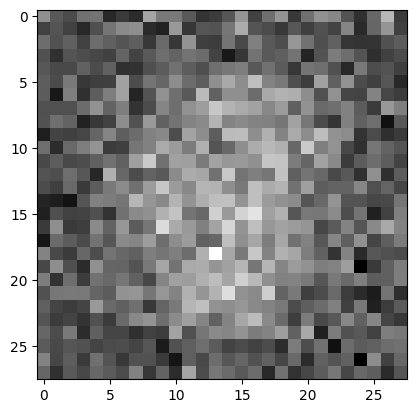

Ploting:  8


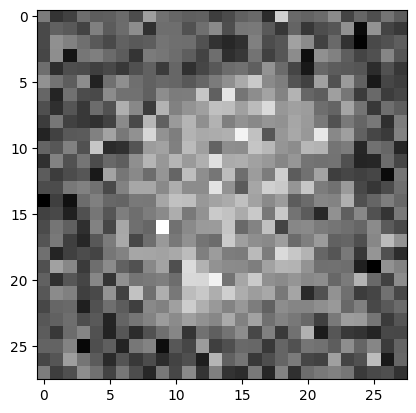

Ploting:  5


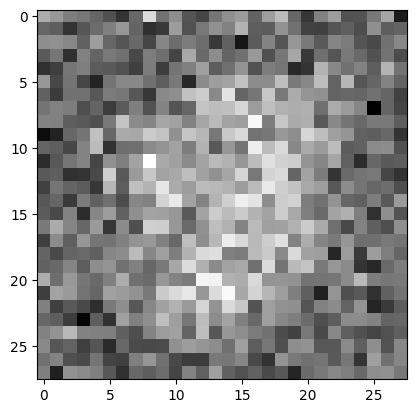

Epoch: 15050
loss_g: 4.587399005889893 	loss_d: 0.03248804062604904
Epoch: 15100
loss_g: 4.540233135223389 	loss_d: 0.04236132651567459
Epoch: 15150
loss_g: 4.518509864807129 	loss_d: 0.03824979439377785
Epoch: 15200
loss_g: 4.587409973144531 	loss_d: 0.038851190358400345
Epoch: 15250
loss_g: 4.6156697273254395 	loss_d: 0.03461581841111183
Epoch: 15300
loss_g: 4.579061031341553 	loss_d: 0.035137277096509933
Epoch: 15350
loss_g: 4.655559062957764 	loss_d: 0.03665758669376373
Epoch: 15400
loss_g: 4.575772762298584 	loss_d: 0.03126353397965431
Epoch: 15450
loss_g: 4.6271772384643555 	loss_d: 0.03425537422299385
Epoch: 15500
loss_g: 4.5850067138671875 	loss_d: 0.03284243494272232
Ploting:  1


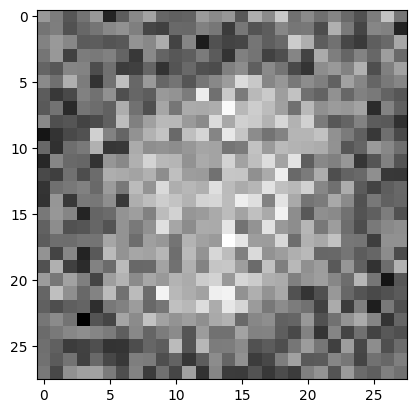

Ploting:  5


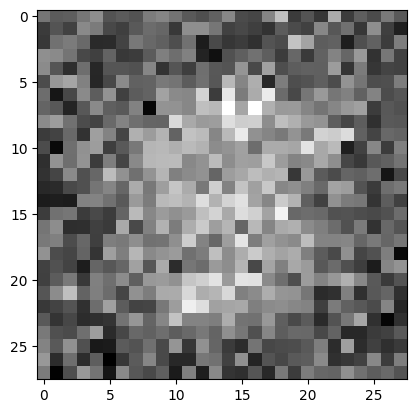

Ploting:  9


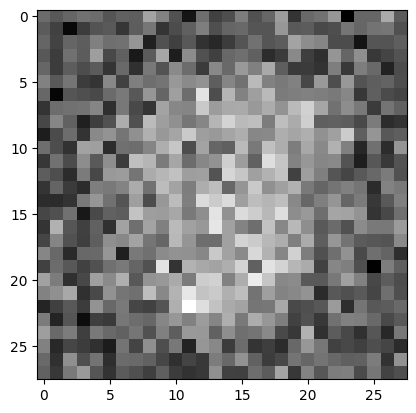

Epoch: 15550
loss_g: 4.610225677490234 	loss_d: 0.04258277267217636
Epoch: 15600
loss_g: 4.592349529266357 	loss_d: 0.03499684855341911
Epoch: 15650
loss_g: 4.625926494598389 	loss_d: 0.037891075015068054
Epoch: 15700
loss_g: 4.634425163269043 	loss_d: 0.04115491360425949
Epoch: 15750
loss_g: 4.567670822143555 	loss_d: 0.03781644627451897
Epoch: 15800
loss_g: 4.5877861976623535 	loss_d: 0.03425995260477066
Epoch: 15850
loss_g: 4.58070182800293 	loss_d: 0.03603404015302658
Epoch: 15900
loss_g: 4.617317199707031 	loss_d: 0.03372010588645935
Epoch: 15950
loss_g: 4.5619330406188965 	loss_d: 0.035000044852495193
Epoch: 16000
loss_g: 4.584892272949219 	loss_d: 0.030666083097457886
Ploting:  7


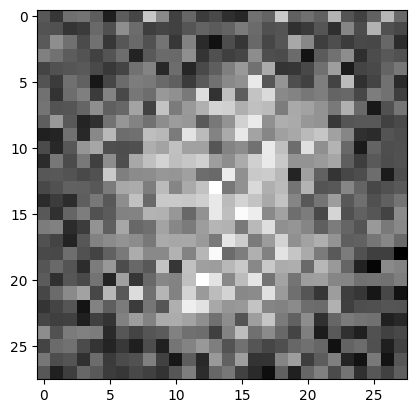

Ploting:  6


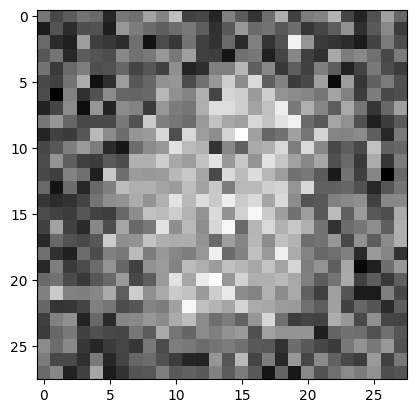

Ploting:  4


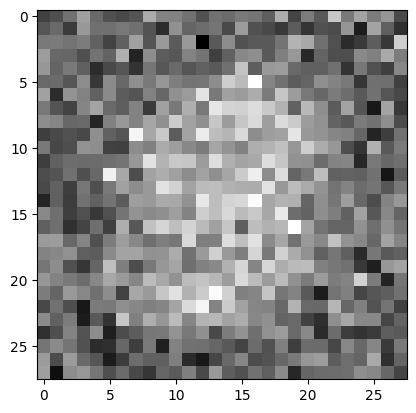

Epoch: 16050
loss_g: 4.597550392150879 	loss_d: 0.03942691162228584
Epoch: 16100
loss_g: 4.556741714477539 	loss_d: 0.03903403878211975
Epoch: 16150
loss_g: 4.63051700592041 	loss_d: 0.03555694594979286
Epoch: 16200
loss_g: 4.522688388824463 	loss_d: 0.028948277235031128
Epoch: 16250
loss_g: 4.589408874511719 	loss_d: 0.035759925842285156
Epoch: 16300
loss_g: 4.593136310577393 	loss_d: 0.03504925221204758
Epoch: 16350
loss_g: 4.661752223968506 	loss_d: 0.03426830470561981
Epoch: 16400
loss_g: 4.580290794372559 	loss_d: 0.044920723885297775
Epoch: 16450
loss_g: 4.62741231918335 	loss_d: 0.04330382123589516
Epoch: 16500
loss_g: 4.61177921295166 	loss_d: 0.0337735079228878
Ploting:  6


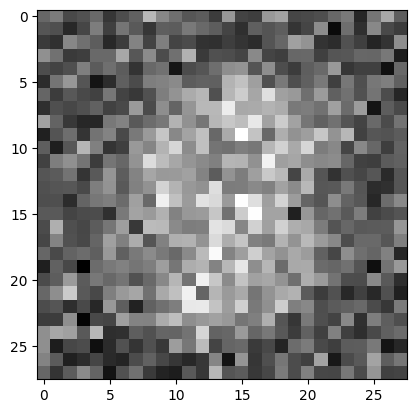

Ploting:  7


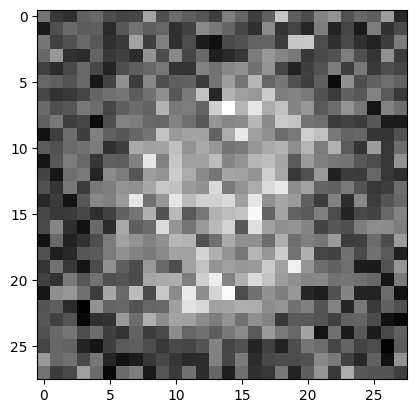

Ploting:  4


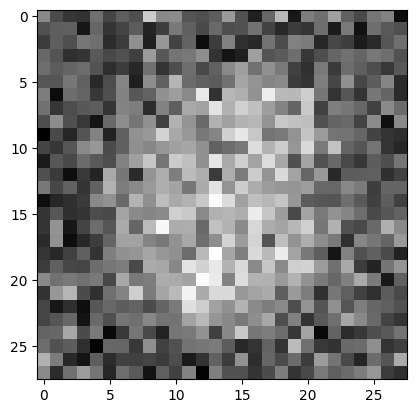

Epoch: 16550
loss_g: 4.55861759185791 	loss_d: 0.03551468998193741
Epoch: 16600
loss_g: 4.529477119445801 	loss_d: 0.0356418639421463
Epoch: 16650
loss_g: 4.675158500671387 	loss_d: 0.03756881132721901
Epoch: 16700
loss_g: 4.504395008087158 	loss_d: 0.0321069099009037
Epoch: 16750
loss_g: 4.549679279327393 	loss_d: 0.036294903606176376
Epoch: 16800
loss_g: 4.592503547668457 	loss_d: 0.03482871502637863
Epoch: 16850
loss_g: 4.491466045379639 	loss_d: 0.04096987470984459
Epoch: 16900
loss_g: 4.57743501663208 	loss_d: 0.04110415279865265
Epoch: 16950
loss_g: 4.571715831756592 	loss_d: 0.03376604989171028
Epoch: 17000
loss_g: 4.571503639221191 	loss_d: 0.03914938494563103
Ploting:  6


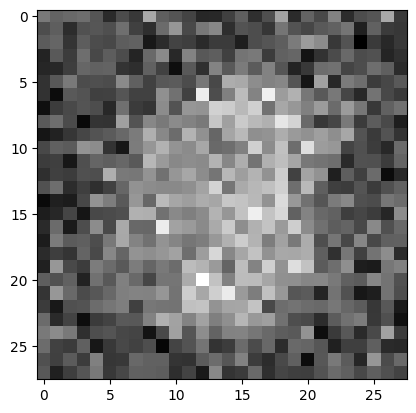

Ploting:  7


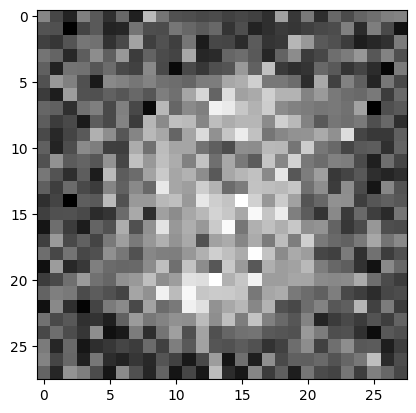

Ploting:  0


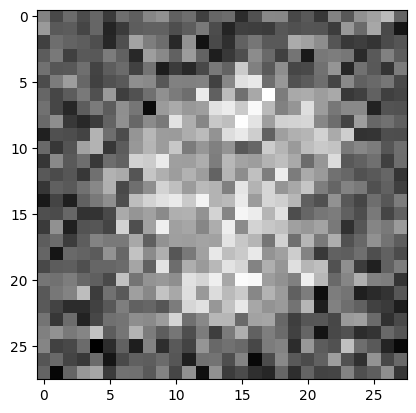

Epoch: 17050
loss_g: 4.518661022186279 	loss_d: 0.0426546186208725
Epoch: 17100
loss_g: 4.548149108886719 	loss_d: 0.03635955601930618
Epoch: 17150
loss_g: 4.594742774963379 	loss_d: 0.0372190847992897
Epoch: 17200
loss_g: 4.551802158355713 	loss_d: 0.0393763929605484
Epoch: 17250
loss_g: 4.5654730796813965 	loss_d: 0.04352588579058647
Epoch: 17300
loss_g: 4.62166166305542 	loss_d: 0.038235265761613846
Epoch: 17350
loss_g: 4.59592342376709 	loss_d: 0.03788258880376816
Epoch: 17400
loss_g: 4.519787311553955 	loss_d: 0.02970736473798752
Epoch: 17450
loss_g: 4.559088230133057 	loss_d: 0.032815106213092804
Epoch: 17500
loss_g: 4.489429950714111 	loss_d: 0.04324861988425255
Ploting:  9


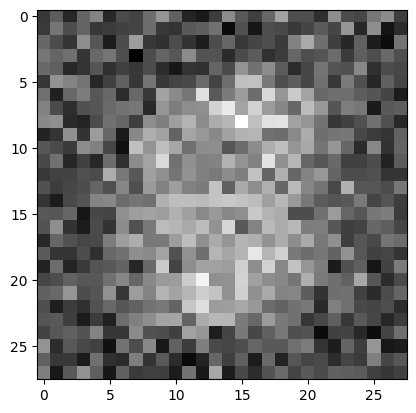

Ploting:  2


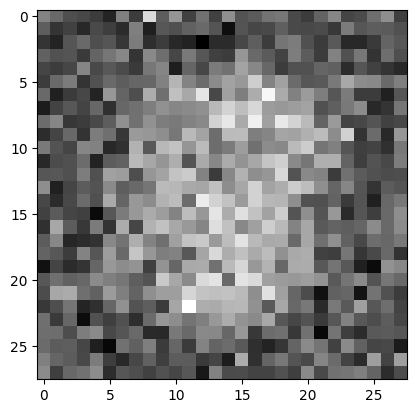

Ploting:  6


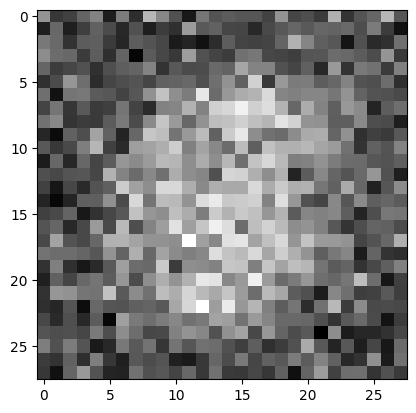

Epoch: 17550
loss_g: 4.619104385375977 	loss_d: 0.03838099539279938
Epoch: 17600
loss_g: 4.466675281524658 	loss_d: 0.03907729685306549
Epoch: 17650
loss_g: 4.538147926330566 	loss_d: 0.03507958725094795
Epoch: 17700
loss_g: 4.551015853881836 	loss_d: 0.034927304834127426
Epoch: 17750
loss_g: 4.470189094543457 	loss_d: 0.03693171590566635
Epoch: 17800
loss_g: 4.530398368835449 	loss_d: 0.030528394505381584
Epoch: 17850
loss_g: 4.572808265686035 	loss_d: 0.034931305795907974
Epoch: 17900
loss_g: 4.505066871643066 	loss_d: 0.03204472362995148
Epoch: 17950
loss_g: 4.501739978790283 	loss_d: 0.04354757070541382
Epoch: 18000
loss_g: 4.483914852142334 	loss_d: 0.033876121044158936
Ploting:  9


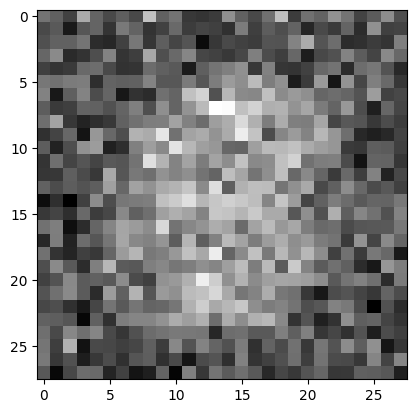

Ploting:  6


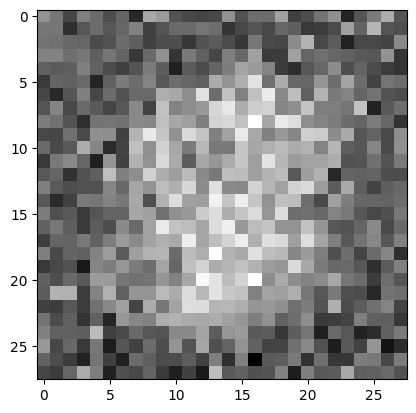

Ploting:  0


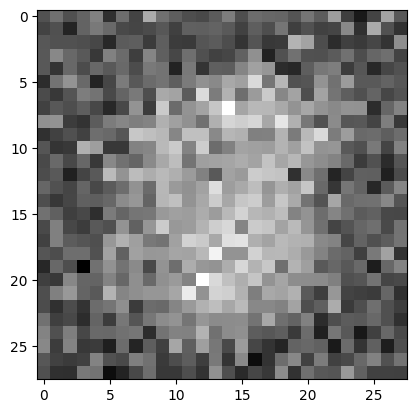

Epoch: 18050
loss_g: 4.514224529266357 	loss_d: 0.037400200963020325
Epoch: 18100
loss_g: 4.5110626220703125 	loss_d: 0.04151066765189171
Epoch: 18150
loss_g: 4.5347418785095215 	loss_d: 0.03834959492087364
Epoch: 18200
loss_g: 4.467828750610352 	loss_d: 0.03363903984427452
Epoch: 18250
loss_g: 4.496467590332031 	loss_d: 0.037621114403009415
Epoch: 18300
loss_g: 4.471994400024414 	loss_d: 0.03531770780682564
Epoch: 18350
loss_g: 4.443790912628174 	loss_d: 0.03458109125494957
Epoch: 18400
loss_g: 4.520013809204102 	loss_d: 0.0318877212703228
Epoch: 18450
loss_g: 4.619601249694824 	loss_d: 0.04078339785337448
Epoch: 18500
loss_g: 4.5374932289123535 	loss_d: 0.0405629426240921
Ploting:  8


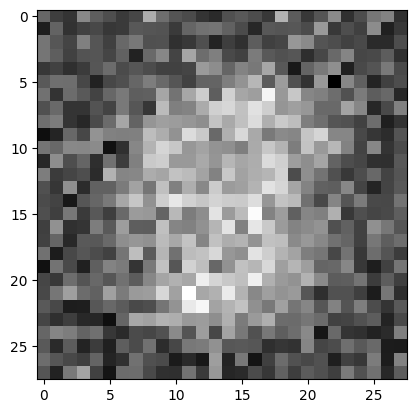

Ploting:  3


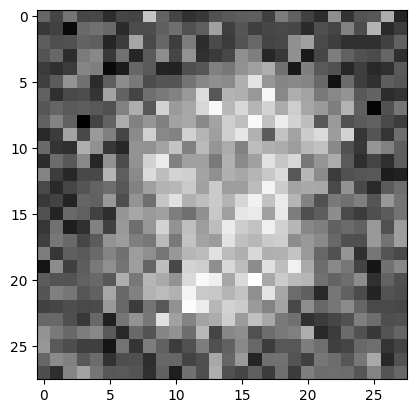

Ploting:  7


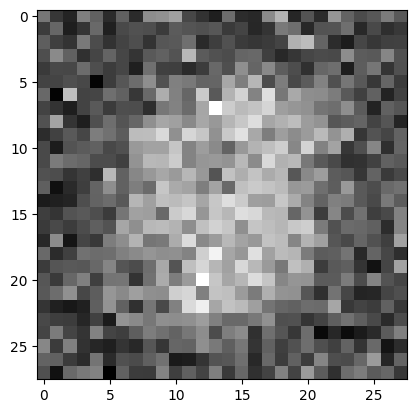

Epoch: 18550
loss_g: 4.487480163574219 	loss_d: 0.03678949177265167
Epoch: 18600
loss_g: 4.392458438873291 	loss_d: 0.030917882919311523
Epoch: 18650
loss_g: 4.392033576965332 	loss_d: 0.03852580487728119
Epoch: 18700
loss_g: 4.463489055633545 	loss_d: 0.03563239425420761
Epoch: 18750
loss_g: 4.454361438751221 	loss_d: 0.03718288242816925
Epoch: 18800
loss_g: 4.55082893371582 	loss_d: 0.04669201746582985
Epoch: 18850
loss_g: 4.4491095542907715 	loss_d: 0.045191917568445206
Epoch: 18900
loss_g: 4.4676103591918945 	loss_d: 0.034588418900966644
Epoch: 18950
loss_g: 4.413261890411377 	loss_d: 0.0372522696852684
Epoch: 19000
loss_g: 4.552994251251221 	loss_d: 0.03733539581298828
Ploting:  1


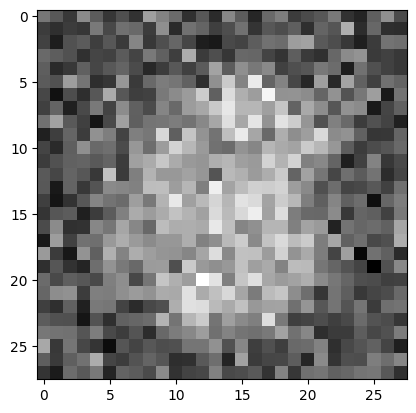

Ploting:  7


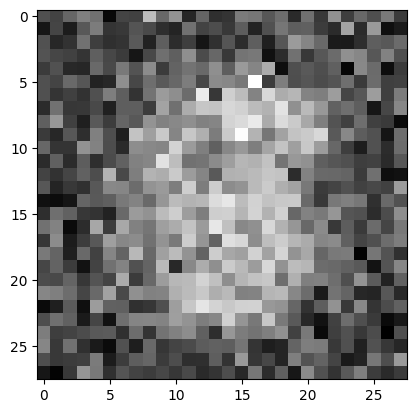

Ploting:  4


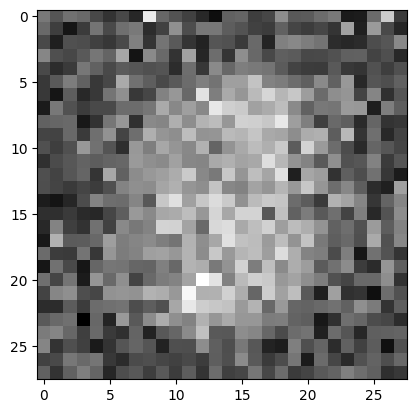

Epoch: 19050
loss_g: 4.482664108276367 	loss_d: 0.040848683565855026
Epoch: 19100
loss_g: 4.50585412979126 	loss_d: 0.03307294845581055
Epoch: 19150
loss_g: 4.499436378479004 	loss_d: 0.03814990818500519
Epoch: 19200
loss_g: 4.4857964515686035 	loss_d: 0.03695669770240784
Epoch: 19250
loss_g: 4.4491424560546875 	loss_d: 0.04346950352191925
Epoch: 19300
loss_g: 4.382351398468018 	loss_d: 0.041152939200401306
Epoch: 19350
loss_g: 4.5282464027404785 	loss_d: 0.035833414644002914
Epoch: 19400
loss_g: 4.295482158660889 	loss_d: 0.040918223559856415
Epoch: 19450
loss_g: 4.375499725341797 	loss_d: 0.04408681392669678
Epoch: 19500
loss_g: 4.3959760665893555 	loss_d: 0.038921717554330826
Ploting:  6


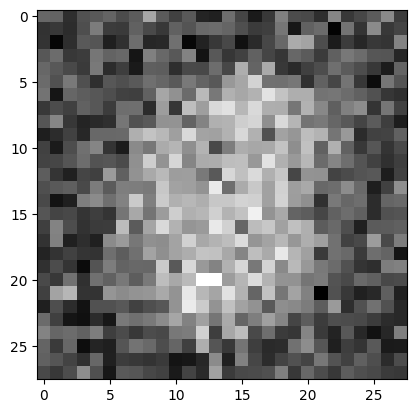

Ploting:  4


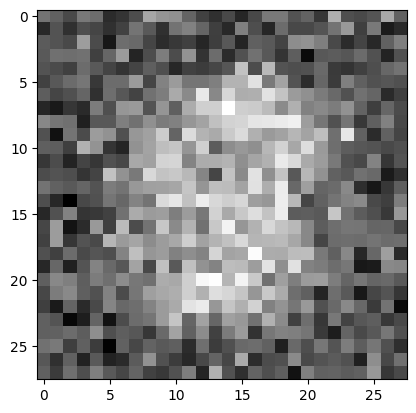

Ploting:  0


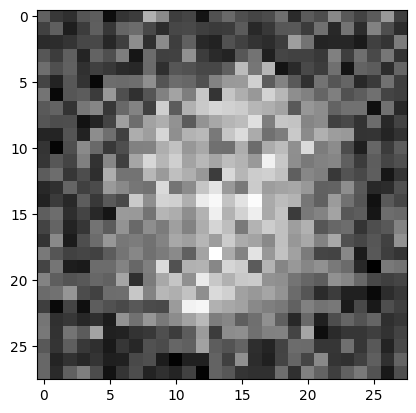

Epoch: 19550
loss_g: 4.461334228515625 	loss_d: 0.04041307419538498
Epoch: 19600
loss_g: 4.400839328765869 	loss_d: 0.042593784630298615
Epoch: 19650
loss_g: 4.4727959632873535 	loss_d: 0.045853693038225174
Epoch: 19700
loss_g: 4.5497965812683105 	loss_d: 0.04052828997373581
Epoch: 19750
loss_g: 4.370744705200195 	loss_d: 0.039486512541770935
Epoch: 19800
loss_g: 4.414187908172607 	loss_d: 0.03347489610314369
Epoch: 19850
loss_g: 4.441762447357178 	loss_d: 0.035597603768110275
Epoch: 19900
loss_g: 4.447537422180176 	loss_d: 0.047421474009752274
Epoch: 19950
loss_g: 4.366397380828857 	loss_d: 0.039638955146074295
Epoch: 20000
loss_g: 4.373892307281494 	loss_d: 0.042084742337465286
Ploting:  8


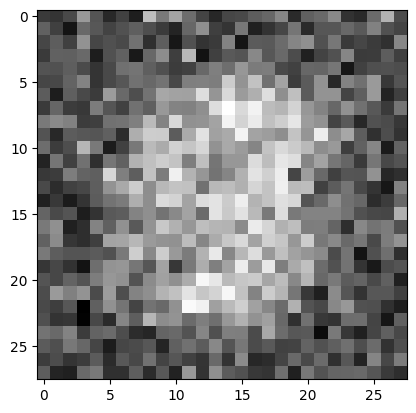

Ploting:  0


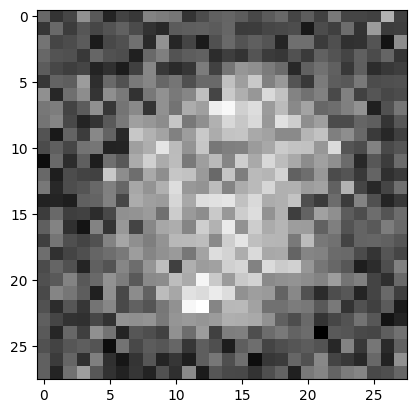

Ploting:  4


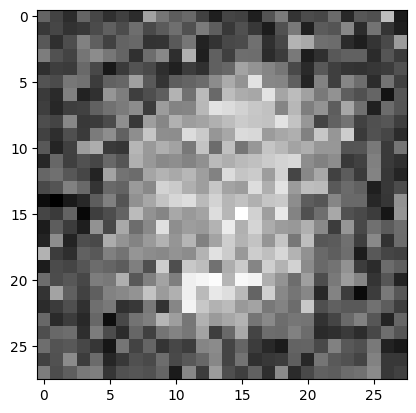

Epoch: 20050
loss_g: 4.398862361907959 	loss_d: 0.03830448165535927
Epoch: 20100
loss_g: 4.322699546813965 	loss_d: 0.03875349834561348
Epoch: 20150
loss_g: 4.289566993713379 	loss_d: 0.04213492199778557
Epoch: 20200
loss_g: 4.3559770584106445 	loss_d: 0.03381206467747688
Epoch: 20250
loss_g: 4.416673183441162 	loss_d: 0.03890486806631088
Epoch: 20300
loss_g: 4.37050199508667 	loss_d: 0.034955624490976334
Epoch: 20350
loss_g: 4.347871780395508 	loss_d: 0.04960644617676735
Epoch: 20400
loss_g: 4.516477108001709 	loss_d: 0.04034443944692612
Epoch: 20450
loss_g: 4.431845188140869 	loss_d: 0.043991606682538986
Epoch: 20500
loss_g: 4.383544445037842 	loss_d: 0.04909709841012955
Ploting:  6


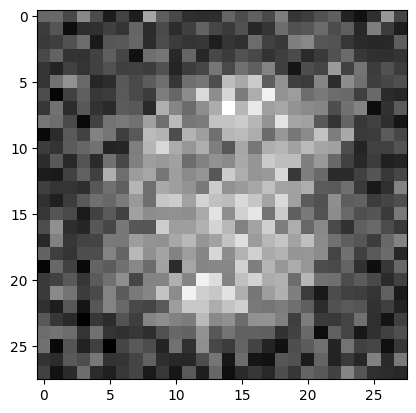

Ploting:  6


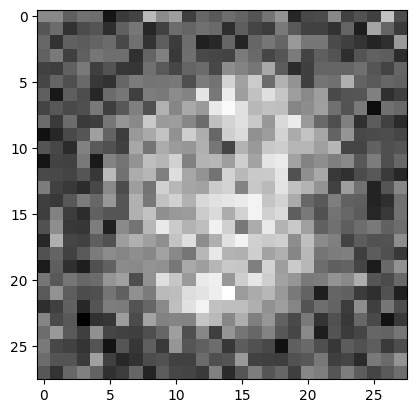

Ploting:  0


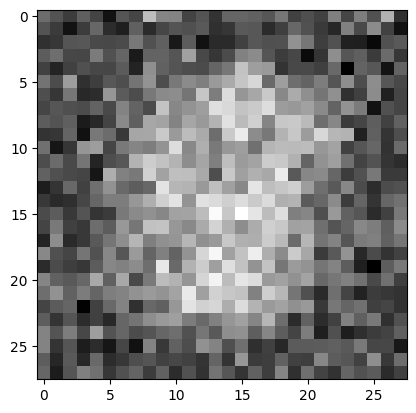

Epoch: 20550
loss_g: 4.367271423339844 	loss_d: 0.041616205126047134
Epoch: 20600
loss_g: 4.4497480392456055 	loss_d: 0.036002837121486664
Epoch: 20650
loss_g: 4.299154758453369 	loss_d: 0.042684707790613174
Epoch: 20700
loss_g: 4.455419063568115 	loss_d: 0.04073144495487213
Epoch: 20750
loss_g: 4.355190753936768 	loss_d: 0.0388779379427433
Epoch: 20800
loss_g: 4.313424110412598 	loss_d: 0.037557896226644516
Epoch: 20850
loss_g: 4.315720558166504 	loss_d: 0.04671970754861832
Epoch: 20900
loss_g: 4.344398021697998 	loss_d: 0.046505384147167206
Epoch: 20950
loss_g: 4.459824562072754 	loss_d: 0.04160277917981148
Epoch: 21000
loss_g: 4.2708024978637695 	loss_d: 0.03526720032095909
Ploting:  1


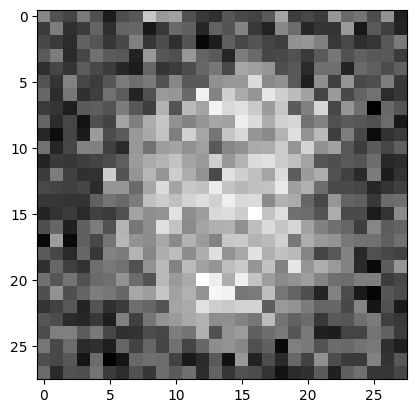

Ploting:  0


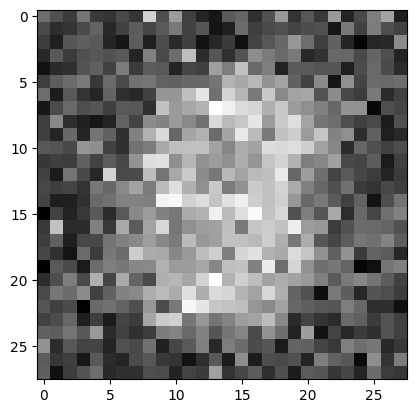

Ploting:  3


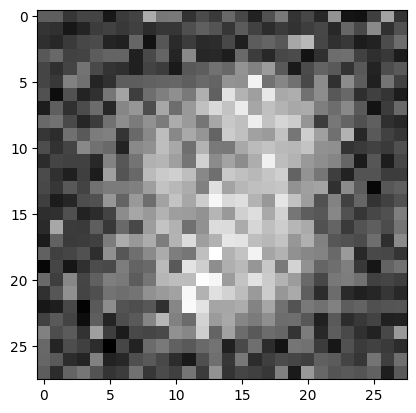

Epoch: 21050
loss_g: 4.482822418212891 	loss_d: 0.04345790669322014
Epoch: 21100
loss_g: 4.325998306274414 	loss_d: 0.04096367582678795
Epoch: 21150
loss_g: 4.4161601066589355 	loss_d: 0.04388437047600746
Epoch: 21200
loss_g: 4.263894557952881 	loss_d: 0.055467639118433
Epoch: 21250
loss_g: 4.366248607635498 	loss_d: 0.05249515548348427
Epoch: 21300
loss_g: 4.338277339935303 	loss_d: 0.03952076658606529
Epoch: 21350
loss_g: 4.3941802978515625 	loss_d: 0.04330407455563545
Epoch: 21400
loss_g: 4.361149311065674 	loss_d: 0.04338210076093674
Epoch: 21450
loss_g: 4.503367900848389 	loss_d: 0.04585394635796547
Epoch: 21500
loss_g: 4.2776103019714355 	loss_d: 0.03871361166238785
Ploting:  2


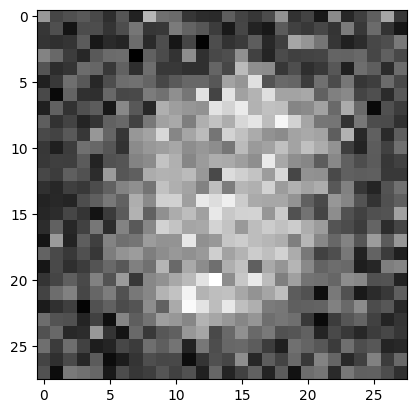

Ploting:  5


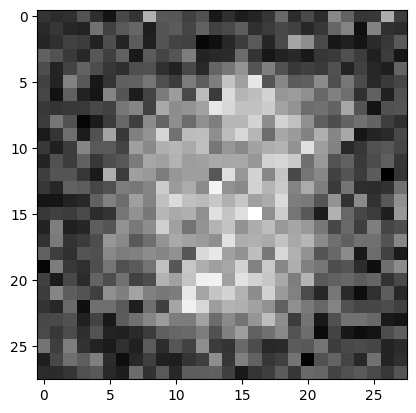

Ploting:  8


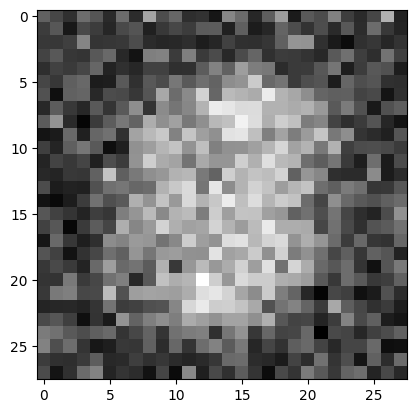

Epoch: 21550
loss_g: 4.374886512756348 	loss_d: 0.044340696185827255
Epoch: 21600
loss_g: 4.252956867218018 	loss_d: 0.04144332930445671
Epoch: 21650
loss_g: 4.3352813720703125 	loss_d: 0.05470499023795128
Epoch: 21700
loss_g: 4.258829116821289 	loss_d: 0.05128288269042969
Epoch: 21750
loss_g: 4.215142250061035 	loss_d: 0.04156896471977234
Epoch: 21800
loss_g: 4.265990734100342 	loss_d: 0.05041546747088432
Epoch: 21850
loss_g: 4.307834148406982 	loss_d: 0.05214314162731171
Epoch: 21900
loss_g: 4.163201332092285 	loss_d: 0.04890900477766991
Epoch: 21950
loss_g: 4.147299289703369 	loss_d: 0.0467439703643322
Epoch: 22000
loss_g: 4.289923191070557 	loss_d: 0.05148487910628319
Ploting:  7


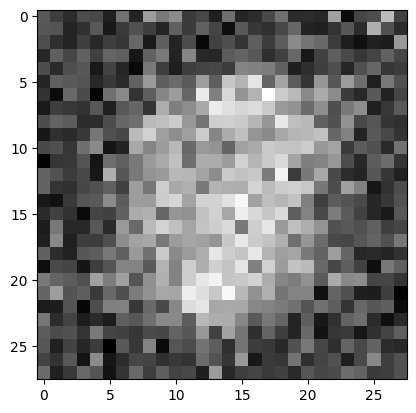

Ploting:  1


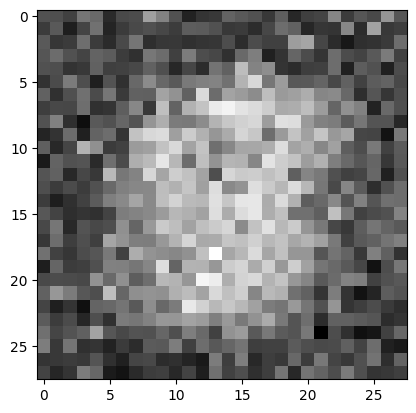

Ploting:  4


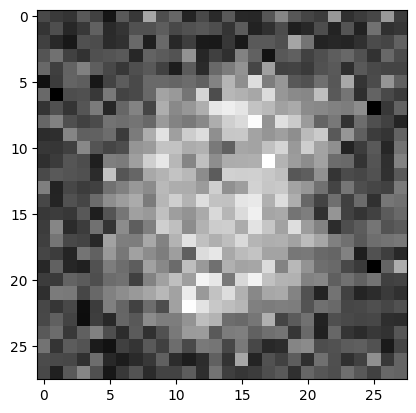

Epoch: 22050
loss_g: 4.304732799530029 	loss_d: 0.05742696300148964
Epoch: 22100
loss_g: 4.098893165588379 	loss_d: 0.048511698842048645
Epoch: 22150
loss_g: 4.2243781089782715 	loss_d: 0.0496489517390728
Epoch: 22200
loss_g: 4.15867805480957 	loss_d: 0.038538627326488495
Epoch: 22250
loss_g: 4.242753028869629 	loss_d: 0.04340582713484764
Epoch: 22300
loss_g: 4.311061382293701 	loss_d: 0.06169280782341957
Epoch: 22350
loss_g: 4.10723876953125 	loss_d: 0.04934030398726463
Epoch: 22400
loss_g: 4.216440677642822 	loss_d: 0.05259595438838005
Epoch: 22450
loss_g: 4.194983005523682 	loss_d: 0.04715487360954285
Epoch: 22500
loss_g: 4.211257457733154 	loss_d: 0.04466204717755318
Ploting:  0


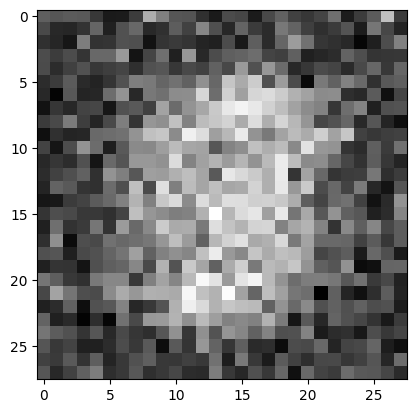

Ploting:  2


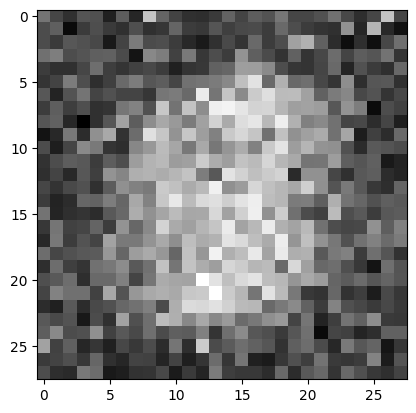

Ploting:  2


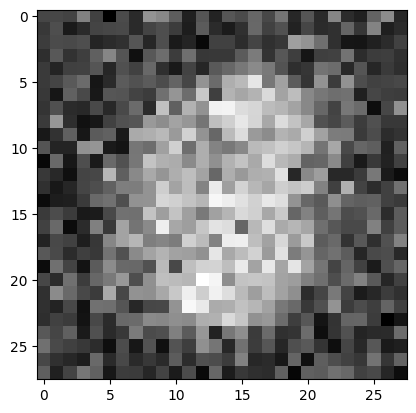

Epoch: 22550
loss_g: 4.248163223266602 	loss_d: 0.05116995796561241
Epoch: 22600
loss_g: 4.3571391105651855 	loss_d: 0.04290285333991051
Epoch: 22650
loss_g: 4.165632724761963 	loss_d: 0.0484691858291626
Epoch: 22700
loss_g: 4.273745536804199 	loss_d: 0.04400885850191116
Epoch: 22750
loss_g: 4.344419002532959 	loss_d: 0.06025344878435135
Epoch: 22800
loss_g: 4.171703338623047 	loss_d: 0.048060111701488495
Epoch: 22850
loss_g: 4.191601276397705 	loss_d: 0.05538488179445267
Epoch: 22900
loss_g: 4.26863431930542 	loss_d: 0.058279313147068024
Epoch: 22950
loss_g: 4.256715774536133 	loss_d: 0.05203055217862129
Epoch: 23000
loss_g: 4.160712718963623 	loss_d: 0.048882778733968735
Ploting:  2


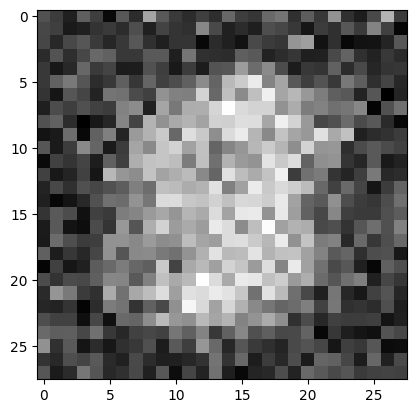

Ploting:  4


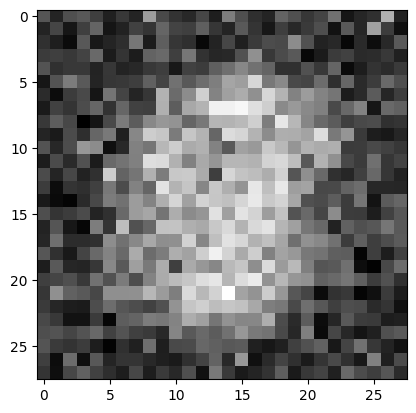

Ploting:  4


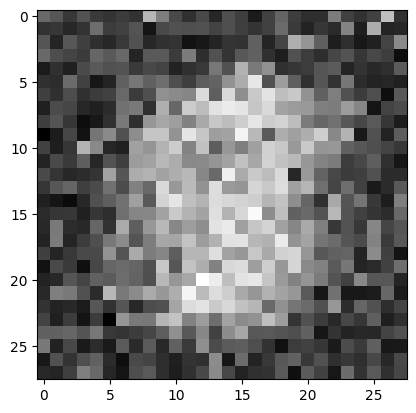

Epoch: 23050
loss_g: 4.27665376663208 	loss_d: 0.05418809875845909
Epoch: 23100
loss_g: 4.2461838722229 	loss_d: 0.048392415046691895
Epoch: 23150
loss_g: 4.182559490203857 	loss_d: 0.04886047914624214
Epoch: 23200
loss_g: 4.145458698272705 	loss_d: 0.04880490526556969
Epoch: 23250
loss_g: 4.14756441116333 	loss_d: 0.05929262191057205
Epoch: 23300
loss_g: 4.0814127922058105 	loss_d: 0.0594160221517086
Epoch: 23350
loss_g: 4.190246105194092 	loss_d: 0.05325886607170105
Epoch: 23400
loss_g: 4.06640625 	loss_d: 0.043244436383247375
Epoch: 23450
loss_g: 4.175188064575195 	loss_d: 0.05578351765871048
Epoch: 23500
loss_g: 4.302864074707031 	loss_d: 0.04979933798313141
Ploting:  5


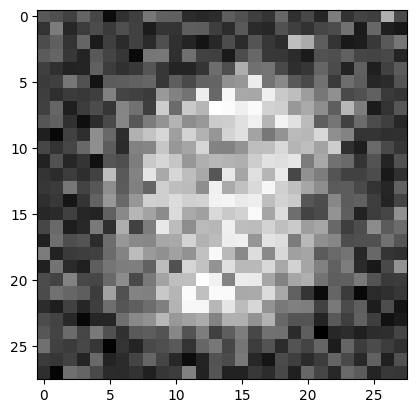

Ploting:  1


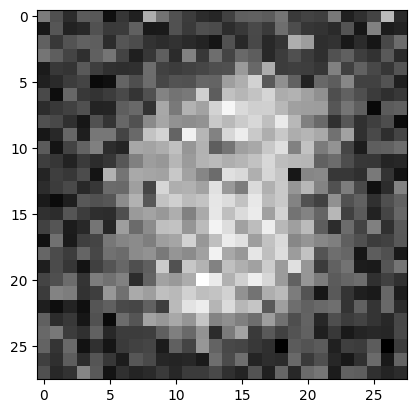

Ploting:  5


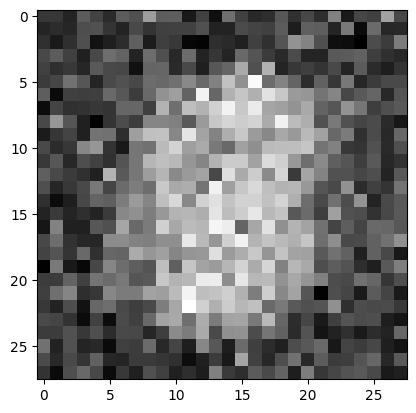

Epoch: 23550
loss_g: 4.114353179931641 	loss_d: 0.05518091097474098
Epoch: 23600
loss_g: 4.148524761199951 	loss_d: 0.07118146121501923
Epoch: 23650
loss_g: 4.268668174743652 	loss_d: 0.06820575147867203
Epoch: 23700
loss_g: 4.246520042419434 	loss_d: 0.05692300200462341
Epoch: 23750
loss_g: 4.197004795074463 	loss_d: 0.05530557036399841
Epoch: 23800
loss_g: 4.113799571990967 	loss_d: 0.053653888404369354
Epoch: 23850
loss_g: 4.079923629760742 	loss_d: 0.06145743653178215
Epoch: 23900
loss_g: 4.134068489074707 	loss_d: 0.04830801859498024
Epoch: 23950
loss_g: 4.1753764152526855 	loss_d: 0.055479202419519424
Epoch: 24000
loss_g: 3.9723424911499023 	loss_d: 0.053938791155815125
Ploting:  0


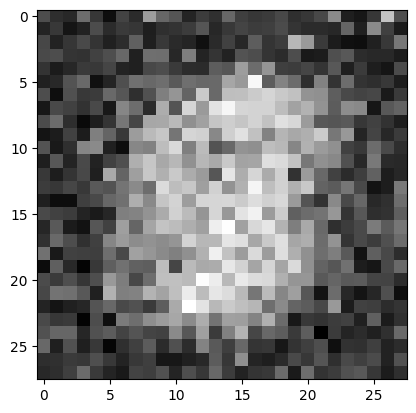

Ploting:  5


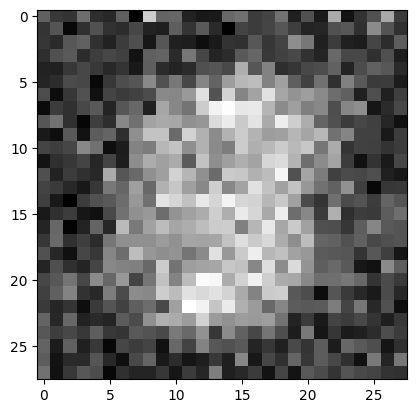

Ploting:  5


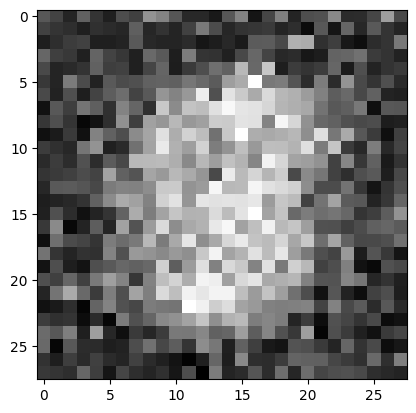

Epoch: 24050
loss_g: 4.263476848602295 	loss_d: 0.07128430157899857
Epoch: 24100
loss_g: 4.065392971038818 	loss_d: 0.06379195302724838
Epoch: 24150
loss_g: 4.049165725708008 	loss_d: 0.05203470587730408
Epoch: 24200
loss_g: 3.994889974594116 	loss_d: 0.0661693587899208
Epoch: 24250
loss_g: 4.134820938110352 	loss_d: 0.0681934729218483
Epoch: 24300
loss_g: 4.105615139007568 	loss_d: 0.057010192424058914
Epoch: 24350
loss_g: 4.027940273284912 	loss_d: 0.06297346204519272
Epoch: 24400
loss_g: 4.052715301513672 	loss_d: 0.07216469943523407
Epoch: 24450
loss_g: 4.069036960601807 	loss_d: 0.0721573755145073
Epoch: 24500
loss_g: 4.04346227645874 	loss_d: 0.06568766385316849
Ploting:  9


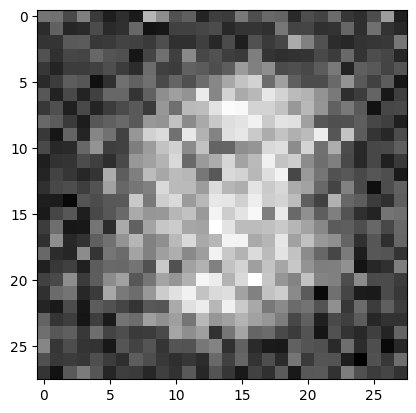

Ploting:  2


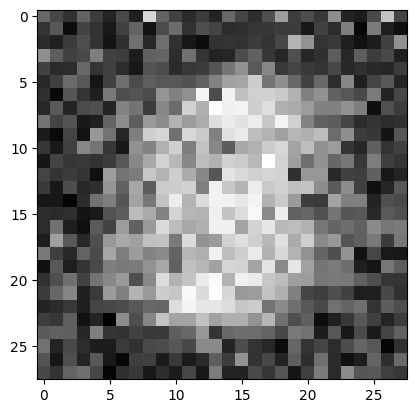

Ploting:  2


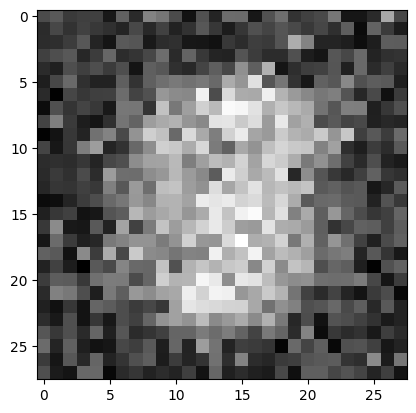

Epoch: 24550
loss_g: 4.018826007843018 	loss_d: 0.060203827917575836
Epoch: 24600
loss_g: 4.205430030822754 	loss_d: 0.04903221130371094
Epoch: 24650
loss_g: 3.954146146774292 	loss_d: 0.05269300192594528
Epoch: 24700
loss_g: 4.093169689178467 	loss_d: 0.0799119621515274
Epoch: 24750
loss_g: 4.095505237579346 	loss_d: 0.07112710922956467
Epoch: 24800
loss_g: 3.963388681411743 	loss_d: 0.07446295768022537
Epoch: 24850
loss_g: 3.910778045654297 	loss_d: 0.0644347220659256
Epoch: 24900
loss_g: 4.06434965133667 	loss_d: 0.05803188309073448
Epoch: 24950
loss_g: 4.014647960662842 	loss_d: 0.06398312002420425
Epoch: 25000
loss_g: 3.9124226570129395 	loss_d: 0.05726097524166107
Ploting:  2


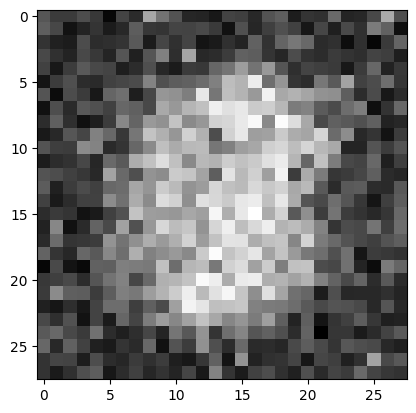

Ploting:  7


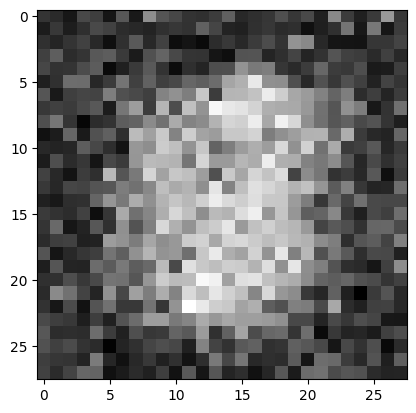

Ploting:  3


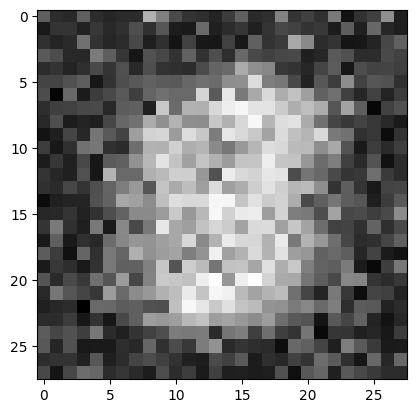

Epoch: 25050
loss_g: 3.9490039348602295 	loss_d: 0.06504426151514053
Epoch: 25100
loss_g: 3.9233558177948 	loss_d: 0.057248763740062714
Epoch: 25150
loss_g: 3.9846136569976807 	loss_d: 0.07871028035879135
Epoch: 25200
loss_g: 3.9084460735321045 	loss_d: 0.07033777236938477
Epoch: 25250
loss_g: 3.9615087509155273 	loss_d: 0.06789222359657288
Epoch: 25300
loss_g: 4.008604526519775 	loss_d: 0.073520727455616
Epoch: 25350
loss_g: 4.13789701461792 	loss_d: 0.07683487981557846
Epoch: 25400
loss_g: 3.9310176372528076 	loss_d: 0.06454157829284668
Epoch: 25450
loss_g: 3.912149667739868 	loss_d: 0.07596196234226227
Epoch: 25500
loss_g: 3.8257687091827393 	loss_d: 0.06665334850549698
Ploting:  3


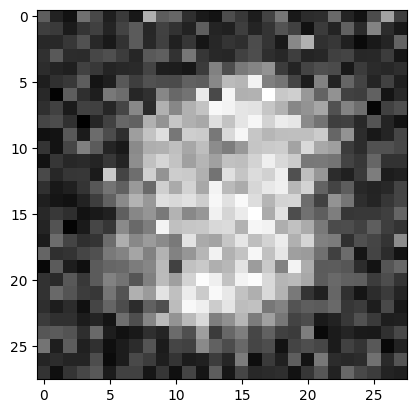

Ploting:  7


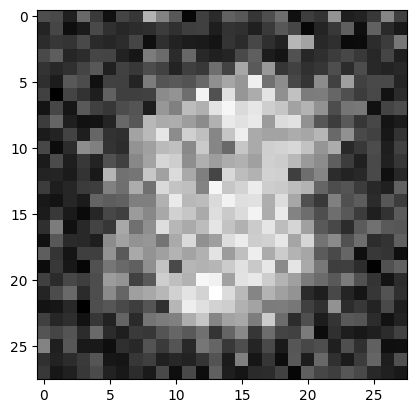

Ploting:  4


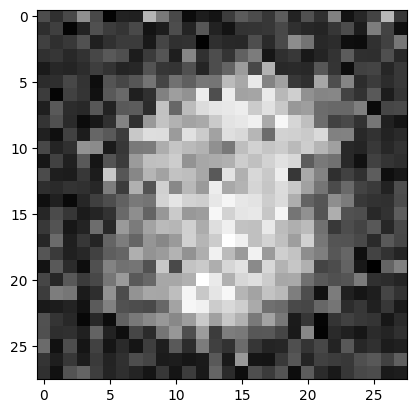

Epoch: 25550
loss_g: 3.897311210632324 	loss_d: 0.07014483213424683
Epoch: 25600
loss_g: 4.034572601318359 	loss_d: 0.06610546261072159
Epoch: 25650
loss_g: 3.902104616165161 	loss_d: 0.08736787736415863
Epoch: 25700
loss_g: 3.9368879795074463 	loss_d: 0.0838557630777359
Epoch: 25750
loss_g: 4.010796546936035 	loss_d: 0.0748930498957634
Epoch: 25800
loss_g: 3.890958070755005 	loss_d: 0.06464775651693344
Epoch: 25850
loss_g: 3.8614580631256104 	loss_d: 0.07393436133861542
Epoch: 25900
loss_g: 3.9420127868652344 	loss_d: 0.07042500376701355
Epoch: 25950
loss_g: 3.812502861022949 	loss_d: 0.0873195081949234
Epoch: 26000
loss_g: 3.855849504470825 	loss_d: 0.10773269087076187
Ploting:  4


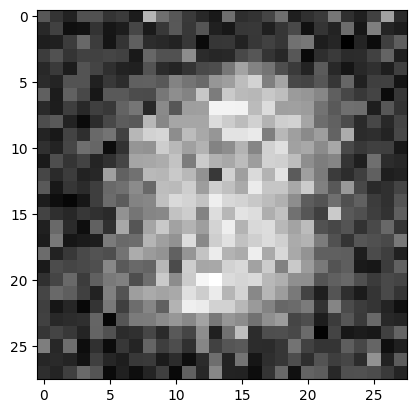

Ploting:  1


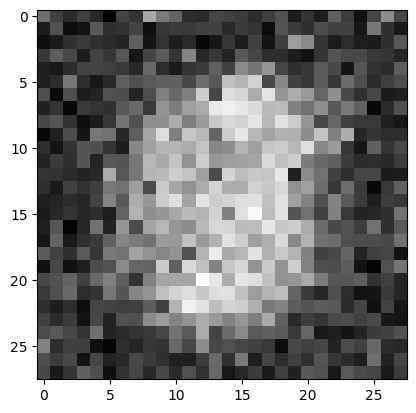

Ploting:  0


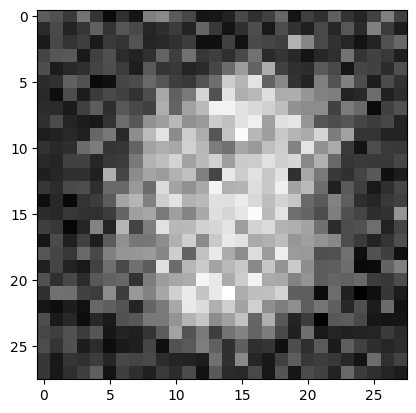

Epoch: 26050
loss_g: 3.899664878845215 	loss_d: 0.10087212920188904
Epoch: 26100
loss_g: 3.9192376136779785 	loss_d: 0.07292373478412628
Epoch: 26150
loss_g: 3.936138153076172 	loss_d: 0.07924716919660568
Epoch: 26200
loss_g: 3.905503988265991 	loss_d: 0.07157059013843536
Epoch: 26250
loss_g: 3.9359867572784424 	loss_d: 0.08833490312099457
Epoch: 26300
loss_g: 3.7842462062835693 	loss_d: 0.06601365655660629
Epoch: 26350
loss_g: 3.977307081222534 	loss_d: 0.08161702752113342
Epoch: 26400
loss_g: 3.711134195327759 	loss_d: 0.07922572642564774
Epoch: 26450
loss_g: 3.6876561641693115 	loss_d: 0.09818097949028015
Epoch: 26500
loss_g: 3.8163630962371826 	loss_d: 0.10031814128160477
Ploting:  0


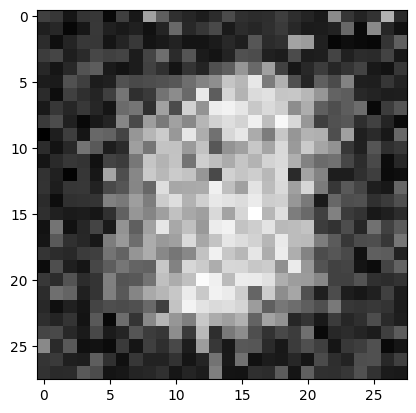

Ploting:  1


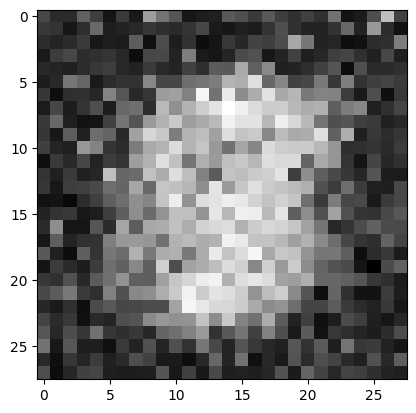

Ploting:  7


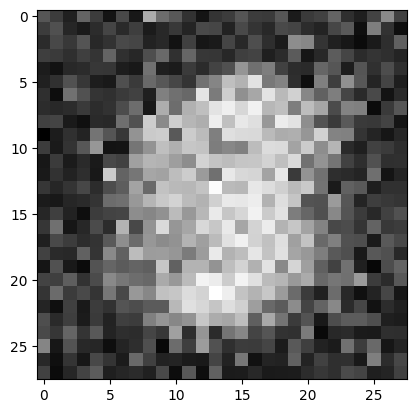

Epoch: 26550
loss_g: 3.732562780380249 	loss_d: 0.07346048206090927
Epoch: 26600
loss_g: 3.890353202819824 	loss_d: 0.0952623188495636
Epoch: 26650
loss_g: 3.793358087539673 	loss_d: 0.08883080631494522
Epoch: 26700
loss_g: 3.907334089279175 	loss_d: 0.0899946466088295
Epoch: 26750
loss_g: 3.740523099899292 	loss_d: 0.0938885509967804
Epoch: 26800
loss_g: 3.7598161697387695 	loss_d: 0.09764689207077026
Epoch: 26850
loss_g: 3.83138108253479 	loss_d: 0.10266460478305817
Epoch: 26900
loss_g: 3.896294355392456 	loss_d: 0.09350917488336563
Epoch: 26950
loss_g: 3.9468913078308105 	loss_d: 0.09998778998851776
Epoch: 27000
loss_g: 3.839977979660034 	loss_d: 0.06875365972518921
Ploting:  0


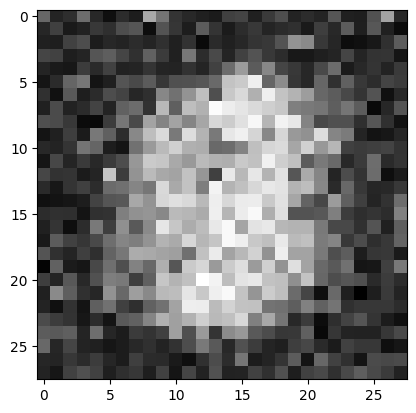

Ploting:  9


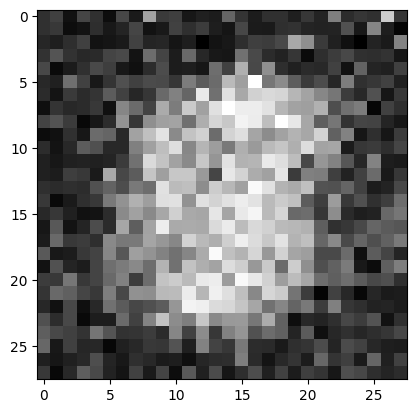

Ploting:  0


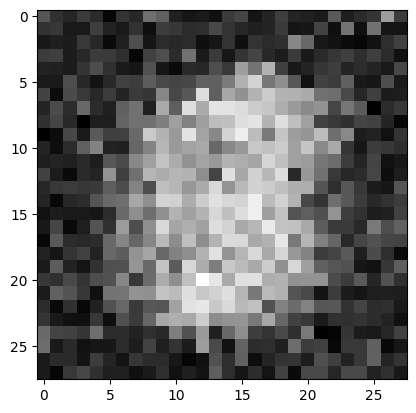

Epoch: 27050
loss_g: 3.6788463592529297 	loss_d: 0.08233802020549774
Epoch: 27100
loss_g: 3.7355644702911377 	loss_d: 0.1096532866358757
Epoch: 27150
loss_g: 3.7747435569763184 	loss_d: 0.09280190616846085
Epoch: 27200
loss_g: 3.80047869682312 	loss_d: 0.10614451766014099
Epoch: 27250
loss_g: 3.675150156021118 	loss_d: 0.08902832120656967
Epoch: 27300
loss_g: 3.6366283893585205 	loss_d: 0.0899960845708847
Epoch: 27350
loss_g: 3.7479634284973145 	loss_d: 0.09390711784362793
Epoch: 27400
loss_g: 3.6506361961364746 	loss_d: 0.07970760762691498
Epoch: 27450
loss_g: 3.829192638397217 	loss_d: 0.09734092652797699
Epoch: 27500
loss_g: 3.672443151473999 	loss_d: 0.08668447285890579
Ploting:  4


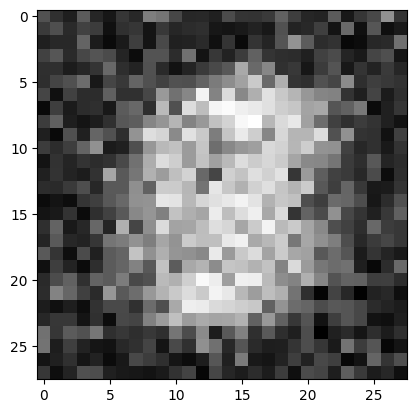

Ploting:  0


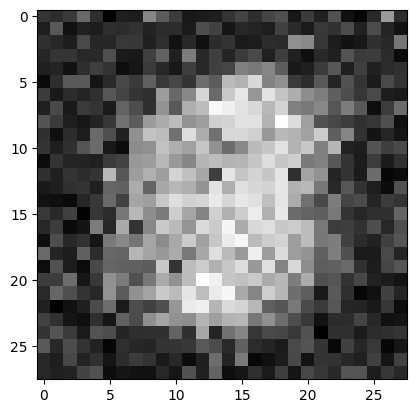

Ploting:  5


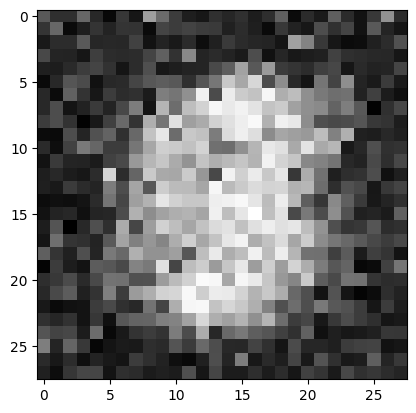

Epoch: 27550
loss_g: 3.769294261932373 	loss_d: 0.1162998378276825
Epoch: 27600
loss_g: 3.6084086894989014 	loss_d: 0.09113519638776779
Epoch: 27650
loss_g: 3.640489339828491 	loss_d: 0.09704595059156418
Epoch: 27700
loss_g: 3.746187448501587 	loss_d: 0.11079485714435577
Epoch: 27750
loss_g: 3.6726574897766113 	loss_d: 0.11633570492267609
Epoch: 27800
loss_g: 3.8467912673950195 	loss_d: 0.09511495381593704
Epoch: 27850
loss_g: 3.6504030227661133 	loss_d: 0.11575339734554291
Epoch: 27900
loss_g: 3.685696840286255 	loss_d: 0.1064789816737175
Epoch: 27950
loss_g: 3.6487724781036377 	loss_d: 0.10263035446405411
Epoch: 28000
loss_g: 3.7027595043182373 	loss_d: 0.10853070020675659
Ploting:  3


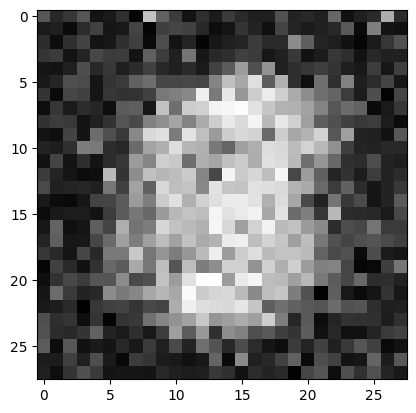

Ploting:  2


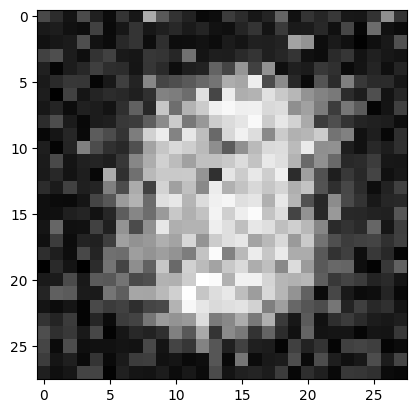

Ploting:  9


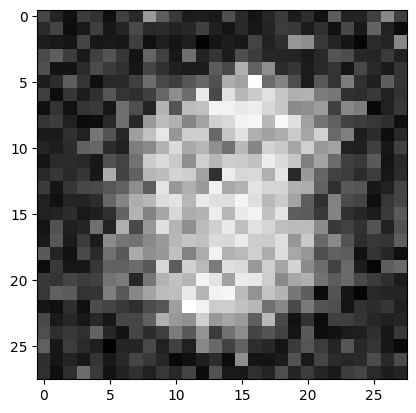

Epoch: 28050
loss_g: 3.6504225730895996 	loss_d: 0.1230463758111
Epoch: 28100
loss_g: 3.5351643562316895 	loss_d: 0.12732256948947906
Epoch: 28150
loss_g: 3.847667694091797 	loss_d: 0.12142693251371384
Epoch: 28200
loss_g: 3.603128671646118 	loss_d: 0.09625262767076492
Epoch: 28250
loss_g: 3.706087589263916 	loss_d: 0.1081928238272667
Epoch: 28300
loss_g: 3.6993932723999023 	loss_d: 0.10931210964918137
Epoch: 28350
loss_g: 3.682957649230957 	loss_d: 0.12270264327526093
Epoch: 28400
loss_g: 3.5356438159942627 	loss_d: 0.1521168202161789
Epoch: 28450
loss_g: 3.538039445877075 	loss_d: 0.1456286907196045
Epoch: 28500
loss_g: 3.65026593208313 	loss_d: 0.107467420399189
Ploting:  6


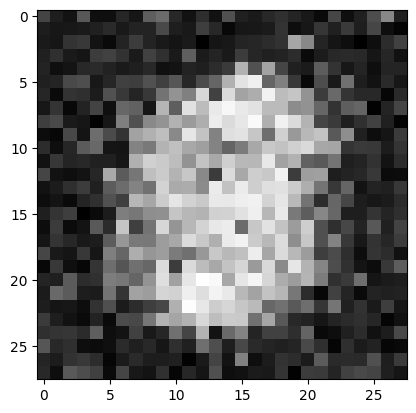

Ploting:  2


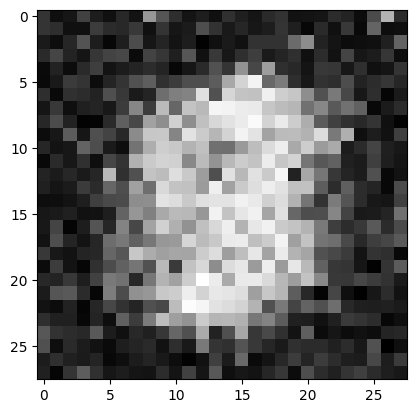

Ploting:  2


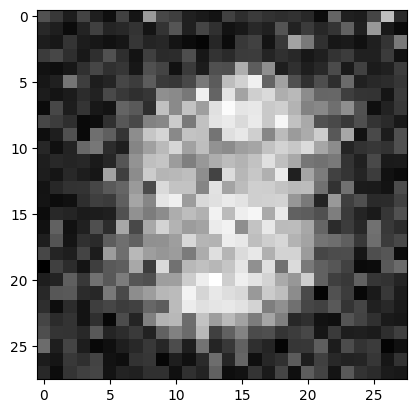

Epoch: 28550
loss_g: 3.6184518337249756 	loss_d: 0.11520931124687195
Epoch: 28600
loss_g: 3.6331639289855957 	loss_d: 0.10997984558343887
Epoch: 28650
loss_g: 3.6601006984710693 	loss_d: 0.1309068202972412
Epoch: 28700
loss_g: 3.613010883331299 	loss_d: 0.10927320271730423
Epoch: 28750
loss_g: 3.4477930068969727 	loss_d: 0.1261414736509323
Epoch: 28800
loss_g: 3.5928280353546143 	loss_d: 0.1226249486207962
Epoch: 28850
loss_g: 3.506012439727783 	loss_d: 0.14904378354549408
Epoch: 28900
loss_g: 3.504955768585205 	loss_d: 0.13468657433986664
Epoch: 28950
loss_g: 3.6545519828796387 	loss_d: 0.10894996672868729
Epoch: 29000
loss_g: 3.4312660694122314 	loss_d: 0.13493889570236206
Ploting:  4


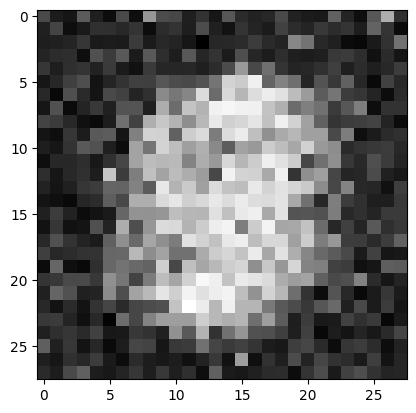

Ploting:  9


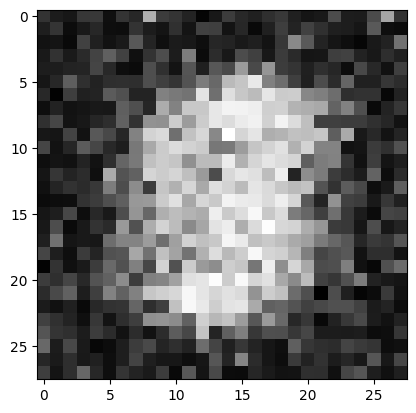

Ploting:  7


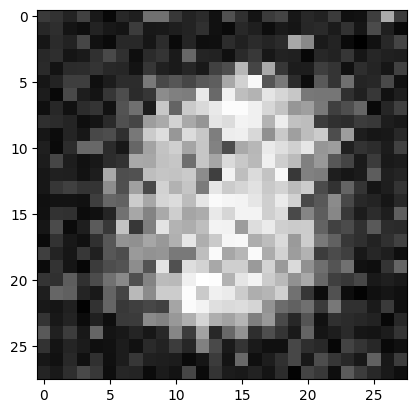

Epoch: 29050
loss_g: 3.4185194969177246 	loss_d: 0.13444042205810547
Epoch: 29100
loss_g: 3.280815601348877 	loss_d: 0.13227279484272003
Epoch: 29150
loss_g: 3.4735589027404785 	loss_d: 0.14950047433376312
Epoch: 29200
loss_g: 3.5018272399902344 	loss_d: 0.14417940378189087
Epoch: 29250
loss_g: 3.4634153842926025 	loss_d: 0.1439506858587265
Epoch: 29300
loss_g: 3.3694047927856445 	loss_d: 0.1391446590423584
Epoch: 29350
loss_g: 3.4286608695983887 	loss_d: 0.13683420419692993
Epoch: 29400
loss_g: 3.5559370517730713 	loss_d: 0.11125324666500092
Epoch: 29450
loss_g: 3.3416154384613037 	loss_d: 0.11836662888526917
Epoch: 29500
loss_g: 3.4457027912139893 	loss_d: 0.1668511927127838
Ploting:  1


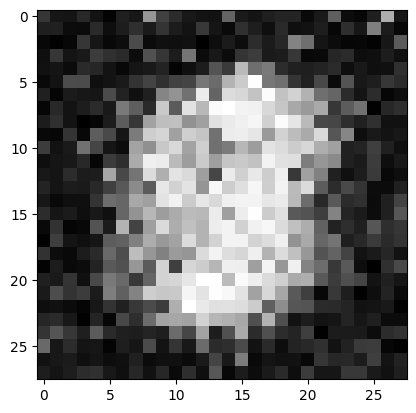

Ploting:  9


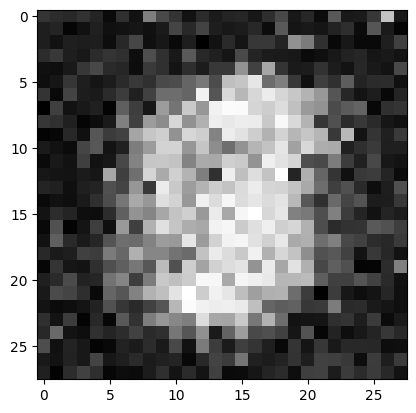

Ploting:  5


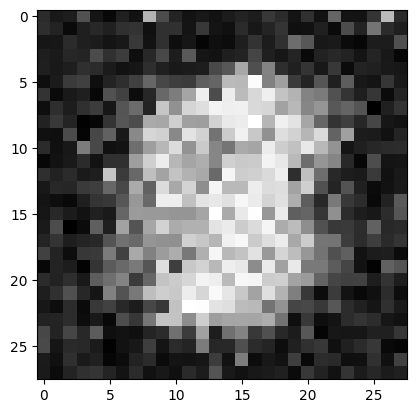

Epoch: 29550
loss_g: 3.3795440196990967 	loss_d: 0.14479108154773712
Epoch: 29600
loss_g: 3.4205539226531982 	loss_d: 0.1443583220243454
Epoch: 29650
loss_g: 3.464528799057007 	loss_d: 0.12987637519836426
Epoch: 29700
loss_g: 3.3717591762542725 	loss_d: 0.1342237889766693
Epoch: 29750
loss_g: 3.4480950832366943 	loss_d: 0.14072519540786743
Epoch: 29800
loss_g: 3.3887712955474854 	loss_d: 0.1288001835346222
Epoch: 29850
loss_g: 3.2958147525787354 	loss_d: 0.1485232263803482
Epoch: 29900
loss_g: 3.370861768722534 	loss_d: 0.13596111536026
Epoch: 29950
loss_g: 3.395033121109009 	loss_d: 0.16726897656917572
Epoch: 30000
loss_g: 3.462228298187256 	loss_d: 0.14514192938804626
Ploting:  0


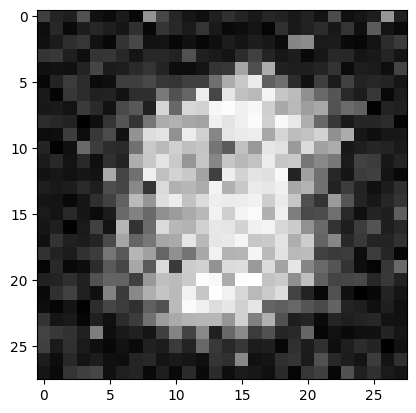

Ploting:  0


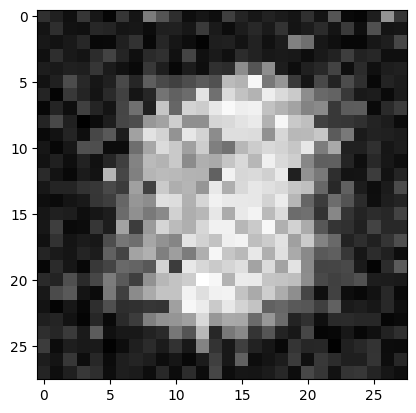

Ploting:  1


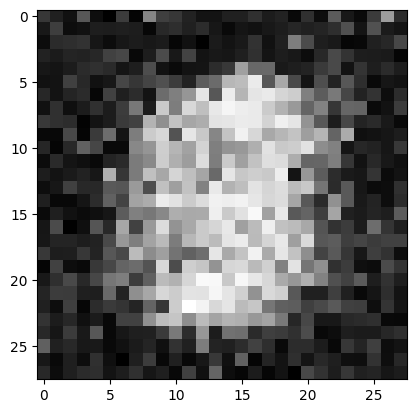

Epoch: 30050
loss_g: 3.3103280067443848 	loss_d: 0.15174312889575958
Epoch: 30100
loss_g: 3.2246487140655518 	loss_d: 0.160058856010437
Epoch: 30150
loss_g: 3.336094856262207 	loss_d: 0.16600821912288666
Epoch: 30200
loss_g: 3.2693939208984375 	loss_d: 0.15544959902763367
Epoch: 30250
loss_g: 3.235727071762085 	loss_d: 0.15439902245998383
Epoch: 30300
loss_g: 3.10964298248291 	loss_d: 0.14490586519241333
Epoch: 30350
loss_g: 3.343546152114868 	loss_d: 0.15012410283088684
Epoch: 30400
loss_g: 3.178957223892212 	loss_d: 0.14931662380695343
Epoch: 30450
loss_g: 3.294546365737915 	loss_d: 0.17874214053153992
Epoch: 30500
loss_g: 3.302732467651367 	loss_d: 0.19526271522045135
Ploting:  7


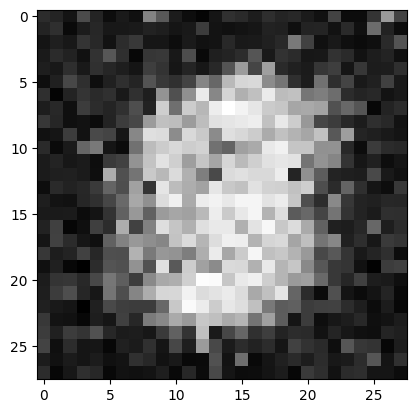

Ploting:  5


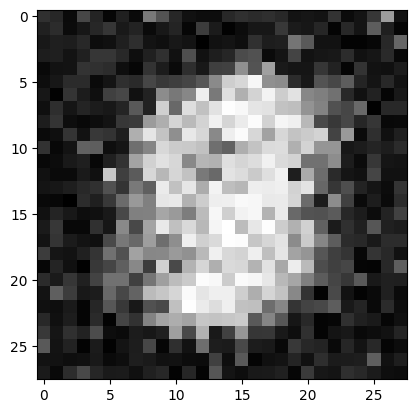

Ploting:  8


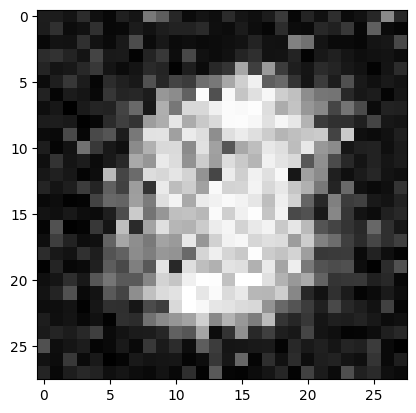

Epoch: 30550
loss_g: 3.2370522022247314 	loss_d: 0.17555518448352814
Epoch: 30600
loss_g: 3.337078809738159 	loss_d: 0.14098189771175385
Epoch: 30650
loss_g: 3.254682779312134 	loss_d: 0.16350728273391724
Epoch: 30700
loss_g: 3.133148670196533 	loss_d: 0.15229976177215576
Epoch: 30750
loss_g: 3.25589656829834 	loss_d: 0.18999886512756348
Epoch: 30800
loss_g: 3.302781820297241 	loss_d: 0.21577094495296478
Epoch: 30850
loss_g: 3.2692253589630127 	loss_d: 0.20133692026138306
Epoch: 30900
loss_g: 3.2333898544311523 	loss_d: 0.15809087455272675
Epoch: 30950
loss_g: 3.1518495082855225 	loss_d: 0.16051051020622253
Epoch: 31000
loss_g: 3.2346153259277344 	loss_d: 0.1674230545759201
Ploting:  1


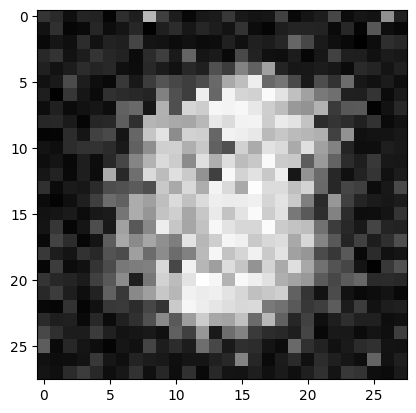

Ploting:  2


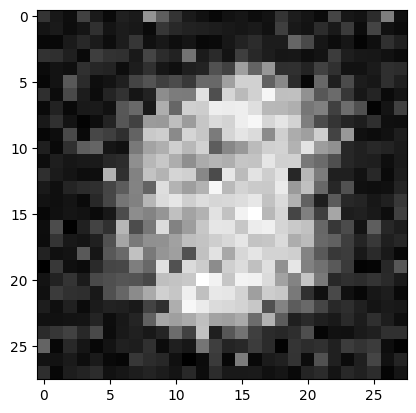

Ploting:  9


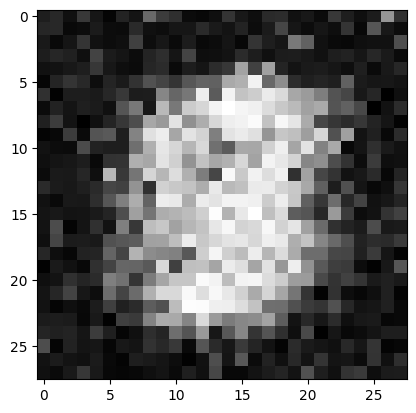

Epoch: 31050
loss_g: 3.2636349201202393 	loss_d: 0.19235599040985107
Epoch: 31100
loss_g: 3.2155613899230957 	loss_d: 0.1555916965007782
Epoch: 31150
loss_g: 3.0600414276123047 	loss_d: 0.18887554109096527
Epoch: 31200
loss_g: 3.0614864826202393 	loss_d: 0.17412430047988892
Epoch: 31250
loss_g: 3.2176668643951416 	loss_d: 0.20845407247543335
Epoch: 31300
loss_g: 3.096099376678467 	loss_d: 0.19914941489696503
Epoch: 31350
loss_g: 3.2889797687530518 	loss_d: 0.15820714831352234
Epoch: 31400
loss_g: 3.263190507888794 	loss_d: 0.19539454579353333
Epoch: 31450
loss_g: 3.103811025619507 	loss_d: 0.18998833000659943
Epoch: 31500
loss_g: 3.133647918701172 	loss_d: 0.1895172894001007
Ploting:  0


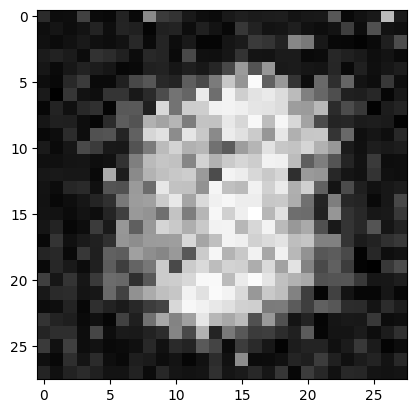

Ploting:  2


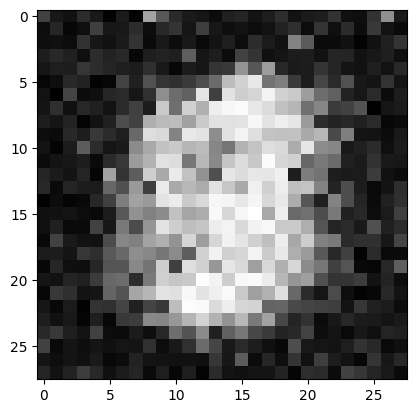

Ploting:  4


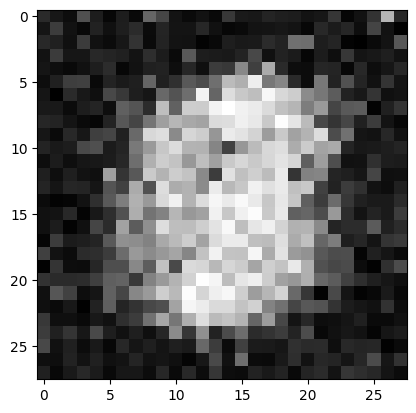

Epoch: 31550
loss_g: 3.197382688522339 	loss_d: 0.20050160586833954
Epoch: 31600
loss_g: 3.154613971710205 	loss_d: 0.2005157172679901
Epoch: 31650
loss_g: 3.093515157699585 	loss_d: 0.21669679880142212
Epoch: 31700
loss_g: 3.1435961723327637 	loss_d: 0.20797717571258545
Epoch: 31750
loss_g: 3.0496275424957275 	loss_d: 0.2008362114429474
Epoch: 31800
loss_g: 3.028468608856201 	loss_d: 0.15605342388153076
Epoch: 31850
loss_g: 3.040571451187134 	loss_d: 0.172429159283638
Epoch: 31900
loss_g: 2.966296911239624 	loss_d: 0.22985951602458954
Epoch: 31950
loss_g: 3.097562551498413 	loss_d: 0.20365001261234283
Epoch: 32000
loss_g: 3.0371429920196533 	loss_d: 0.21275010704994202
Ploting:  3


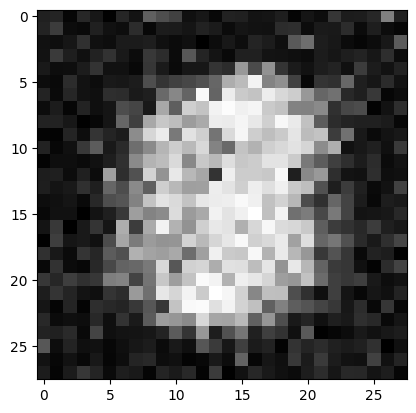

Ploting:  0


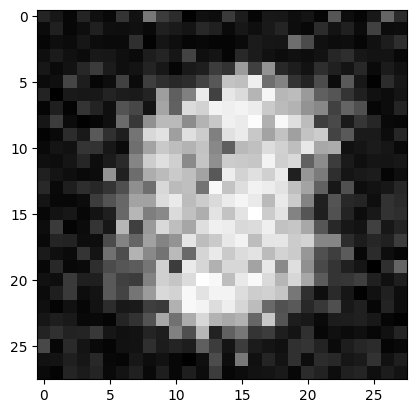

Ploting:  1


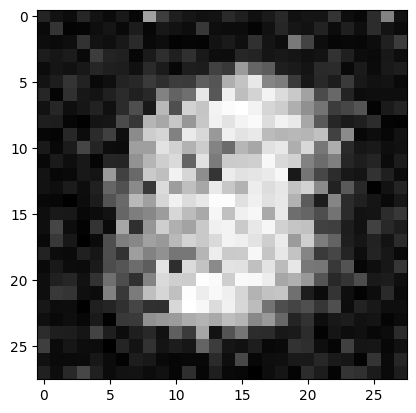

Epoch: 32050
loss_g: 3.1194963455200195 	loss_d: 0.19042328000068665
Epoch: 32100
loss_g: 3.010146379470825 	loss_d: 0.20264114439487457
Epoch: 32150
loss_g: 2.9181437492370605 	loss_d: 0.20720866322517395
Epoch: 32200
loss_g: 2.9298033714294434 	loss_d: 0.18708160519599915
Epoch: 32250
loss_g: 3.0263028144836426 	loss_d: 0.20305998623371124
Epoch: 32300
loss_g: 3.054231882095337 	loss_d: 0.19549182057380676
Epoch: 32350
loss_g: 3.0006444454193115 	loss_d: 0.24145427346229553
Epoch: 32400
loss_g: 2.9147143363952637 	loss_d: 0.20077821612358093
Epoch: 32450
loss_g: 3.016461133956909 	loss_d: 0.213780015707016
Epoch: 32500
loss_g: 3.0395288467407227 	loss_d: 0.2152816653251648
Ploting:  9


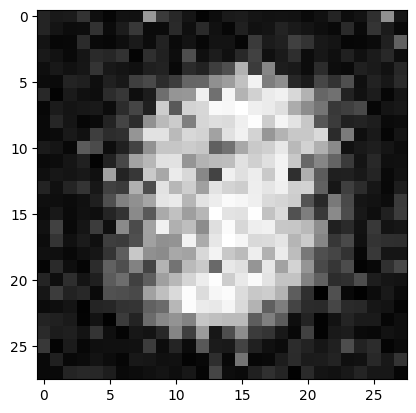

Ploting:  1


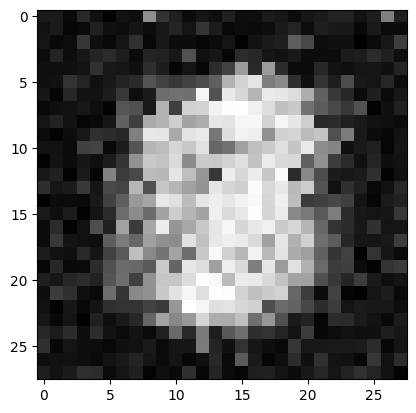

Ploting:  7


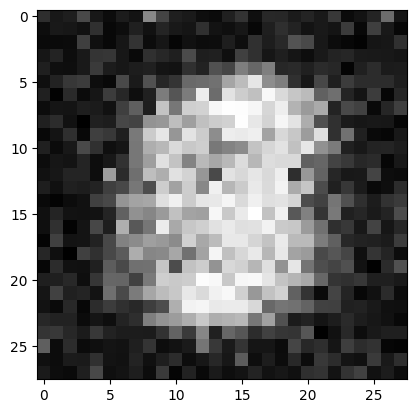

Epoch: 32550
loss_g: 2.953244924545288 	loss_d: 0.23899821937084198
Epoch: 32600
loss_g: 3.0601768493652344 	loss_d: 0.2073783427476883
Epoch: 32650
loss_g: 2.931264877319336 	loss_d: 0.20805592834949493
Epoch: 32700
loss_g: 2.871976137161255 	loss_d: 0.21487821638584137
Epoch: 32750
loss_g: 2.9175055027008057 	loss_d: 0.20624114573001862
Epoch: 32800
loss_g: 2.8484437465667725 	loss_d: 0.21434637904167175
Epoch: 32850
loss_g: 2.901540994644165 	loss_d: 0.25382018089294434
Epoch: 32900
loss_g: 2.8635902404785156 	loss_d: 0.2566392421722412
Epoch: 32950
loss_g: 2.9509758949279785 	loss_d: 0.25759002566337585
Epoch: 33000
loss_g: 2.8703601360321045 	loss_d: 0.2147325724363327
Ploting:  6


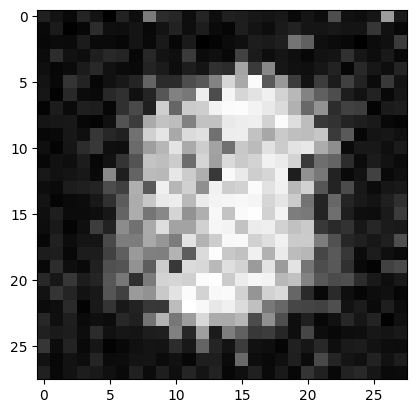

Ploting:  5


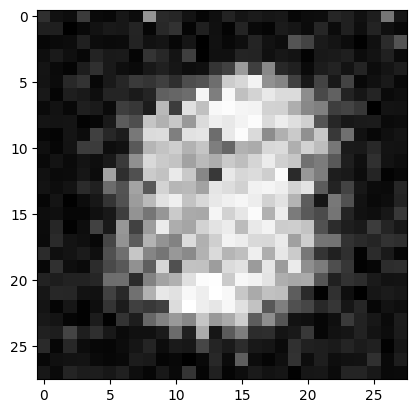

Ploting:  1


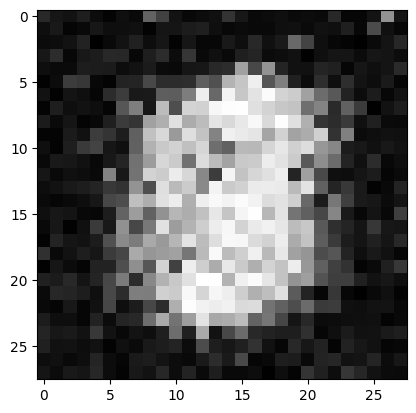

Epoch: 33050
loss_g: 2.8671531677246094 	loss_d: 0.24135257303714752
Epoch: 33100
loss_g: 2.8422694206237793 	loss_d: 0.2297922521829605
Epoch: 33150
loss_g: 3.0204408168792725 	loss_d: 0.2590618431568146
Epoch: 33200
loss_g: 2.8515069484710693 	loss_d: 0.2921541929244995
Epoch: 33250
loss_g: 2.904754638671875 	loss_d: 0.2744978666305542
Epoch: 33300
loss_g: 3.0667271614074707 	loss_d: 0.22050216794013977
Epoch: 33350
loss_g: 2.933467388153076 	loss_d: 0.22488902509212494
Epoch: 33400
loss_g: 2.86238694190979 	loss_d: 0.22451750934123993
Epoch: 33450
loss_g: 2.893254280090332 	loss_d: 0.2591451108455658
Epoch: 33500
loss_g: 2.772634267807007 	loss_d: 0.21311694383621216
Ploting:  7


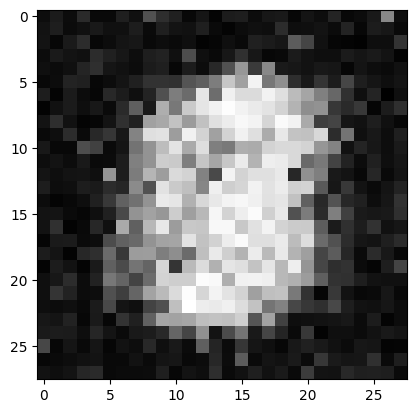

Ploting:  9


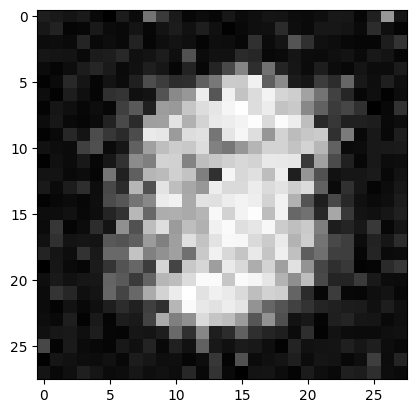

Ploting:  4


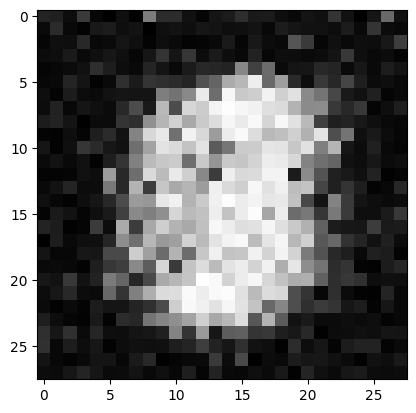

Epoch: 33550
loss_g: 2.8757805824279785 	loss_d: 0.2513394057750702
Epoch: 33600
loss_g: 2.865326166152954 	loss_d: 0.23655012249946594
Epoch: 33650
loss_g: 2.717318296432495 	loss_d: 0.281802773475647
Epoch: 33700
loss_g: 2.802529811859131 	loss_d: 0.26145556569099426
Epoch: 33750
loss_g: 2.770223379135132 	loss_d: 0.21044223010540009
Epoch: 33800
loss_g: 2.7782089710235596 	loss_d: 0.25978153944015503
Epoch: 33850
loss_g: 2.753265619277954 	loss_d: 0.24775825440883636
Epoch: 33900
loss_g: 2.7737810611724854 	loss_d: 0.2482391744852066
Epoch: 33950
loss_g: 2.7706987857818604 	loss_d: 0.26201698184013367
Epoch: 34000
loss_g: 2.6959052085876465 	loss_d: 0.2612168788909912
Ploting:  1


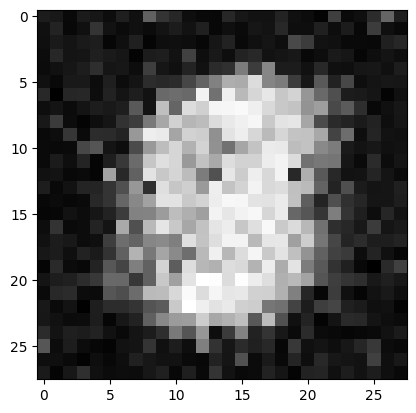

Ploting:  5


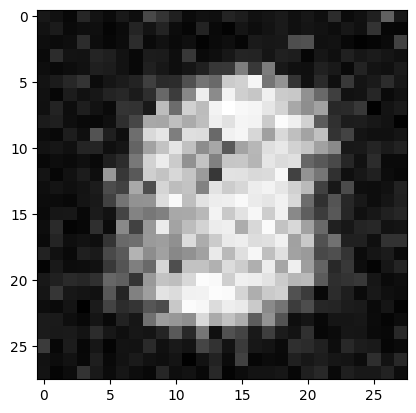

Ploting:  3


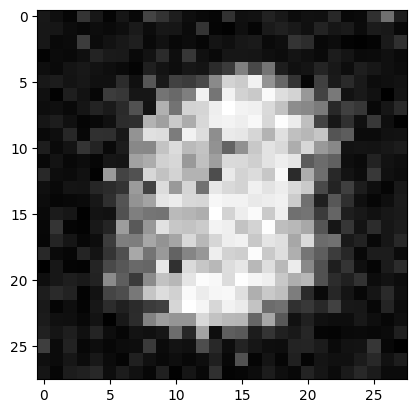

Epoch: 34050
loss_g: 2.8012468814849854 	loss_d: 0.26923561096191406
Epoch: 34100
loss_g: 2.7711100578308105 	loss_d: 0.26610755920410156
Epoch: 34150
loss_g: 2.726982355117798 	loss_d: 0.2570449411869049
Epoch: 34200
loss_g: 2.740861654281616 	loss_d: 0.20201820135116577
Epoch: 34250
loss_g: 2.680182933807373 	loss_d: 0.22441382706165314
Epoch: 34300
loss_g: 2.704909086227417 	loss_d: 0.29493066668510437
Epoch: 34350
loss_g: 2.6533474922180176 	loss_d: 0.25786957144737244
Epoch: 34400
loss_g: 2.7362937927246094 	loss_d: 0.27233946323394775
Epoch: 34450
loss_g: 2.6518619060516357 	loss_d: 0.24699600040912628
Epoch: 34500
loss_g: 2.689037322998047 	loss_d: 0.26664820313453674
Ploting:  5


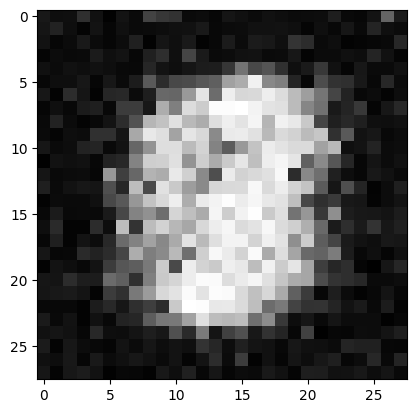

Ploting:  1


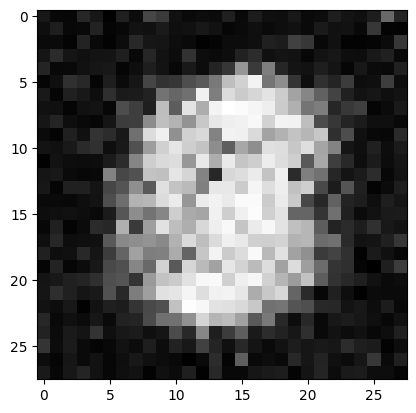

Ploting:  1


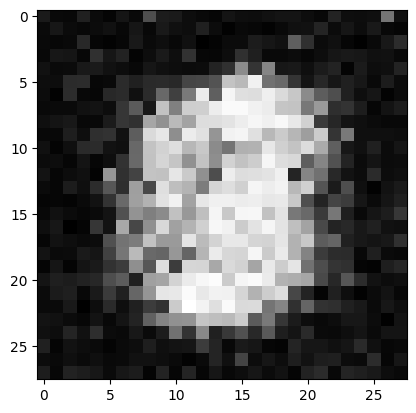

Epoch: 34550
loss_g: 2.776782274246216 	loss_d: 0.2684938609600067
Epoch: 34600
loss_g: 2.8195855617523193 	loss_d: 0.25037726759910583
Epoch: 34650
loss_g: 2.7215843200683594 	loss_d: 0.2708406150341034
Epoch: 34700
loss_g: 2.702317953109741 	loss_d: 0.25260263681411743
Epoch: 34750
loss_g: 2.704813241958618 	loss_d: 0.30575495958328247
Epoch: 34800
loss_g: 2.732166290283203 	loss_d: 0.25528401136398315
Epoch: 34850
loss_g: 2.741577625274658 	loss_d: 0.2723008692264557
Epoch: 34900
loss_g: 2.5759735107421875 	loss_d: 0.27983158826828003
Epoch: 34950
loss_g: 2.6178197860717773 	loss_d: 0.2883593440055847
Epoch: 35000
loss_g: 2.6993494033813477 	loss_d: 0.2612183094024658
Ploting:  7


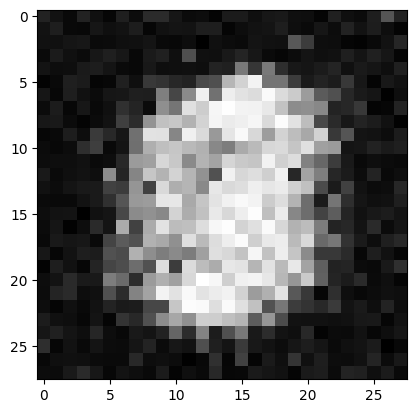

Ploting:  5


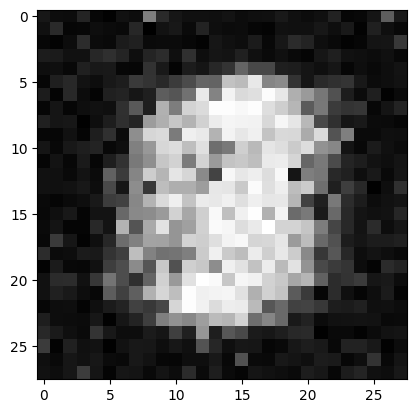

Ploting:  1


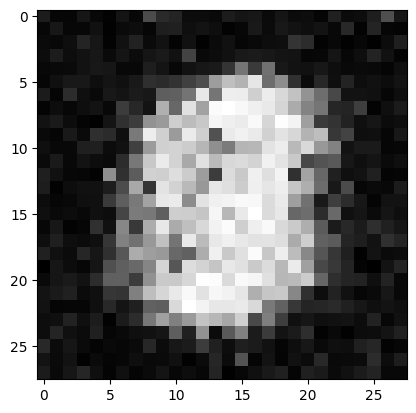

Epoch: 35050
loss_g: 2.5930027961730957 	loss_d: 0.2749656140804291
Epoch: 35100
loss_g: 2.668513536453247 	loss_d: 0.27729538083076477
Epoch: 35150
loss_g: 2.698113441467285 	loss_d: 0.25984254479408264
Epoch: 35200
loss_g: 2.639216184616089 	loss_d: 0.26310795545578003
Epoch: 35250
loss_g: 2.699908971786499 	loss_d: 0.29976749420166016
Epoch: 35300
loss_g: 2.7060999870300293 	loss_d: 0.3049968183040619
Epoch: 35350
loss_g: 2.706416606903076 	loss_d: 0.31386128067970276
Epoch: 35400
loss_g: 2.56844162940979 	loss_d: 0.26255080103874207
Epoch: 35450
loss_g: 2.6621408462524414 	loss_d: 0.28747305274009705
Epoch: 35500
loss_g: 2.6732842922210693 	loss_d: 0.28734639286994934
Ploting:  5


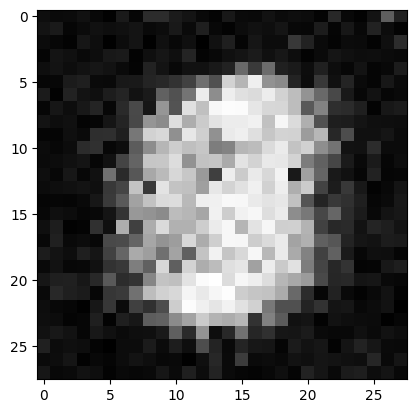

Ploting:  5


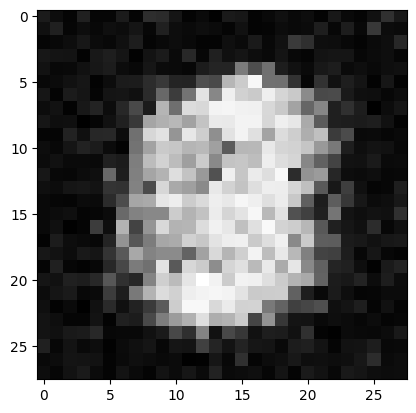

Ploting:  8


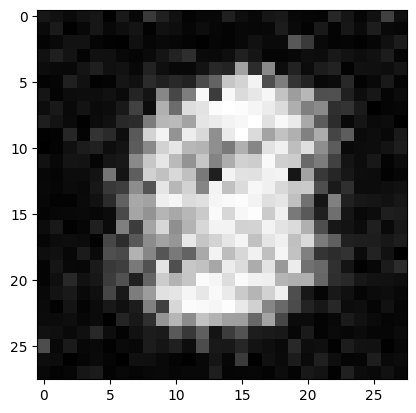

Epoch: 35550
loss_g: 2.567241668701172 	loss_d: 0.3185174763202667
Epoch: 35600
loss_g: 2.6578216552734375 	loss_d: 0.34525397419929504
Epoch: 35650
loss_g: 2.5977611541748047 	loss_d: 0.31523337960243225
Epoch: 35700
loss_g: 2.6117777824401855 	loss_d: 0.2553377151489258
Epoch: 35750
loss_g: 2.6145336627960205 	loss_d: 0.26438039541244507
Epoch: 35800
loss_g: 2.6316380500793457 	loss_d: 0.2861899733543396
Epoch: 35850
loss_g: 2.5849571228027344 	loss_d: 0.3041635751724243
Epoch: 35900
loss_g: 2.5463006496429443 	loss_d: 0.25960785150527954
Epoch: 35950
loss_g: 2.5434412956237793 	loss_d: 0.3023798167705536
Epoch: 36000
loss_g: 2.636350393295288 	loss_d: 0.2798015773296356
Ploting:  0


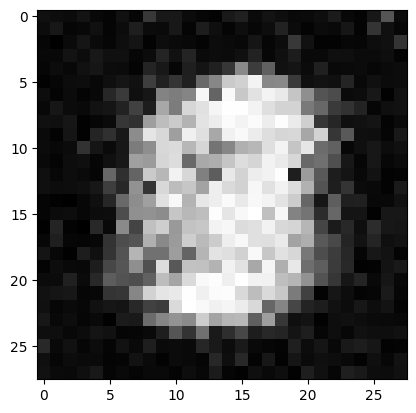

Ploting:  3


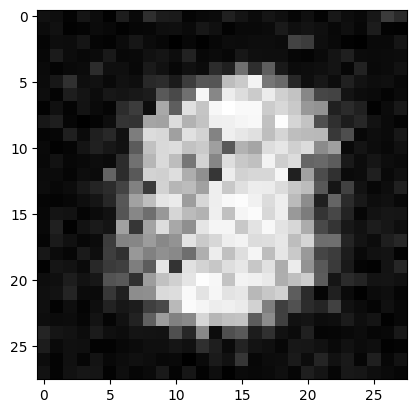

Ploting:  9


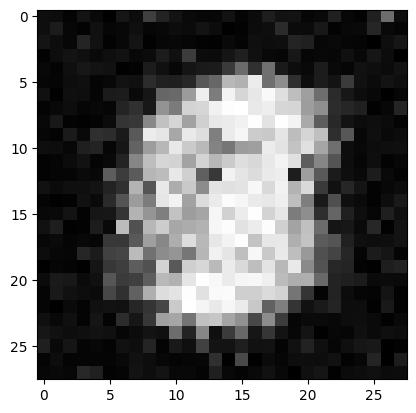

Epoch: 36050
loss_g: 2.483468532562256 	loss_d: 0.3271636366844177
Epoch: 36100
loss_g: 2.547882080078125 	loss_d: 0.3131430745124817
Epoch: 36150
loss_g: 2.584052562713623 	loss_d: 0.2548368275165558
Epoch: 36200
loss_g: 2.558406114578247 	loss_d: 0.3060590922832489
Epoch: 36250
loss_g: 2.569608449935913 	loss_d: 0.2990061640739441
Epoch: 36300
loss_g: 2.4669442176818848 	loss_d: 0.3064582943916321
Epoch: 36350
loss_g: 2.482973575592041 	loss_d: 0.30796945095062256
Epoch: 36400
loss_g: 2.4664130210876465 	loss_d: 0.31919065117836
Epoch: 36450
loss_g: 2.545403003692627 	loss_d: 0.30144262313842773
Epoch: 36500
loss_g: 2.688371419906616 	loss_d: 0.310038685798645
Ploting:  5


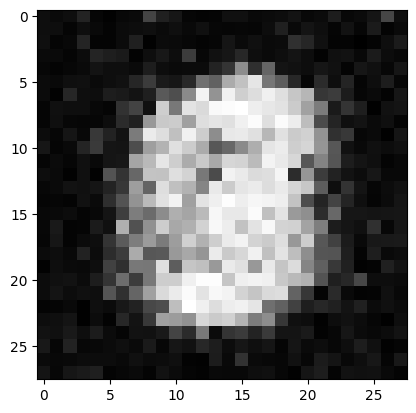

Ploting:  7


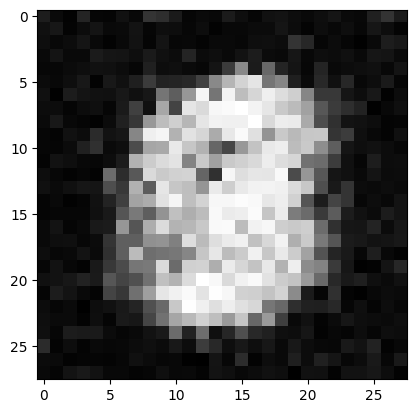

Ploting:  1


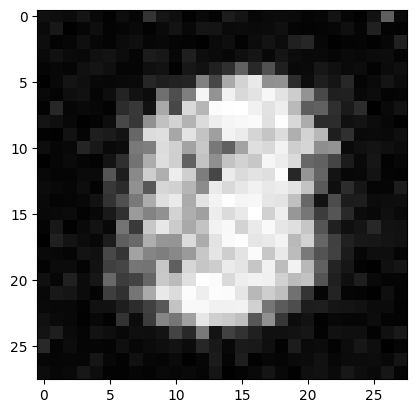

Epoch: 36550
loss_g: 2.4945602416992188 	loss_d: 0.30059579014778137
Epoch: 36600
loss_g: 2.535926103591919 	loss_d: 0.25398895144462585
Epoch: 36650
loss_g: 2.5350747108459473 	loss_d: 0.28201571106910706
Epoch: 36700
loss_g: 2.5499730110168457 	loss_d: 0.33534038066864014
Epoch: 36750
loss_g: 2.5144903659820557 	loss_d: 0.30550655722618103
Epoch: 36800
loss_g: 2.5632925033569336 	loss_d: 0.31547462940216064
Epoch: 36850
loss_g: 2.455753803253174 	loss_d: 0.290347695350647
Epoch: 36900
loss_g: 2.5775108337402344 	loss_d: 0.314062237739563
Epoch: 36950
loss_g: 2.561779737472534 	loss_d: 0.3069135546684265
Epoch: 37000
loss_g: 2.4608795642852783 	loss_d: 0.2933436930179596
Ploting:  7


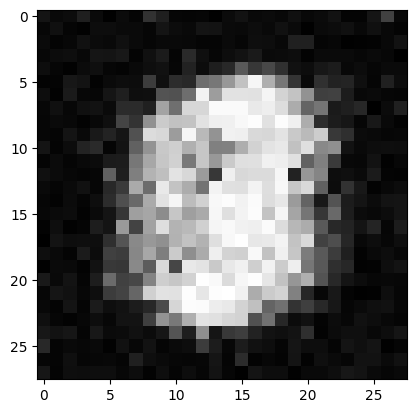

Ploting:  0


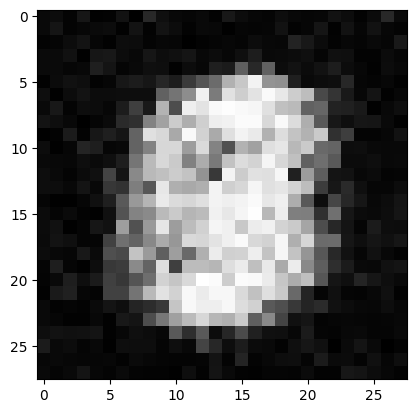

Ploting:  8


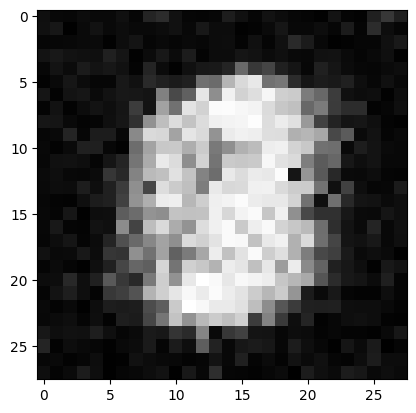

Epoch: 37050
loss_g: 2.5414071083068848 	loss_d: 0.3152030110359192
Epoch: 37100
loss_g: 2.4173531532287598 	loss_d: 0.2978834807872772
Epoch: 37150
loss_g: 2.4919421672821045 	loss_d: 0.33388206362724304
Epoch: 37200
loss_g: 2.4664154052734375 	loss_d: 0.28682878613471985
Epoch: 37250
loss_g: 2.54252290725708 	loss_d: 0.31136149168014526
Epoch: 37300
loss_g: 2.423217296600342 	loss_d: 0.3055554926395416
Epoch: 37350
loss_g: 2.4335179328918457 	loss_d: 0.32369711995124817
Epoch: 37400
loss_g: 2.471686363220215 	loss_d: 0.3051964044570923
Epoch: 37450
loss_g: 2.5076234340667725 	loss_d: 0.3105495870113373
Epoch: 37500
loss_g: 2.4751651287078857 	loss_d: 0.32060641050338745
Ploting:  9


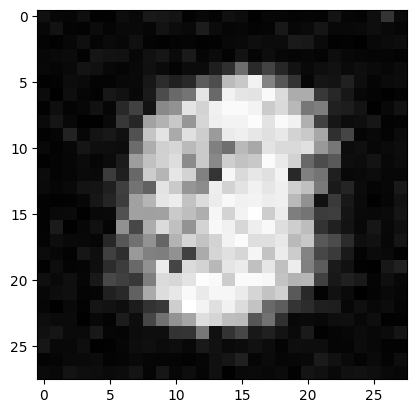

Ploting:  0


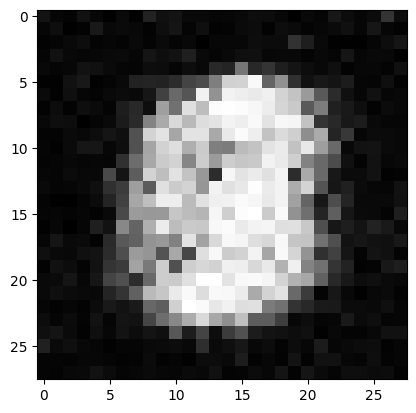

Ploting:  1


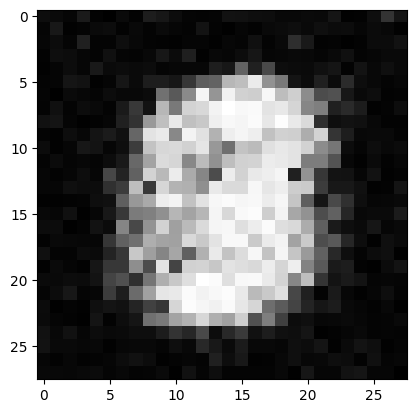

Epoch: 37550
loss_g: 2.4912846088409424 	loss_d: 0.29595625400543213
Epoch: 37600
loss_g: 2.4562883377075195 	loss_d: 0.30011051893234253
Epoch: 37650
loss_g: 2.456105947494507 	loss_d: 0.332712858915329
Epoch: 37700
loss_g: 2.488507032394409 	loss_d: 0.3374297022819519
Epoch: 37750
loss_g: 2.4763283729553223 	loss_d: 0.3678700029850006
Epoch: 37800
loss_g: 2.4034528732299805 	loss_d: 0.3052748143672943
Epoch: 37850
loss_g: 2.494565963745117 	loss_d: 0.3353497385978699
Epoch: 37900
loss_g: 2.4848098754882812 	loss_d: 0.33287468552589417
Epoch: 37950
loss_g: 2.423715353012085 	loss_d: 0.35412493348121643
Epoch: 38000
loss_g: 2.4536678791046143 	loss_d: 0.378296434879303
Ploting:  5


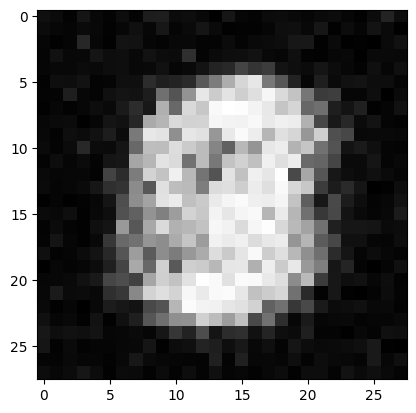

Ploting:  2


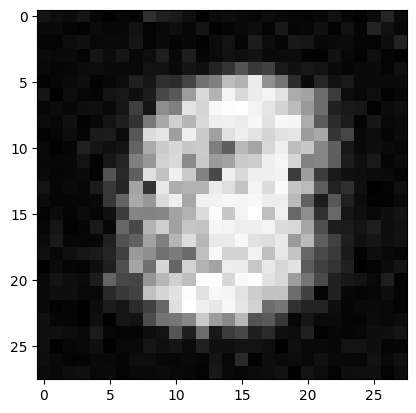

Ploting:  9


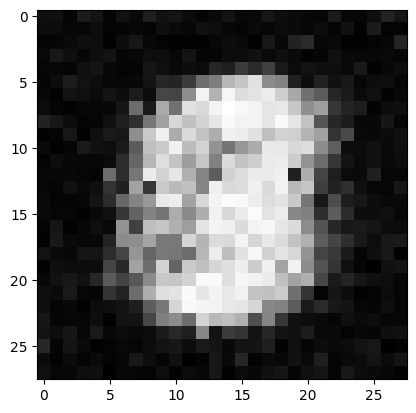

Epoch: 38050
loss_g: 2.36403751373291 	loss_d: 0.33695700764656067
Epoch: 38100
loss_g: 2.4730634689331055 	loss_d: 0.2970995008945465
Epoch: 38150
loss_g: 2.46110200881958 	loss_d: 0.3062719404697418
Epoch: 38200
loss_g: 2.4573020935058594 	loss_d: 0.30955764651298523
Epoch: 38250
loss_g: 2.4704980850219727 	loss_d: 0.350899875164032
Epoch: 38300
loss_g: 2.457334041595459 	loss_d: 0.3018442392349243
Epoch: 38350
loss_g: 2.4341177940368652 	loss_d: 0.34119680523872375
Epoch: 38400
loss_g: 2.471796989440918 	loss_d: 0.31543800234794617
Epoch: 38450
loss_g: 2.4220263957977295 	loss_d: 0.3636842370033264
Epoch: 38500
loss_g: 2.4356563091278076 	loss_d: 0.33280012011528015
Ploting:  7


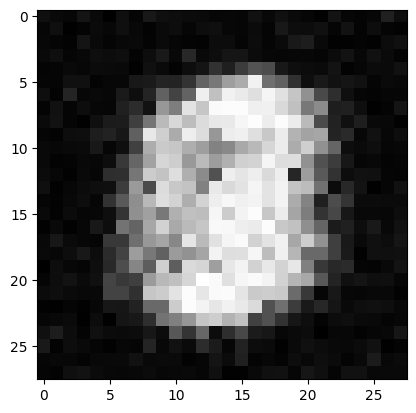

Ploting:  6


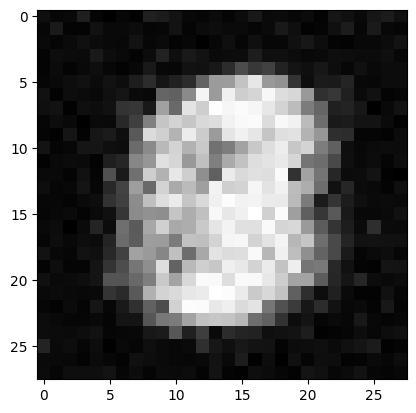

Ploting:  6


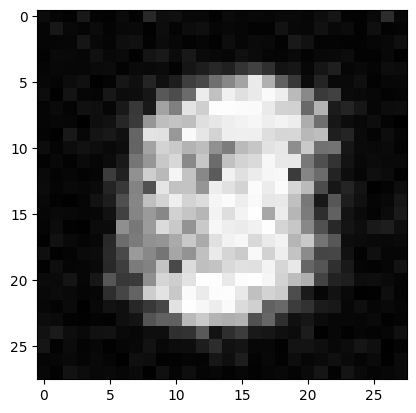

Epoch: 38550
loss_g: 2.4174935817718506 	loss_d: 0.28707125782966614
Epoch: 38600
loss_g: 2.410245180130005 	loss_d: 0.34311866760253906
Epoch: 38650
loss_g: 2.426426649093628 	loss_d: 0.33329588174819946
Epoch: 38700
loss_g: 2.4510321617126465 	loss_d: 0.3265826404094696
Epoch: 38750
loss_g: 2.421717643737793 	loss_d: 0.338128924369812
Epoch: 38800
loss_g: 2.394800901412964 	loss_d: 0.34095314145088196
Epoch: 38850
loss_g: 2.4501402378082275 	loss_d: 0.32960617542266846
Epoch: 38900
loss_g: 2.4599339962005615 	loss_d: 0.3362436592578888
Epoch: 38950
loss_g: 2.428638458251953 	loss_d: 0.32325437664985657
Epoch: 39000
loss_g: 2.419710874557495 	loss_d: 0.2879050076007843
Ploting:  2


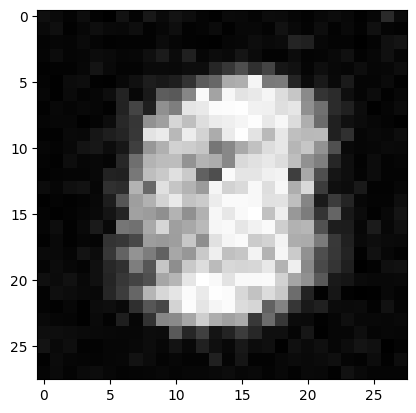

Ploting:  2


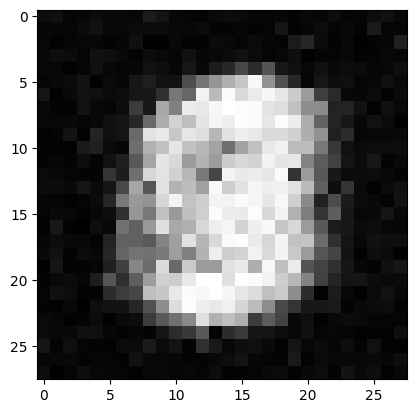

Ploting:  6


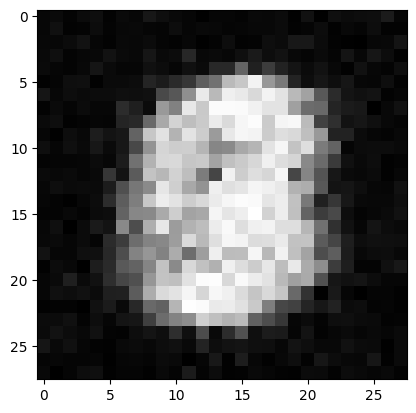

Epoch: 39050
loss_g: 2.384014129638672 	loss_d: 0.31091636419296265
Epoch: 39100
loss_g: 2.4089653491973877 	loss_d: 0.3527882397174835
Epoch: 39150
loss_g: 2.387432098388672 	loss_d: 0.3398723602294922
Epoch: 39200
loss_g: 2.4360134601593018 	loss_d: 0.3437325358390808
Epoch: 39250
loss_g: 2.367274045944214 	loss_d: 0.32231834530830383
Epoch: 39300
loss_g: 2.410292625427246 	loss_d: 0.3521682620048523
Epoch: 39350
loss_g: 2.422473192214966 	loss_d: 0.3458837866783142
Epoch: 39400
loss_g: 2.3794829845428467 	loss_d: 0.3311491012573242
Epoch: 39450
loss_g: 2.351583242416382 	loss_d: 0.345294326543808
Epoch: 39500
loss_g: 2.4070396423339844 	loss_d: 0.3257873058319092
Ploting:  6


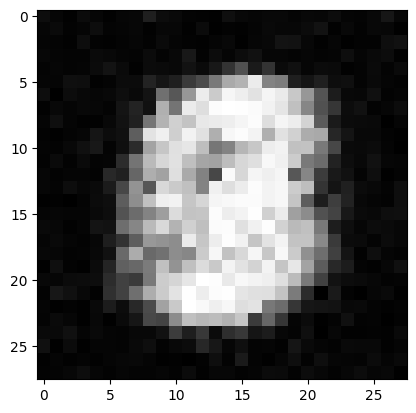

Ploting:  4


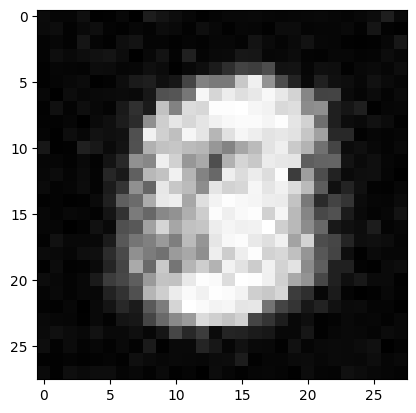

Ploting:  6


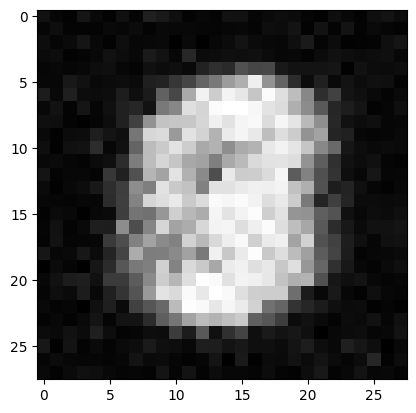

Epoch: 39550
loss_g: 2.4247236251831055 	loss_d: 0.3524700701236725
Epoch: 39600
loss_g: 2.3543715476989746 	loss_d: 0.3072238564491272
Epoch: 39650
loss_g: 2.319737195968628 	loss_d: 0.34250709414482117
Epoch: 39700
loss_g: 2.3928041458129883 	loss_d: 0.3321070373058319
Epoch: 39750
loss_g: 2.2955524921417236 	loss_d: 0.35080817341804504
Epoch: 39800
loss_g: 2.3664164543151855 	loss_d: 0.33150115609169006
Epoch: 39850
loss_g: 2.42618727684021 	loss_d: 0.3371315002441406
Epoch: 39900
loss_g: 2.302553653717041 	loss_d: 0.35137563943862915
Epoch: 39950
loss_g: 2.3350741863250732 	loss_d: 0.32693952322006226
Epoch: 40000
loss_g: 2.2781388759613037 	loss_d: 0.3216959238052368
Ploting:  9


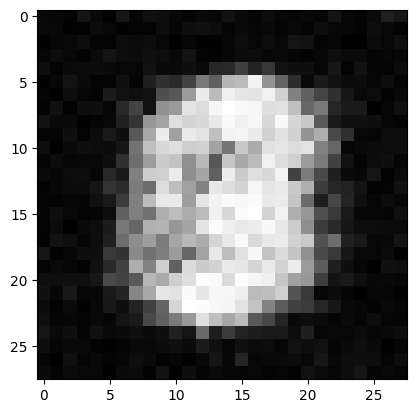

Ploting:  7


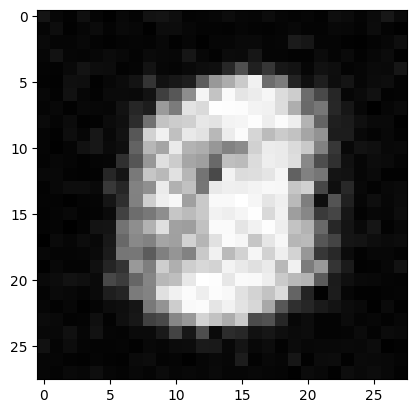

Ploting:  6


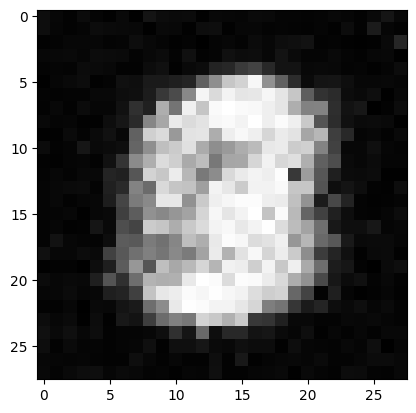

Epoch: 40050
loss_g: 2.283095598220825 	loss_d: 0.35247305035591125
Epoch: 40100
loss_g: 2.3446524143218994 	loss_d: 0.3580579161643982
Epoch: 40150
loss_g: 2.3174984455108643 	loss_d: 0.3988296091556549
Epoch: 40200
loss_g: 2.307574987411499 	loss_d: 0.33650028705596924
Epoch: 40250
loss_g: 2.2950830459594727 	loss_d: 0.36401450634002686
Epoch: 40300
loss_g: 2.281426429748535 	loss_d: 0.369778573513031
Epoch: 40350
loss_g: 2.238379716873169 	loss_d: 0.3721444606781006
Epoch: 40400
loss_g: 2.3171887397766113 	loss_d: 0.40933218598365784
Epoch: 40450
loss_g: 2.347499370574951 	loss_d: 0.36066368222236633
Epoch: 40500
loss_g: 2.3295819759368896 	loss_d: 0.3308964967727661
Ploting:  6


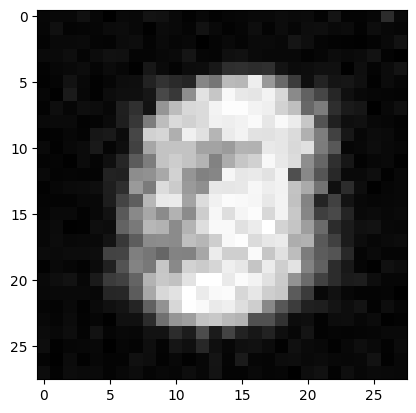

Ploting:  3


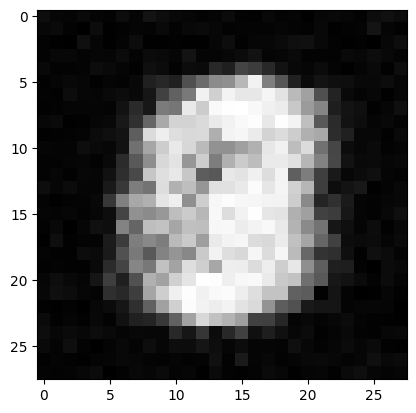

Ploting:  1


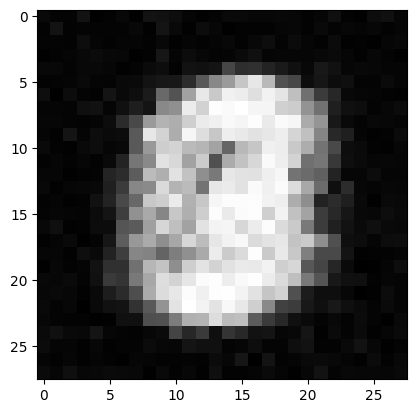

Epoch: 40550
loss_g: 2.3366899490356445 	loss_d: 0.3363376557826996
Epoch: 40600
loss_g: 2.331033229827881 	loss_d: 0.35004767775535583
Epoch: 40650
loss_g: 2.329094171524048 	loss_d: 0.39091864228248596
Epoch: 40700
loss_g: 2.3442089557647705 	loss_d: 0.3371202349662781
Epoch: 40750
loss_g: 2.3416571617126465 	loss_d: 0.3772806227207184
Epoch: 40800
loss_g: 2.288050889968872 	loss_d: 0.351525217294693
Epoch: 40850
loss_g: 2.338193416595459 	loss_d: 0.3835299611091614
Epoch: 40900
loss_g: 2.292890787124634 	loss_d: 0.3641485571861267
Epoch: 40950
loss_g: 2.2924258708953857 	loss_d: 0.32392972707748413
Epoch: 41000
loss_g: 2.2949788570404053 	loss_d: 0.37505659461021423
Ploting:  5


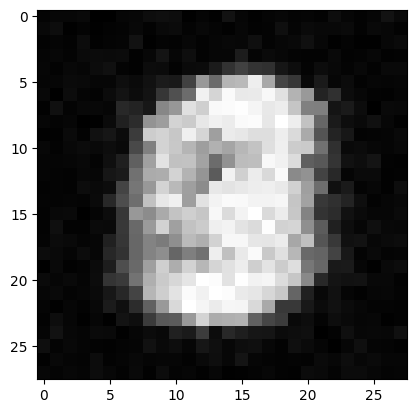

Ploting:  3


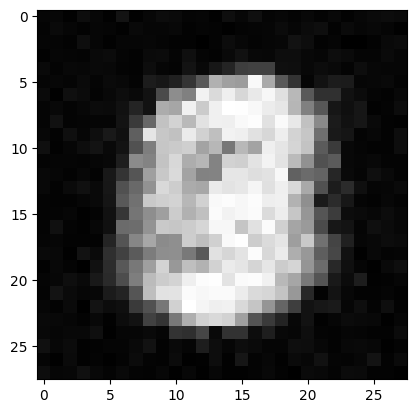

Ploting:  8


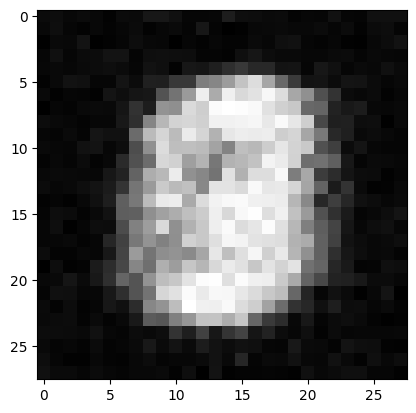

Epoch: 41050
loss_g: 2.2968318462371826 	loss_d: 0.3671608567237854
Epoch: 41100
loss_g: 2.270206928253174 	loss_d: 0.35440778732299805
Epoch: 41150
loss_g: 2.2834689617156982 	loss_d: 0.36641332507133484
Epoch: 41200
loss_g: 2.3050405979156494 	loss_d: 0.38350895047187805
Epoch: 41250
loss_g: 2.297268867492676 	loss_d: 0.36132773756980896
Epoch: 41300
loss_g: 2.3139822483062744 	loss_d: 0.377277672290802
Epoch: 41350
loss_g: 2.2496120929718018 	loss_d: 0.3668771982192993
Epoch: 41400
loss_g: 2.2361929416656494 	loss_d: 0.34222105145454407
Epoch: 41450
loss_g: 2.2360410690307617 	loss_d: 0.3499928116798401
Epoch: 41500
loss_g: 2.2516114711761475 	loss_d: 0.3962034583091736
Ploting:  8


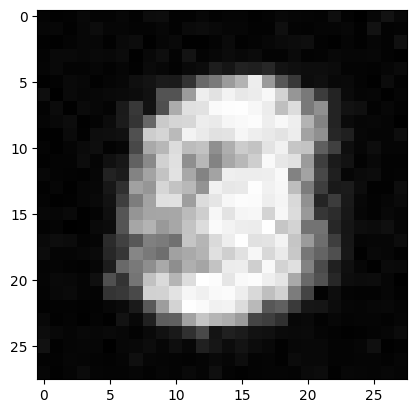

Ploting:  1


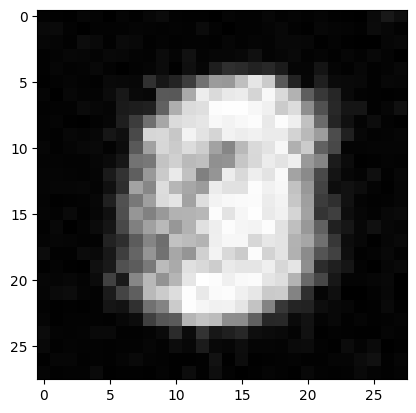

Ploting:  7


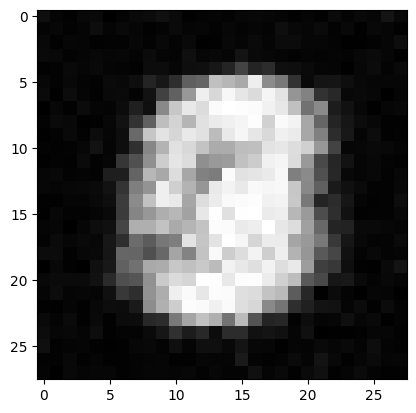

Epoch: 41550
loss_g: 2.2577121257781982 	loss_d: 0.38186103105545044
Epoch: 41600
loss_g: 2.2379610538482666 	loss_d: 0.3846750557422638
Epoch: 41650
loss_g: 2.2695162296295166 	loss_d: 0.36560386419296265
Epoch: 41700
loss_g: 2.202531576156616 	loss_d: 0.39646461606025696
Epoch: 41750
loss_g: 2.2170321941375732 	loss_d: 0.38143905997276306
Epoch: 41800
loss_g: 2.2194206714630127 	loss_d: 0.37483668327331543
Epoch: 41850
loss_g: 2.262232542037964 	loss_d: 0.3927493095397949
Epoch: 41900
loss_g: 2.2449676990509033 	loss_d: 0.36602485179901123
Epoch: 41950
loss_g: 2.240443468093872 	loss_d: 0.39375734329223633
Epoch: 42000
loss_g: 2.2190256118774414 	loss_d: 0.34859004616737366
Ploting:  9


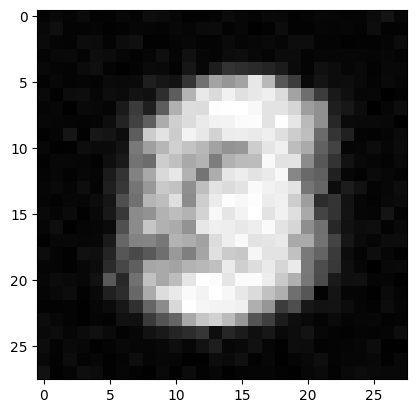

Ploting:  5


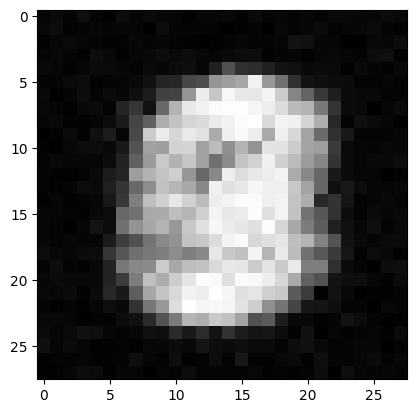

Ploting:  7


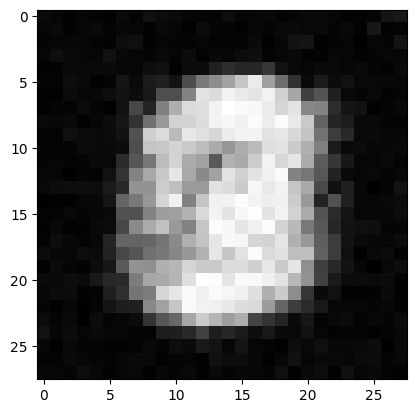

Epoch: 42050
loss_g: 2.200448989868164 	loss_d: 0.3886772692203522
Epoch: 42100
loss_g: 2.233609199523926 	loss_d: 0.3657922148704529
Epoch: 42150
loss_g: 2.1686229705810547 	loss_d: 0.393501877784729
Epoch: 42200
loss_g: 2.2276904582977295 	loss_d: 0.3797096312046051
Epoch: 42250
loss_g: 2.185706853866577 	loss_d: 0.38600242137908936
Epoch: 42300
loss_g: 2.169384717941284 	loss_d: 0.4116414487361908
Epoch: 42350
loss_g: 2.1413981914520264 	loss_d: 0.36939147114753723
Epoch: 42400
loss_g: 2.151076078414917 	loss_d: 0.3770678639411926
Epoch: 42450
loss_g: 2.2058420181274414 	loss_d: 0.390400230884552
Epoch: 42500
loss_g: 2.151062488555908 	loss_d: 0.39564669132232666
Ploting:  8


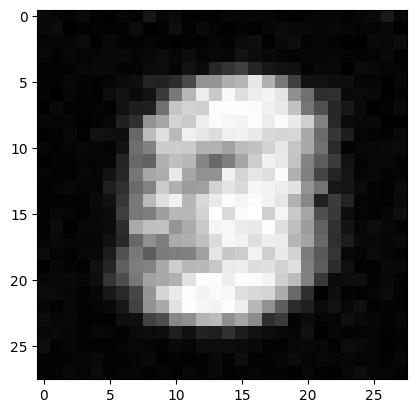

Ploting:  3


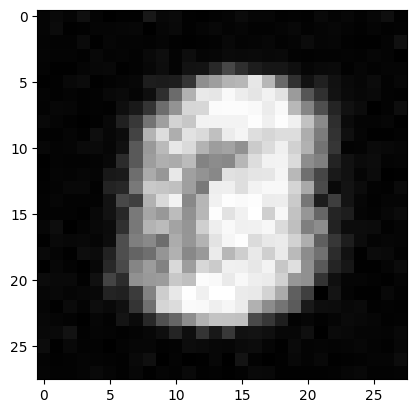

Ploting:  9


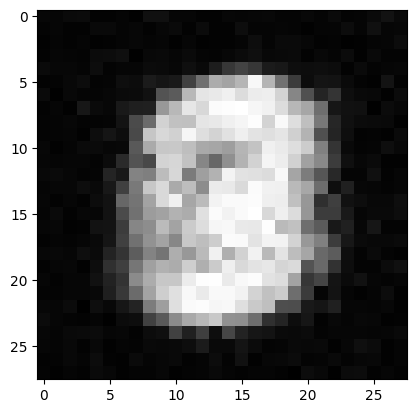

Epoch: 42550
loss_g: 2.1739890575408936 	loss_d: 0.45379218459129333
Epoch: 42600
loss_g: 2.15586256980896 	loss_d: 0.3883686661720276
Epoch: 42650
loss_g: 2.169262647628784 	loss_d: 0.4115840494632721
Epoch: 42700
loss_g: 2.1804869174957275 	loss_d: 0.4243669807910919
Epoch: 42750
loss_g: 2.169585943222046 	loss_d: 0.43270546197891235
Epoch: 42800
loss_g: 2.1748404502868652 	loss_d: 0.44802573323249817
Epoch: 42850
loss_g: 2.2020890712738037 	loss_d: 0.4005541503429413
Epoch: 42900
loss_g: 2.206712007522583 	loss_d: 0.3765062391757965
Epoch: 42950
loss_g: 2.1311702728271484 	loss_d: 0.39081305265426636
Epoch: 43000
loss_g: 2.169877052307129 	loss_d: 0.4024377465248108
Ploting:  0


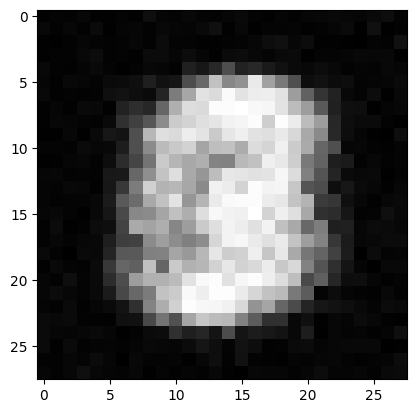

Ploting:  3


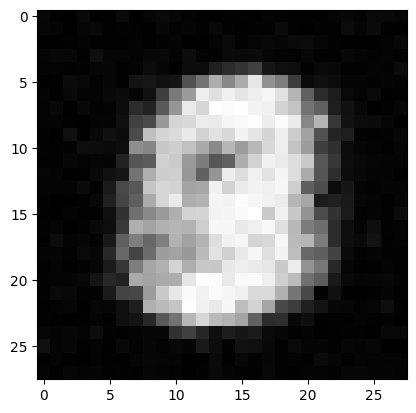

Ploting:  8


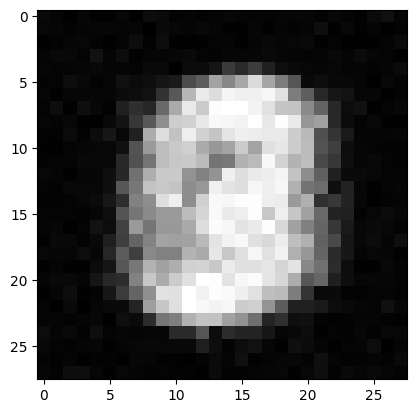

Epoch: 43050
loss_g: 2.1376090049743652 	loss_d: 0.44074952602386475
Epoch: 43100
loss_g: 2.168797492980957 	loss_d: 0.38530007004737854
Epoch: 43150
loss_g: 2.1127023696899414 	loss_d: 0.42607322335243225
Epoch: 43200
loss_g: 2.185857057571411 	loss_d: 0.4023857116699219
Epoch: 43250
loss_g: 2.1425185203552246 	loss_d: 0.42291930317878723
Epoch: 43300
loss_g: 2.138373613357544 	loss_d: 0.39497923851013184
Epoch: 43350
loss_g: 2.1172964572906494 	loss_d: 0.3822917342185974
Epoch: 43400
loss_g: 2.1643354892730713 	loss_d: 0.4226302206516266
Epoch: 43450
loss_g: 2.1134653091430664 	loss_d: 0.4150594174861908
Epoch: 43500
loss_g: 2.087223768234253 	loss_d: 0.3948471248149872
Ploting:  5


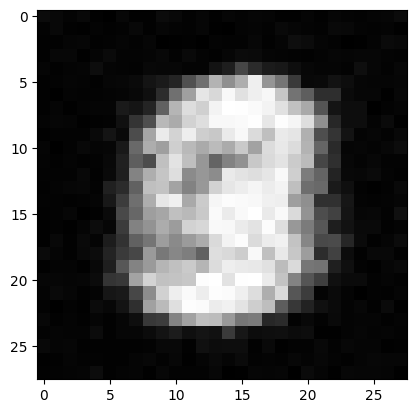

Ploting:  6


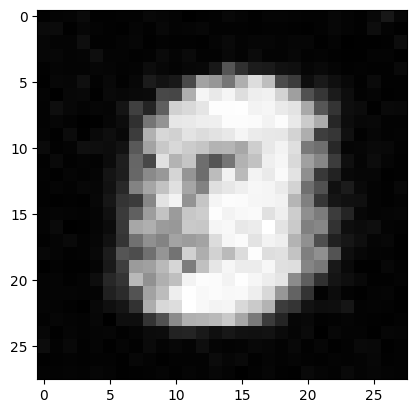

Ploting:  1


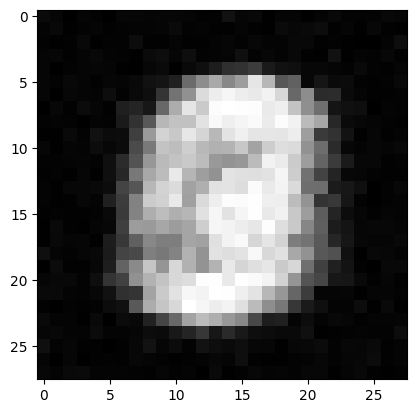

Epoch: 43550
loss_g: 2.125568389892578 	loss_d: 0.4046690762042999
Epoch: 43600
loss_g: 2.099703073501587 	loss_d: 0.4329370856285095
Epoch: 43650
loss_g: 2.124401092529297 	loss_d: 0.40262937545776367
Epoch: 43700
loss_g: 2.128263235092163 	loss_d: 0.4132140576839447
Epoch: 43750
loss_g: 2.1122052669525146 	loss_d: 0.4086976647377014
Epoch: 43800
loss_g: 2.12099027633667 	loss_d: 0.39196470379829407
Epoch: 43850
loss_g: 2.1309916973114014 	loss_d: 0.40343764424324036
Epoch: 43900
loss_g: 2.1292855739593506 	loss_d: 0.4263646602630615
Epoch: 43950
loss_g: 2.1304244995117188 	loss_d: 0.4289829134941101
Epoch: 44000
loss_g: 2.058814764022827 	loss_d: 0.4307728409767151
Ploting:  0


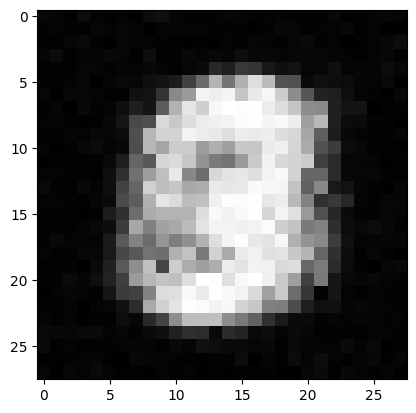

Ploting:  7


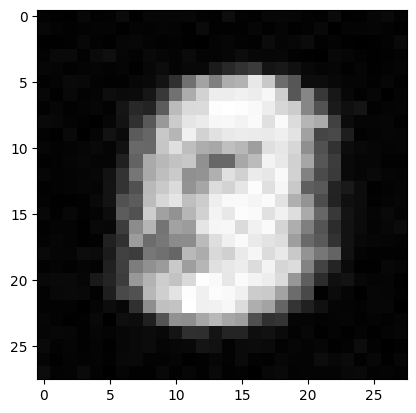

Ploting:  6


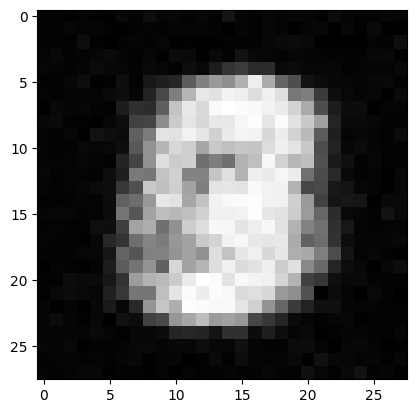

Epoch: 44050
loss_g: 2.0858469009399414 	loss_d: 0.4070771336555481
Epoch: 44100
loss_g: 2.1145637035369873 	loss_d: 0.43235695362091064
Epoch: 44150
loss_g: 2.1183922290802 	loss_d: 0.4312359392642975
Epoch: 44200
loss_g: 2.1000540256500244 	loss_d: 0.42552611231803894
Epoch: 44250
loss_g: 2.068326950073242 	loss_d: 0.43699881434440613
Epoch: 44300
loss_g: 2.1371328830718994 	loss_d: 0.406247079372406
Epoch: 44350
loss_g: 2.0769553184509277 	loss_d: 0.42814186215400696
Epoch: 44400
loss_g: 2.0458250045776367 	loss_d: 0.39749839901924133
Epoch: 44450
loss_g: 2.0472664833068848 	loss_d: 0.43520164489746094
Epoch: 44500
loss_g: 2.0856568813323975 	loss_d: 0.39577382802963257
Ploting:  4


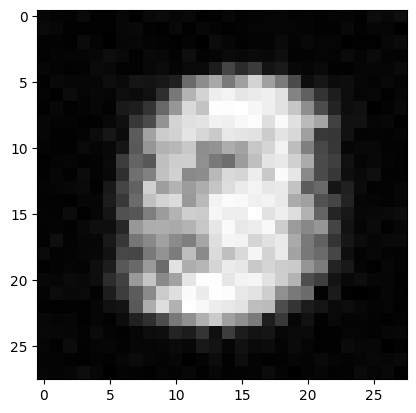

Ploting:  9


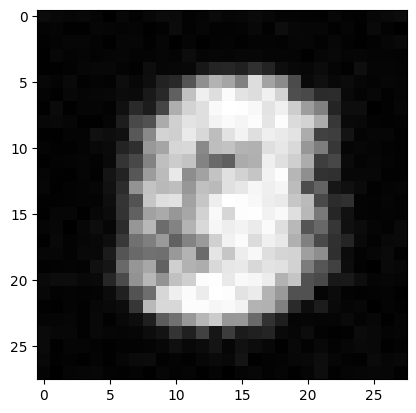

Ploting:  9


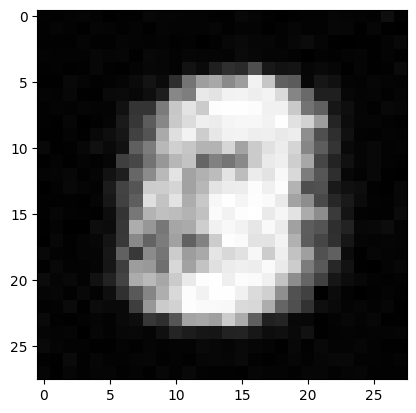

Epoch: 44550
loss_g: 2.0623228549957275 	loss_d: 0.4283227324485779
Epoch: 44600
loss_g: 2.086873769760132 	loss_d: 0.4189157783985138
Epoch: 44650
loss_g: 2.0550429821014404 	loss_d: 0.4271533787250519
Epoch: 44700
loss_g: 2.0761656761169434 	loss_d: 0.46303534507751465
Epoch: 44750
loss_g: 2.097264051437378 	loss_d: 0.4097140431404114
Epoch: 44800
loss_g: 2.0582125186920166 	loss_d: 0.4092203378677368
Epoch: 44850
loss_g: 2.069317102432251 	loss_d: 0.42568549513816833
Epoch: 44900
loss_g: 2.0999248027801514 	loss_d: 0.4231942594051361
Epoch: 44950
loss_g: 2.053683280944824 	loss_d: 0.49184951186180115
Epoch: 45000
loss_g: 2.079822540283203 	loss_d: 0.4259149134159088
Ploting:  9


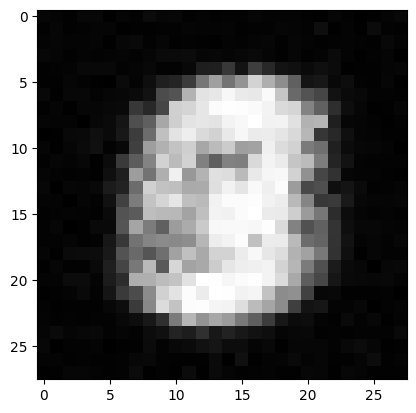

Ploting:  0


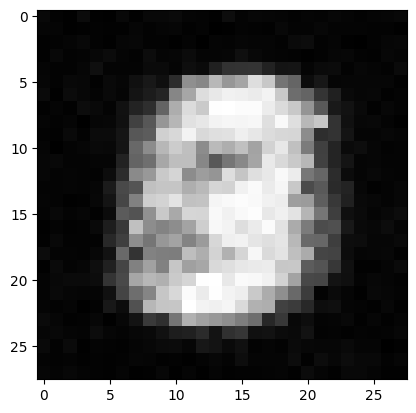

Ploting:  9


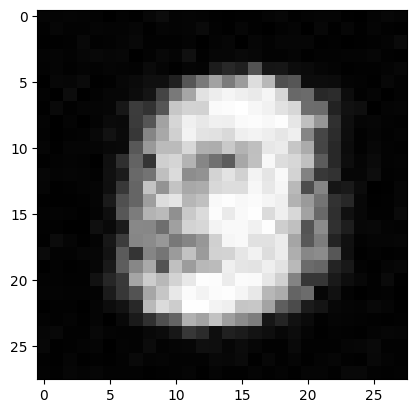

Epoch: 45050
loss_g: 2.052722930908203 	loss_d: 0.45115527510643005
Epoch: 45100
loss_g: 2.0687599182128906 	loss_d: 0.45519188046455383
Epoch: 45150
loss_g: 2.1056301593780518 	loss_d: 0.45346519351005554
Epoch: 45200
loss_g: 2.0487308502197266 	loss_d: 0.47870758175849915
Epoch: 45250
loss_g: 2.078279733657837 	loss_d: 0.41849055886268616
Epoch: 45300
loss_g: 2.0677847862243652 	loss_d: 0.42061111330986023
Epoch: 45350
loss_g: 2.0748393535614014 	loss_d: 0.4260430932044983
Epoch: 45400
loss_g: 2.068214178085327 	loss_d: 0.43459272384643555
Epoch: 45450
loss_g: 2.0716187953948975 	loss_d: 0.4579591155052185
Epoch: 45500
loss_g: 2.0894405841827393 	loss_d: 0.4230848252773285
Ploting:  1


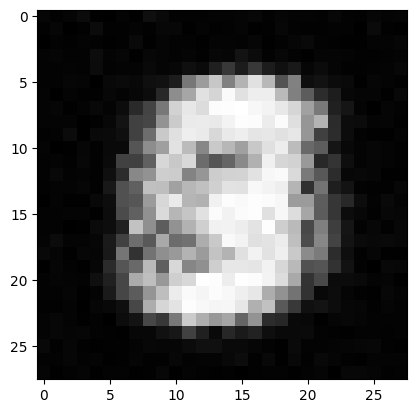

Ploting:  4


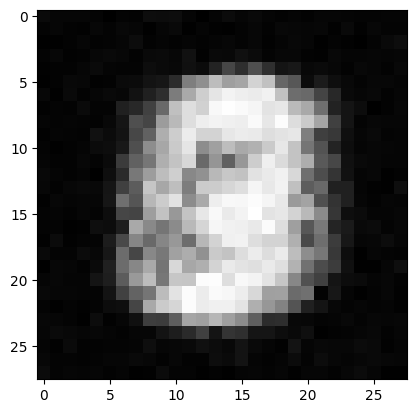

Ploting:  0


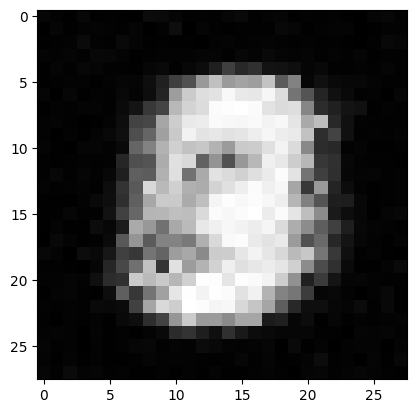

Epoch: 45550
loss_g: 2.1014010906219482 	loss_d: 0.4378410577774048
Epoch: 45600
loss_g: 2.079017400741577 	loss_d: 0.42672818899154663
Epoch: 45650
loss_g: 2.1067252159118652 	loss_d: 0.4309028387069702
Epoch: 45700
loss_g: 2.0410289764404297 	loss_d: 0.41320013999938965
Epoch: 45750
loss_g: 2.063185930252075 	loss_d: 0.4185136556625366
Epoch: 45800
loss_g: 2.0706088542938232 	loss_d: 0.4467085599899292
Epoch: 45850
loss_g: 2.0757896900177 	loss_d: 0.4291500747203827
Epoch: 45900
loss_g: 2.0765459537506104 	loss_d: 0.4059807360172272
Epoch: 45950
loss_g: 2.078400135040283 	loss_d: 0.4132813513278961
Epoch: 46000
loss_g: 2.0631487369537354 	loss_d: 0.4463500380516052
Ploting:  2


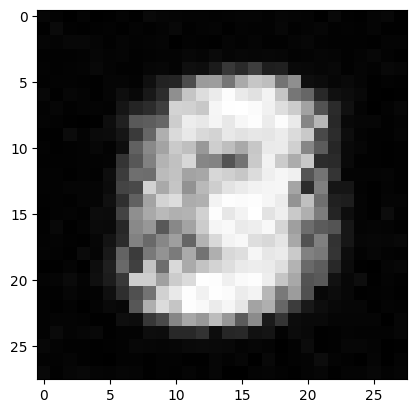

Ploting:  2


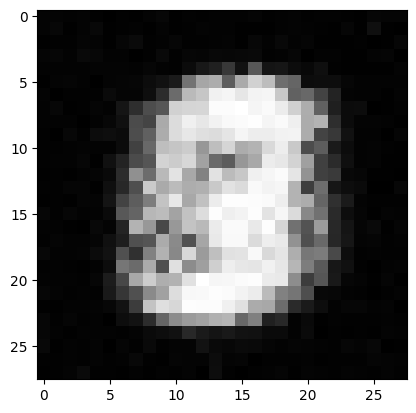

Ploting:  3


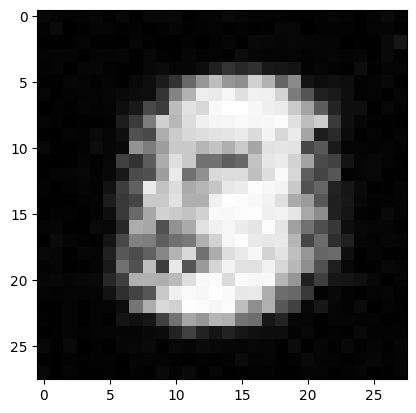

Epoch: 46050
loss_g: 2.0820608139038086 	loss_d: 0.41124439239501953
Epoch: 46100
loss_g: 2.0793874263763428 	loss_d: 0.424242228269577
Epoch: 46150
loss_g: 2.06889271736145 	loss_d: 0.4208901822566986
Epoch: 46200
loss_g: 2.0609021186828613 	loss_d: 0.4186238646507263
Epoch: 46250
loss_g: 2.081507682800293 	loss_d: 0.4265710413455963
Epoch: 46300
loss_g: 2.07894229888916 	loss_d: 0.42704740166664124
Epoch: 46350
loss_g: 2.040527820587158 	loss_d: 0.4384782016277313
Epoch: 46400
loss_g: 2.083122968673706 	loss_d: 0.4479585289955139
Epoch: 46450
loss_g: 2.0429461002349854 	loss_d: 0.41845327615737915
Epoch: 46500
loss_g: 2.071763277053833 	loss_d: 0.4246983230113983
Ploting:  1


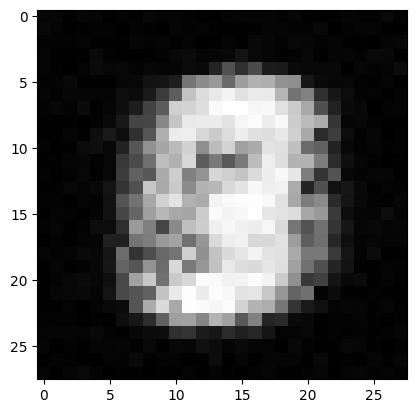

Ploting:  7


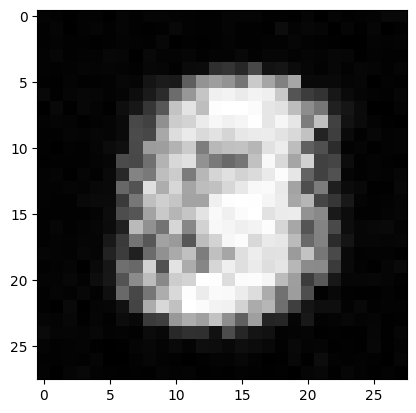

Ploting:  9


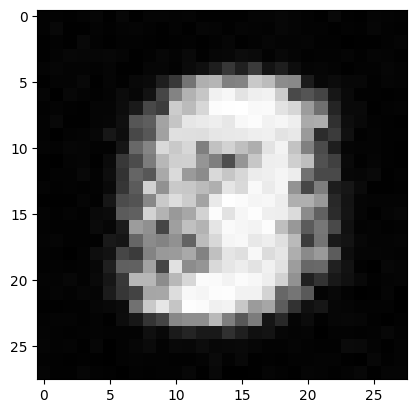

Epoch: 46550
loss_g: 2.031327724456787 	loss_d: 0.4309641420841217
Epoch: 46600
loss_g: 2.0625414848327637 	loss_d: 0.44173064827919006
Epoch: 46650
loss_g: 2.0687670707702637 	loss_d: 0.4360429644584656
Epoch: 46700
loss_g: 2.049304246902466 	loss_d: 0.4142800569534302
Epoch: 46750
loss_g: 2.0321459770202637 	loss_d: 0.42763617634773254
Epoch: 46800
loss_g: 2.09017014503479 	loss_d: 0.40391913056373596
Epoch: 46850
loss_g: 2.065589427947998 	loss_d: 0.4407176971435547
Epoch: 46900
loss_g: 2.06939435005188 	loss_d: 0.40209296345710754
Epoch: 46950
loss_g: 2.0573785305023193 	loss_d: 0.4223189353942871
Epoch: 47000
loss_g: 2.059828042984009 	loss_d: 0.4113747775554657
Ploting:  8


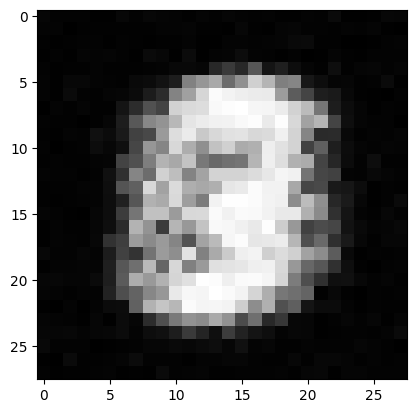

Ploting:  4


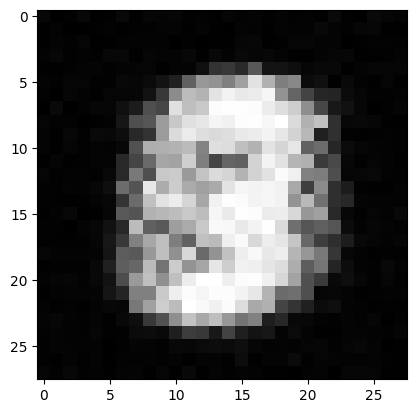

Ploting:  2


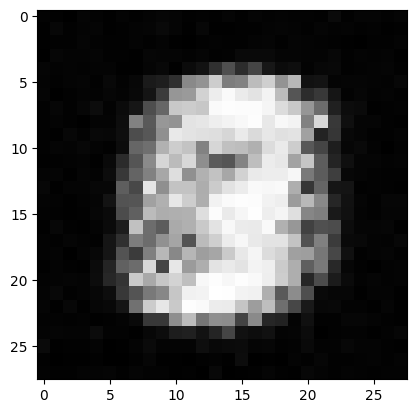

Epoch: 47050
loss_g: 2.0794365406036377 	loss_d: 0.4235490560531616
Epoch: 47100
loss_g: 2.050917387008667 	loss_d: 0.4519657790660858
Epoch: 47150
loss_g: 2.061156988143921 	loss_d: 0.4035978615283966
Epoch: 47200
loss_g: 2.0842092037200928 	loss_d: 0.4179845452308655
Epoch: 47250
loss_g: 2.081554412841797 	loss_d: 0.41677340865135193
Epoch: 47300
loss_g: 2.035802125930786 	loss_d: 0.409267783164978
Epoch: 47350
loss_g: 2.0583603382110596 	loss_d: 0.4766658544540405
Epoch: 47400
loss_g: 2.080444812774658 	loss_d: 0.42857250571250916
Epoch: 47450
loss_g: 2.063718318939209 	loss_d: 0.4389963448047638
Epoch: 47500
loss_g: 2.0679075717926025 	loss_d: 0.45953214168548584
Ploting:  2


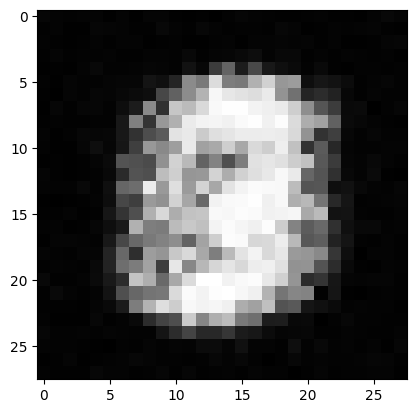

Ploting:  6


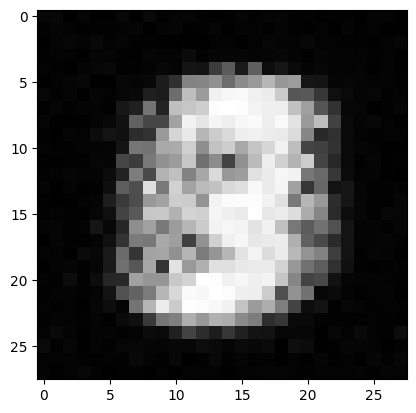

Ploting:  5


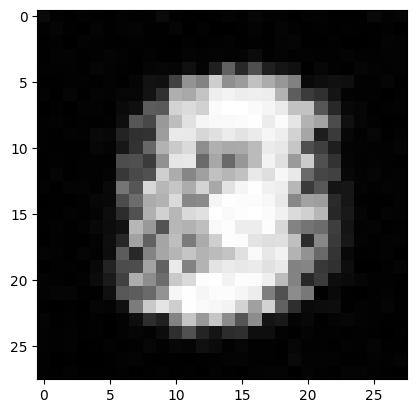

Epoch: 47550
loss_g: 2.060025691986084 	loss_d: 0.44824913144111633
Epoch: 47600
loss_g: 2.0702497959136963 	loss_d: 0.46248409152030945
Epoch: 47650
loss_g: 2.0911149978637695 	loss_d: 0.4081711173057556
Epoch: 47700
loss_g: 2.0693163871765137 	loss_d: 0.4143153429031372
Epoch: 47750
loss_g: 2.059192180633545 	loss_d: 0.42353975772857666
Epoch: 47800
loss_g: 2.0524344444274902 	loss_d: 0.41807323694229126
Epoch: 47850
loss_g: 2.066068649291992 	loss_d: 0.4377728998661041
Epoch: 47900
loss_g: 2.066819906234741 	loss_d: 0.4089862108230591
Epoch: 47950
loss_g: 2.0787858963012695 	loss_d: 0.4092959463596344
Epoch: 48000
loss_g: 2.079833745956421 	loss_d: 0.4150463044643402
Ploting:  3


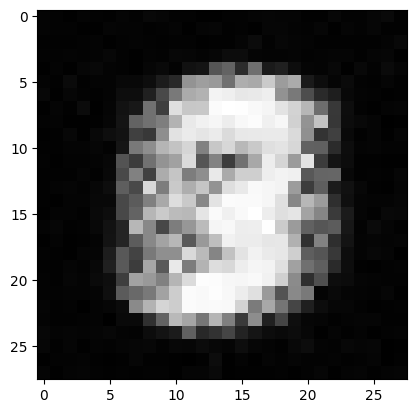

Ploting:  9


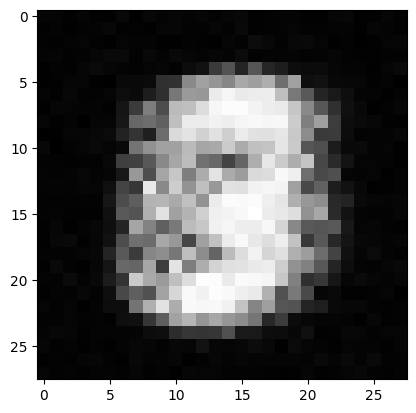

Ploting:  8


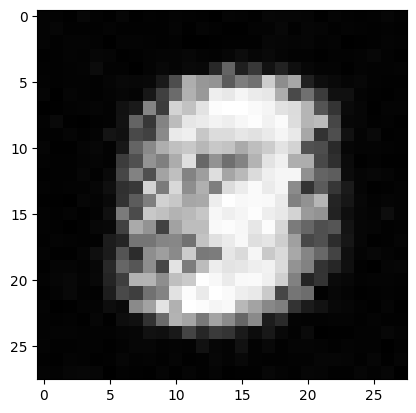

Epoch: 48050
loss_g: 2.078291177749634 	loss_d: 0.41002169251441956
Epoch: 48100
loss_g: 2.0756213665008545 	loss_d: 0.3935800790786743
Epoch: 48150
loss_g: 2.0575740337371826 	loss_d: 0.40782630443573
Epoch: 48200
loss_g: 2.0412659645080566 	loss_d: 0.4233650863170624
Epoch: 48250
loss_g: 2.0778887271881104 	loss_d: 0.40770652890205383
Epoch: 48300
loss_g: 2.0673928260803223 	loss_d: 0.39311879873275757
Epoch: 48350
loss_g: 2.0855712890625 	loss_d: 0.39758986234664917
Epoch: 48400
loss_g: 2.0534584522247314 	loss_d: 0.41637706756591797
Epoch: 48450
loss_g: 2.0853981971740723 	loss_d: 0.38263341784477234
Epoch: 48500
loss_g: 2.0742645263671875 	loss_d: 0.40341421961784363
Ploting:  4


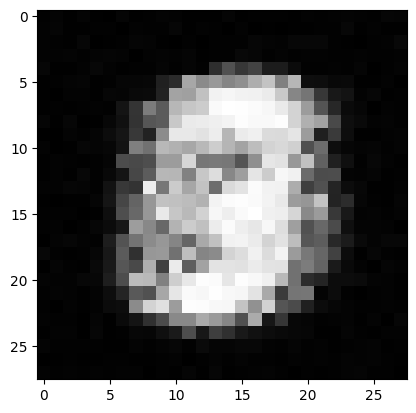

Ploting:  0


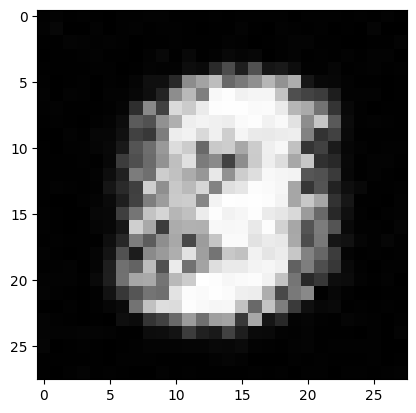

Ploting:  9


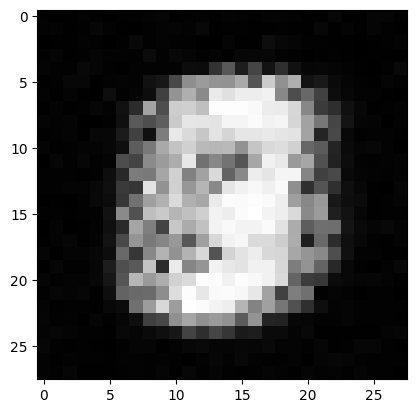

Epoch: 48550
loss_g: 2.0850863456726074 	loss_d: 0.4095223546028137
Epoch: 48600
loss_g: 2.0832674503326416 	loss_d: 0.4081966280937195
Epoch: 48650
loss_g: 2.098214864730835 	loss_d: 0.41320377588272095
Epoch: 48700
loss_g: 2.0600244998931885 	loss_d: 0.40311095118522644
Epoch: 48750
loss_g: 2.0800652503967285 	loss_d: 0.41120445728302
Epoch: 48800
loss_g: 2.1008903980255127 	loss_d: 0.4241926074028015
Epoch: 48850
loss_g: 2.0806236267089844 	loss_d: 0.38958343863487244
Epoch: 48900
loss_g: 2.091984987258911 	loss_d: 0.3909803628921509
Epoch: 48950
loss_g: 2.1076674461364746 	loss_d: 0.40624475479125977
Epoch: 49000
loss_g: 2.1031997203826904 	loss_d: 0.4203541576862335
Ploting:  2


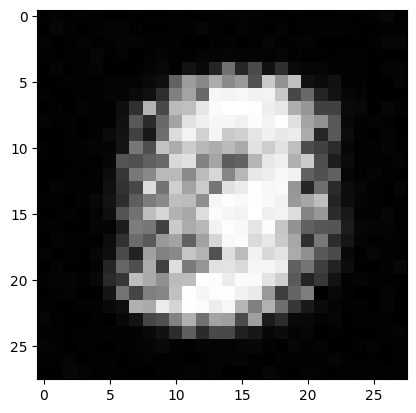

Ploting:  2


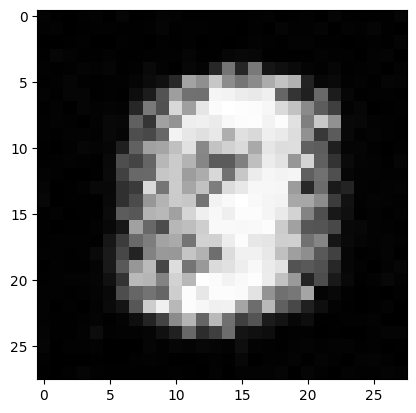

Ploting:  9


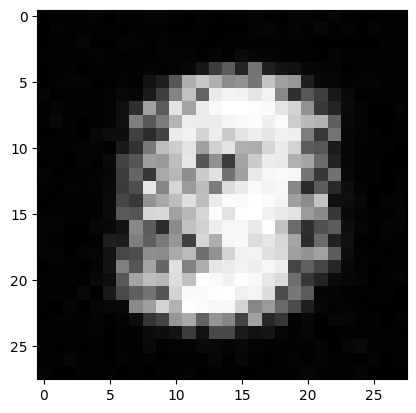

Epoch: 49050
loss_g: 2.0865671634674072 	loss_d: 0.3989880681037903
Epoch: 49100
loss_g: 2.109001398086548 	loss_d: 0.39454489946365356
Epoch: 49150
loss_g: 2.1057045459747314 	loss_d: 0.38365185260772705
Epoch: 49200
loss_g: 2.0891921520233154 	loss_d: 0.3862917125225067
Epoch: 49250
loss_g: 2.10295033454895 	loss_d: 0.40511953830718994
Epoch: 49300
loss_g: 2.1349809169769287 	loss_d: 0.3761058747768402
Epoch: 49350
loss_g: 2.1032211780548096 	loss_d: 0.3776954710483551
Epoch: 49400
loss_g: 2.101611375808716 	loss_d: 0.38504812121391296
Epoch: 49450
loss_g: 2.089818239212036 	loss_d: 0.39038658142089844
Epoch: 49500
loss_g: 2.1039135456085205 	loss_d: 0.41299906373023987
Ploting:  1


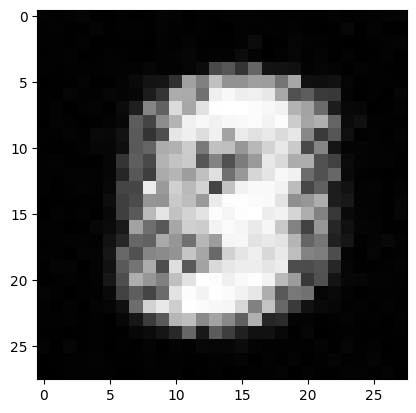

Ploting:  7


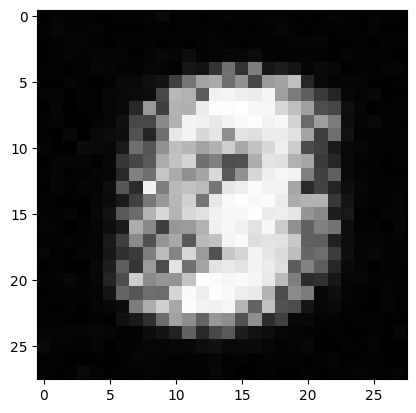

Ploting:  1


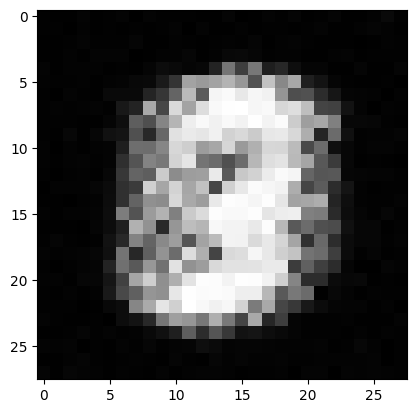

Epoch: 49550
loss_g: 2.1366381645202637 	loss_d: 0.36352989077568054
Epoch: 49600
loss_g: 2.1325905323028564 	loss_d: 0.3907066285610199
Epoch: 49650
loss_g: 2.137665271759033 	loss_d: 0.3782598078250885
Epoch: 49700
loss_g: 2.102282762527466 	loss_d: 0.3685319423675537
Epoch: 49750
loss_g: 2.1249382495880127 	loss_d: 0.42977485060691833
Epoch: 49800
loss_g: 2.1238434314727783 	loss_d: 0.38939058780670166
Epoch: 49850
loss_g: 2.142880439758301 	loss_d: 0.39959731698036194
Epoch: 49900
loss_g: 2.115269422531128 	loss_d: 0.40448814630508423
Epoch: 49950
loss_g: 2.1570022106170654 	loss_d: 0.40134742856025696
Epoch: 50000
loss_g: 2.1515579223632812 	loss_d: 0.41827917098999023
Ploting:  0


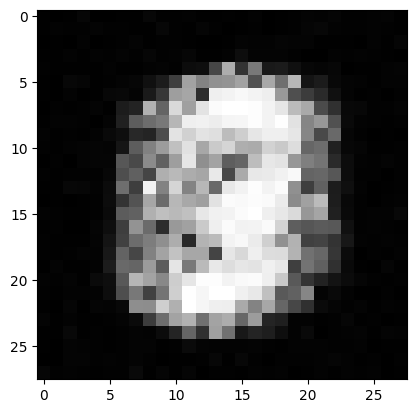

Ploting:  5


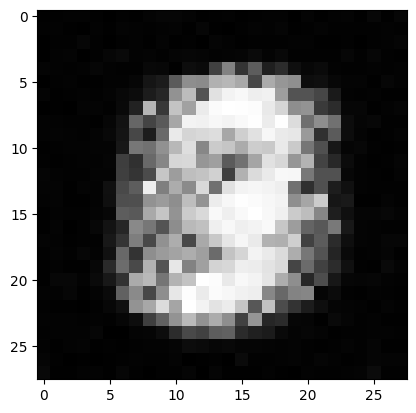

Ploting:  7


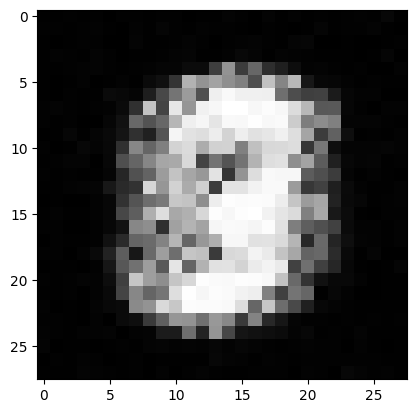

Epoch: 50050
loss_g: 2.1233294010162354 	loss_d: 0.35901007056236267
Epoch: 50100
loss_g: 2.1446566581726074 	loss_d: 0.3702530264854431
Epoch: 50150
loss_g: 2.1590566635131836 	loss_d: 0.373677521944046
Epoch: 50200
loss_g: 2.1378014087677 	loss_d: 0.3650682866573334
Epoch: 50250
loss_g: 2.161496162414551 	loss_d: 0.38290131092071533
Epoch: 50300
loss_g: 2.1678426265716553 	loss_d: 0.3570539057254791
Epoch: 50350
loss_g: 2.160923957824707 	loss_d: 0.35174795985221863
Epoch: 50400
loss_g: 2.1439948081970215 	loss_d: 0.3720453083515167
Epoch: 50450
loss_g: 2.1761977672576904 	loss_d: 0.3514900207519531
Epoch: 50500
loss_g: 2.1453752517700195 	loss_d: 0.34626853466033936
Ploting:  4


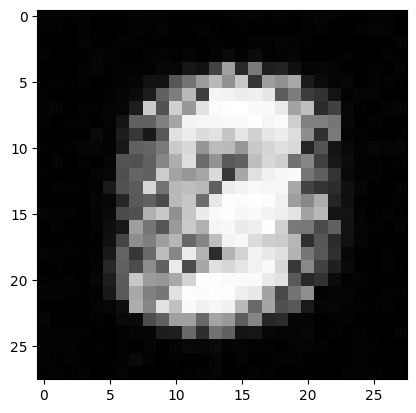

Ploting:  8


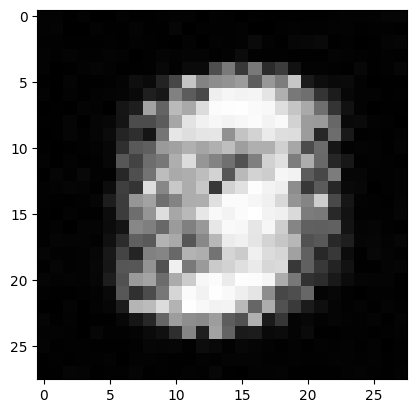

Ploting:  6


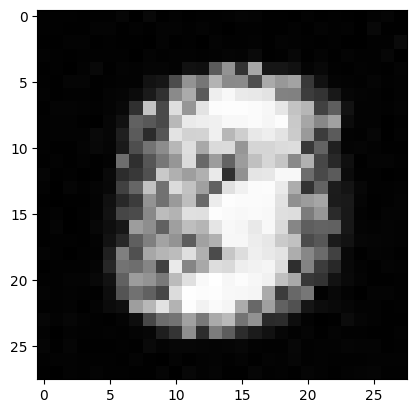

Epoch: 50550
loss_g: 2.1825311183929443 	loss_d: 0.36288973689079285
Epoch: 50600
loss_g: 2.1397476196289062 	loss_d: 0.36447611451148987
Epoch: 50650
loss_g: 2.168956995010376 	loss_d: 0.34085962176322937
Epoch: 50700
loss_g: 2.1902904510498047 	loss_d: 0.3387399911880493
Epoch: 50750
loss_g: 2.1911935806274414 	loss_d: 0.3405236005783081
Epoch: 50800
loss_g: 2.17814564704895 	loss_d: 0.3603978753089905
Epoch: 50850
loss_g: 2.2097902297973633 	loss_d: 0.3345920145511627
Epoch: 50900
loss_g: 2.197282075881958 	loss_d: 0.35000595450401306
Epoch: 50950
loss_g: 2.193577766418457 	loss_d: 0.3613177537918091
Epoch: 51000
loss_g: 2.198127269744873 	loss_d: 0.3531942665576935
Ploting:  1


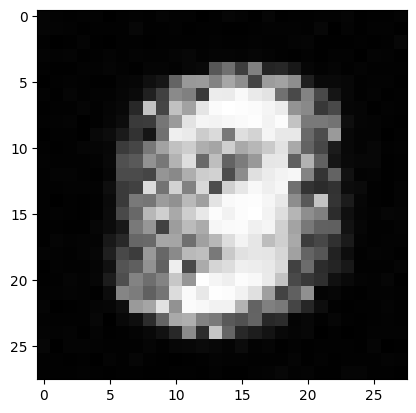

Ploting:  5


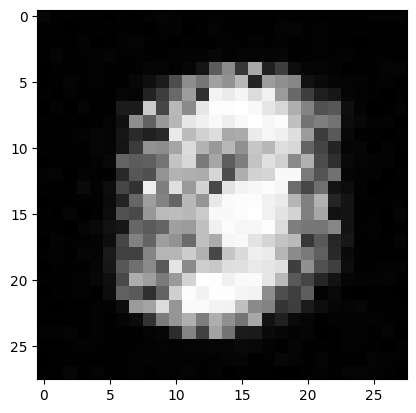

Ploting:  9


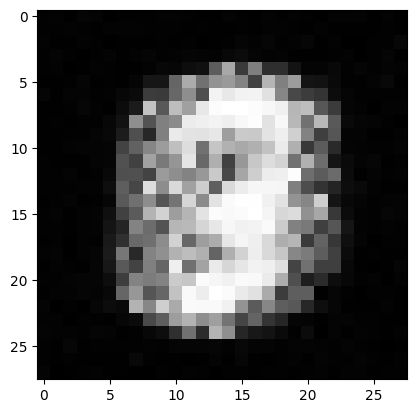

Epoch: 51050
loss_g: 2.1743991374969482 	loss_d: 0.3559020161628723
Epoch: 51100
loss_g: 2.1910202503204346 	loss_d: 0.3427239954471588
Epoch: 51150
loss_g: 2.197535514831543 	loss_d: 0.3530929386615753
Epoch: 51200
loss_g: 2.219982862472534 	loss_d: 0.36793580651283264
Epoch: 51250
loss_g: 2.2167794704437256 	loss_d: 0.32866308093070984
Epoch: 51300
loss_g: 2.211139678955078 	loss_d: 0.33214351534843445
Epoch: 51350
loss_g: 2.2271640300750732 	loss_d: 0.3485548198223114
Epoch: 51400
loss_g: 2.2358734607696533 	loss_d: 0.36411502957344055
Epoch: 51450
loss_g: 2.219867467880249 	loss_d: 0.3345571756362915
Epoch: 51500
loss_g: 2.2208406925201416 	loss_d: 0.34017130732536316
Ploting:  4


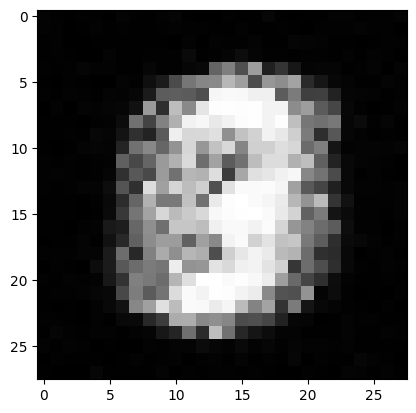

Ploting:  4


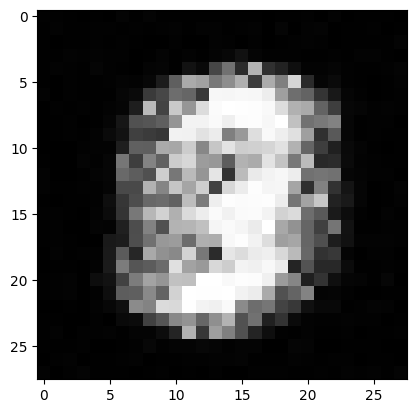

Ploting:  1


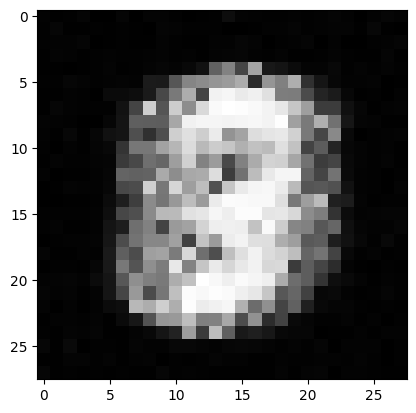

Epoch: 51550
loss_g: 2.1965532302856445 	loss_d: 0.3257450759410858
Epoch: 51600
loss_g: 2.2393484115600586 	loss_d: 0.3314022421836853
Epoch: 51650
loss_g: 2.2268178462982178 	loss_d: 0.3423708975315094
Epoch: 51700
loss_g: 2.2420647144317627 	loss_d: 0.32323622703552246
Epoch: 51750
loss_g: 2.2162251472473145 	loss_d: 0.316584050655365
Epoch: 51800
loss_g: 2.2331318855285645 	loss_d: 0.32885831594467163
Epoch: 51850
loss_g: 2.236060857772827 	loss_d: 0.33407554030418396
Epoch: 51900
loss_g: 2.240527391433716 	loss_d: 0.34620821475982666
Epoch: 51950
loss_g: 2.243429660797119 	loss_d: 0.314163476228714
Epoch: 52000
loss_g: 2.243241548538208 	loss_d: 0.33870193362236023
Ploting:  9


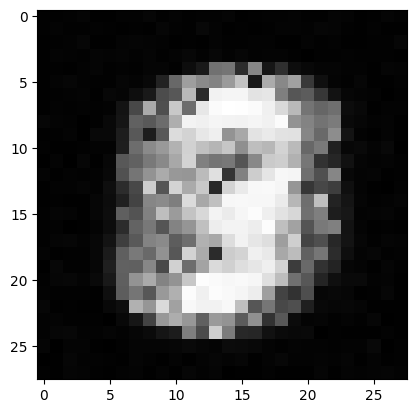

Ploting:  3


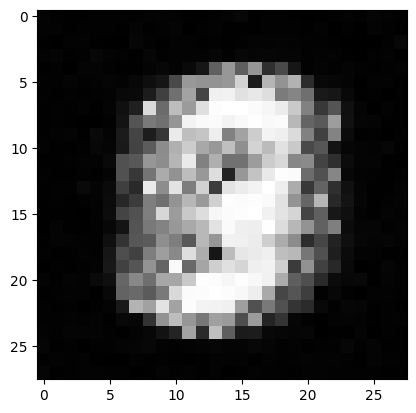

Ploting:  4


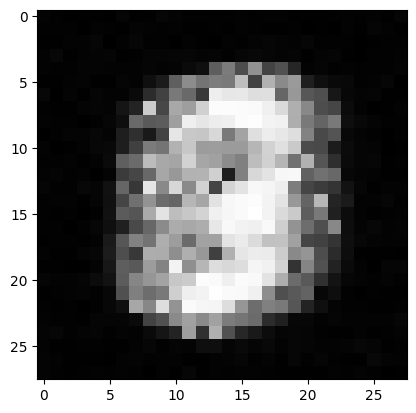

Epoch: 52050
loss_g: 2.2474124431610107 	loss_d: 0.31774815917015076
Epoch: 52100
loss_g: 2.248715400695801 	loss_d: 0.3142297565937042
Epoch: 52150
loss_g: 2.2414889335632324 	loss_d: 0.36028629541397095
Epoch: 52200
loss_g: 2.222825050354004 	loss_d: 0.33848148584365845
Epoch: 52250
loss_g: 2.229541063308716 	loss_d: 0.3469918668270111
Epoch: 52300
loss_g: 2.239171028137207 	loss_d: 0.34308236837387085
Epoch: 52350
loss_g: 2.2465877532958984 	loss_d: 0.3375474512577057
Epoch: 52400
loss_g: 2.258934259414673 	loss_d: 0.358548641204834
Epoch: 52450
loss_g: 2.260830879211426 	loss_d: 0.3063221573829651
Epoch: 52500
loss_g: 2.2449612617492676 	loss_d: 0.3255826532840729
Ploting:  2


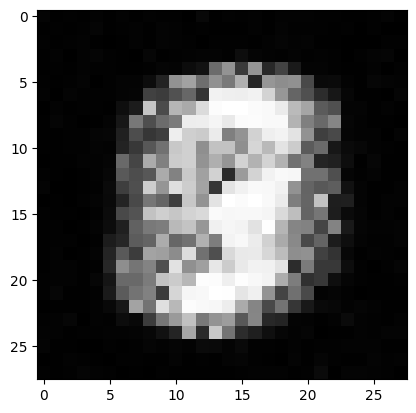

Ploting:  0


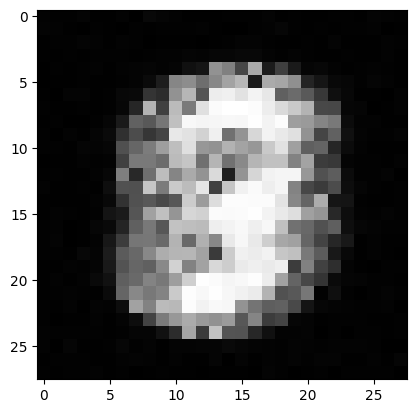

Ploting:  8


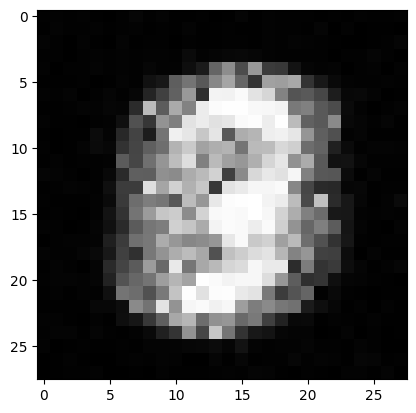

Epoch: 52550
loss_g: 2.243783712387085 	loss_d: 0.32535621523857117
Epoch: 52600
loss_g: 2.244037628173828 	loss_d: 0.3152119219303131
Epoch: 52650
loss_g: 2.271812677383423 	loss_d: 0.32269519567489624
Epoch: 52700
loss_g: 2.245055913925171 	loss_d: 0.30930933356285095
Epoch: 52750
loss_g: 2.2607927322387695 	loss_d: 0.30096638202667236
Epoch: 52800
loss_g: 2.274125814437866 	loss_d: 0.3299180567264557
Epoch: 52850
loss_g: 2.291957139968872 	loss_d: 0.3080245852470398
Epoch: 52900
loss_g: 2.2594611644744873 	loss_d: 0.3036644756793976
Epoch: 52950
loss_g: 2.262476682662964 	loss_d: 0.3250848054885864
Epoch: 53000
loss_g: 2.264902353286743 	loss_d: 0.3149665892124176
Ploting:  5


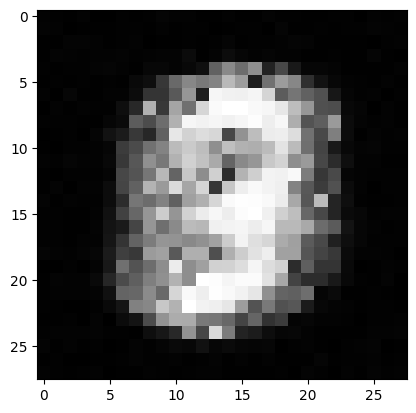

Ploting:  2


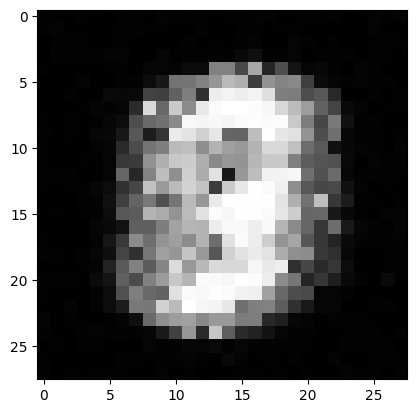

Ploting:  5


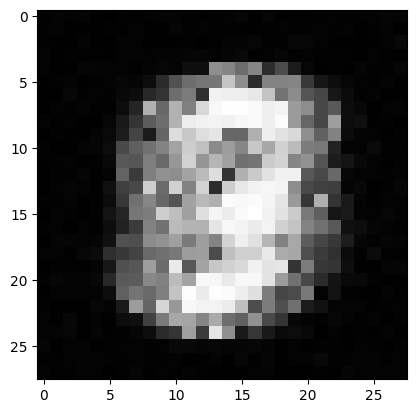

Epoch: 53050
loss_g: 2.253390073776245 	loss_d: 0.2991897463798523
Epoch: 53100
loss_g: 2.2751219272613525 	loss_d: 0.2992393374443054
Epoch: 53150
loss_g: 2.286520004272461 	loss_d: 0.30129045248031616
Epoch: 53200
loss_g: 2.245161294937134 	loss_d: 0.30890554189682007
Epoch: 53250
loss_g: 2.2546443939208984 	loss_d: 0.2929123640060425
Epoch: 53300
loss_g: 2.2609872817993164 	loss_d: 0.31672003865242004
Epoch: 53350
loss_g: 2.274609088897705 	loss_d: 0.33124786615371704
Epoch: 53400
loss_g: 2.268981695175171 	loss_d: 0.3193756341934204
Epoch: 53450
loss_g: 2.2510056495666504 	loss_d: 0.31907904148101807
Epoch: 53500
loss_g: 2.2420637607574463 	loss_d: 0.3081667721271515
Ploting:  8


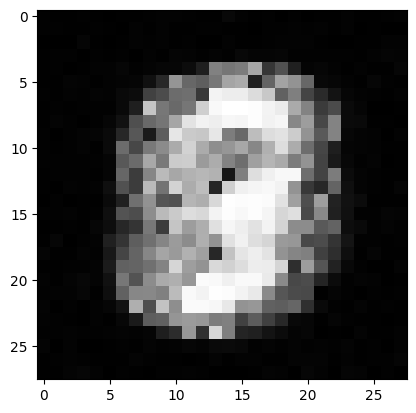

Ploting:  9


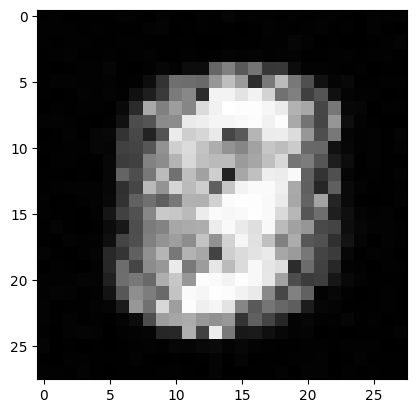

Ploting:  3


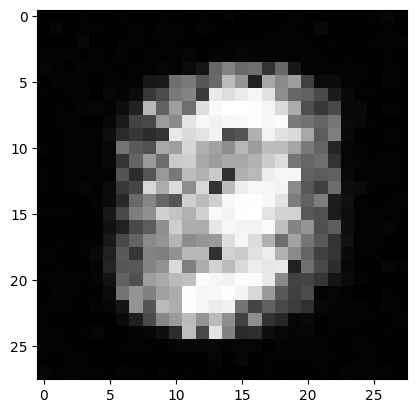

Epoch: 53550
loss_g: 2.2610089778900146 	loss_d: 0.316985547542572
Epoch: 53600
loss_g: 2.2629404067993164 	loss_d: 0.33406516909599304
Epoch: 53650
loss_g: 2.269120693206787 	loss_d: 0.29633578658103943
Epoch: 53700
loss_g: 2.2552881240844727 	loss_d: 0.30447572469711304
Epoch: 53750
loss_g: 2.263503074645996 	loss_d: 0.3215411305427551
Epoch: 53800
loss_g: 2.2589142322540283 	loss_d: 0.332338809967041
Epoch: 53850
loss_g: 2.2763891220092773 	loss_d: 0.30513012409210205
Epoch: 53900
loss_g: 2.257948160171509 	loss_d: 0.315877765417099
Epoch: 53950
loss_g: 2.240598201751709 	loss_d: 0.2963632643222809
Epoch: 54000
loss_g: 2.2651314735412598 	loss_d: 0.30935636162757874
Ploting:  5


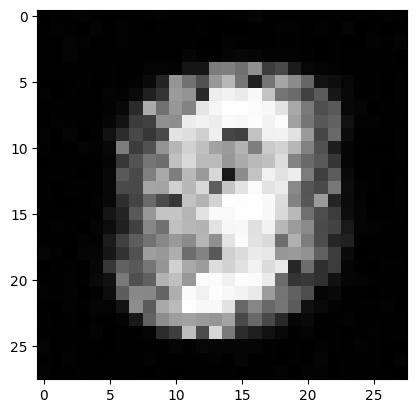

Ploting:  6


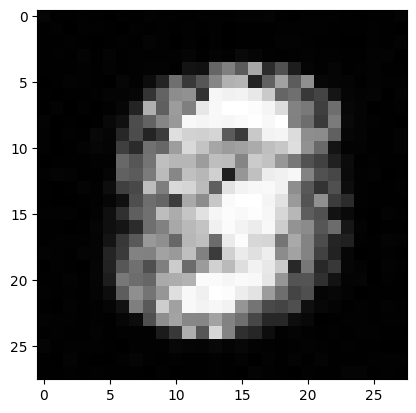

Ploting:  6


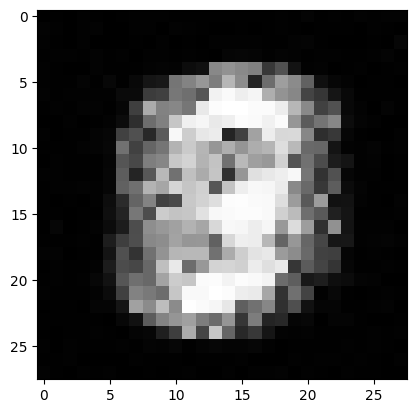

Epoch: 54050
loss_g: 2.2654571533203125 	loss_d: 0.31719332933425903
Epoch: 54100
loss_g: 2.250196695327759 	loss_d: 0.2989436686038971
Epoch: 54150
loss_g: 2.2584304809570312 	loss_d: 0.28814762830734253
Epoch: 54200
loss_g: 2.27398681640625 	loss_d: 0.31006941199302673
Epoch: 54250
loss_g: 2.282052516937256 	loss_d: 0.3118772506713867
Epoch: 54300
loss_g: 2.2720558643341064 	loss_d: 0.3261151909828186
Epoch: 54350
loss_g: 2.2650837898254395 	loss_d: 0.30075129866600037
Epoch: 54400
loss_g: 2.247992753982544 	loss_d: 0.3219860792160034
Epoch: 54450
loss_g: 2.247546434402466 	loss_d: 0.2984364628791809
Epoch: 54500
loss_g: 2.2681338787078857 	loss_d: 0.2968129813671112
Ploting:  5


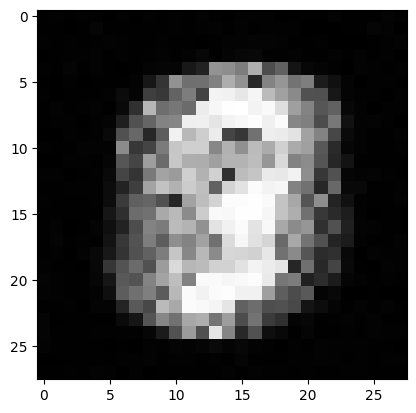

Ploting:  1


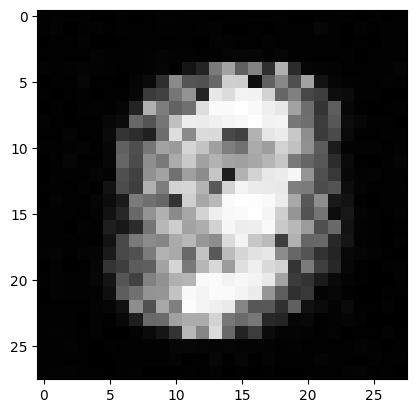

Ploting:  0


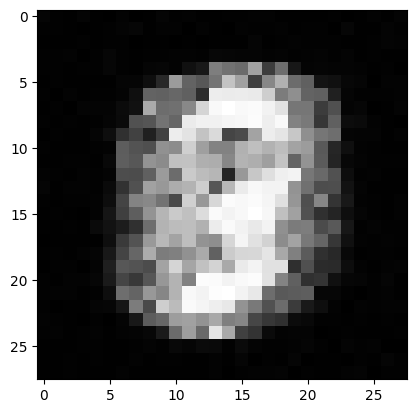

Epoch: 54550
loss_g: 2.239130735397339 	loss_d: 0.34067413210868835
Epoch: 54600
loss_g: 2.246546506881714 	loss_d: 0.33234015107154846
Epoch: 54650
loss_g: 2.255222797393799 	loss_d: 0.33985891938209534
Epoch: 54700
loss_g: 2.265803575515747 	loss_d: 0.3279675245285034
Epoch: 54750
loss_g: 2.255358934402466 	loss_d: 0.31920158863067627
Epoch: 54800
loss_g: 2.2505691051483154 	loss_d: 0.34714990854263306
Epoch: 54850
loss_g: 2.249152183532715 	loss_d: 0.2991509437561035
Epoch: 54900
loss_g: 2.2280263900756836 	loss_d: 0.3206544816493988
Epoch: 54950
loss_g: 2.235687732696533 	loss_d: 0.321239173412323
Epoch: 55000
loss_g: 2.2394020557403564 	loss_d: 0.307522177696228
Ploting:  0


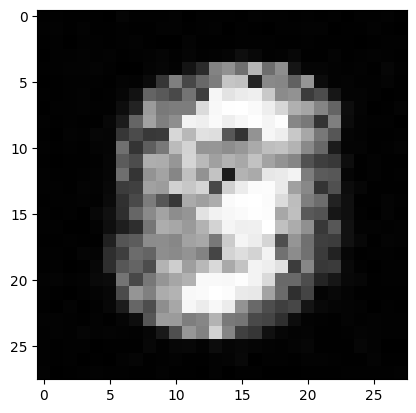

Ploting:  8


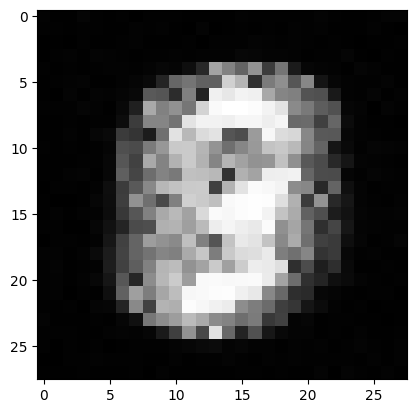

Ploting:  9


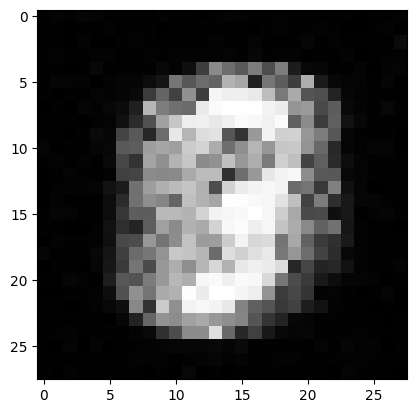

Epoch: 55050
loss_g: 2.2450201511383057 	loss_d: 0.3105922341346741
Epoch: 55100
loss_g: 2.229574203491211 	loss_d: 0.30506637692451477
Epoch: 55150
loss_g: 2.2445738315582275 	loss_d: 0.2900487184524536
Epoch: 55200
loss_g: 2.232501983642578 	loss_d: 0.334582656621933
Epoch: 55250
loss_g: 2.2489404678344727 	loss_d: 0.29950588941574097
Epoch: 55300
loss_g: 2.2250545024871826 	loss_d: 0.303455650806427
Epoch: 55350
loss_g: 2.226839542388916 	loss_d: 0.32587629556655884
Epoch: 55400
loss_g: 2.233215093612671 	loss_d: 0.3148214817047119
Epoch: 55450
loss_g: 2.224794864654541 	loss_d: 0.2966378629207611
Epoch: 55500
loss_g: 2.240445852279663 	loss_d: 0.3000016212463379
Ploting:  9


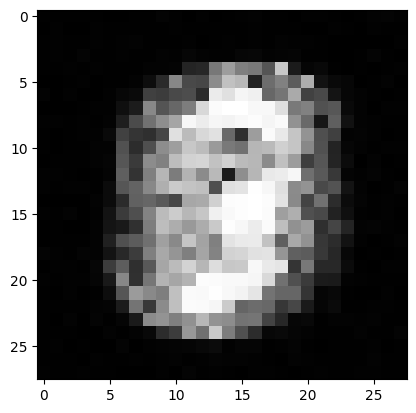

Ploting:  5


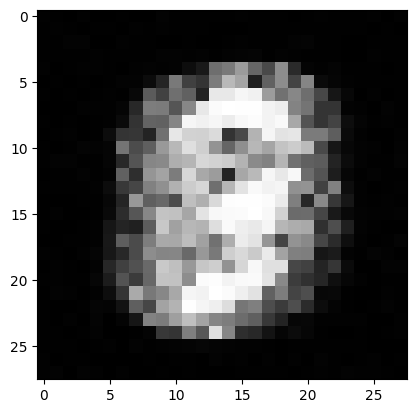

Ploting:  5


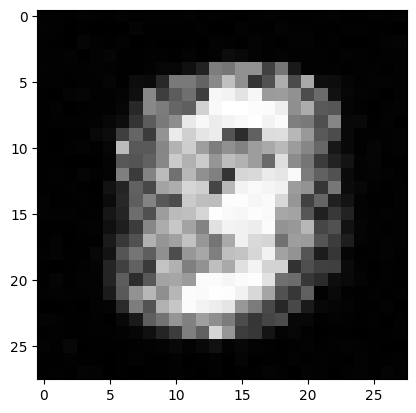

Epoch: 55550
loss_g: 2.2258784770965576 	loss_d: 0.3049791753292084
Epoch: 55600
loss_g: 2.2238783836364746 	loss_d: 0.3035580813884735
Epoch: 55650
loss_g: 2.2414708137512207 	loss_d: 0.29206886887550354
Epoch: 55700
loss_g: 2.216031789779663 	loss_d: 0.3175294101238251
Epoch: 55750
loss_g: 2.227064847946167 	loss_d: 0.34818553924560547
Epoch: 55800
loss_g: 2.2404956817626953 	loss_d: 0.3316192030906677
Epoch: 55850
loss_g: 2.24806809425354 	loss_d: 0.3290427625179291
Epoch: 55900
loss_g: 2.214803695678711 	loss_d: 0.3129185736179352
Epoch: 55950
loss_g: 2.2272446155548096 	loss_d: 0.32615476846694946
Epoch: 56000
loss_g: 2.2330374717712402 	loss_d: 0.33652690052986145
Ploting:  6


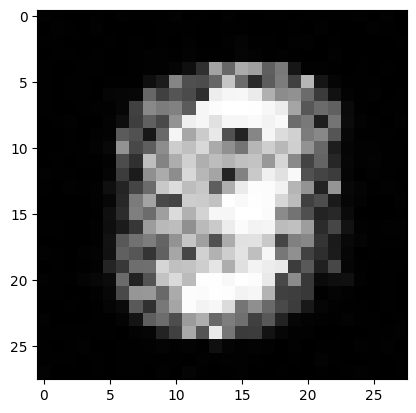

Ploting:  5


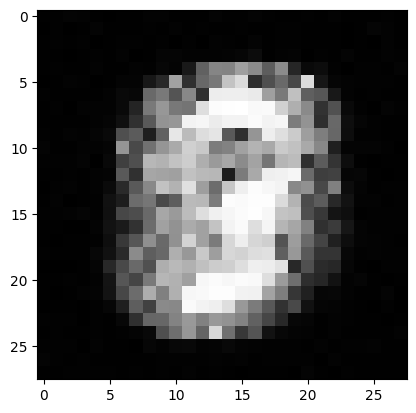

Ploting:  6


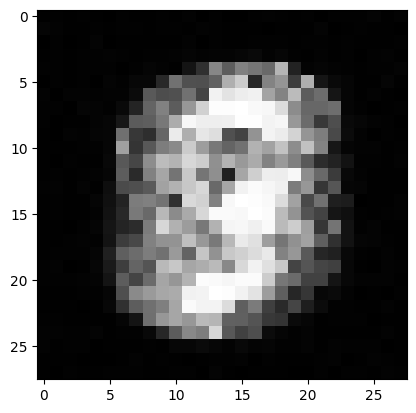

Epoch: 56050
loss_g: 2.213811159133911 	loss_d: 0.3042301535606384
Epoch: 56100
loss_g: 2.225600481033325 	loss_d: 0.31843116879463196
Epoch: 56150
loss_g: 2.219865560531616 	loss_d: 0.3315051198005676
Epoch: 56200
loss_g: 2.2249090671539307 	loss_d: 0.34175002574920654
Epoch: 56250
loss_g: 2.213073968887329 	loss_d: 0.3085685670375824
Epoch: 56300
loss_g: 2.2125062942504883 	loss_d: 0.3276617228984833
Epoch: 56350
loss_g: 2.2012345790863037 	loss_d: 0.30218765139579773
Epoch: 56400
loss_g: 2.2077505588531494 	loss_d: 0.3166438937187195
Epoch: 56450
loss_g: 2.2207536697387695 	loss_d: 0.32265540957450867
Epoch: 56500
loss_g: 2.223156690597534 	loss_d: 0.30717378854751587
Ploting:  3


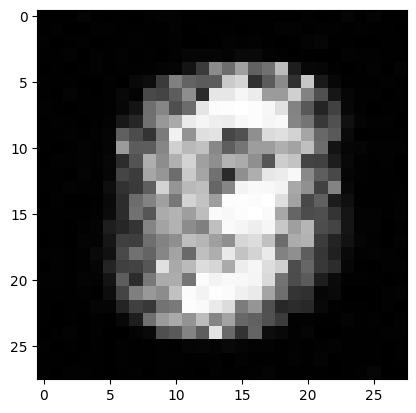

Ploting:  6


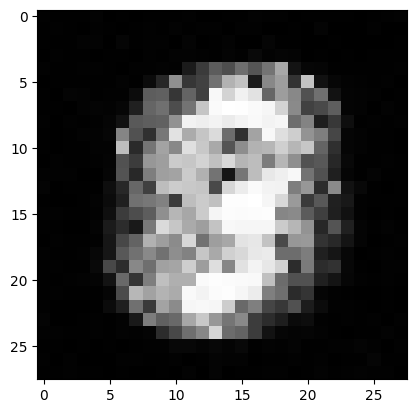

Ploting:  8


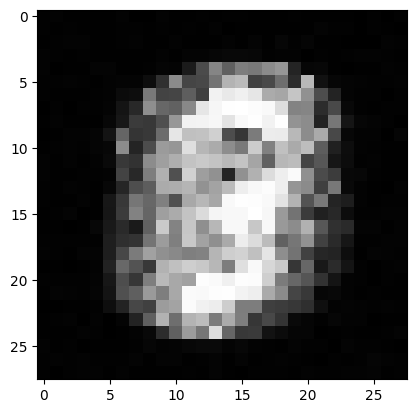

Epoch: 56550
loss_g: 2.2336885929107666 	loss_d: 0.2893092930316925
Epoch: 56600
loss_g: 2.2160985469818115 	loss_d: 0.3192601203918457
Epoch: 56650
loss_g: 2.230194568634033 	loss_d: 0.3202041685581207
Epoch: 56700
loss_g: 2.212446689605713 	loss_d: 0.3325868248939514
Epoch: 56750
loss_g: 2.2295162677764893 	loss_d: 0.3159385025501251
Epoch: 56800
loss_g: 2.2261574268341064 	loss_d: 0.32840386033058167
Epoch: 56850
loss_g: 2.21193265914917 	loss_d: 0.3090483844280243
Epoch: 56900
loss_g: 2.203800678253174 	loss_d: 0.29913854598999023
Epoch: 56950
loss_g: 2.203308343887329 	loss_d: 0.3420579135417938
Epoch: 57000
loss_g: 2.2082746028900146 	loss_d: 0.34795501828193665
Ploting:  2


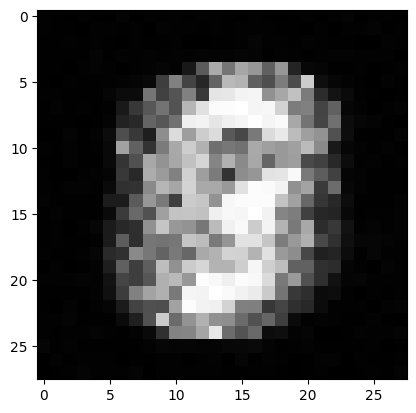

Ploting:  9


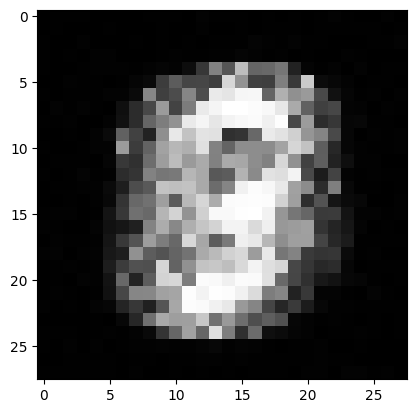

Ploting:  3


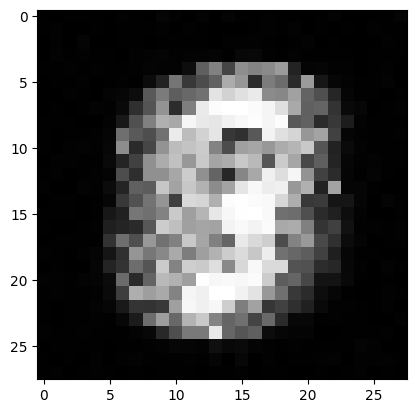

Epoch: 57050
loss_g: 2.2186360359191895 	loss_d: 0.34762194752693176
Epoch: 57100
loss_g: 2.193758726119995 	loss_d: 0.3287597894668579
Epoch: 57150
loss_g: 2.2113542556762695 	loss_d: 0.3183665871620178
Epoch: 57200
loss_g: 2.2184653282165527 	loss_d: 0.34622007608413696
Epoch: 57250
loss_g: 2.203791379928589 	loss_d: 0.3004854619503021
Epoch: 57300
loss_g: 2.2029778957366943 	loss_d: 0.3338131010532379
Epoch: 57350
loss_g: 2.2136948108673096 	loss_d: 0.3239983916282654
Epoch: 57400
loss_g: 2.221900224685669 	loss_d: 0.30145999789237976
Epoch: 57450
loss_g: 2.232063055038452 	loss_d: 0.3091523349285126
Epoch: 57500
loss_g: 2.2240984439849854 	loss_d: 0.3055233657360077
Ploting:  3


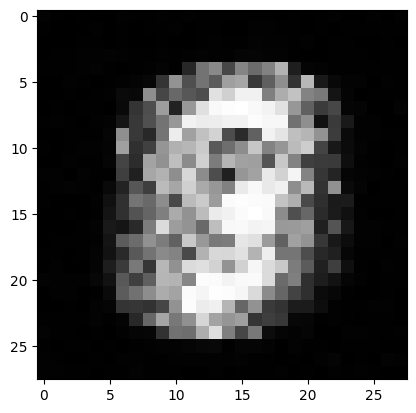

Ploting:  0


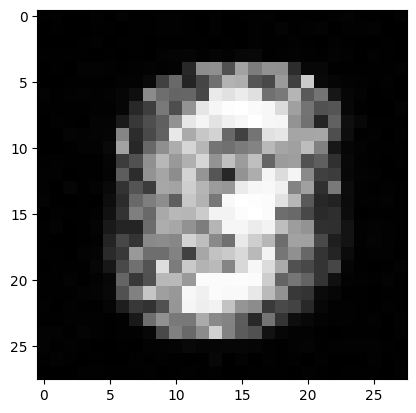

Ploting:  0


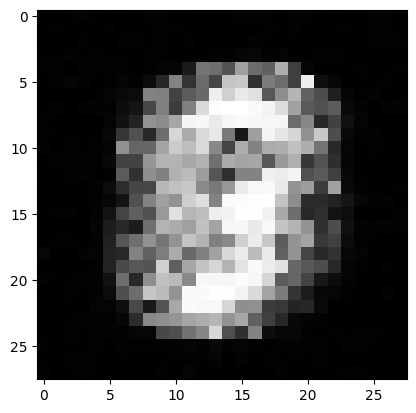

Epoch: 57550
loss_g: 2.2125518321990967 	loss_d: 0.28712284564971924
Epoch: 57600
loss_g: 2.220428228378296 	loss_d: 0.33665934205055237
Epoch: 57650
loss_g: 2.2298622131347656 	loss_d: 0.29484739899635315
Epoch: 57700
loss_g: 2.2108983993530273 	loss_d: 0.30202674865722656
Epoch: 57750
loss_g: 2.2309482097625732 	loss_d: 0.32235321402549744
Epoch: 57800
loss_g: 2.229151487350464 	loss_d: 0.3080911636352539
Epoch: 57850
loss_g: 2.211763858795166 	loss_d: 0.2874900996685028
Epoch: 57900
loss_g: 2.216715097427368 	loss_d: 0.29189497232437134
Epoch: 57950
loss_g: 2.2193198204040527 	loss_d: 0.30085620284080505
Epoch: 58000
loss_g: 2.232184410095215 	loss_d: 0.2909005284309387
Ploting:  3


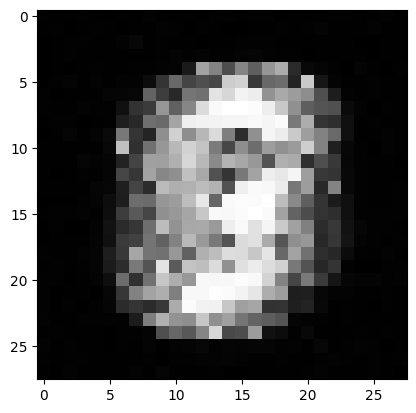

Ploting:  2


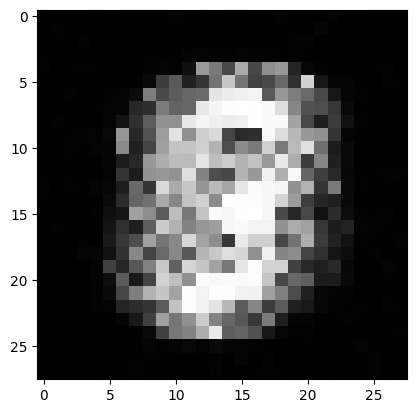

Ploting:  9


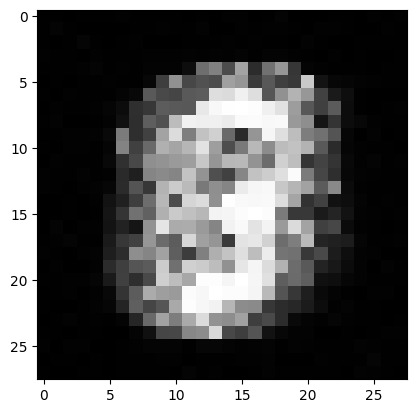

Epoch: 58050
loss_g: 2.234973907470703 	loss_d: 0.28396984934806824
Epoch: 58100
loss_g: 2.2355384826660156 	loss_d: 0.3098951578140259
Epoch: 58150
loss_g: 2.249281167984009 	loss_d: 0.34332793951034546
Epoch: 58200
loss_g: 2.2242753505706787 	loss_d: 0.3278326094150543
Epoch: 58250
loss_g: 2.2274210453033447 	loss_d: 0.3139699399471283
Epoch: 58300
loss_g: 2.2221312522888184 	loss_d: 0.30112430453300476
Epoch: 58350
loss_g: 2.2597646713256836 	loss_d: 0.31279152631759644
Epoch: 58400
loss_g: 2.2492520809173584 	loss_d: 0.31709375977516174
Epoch: 58450
loss_g: 2.2304329872131348 	loss_d: 0.29182636737823486
Epoch: 58500
loss_g: 2.252330780029297 	loss_d: 0.3073898255825043
Ploting:  3


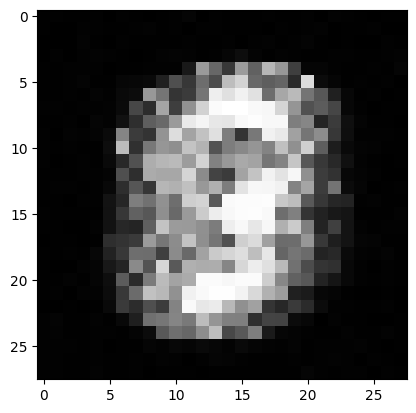

Ploting:  7


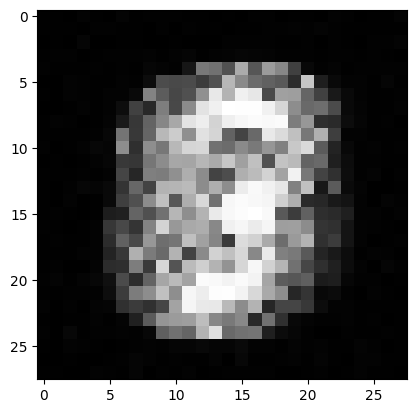

Ploting:  6


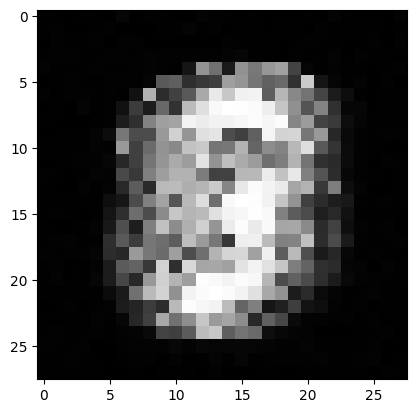

Epoch: 58550
loss_g: 2.2491884231567383 	loss_d: 0.31752586364746094
Epoch: 58600
loss_g: 2.2534868717193604 	loss_d: 0.3217874765396118
Epoch: 58650
loss_g: 2.2323365211486816 	loss_d: 0.2917367219924927
Epoch: 58700
loss_g: 2.270671844482422 	loss_d: 0.3016616702079773
Epoch: 58750
loss_g: 2.253796339035034 	loss_d: 0.28315064311027527
Epoch: 58800
loss_g: 2.260775327682495 	loss_d: 0.2954356372356415
Epoch: 58850
loss_g: 2.265927791595459 	loss_d: 0.30312642455101013
Epoch: 58900
loss_g: 2.277594566345215 	loss_d: 0.28329288959503174
Epoch: 58950
loss_g: 2.280585527420044 	loss_d: 0.26352590322494507
Epoch: 59000
loss_g: 2.273700475692749 	loss_d: 0.2921903729438782
Ploting:  9


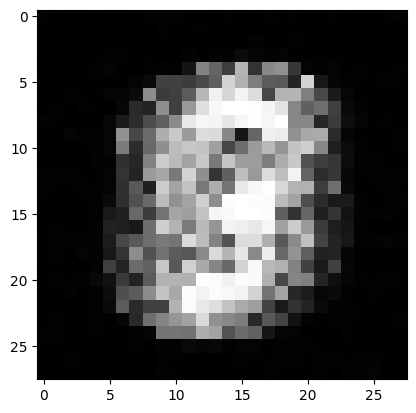

Ploting:  0


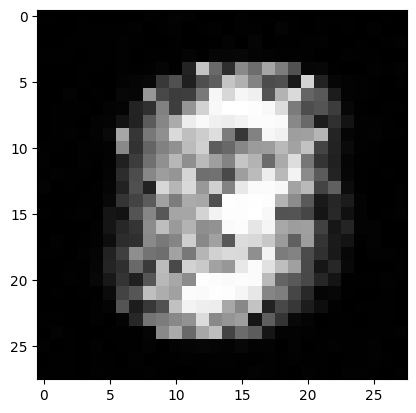

Ploting:  7


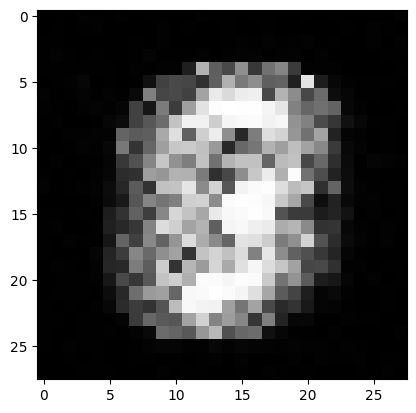

Epoch: 59050
loss_g: 2.2704336643218994 	loss_d: 0.29560741782188416
Epoch: 59100
loss_g: 2.2990546226501465 	loss_d: 0.3087260127067566
Epoch: 59150
loss_g: 2.2579236030578613 	loss_d: 0.2983883321285248
Epoch: 59200
loss_g: 2.266327142715454 	loss_d: 0.2981315553188324
Epoch: 59250
loss_g: 2.267826557159424 	loss_d: 0.2835521101951599
Epoch: 59300
loss_g: 2.276629686355591 	loss_d: 0.27201011776924133
Epoch: 59350
loss_g: 2.2705366611480713 	loss_d: 0.30939599871635437
Epoch: 59400
loss_g: 2.277608633041382 	loss_d: 0.31679725646972656
Epoch: 59450
loss_g: 2.2824954986572266 	loss_d: 0.3188723027706146
Epoch: 59500
loss_g: 2.3119332790374756 	loss_d: 0.29425543546676636
Ploting:  8


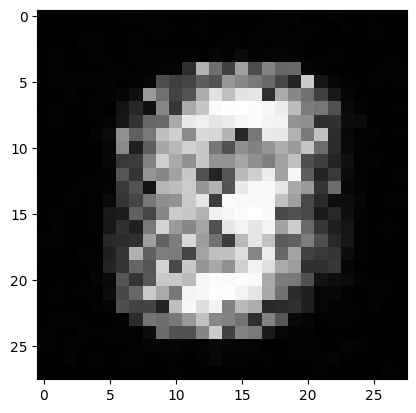

Ploting:  5


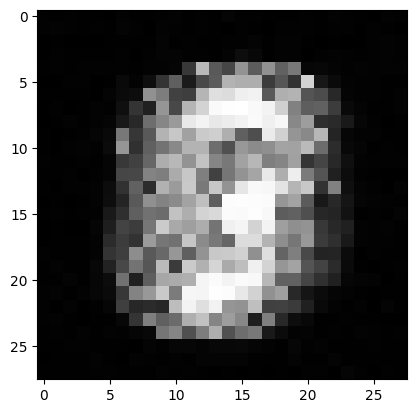

Ploting:  7


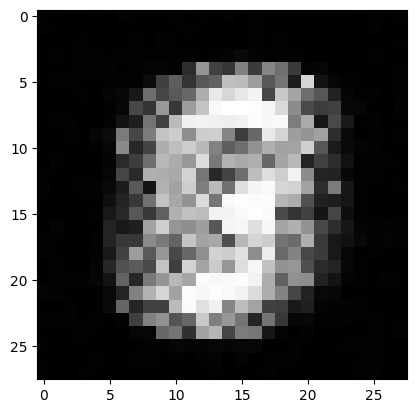

Epoch: 59550
loss_g: 2.279250144958496 	loss_d: 0.2820054590702057
Epoch: 59600
loss_g: 2.2812232971191406 	loss_d: 0.305153489112854
Epoch: 59650
loss_g: 2.3067476749420166 	loss_d: 0.27132076025009155
Epoch: 59700
loss_g: 2.2713851928710938 	loss_d: 0.30629032850265503
Epoch: 59750
loss_g: 2.3055474758148193 	loss_d: 0.2918750047683716
Epoch: 59800
loss_g: 2.2826056480407715 	loss_d: 0.26920798420906067
Epoch: 59850
loss_g: 2.298907995223999 	loss_d: 0.27535897493362427
Epoch: 59900
loss_g: 2.2943005561828613 	loss_d: 0.2756083607673645
Epoch: 59950
loss_g: 2.3046441078186035 	loss_d: 0.2546078562736511
Epoch: 60000
loss_g: 2.2925260066986084 	loss_d: 0.3005264699459076
Ploting:  6


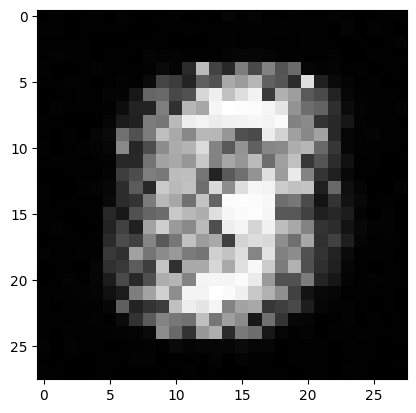

Ploting:  5


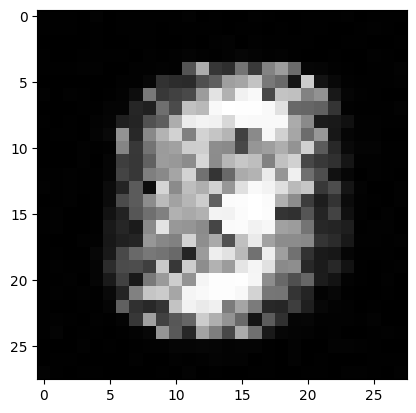

Ploting:  6


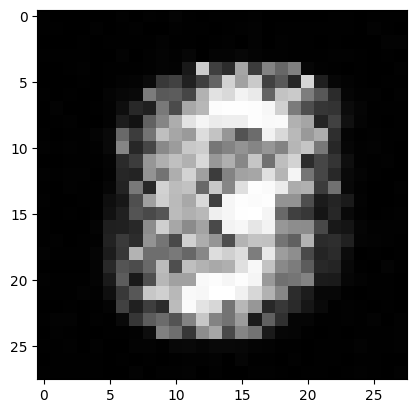

Epoch: 60050
loss_g: 2.3086090087890625 	loss_d: 0.25548255443573
Epoch: 60100
loss_g: 2.2905542850494385 	loss_d: 0.26972416043281555
Epoch: 60150
loss_g: 2.3164494037628174 	loss_d: 0.28976768255233765
Epoch: 60200
loss_g: 2.3064093589782715 	loss_d: 0.26835763454437256
Epoch: 60250
loss_g: 2.3283941745758057 	loss_d: 0.2531775236129761
Epoch: 60300
loss_g: 2.326622486114502 	loss_d: 0.2573305368423462
Epoch: 60350
loss_g: 2.3045244216918945 	loss_d: 0.2696230709552765
Epoch: 60400
loss_g: 2.3281610012054443 	loss_d: 0.25653326511383057
Epoch: 60450
loss_g: 2.3190274238586426 	loss_d: 0.24962753057479858
Epoch: 60500
loss_g: 2.323730230331421 	loss_d: 0.27056944370269775
Ploting:  8


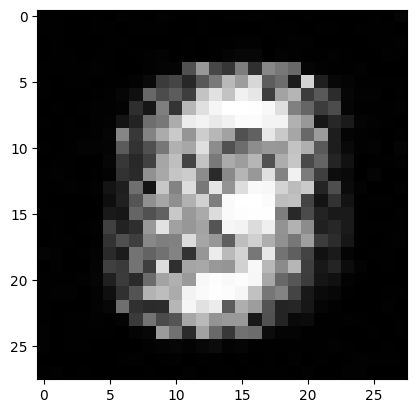

Ploting:  3


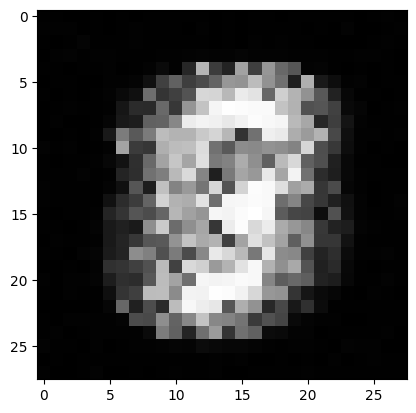

Ploting:  2


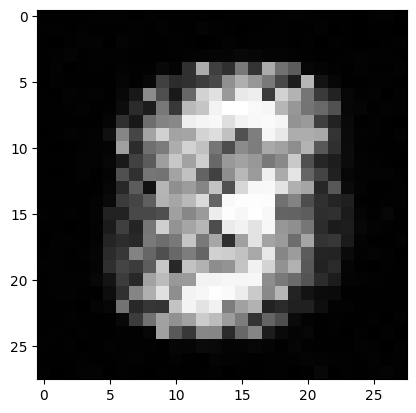

Epoch: 60550
loss_g: 2.3244073390960693 	loss_d: 0.311679869890213
Epoch: 60600
loss_g: 2.302442789077759 	loss_d: 0.29796525835990906
Epoch: 60650
loss_g: 2.3190841674804688 	loss_d: 0.2780782878398895
Epoch: 60700
loss_g: 2.3025307655334473 	loss_d: 0.26916247606277466
Epoch: 60750
loss_g: 2.302932024002075 	loss_d: 0.28373634815216064
Epoch: 60800
loss_g: 2.33164381980896 	loss_d: 0.2797757685184479
Epoch: 60850
loss_g: 2.313504219055176 	loss_d: 0.26413246989250183
Epoch: 60900
loss_g: 2.325679302215576 	loss_d: 0.271858811378479
Epoch: 60950
loss_g: 2.3158769607543945 	loss_d: 0.28576141595840454
Epoch: 61000
loss_g: 2.332303285598755 	loss_d: 0.29285934567451477
Ploting:  5


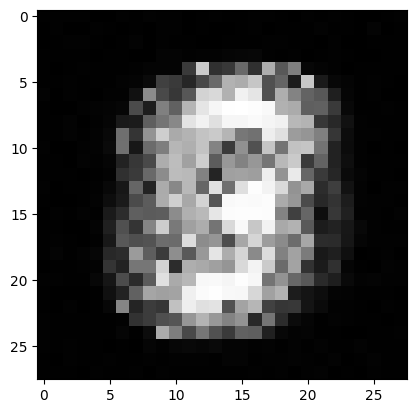

Ploting:  1


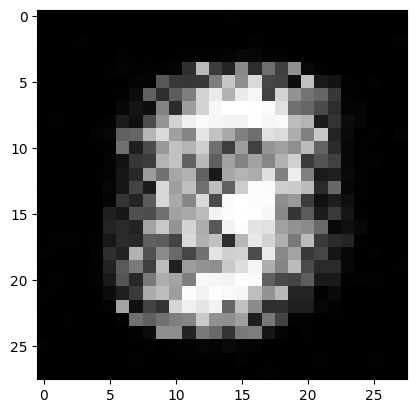

Ploting:  7


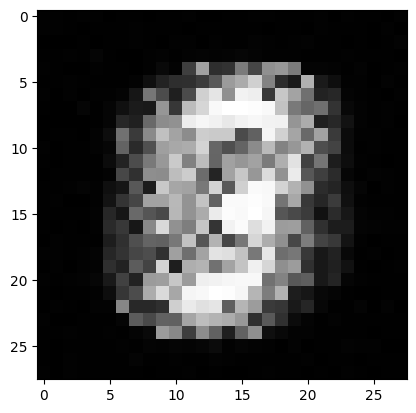

Epoch: 61050
loss_g: 2.3149590492248535 	loss_d: 0.2620239853858948
Epoch: 61100
loss_g: 2.3350579738616943 	loss_d: 0.26714664697647095
Epoch: 61150
loss_g: 2.32745623588562 	loss_d: 0.25607961416244507
Epoch: 61200
loss_g: 2.3155789375305176 	loss_d: 0.2588302791118622
Epoch: 61250
loss_g: 2.345498561859131 	loss_d: 0.2775326371192932
Epoch: 61300
loss_g: 2.341155767440796 	loss_d: 0.2590652108192444
Epoch: 61350
loss_g: 2.3598949909210205 	loss_d: 0.23891973495483398
Epoch: 61400
loss_g: 2.3388679027557373 	loss_d: 0.26109352707862854
Epoch: 61450
loss_g: 2.3543765544891357 	loss_d: 0.27062341570854187
Epoch: 61500
loss_g: 2.334629535675049 	loss_d: 0.2753985822200775
Ploting:  3


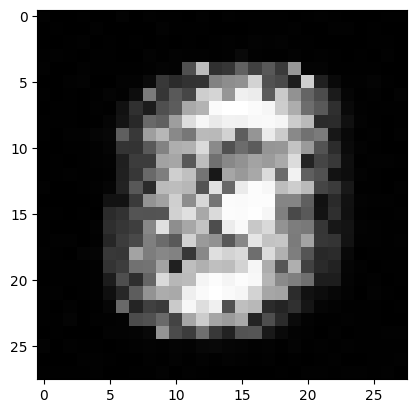

Ploting:  2


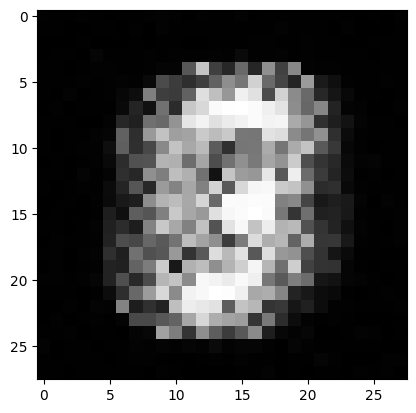

Ploting:  3


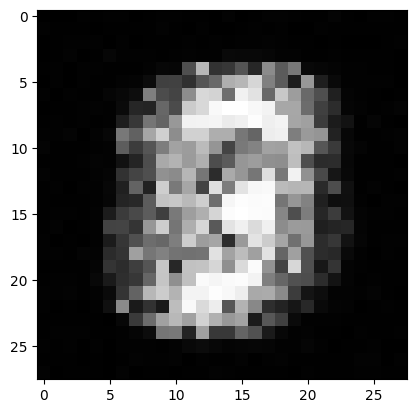

Epoch: 61550
loss_g: 2.3461720943450928 	loss_d: 0.27924373745918274
Epoch: 61600
loss_g: 2.367149591445923 	loss_d: 0.26514413952827454
Epoch: 61650
loss_g: 2.327235698699951 	loss_d: 0.25349146127700806
Epoch: 61700
loss_g: 2.3675241470336914 	loss_d: 0.24431365728378296
Epoch: 61750
loss_g: 2.3376052379608154 	loss_d: 0.27956482768058777
Epoch: 61800
loss_g: 2.337712526321411 	loss_d: 0.28457456827163696
Epoch: 61850
loss_g: 2.342772960662842 	loss_d: 0.28814998269081116
Epoch: 61900
loss_g: 2.3580846786499023 	loss_d: 0.26595035195350647
Epoch: 61950
loss_g: 2.3582146167755127 	loss_d: 0.25891226530075073
Epoch: 62000
loss_g: 2.350970506668091 	loss_d: 0.26833125948905945
Ploting:  5


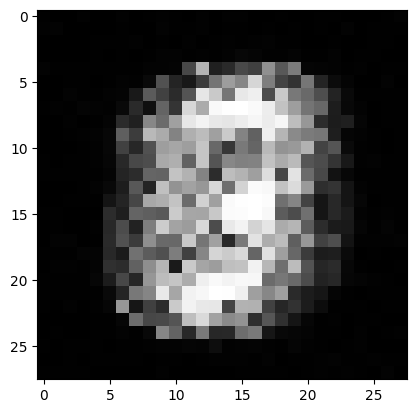

Ploting:  8


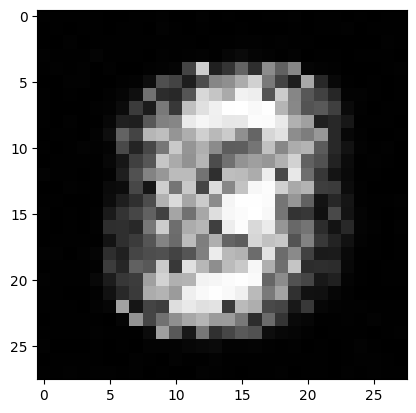

Ploting:  7


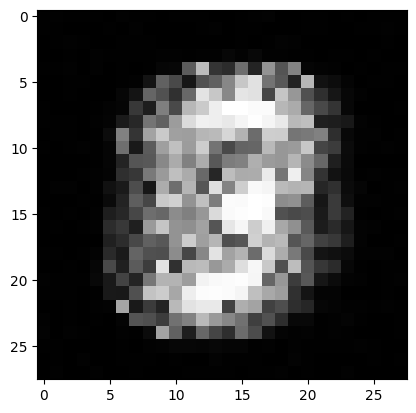

Epoch: 62050
loss_g: 2.3521807193756104 	loss_d: 0.243494912981987
Epoch: 62100
loss_g: 2.3497719764709473 	loss_d: 0.281713604927063
Epoch: 62150
loss_g: 2.363025188446045 	loss_d: 0.26556721329689026
Epoch: 62200
loss_g: 2.3481810092926025 	loss_d: 0.24428550899028778
Epoch: 62250
loss_g: 2.349482774734497 	loss_d: 0.254328191280365
Epoch: 62300
loss_g: 2.3697590827941895 	loss_d: 0.25378715991973877
Epoch: 62350
loss_g: 2.3543777465820312 	loss_d: 0.22831974923610687
Epoch: 62400
loss_g: 2.352297067642212 	loss_d: 0.27052339911460876
Epoch: 62450
loss_g: 2.3649535179138184 	loss_d: 0.23085826635360718
Epoch: 62500
loss_g: 2.3502724170684814 	loss_d: 0.24626250565052032
Ploting:  7


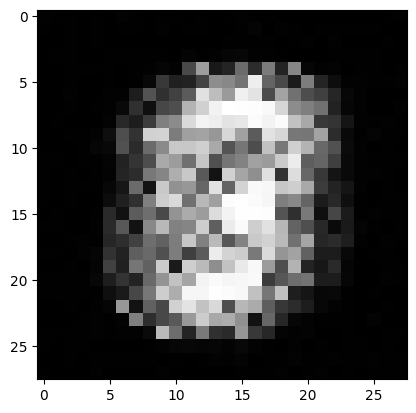

Ploting:  3


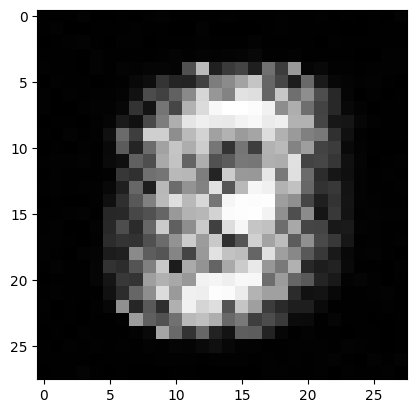

Ploting:  8


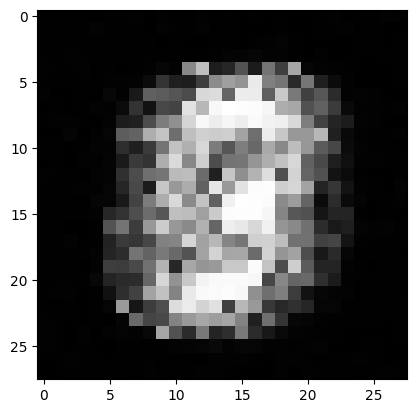

Epoch: 62550
loss_g: 2.379405975341797 	loss_d: 0.26316145062446594
Epoch: 62600
loss_g: 2.35836124420166 	loss_d: 0.2435883730649948
Epoch: 62650
loss_g: 2.3548502922058105 	loss_d: 0.22962945699691772
Epoch: 62700
loss_g: 2.346015691757202 	loss_d: 0.23685555160045624
Epoch: 62750
loss_g: 2.373908042907715 	loss_d: 0.25039777159690857
Epoch: 62800
loss_g: 2.3686583042144775 	loss_d: 0.23529136180877686
Epoch: 62850
loss_g: 2.365366220474243 	loss_d: 0.23091724514961243
Epoch: 62900
loss_g: 2.369380474090576 	loss_d: 0.24794916808605194
Epoch: 62950
loss_g: 2.3589444160461426 	loss_d: 0.28904277086257935
Epoch: 63000
loss_g: 2.346717357635498 	loss_d: 0.28332987427711487
Ploting:  9


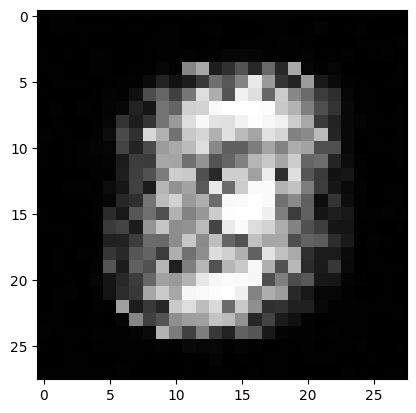

Ploting:  2


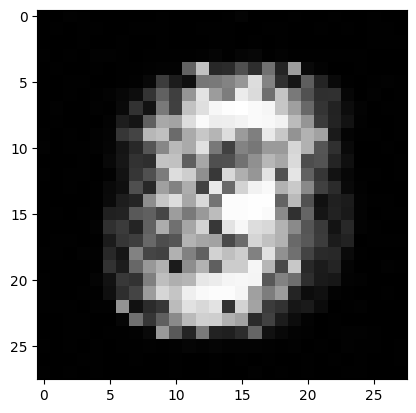

Ploting:  4


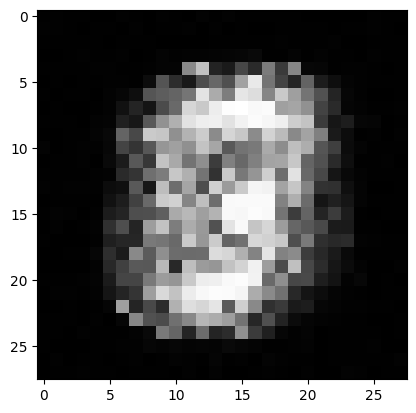

Epoch: 63050
loss_g: 2.365267515182495 	loss_d: 0.2590184211730957
Epoch: 63100
loss_g: 2.360562324523926 	loss_d: 0.25135287642478943
Epoch: 63150
loss_g: 2.3511252403259277 	loss_d: 0.27106451988220215
Epoch: 63200
loss_g: 2.357534170150757 	loss_d: 0.26323288679122925
Epoch: 63250
loss_g: 2.350980520248413 	loss_d: 0.25084733963012695
Epoch: 63300
loss_g: 2.3523008823394775 	loss_d: 0.24929097294807434
Epoch: 63350
loss_g: 2.3589744567871094 	loss_d: 0.2718796133995056
Epoch: 63400
loss_g: 2.353424310684204 	loss_d: 0.28313732147216797
Epoch: 63450
loss_g: 2.3504526615142822 	loss_d: 0.2486710250377655
Epoch: 63500
loss_g: 2.330556631088257 	loss_d: 0.24774007499217987
Ploting:  2


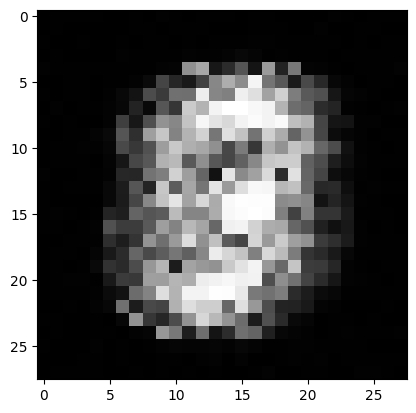

Ploting:  1


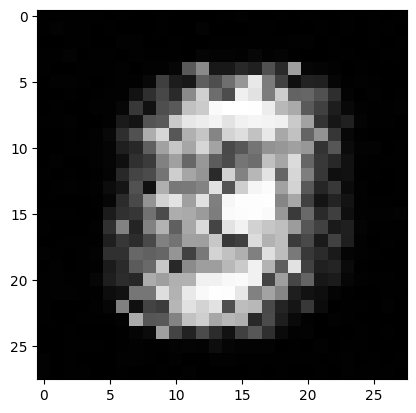

Ploting:  4


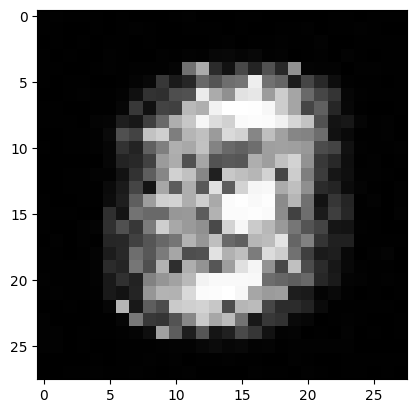

Epoch: 63550
loss_g: 2.3608152866363525 	loss_d: 0.24045325815677643
Epoch: 63600
loss_g: 2.3649139404296875 	loss_d: 0.2451620250940323
Epoch: 63650
loss_g: 2.340832233428955 	loss_d: 0.2672935128211975
Epoch: 63700
loss_g: 2.3533172607421875 	loss_d: 0.24841555953025818
Epoch: 63750
loss_g: 2.3463518619537354 	loss_d: 0.23049740493297577
Epoch: 63800
loss_g: 2.336885690689087 	loss_d: 0.25295084714889526
Epoch: 63850
loss_g: 2.3626437187194824 	loss_d: 0.2708616256713867
Epoch: 63900
loss_g: 2.3315887451171875 	loss_d: 0.27133646607398987
Epoch: 63950
loss_g: 2.324218511581421 	loss_d: 0.27725473046302795
Epoch: 64000
loss_g: 2.3580424785614014 	loss_d: 0.25835010409355164
Ploting:  6


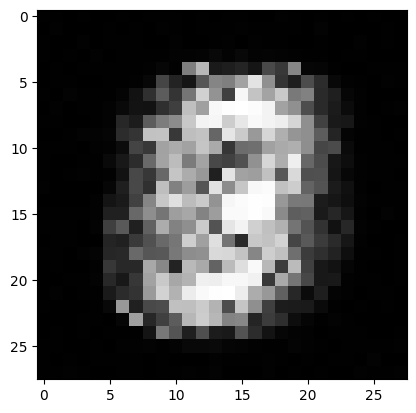

Ploting:  5


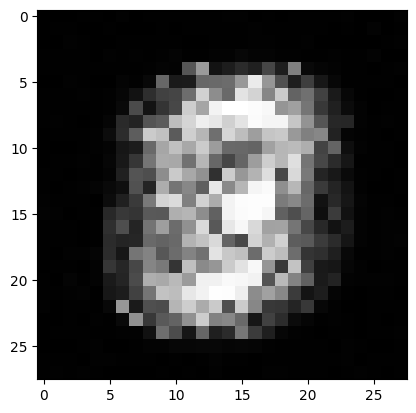

Ploting:  5


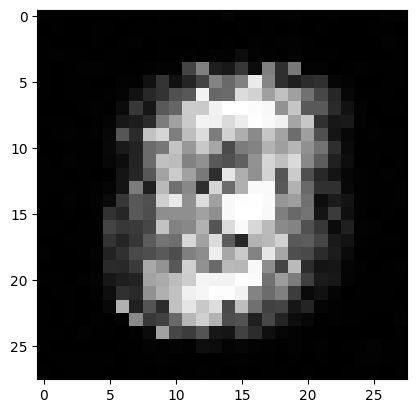

Epoch: 64050
loss_g: 2.3258206844329834 	loss_d: 0.25052037835121155
Epoch: 64100
loss_g: 2.3311638832092285 	loss_d: 0.24444934725761414
Epoch: 64150
loss_g: 2.331549882888794 	loss_d: 0.2802320420742035
Epoch: 64200
loss_g: 2.3185417652130127 	loss_d: 0.2853490114212036
Epoch: 64250
loss_g: 2.3122000694274902 	loss_d: 0.290024995803833
Epoch: 64300
loss_g: 2.3289852142333984 	loss_d: 0.26687079668045044
Epoch: 64350
loss_g: 2.319225788116455 	loss_d: 0.26885396242141724
Epoch: 64400
loss_g: 2.299862861633301 	loss_d: 0.267863005399704
Epoch: 64450
loss_g: 2.302016019821167 	loss_d: 0.2453726977109909
Epoch: 64500
loss_g: 2.2965800762176514 	loss_d: 0.29754993319511414
Ploting:  4


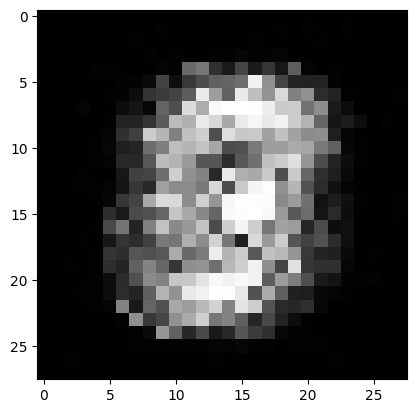

Ploting:  0


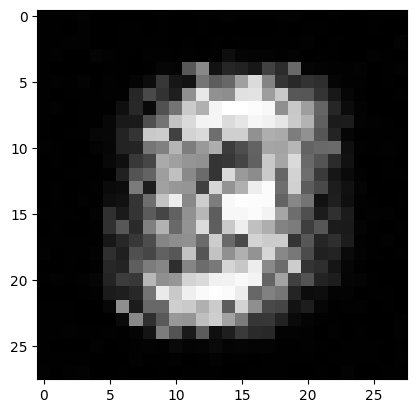

Ploting:  2


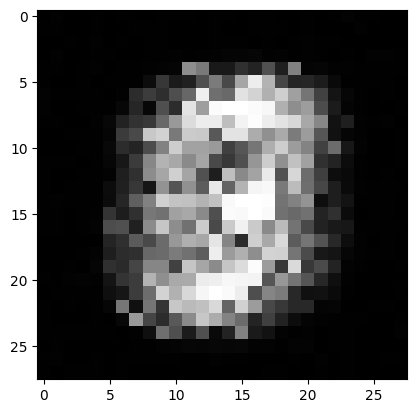

Epoch: 64550
loss_g: 2.297529458999634 	loss_d: 0.27652522921562195
Epoch: 64600
loss_g: 2.2800214290618896 	loss_d: 0.2526274621486664
Epoch: 64650
loss_g: 2.282951593399048 	loss_d: 0.2647234797477722
Epoch: 64700
loss_g: 2.276339054107666 	loss_d: 0.2714349627494812
Epoch: 64750
loss_g: 2.275341033935547 	loss_d: 0.238972008228302
Epoch: 64800
loss_g: 2.2721879482269287 	loss_d: 0.2856263518333435
Epoch: 64850
loss_g: 2.2615816593170166 	loss_d: 0.24856357276439667
Epoch: 64900
loss_g: 2.2641546726226807 	loss_d: 0.2651557922363281
Epoch: 64950
loss_g: 2.2503671646118164 	loss_d: 0.28858447074890137
Epoch: 65000
loss_g: 2.2467989921569824 	loss_d: 0.2677840292453766
Ploting:  7


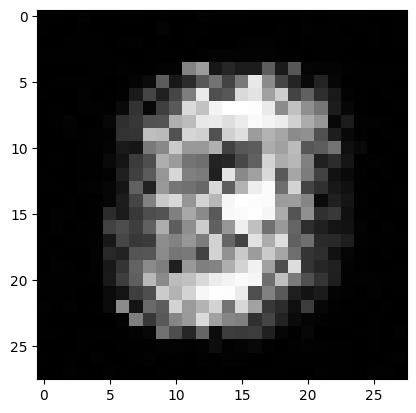

Ploting:  9


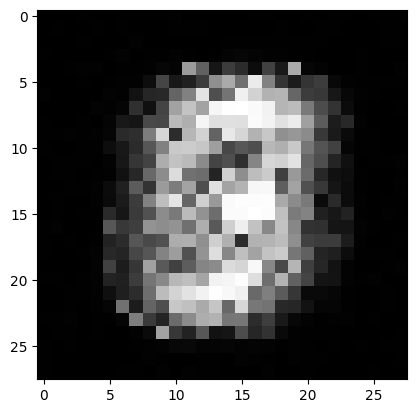

Ploting:  7


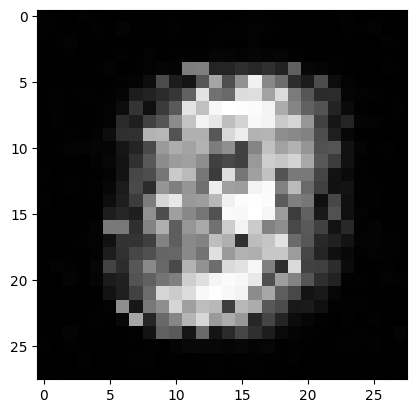

Epoch: 65050
loss_g: 2.245591402053833 	loss_d: 0.24580073356628418
Epoch: 65100
loss_g: 2.2281482219696045 	loss_d: 0.26600685715675354
Epoch: 65150
loss_g: 2.2438478469848633 	loss_d: 0.2789080739021301
Epoch: 65200
loss_g: 2.2105069160461426 	loss_d: 0.2687968909740448
Epoch: 65250
loss_g: 2.2065017223358154 	loss_d: 0.2654963731765747
Epoch: 65300
loss_g: 2.235509157180786 	loss_d: 0.2769245207309723
Epoch: 65350
loss_g: 2.219653367996216 	loss_d: 0.32866454124450684
Epoch: 65400
loss_g: 2.213879346847534 	loss_d: 0.33498817682266235
Epoch: 65450
loss_g: 2.203892707824707 	loss_d: 0.3059595823287964
Epoch: 65500
loss_g: 2.179081439971924 	loss_d: 0.2921735942363739
Ploting:  8


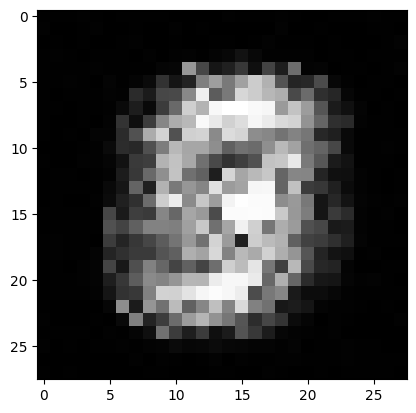

Ploting:  9


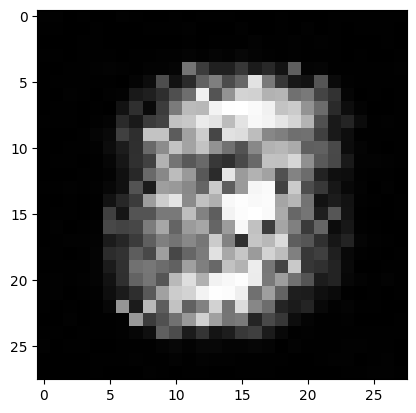

Ploting:  5


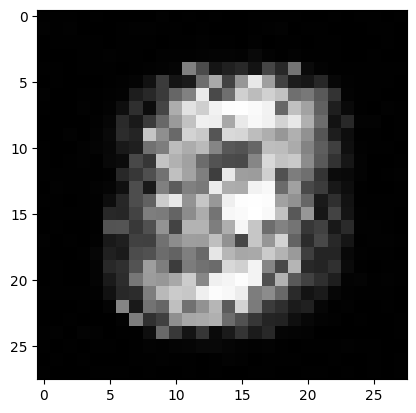

Epoch: 65550
loss_g: 2.19189453125 	loss_d: 0.3184505105018616
Epoch: 65600
loss_g: 2.182874917984009 	loss_d: 0.31279227137565613
Epoch: 65650
loss_g: 2.1643216609954834 	loss_d: 0.2982218563556671
Epoch: 65700
loss_g: 2.159172534942627 	loss_d: 0.28880950808525085
Epoch: 65750
loss_g: 2.1467602252960205 	loss_d: 0.3271803855895996
Epoch: 65800
loss_g: 2.1554183959960938 	loss_d: 0.3466997444629669
Epoch: 65850
loss_g: 2.168515205383301 	loss_d: 0.2945111095905304
Epoch: 65900
loss_g: 2.1601316928863525 	loss_d: 0.29465264081954956
Epoch: 65950
loss_g: 2.1545615196228027 	loss_d: 0.28479495644569397
Epoch: 66000
loss_g: 2.1447088718414307 	loss_d: 0.3011608421802521
Ploting:  7


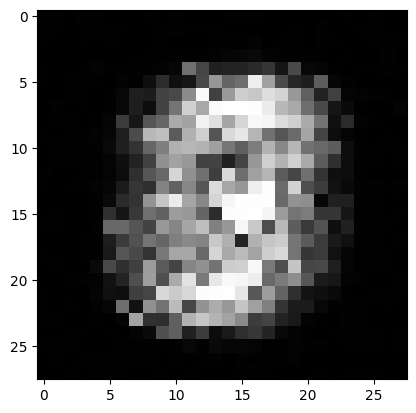

Ploting:  6


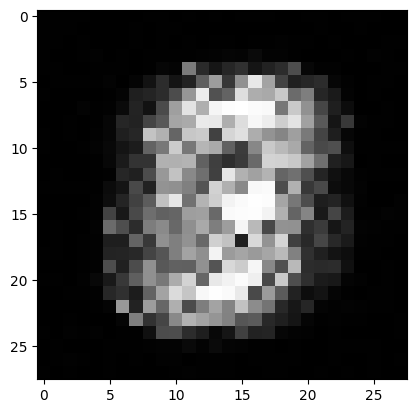

Ploting:  3


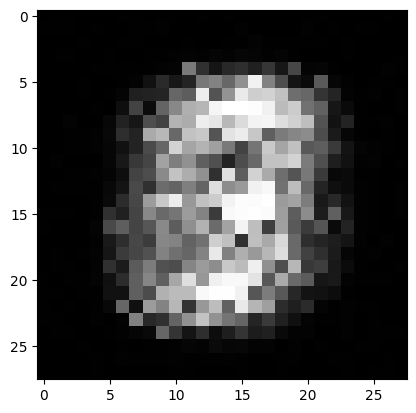

Epoch: 66050
loss_g: 2.141148567199707 	loss_d: 0.3209255039691925
Epoch: 66100
loss_g: 2.1383779048919678 	loss_d: 0.3039631247520447
Epoch: 66150
loss_g: 2.123201847076416 	loss_d: 0.2768762409687042
Epoch: 66200
loss_g: 2.1384389400482178 	loss_d: 0.3049828112125397
Epoch: 66250
loss_g: 2.1477277278900146 	loss_d: 0.3394204378128052
Epoch: 66300
loss_g: 2.124654769897461 	loss_d: 0.3369675874710083
Epoch: 66350
loss_g: 2.124148368835449 	loss_d: 0.3398139774799347
Epoch: 66400
loss_g: 2.1531929969787598 	loss_d: 0.3182782232761383
Epoch: 66450
loss_g: 2.1368772983551025 	loss_d: 0.2996533215045929
Epoch: 66500
loss_g: 2.1357197761535645 	loss_d: 0.2973737120628357
Ploting:  3


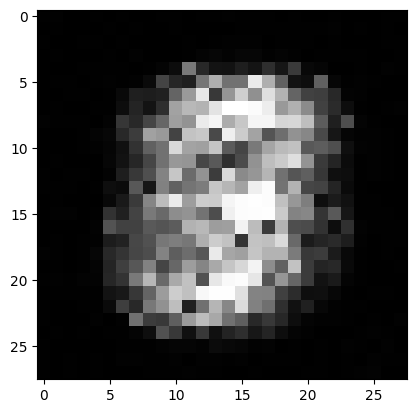

Ploting:  9


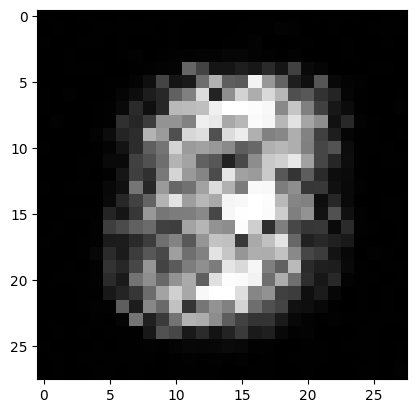

Ploting:  7


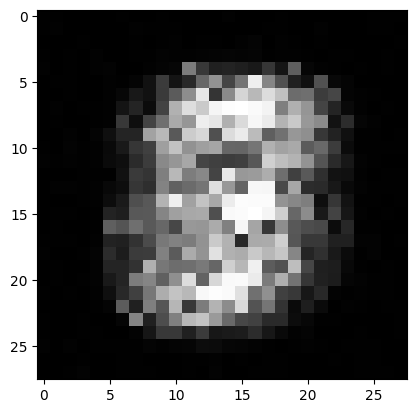

Epoch: 66550
loss_g: 2.1261038780212402 	loss_d: 0.3334606885910034
Epoch: 66600
loss_g: 2.124305486679077 	loss_d: 0.35155802965164185
Epoch: 66650
loss_g: 2.1194674968719482 	loss_d: 0.3468312621116638
Epoch: 66700
loss_g: 2.1307811737060547 	loss_d: 0.31750085949897766
Epoch: 66750
loss_g: 2.1277146339416504 	loss_d: 0.32872897386550903
Epoch: 66800
loss_g: 2.1397786140441895 	loss_d: 0.31455570459365845
Epoch: 66850
loss_g: 2.1238486766815186 	loss_d: 0.2915456295013428
Epoch: 66900
loss_g: 2.133284091949463 	loss_d: 0.34823694825172424
Epoch: 66950
loss_g: 2.131225824356079 	loss_d: 0.32307684421539307
Epoch: 67000
loss_g: 2.134765625 	loss_d: 0.2937202453613281
Ploting:  2


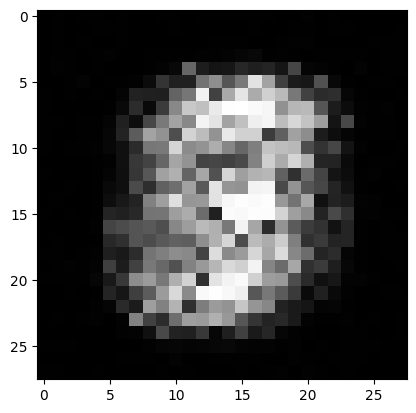

Ploting:  1


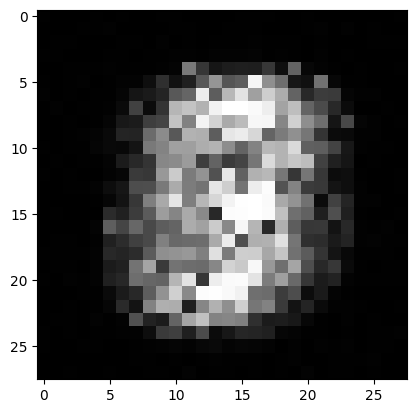

Ploting:  2


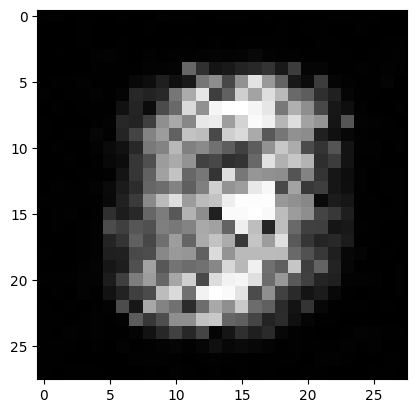

Epoch: 67050
loss_g: 2.142035722732544 	loss_d: 0.31347450613975525
Epoch: 67100
loss_g: 2.1325273513793945 	loss_d: 0.31809183955192566
Epoch: 67150
loss_g: 2.135997772216797 	loss_d: 0.268982857465744
Epoch: 67200
loss_g: 2.147540330886841 	loss_d: 0.31801822781562805
Epoch: 67250
loss_g: 2.1307590007781982 	loss_d: 0.2828232944011688
Epoch: 67300
loss_g: 2.131209135055542 	loss_d: 0.3038348853588104
Epoch: 67350
loss_g: 2.129276990890503 	loss_d: 0.3318212926387787
Epoch: 67400
loss_g: 2.128206968307495 	loss_d: 0.2913353145122528
Epoch: 67450
loss_g: 2.1499695777893066 	loss_d: 0.270190566778183
Epoch: 67500
loss_g: 2.120140314102173 	loss_d: 0.29930076003074646
Ploting:  6


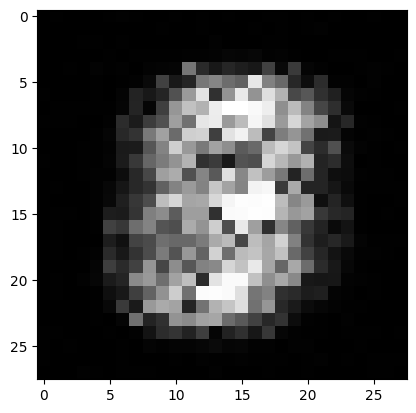

Ploting:  3


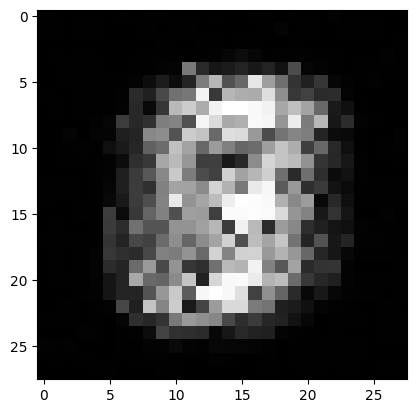

Ploting:  1


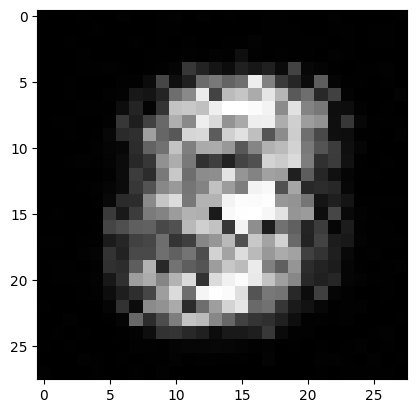

Epoch: 67550
loss_g: 2.1269044876098633 	loss_d: 0.30366113781929016
Epoch: 67600
loss_g: 2.13763689994812 	loss_d: 0.2971870005130768
Epoch: 67650
loss_g: 2.1340725421905518 	loss_d: 0.2863236665725708
Epoch: 67700
loss_g: 2.1571381092071533 	loss_d: 0.28947582840919495
Epoch: 67750
loss_g: 2.1466100215911865 	loss_d: 0.345599889755249
Epoch: 67800
loss_g: 2.1275124549865723 	loss_d: 0.3587077260017395
Epoch: 67850
loss_g: 2.146594524383545 	loss_d: 0.3274769186973572
Epoch: 67900
loss_g: 2.1440701484680176 	loss_d: 0.30580782890319824
Epoch: 67950
loss_g: 2.1368815898895264 	loss_d: 0.3220651149749756
Epoch: 68000
loss_g: 2.1404314041137695 	loss_d: 0.3300495147705078
Ploting:  0


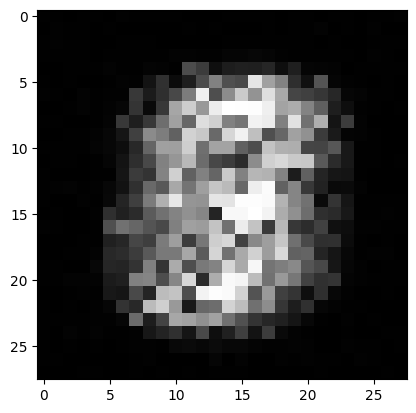

Ploting:  4


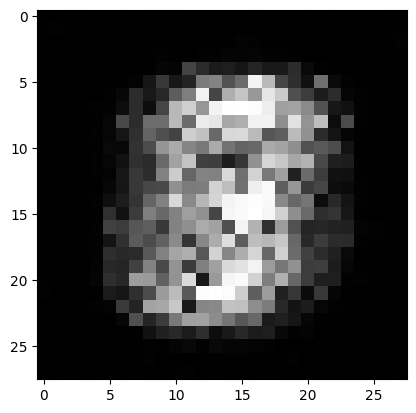

Ploting:  0


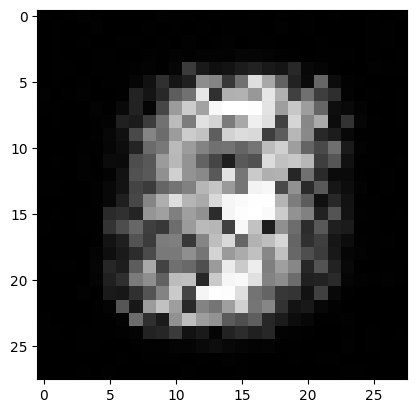

Epoch: 68050
loss_g: 2.149038076400757 	loss_d: 0.3101789057254791
Epoch: 68100
loss_g: 2.147193431854248 	loss_d: 0.28322064876556396
Epoch: 68150
loss_g: 2.166518449783325 	loss_d: 0.32836294174194336
Epoch: 68200
loss_g: 2.145833969116211 	loss_d: 0.34242552518844604
Epoch: 68250
loss_g: 2.1495883464813232 	loss_d: 0.2911395728588104
Epoch: 68300
loss_g: 2.177039861679077 	loss_d: 0.2885461449623108
Epoch: 68350
loss_g: 2.163529634475708 	loss_d: 0.2737255096435547
Epoch: 68400
loss_g: 2.178563117980957 	loss_d: 0.2967833876609802
Epoch: 68450
loss_g: 2.164503335952759 	loss_d: 0.30711784958839417
Epoch: 68500
loss_g: 2.152087450027466 	loss_d: 0.29735633730888367
Ploting:  8


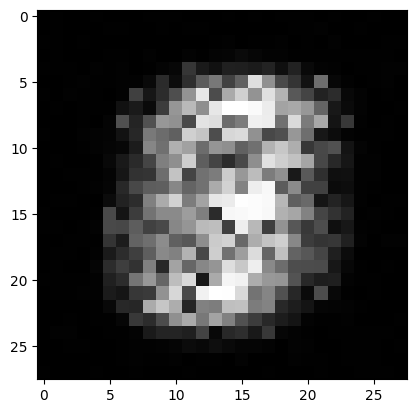

Ploting:  4


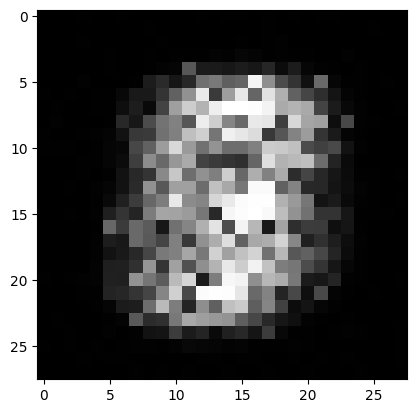

Ploting:  9


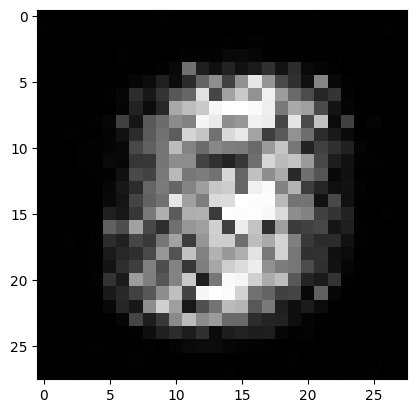

Epoch: 68550
loss_g: 2.1661064624786377 	loss_d: 0.2643306851387024
Epoch: 68600
loss_g: 2.174365282058716 	loss_d: 0.29477831721305847
Epoch: 68650
loss_g: 2.1567986011505127 	loss_d: 0.3291698396205902
Epoch: 68700
loss_g: 2.1708199977874756 	loss_d: 0.3261101543903351
Epoch: 68750
loss_g: 2.172602653503418 	loss_d: 0.3068208694458008
Epoch: 68800
loss_g: 2.167804479598999 	loss_d: 0.2970408797264099
Epoch: 68850
loss_g: 2.1679556369781494 	loss_d: 0.27299705147743225
Epoch: 68900
loss_g: 2.1797890663146973 	loss_d: 0.2734467387199402
Epoch: 68950
loss_g: 2.1791486740112305 	loss_d: 0.3137708604335785
Epoch: 69000
loss_g: 2.1754674911499023 	loss_d: 0.3326118290424347
Ploting:  4


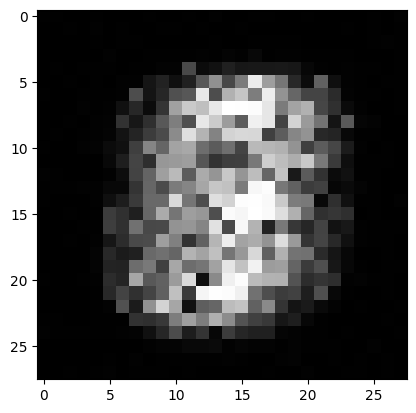

Ploting:  9


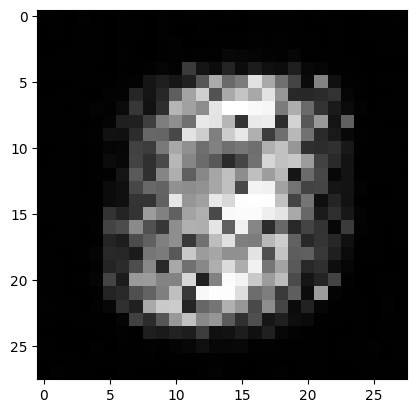

Ploting:  3


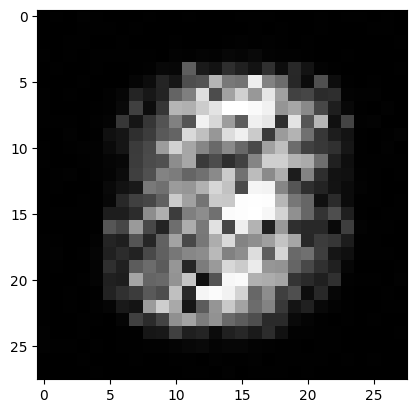

Epoch: 69050
loss_g: 2.16691517829895 	loss_d: 0.31641823053359985
Epoch: 69100
loss_g: 2.177489995956421 	loss_d: 0.2955261468887329
Epoch: 69150
loss_g: 2.1938161849975586 	loss_d: 0.3056560754776001
Epoch: 69200
loss_g: 2.1873385906219482 	loss_d: 0.293140172958374
Epoch: 69250
loss_g: 2.1793339252471924 	loss_d: 0.26724928617477417
Epoch: 69300
loss_g: 2.1768012046813965 	loss_d: 0.31820330023765564
Epoch: 69350
loss_g: 2.1802759170532227 	loss_d: 0.29061436653137207
Epoch: 69400
loss_g: 2.1833653450012207 	loss_d: 0.2639145255088806
Epoch: 69450
loss_g: 2.1952521800994873 	loss_d: 0.29165729880332947
Epoch: 69500
loss_g: 2.179809331893921 	loss_d: 0.28767919540405273
Ploting:  9


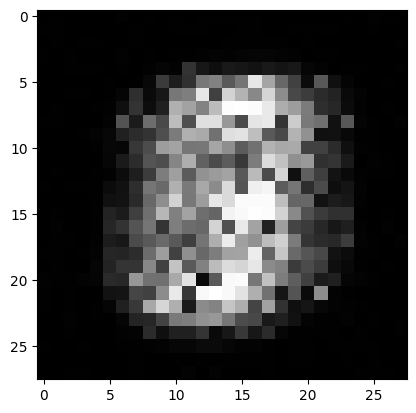

Ploting:  3


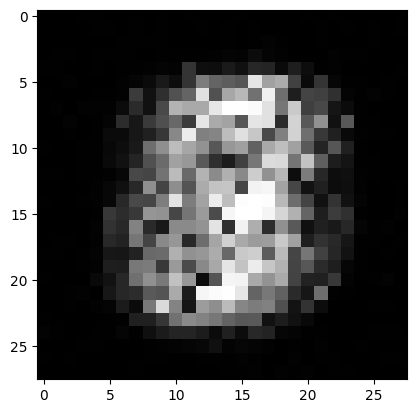

Ploting:  0


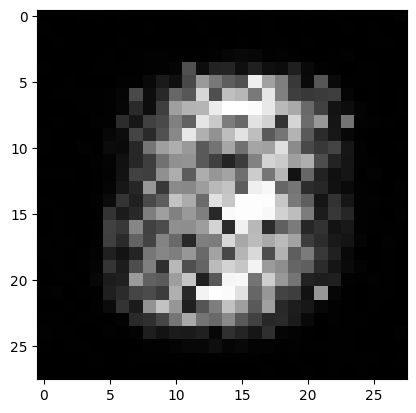

Epoch: 69550
loss_g: 2.1917223930358887 	loss_d: 0.24457865953445435
Epoch: 69600
loss_g: 2.1980879306793213 	loss_d: 0.2825978994369507
Epoch: 69650
loss_g: 2.2008132934570312 	loss_d: 0.25530916452407837
Epoch: 69700
loss_g: 2.1950743198394775 	loss_d: 0.2809211015701294
Epoch: 69750
loss_g: 2.1770668029785156 	loss_d: 0.30446261167526245
Epoch: 69800
loss_g: 2.194988489151001 	loss_d: 0.2618871331214905
Epoch: 69850
loss_g: 2.197788715362549 	loss_d: 0.2422616332769394
Epoch: 69900
loss_g: 2.2040536403656006 	loss_d: 0.2794462740421295
Epoch: 69950
loss_g: 2.2125563621520996 	loss_d: 0.2706204652786255
Epoch: 70000
loss_g: 2.208064317703247 	loss_d: 0.2642597556114197
Ploting:  1


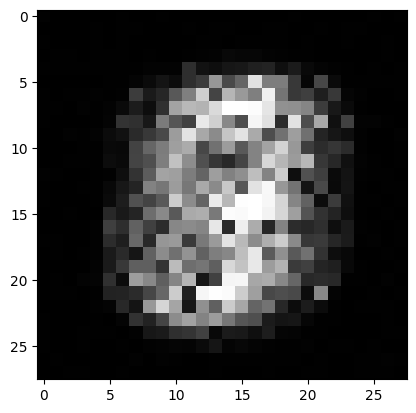

Ploting:  8


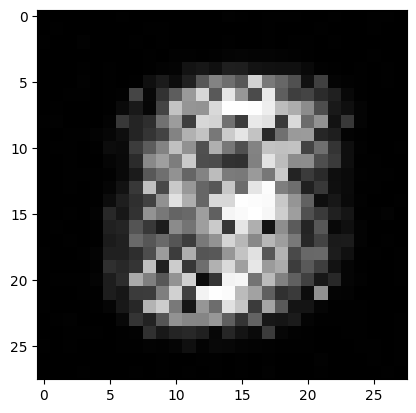

Ploting:  2


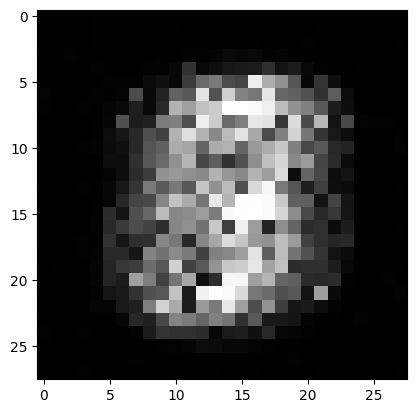

Epoch: 70050
loss_g: 2.2055258750915527 	loss_d: 0.26579079031944275
Epoch: 70100
loss_g: 2.1830568313598633 	loss_d: 0.2563105821609497
Epoch: 70150
loss_g: 2.1817145347595215 	loss_d: 0.31559455394744873
Epoch: 70200
loss_g: 2.219866991043091 	loss_d: 0.33176693320274353
Epoch: 70250
loss_g: 2.1978371143341064 	loss_d: 0.3047581911087036
Epoch: 70300
loss_g: 2.1759767532348633 	loss_d: 0.2739284038543701
Epoch: 70350
loss_g: 2.220656156539917 	loss_d: 0.28616762161254883
Epoch: 70400
loss_g: 2.179111957550049 	loss_d: 0.30942434072494507
Epoch: 70450
loss_g: 2.1961617469787598 	loss_d: 0.2802899479866028
Epoch: 70500
loss_g: 2.1975150108337402 	loss_d: 0.2563841640949249
Ploting:  6


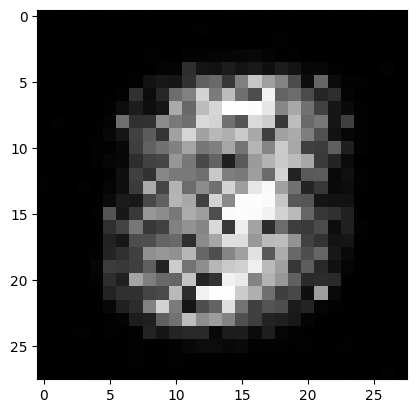

Ploting:  8


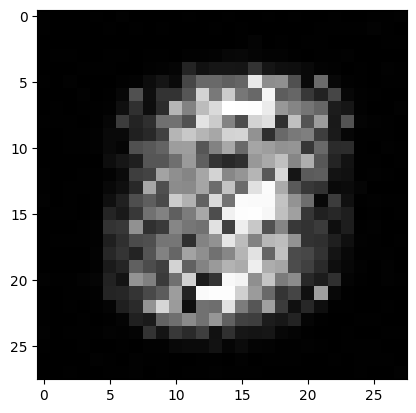

Ploting:  6


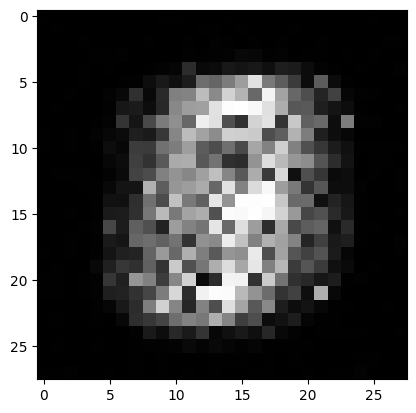

Epoch: 70550
loss_g: 2.195791244506836 	loss_d: 0.2985459864139557
Epoch: 70600
loss_g: 2.1823887825012207 	loss_d: 0.311554491519928
Epoch: 70650
loss_g: 2.1916348934173584 	loss_d: 0.2689400911331177
Epoch: 70700
loss_g: 2.2089595794677734 	loss_d: 0.2667433023452759
Epoch: 70750
loss_g: 2.197570562362671 	loss_d: 0.24563418328762054
Epoch: 70800
loss_g: 2.192051887512207 	loss_d: 0.2813408076763153
Epoch: 70850
loss_g: 2.19248628616333 	loss_d: 0.2833096981048584
Epoch: 70900
loss_g: 2.200650930404663 	loss_d: 0.2818710505962372
Epoch: 70950
loss_g: 2.200829029083252 	loss_d: 0.24140843749046326
Epoch: 71000
loss_g: 2.2140352725982666 	loss_d: 0.2775122821331024
Ploting:  2


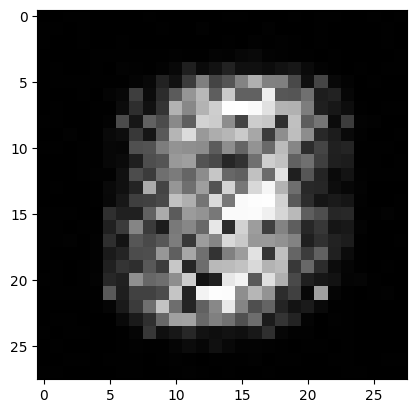

Ploting:  2


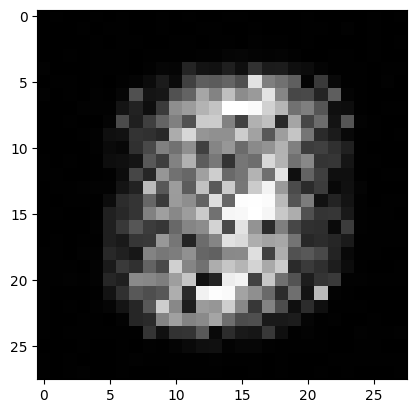

Ploting:  4


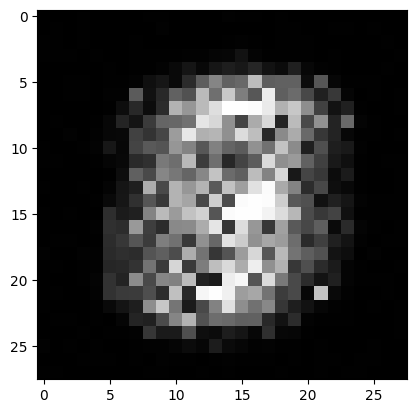

Epoch: 71050
loss_g: 2.1998586654663086 	loss_d: 0.3103797137737274
Epoch: 71100
loss_g: 2.208512306213379 	loss_d: 0.3098704218864441
Epoch: 71150
loss_g: 2.1708929538726807 	loss_d: 0.2787286341190338
Epoch: 71200
loss_g: 2.179304361343384 	loss_d: 0.283628910779953
Epoch: 71250
loss_g: 2.18622088432312 	loss_d: 0.2576807737350464
Epoch: 71300
loss_g: 2.1861114501953125 	loss_d: 0.25800830125808716
Epoch: 71350
loss_g: 2.174678087234497 	loss_d: 0.30945849418640137
Epoch: 71400
loss_g: 2.1758155822753906 	loss_d: 0.3262123465538025
Epoch: 71450
loss_g: 2.147249460220337 	loss_d: 0.3086521327495575
Epoch: 71500
loss_g: 2.167206287384033 	loss_d: 0.28916963934898376
Ploting:  1


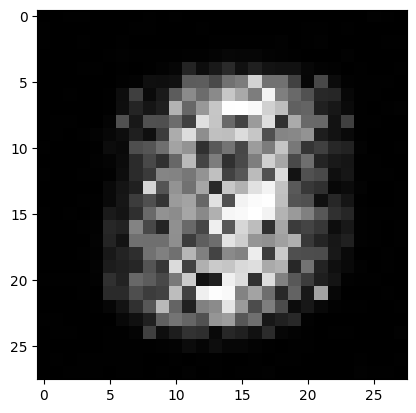

Ploting:  0


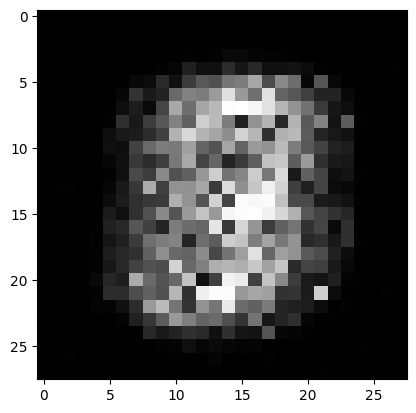

Ploting:  0


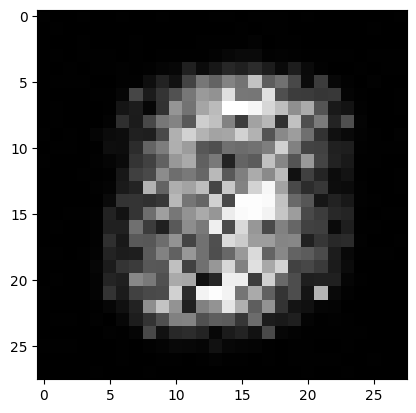

Epoch: 71550
loss_g: 2.1813526153564453 	loss_d: 0.2978956401348114
Epoch: 71600
loss_g: 2.16447377204895 	loss_d: 0.2925025224685669
Epoch: 71650
loss_g: 2.1792657375335693 	loss_d: 0.26226508617401123
Epoch: 71700
loss_g: 2.158400297164917 	loss_d: 0.3102145195007324
Epoch: 71750
loss_g: 2.1514360904693604 	loss_d: 0.2881135642528534
Epoch: 71800
loss_g: 2.1654977798461914 	loss_d: 0.2560310661792755
Epoch: 71850
loss_g: 2.152590274810791 	loss_d: 0.2914401888847351
Epoch: 71900
loss_g: 2.1476800441741943 	loss_d: 0.2834325432777405
Epoch: 71950
loss_g: 2.1421775817871094 	loss_d: 0.24629056453704834
Epoch: 72000
loss_g: 2.1417922973632812 	loss_d: 0.28343456983566284
Ploting:  2


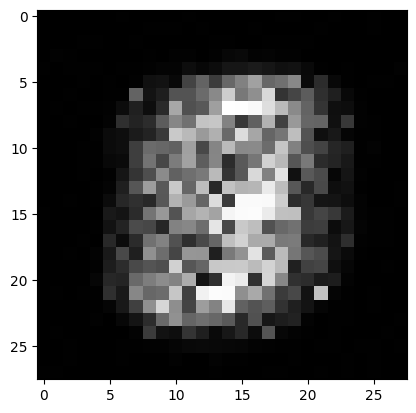

Ploting:  8


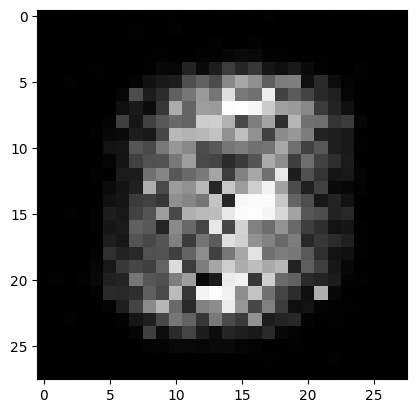

Ploting:  8


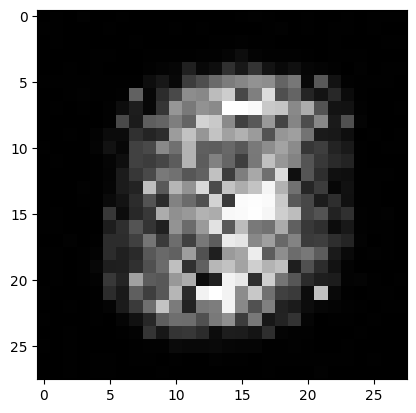

Epoch: 72050
loss_g: 2.1343908309936523 	loss_d: 0.2595575153827667
Epoch: 72100
loss_g: 2.114313840866089 	loss_d: 0.2929950952529907
Epoch: 72150
loss_g: 2.144253730773926 	loss_d: 0.31422650814056396
Epoch: 72200
loss_g: 2.1229665279388428 	loss_d: 0.26830440759658813
Epoch: 72250
loss_g: 2.1356277465820312 	loss_d: 0.24627070128917694
Epoch: 72300
loss_g: 2.1265954971313477 	loss_d: 0.29596754908561707
Epoch: 72350
loss_g: 2.109912872314453 	loss_d: 0.28367742896080017
Epoch: 72400
loss_g: 2.1196703910827637 	loss_d: 0.27109649777412415
Epoch: 72450
loss_g: 2.1155972480773926 	loss_d: 0.27844005823135376
Epoch: 72500
loss_g: 2.1158037185668945 	loss_d: 0.26852214336395264
Ploting:  7


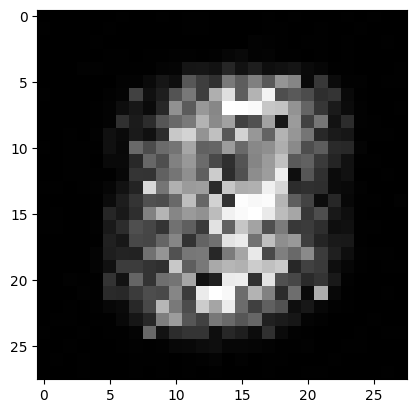

Ploting:  7


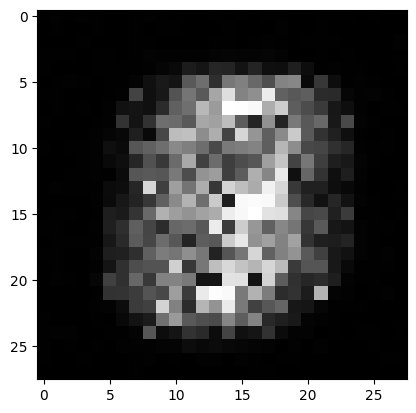

Ploting:  1


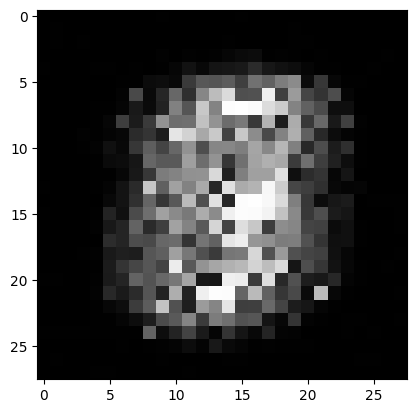

Epoch: 72550
loss_g: 2.11940336227417 	loss_d: 0.3340376317501068
Epoch: 72600
loss_g: 2.109633207321167 	loss_d: 0.3541000187397003
Epoch: 72650
loss_g: 2.1066949367523193 	loss_d: 0.32384973764419556
Epoch: 72700
loss_g: 2.094876766204834 	loss_d: 0.2952482998371124
Epoch: 72750
loss_g: 2.0983102321624756 	loss_d: 0.3059820532798767
Epoch: 72800
loss_g: 2.104966402053833 	loss_d: 0.3321244716644287
Epoch: 72850
loss_g: 2.086243152618408 	loss_d: 0.3050740659236908
Epoch: 72900
loss_g: 2.08890962600708 	loss_d: 0.2759997844696045
Epoch: 72950
loss_g: 2.100489377975464 	loss_d: 0.31228938698768616
Epoch: 73000
loss_g: 2.0917842388153076 	loss_d: 0.3351784348487854
Ploting:  3


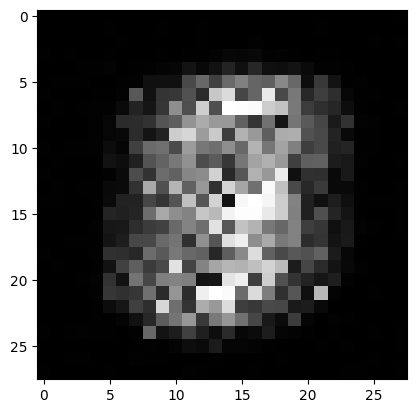

Ploting:  3


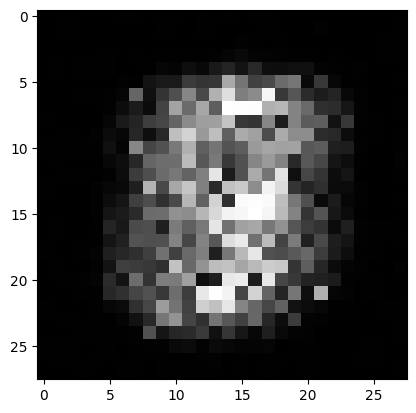

Ploting:  3


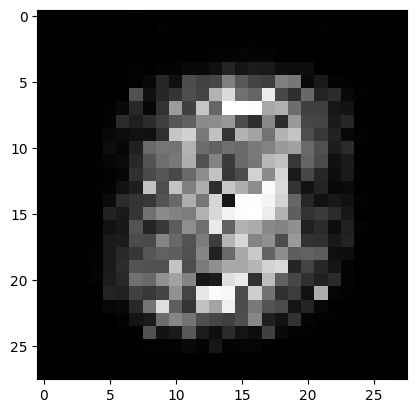

Epoch: 73050
loss_g: 2.0842108726501465 	loss_d: 0.2973915636539459
Epoch: 73100
loss_g: 2.0980782508850098 	loss_d: 0.2956233024597168
Epoch: 73150
loss_g: 2.0722787380218506 	loss_d: 0.25634321570396423
Epoch: 73200
loss_g: 2.0897231101989746 	loss_d: 0.3089323043823242
Epoch: 73250
loss_g: 2.073389768600464 	loss_d: 0.30613353848457336
Epoch: 73300
loss_g: 2.097940683364868 	loss_d: 0.3108194172382355
Epoch: 73350
loss_g: 2.0706865787506104 	loss_d: 0.26288947463035583
Epoch: 73400
loss_g: 2.095649480819702 	loss_d: 0.30342409014701843
Epoch: 73450
loss_g: 2.1138832569122314 	loss_d: 0.3268883526325226
Epoch: 73500
loss_g: 2.0781362056732178 	loss_d: 0.3378925621509552
Ploting:  1


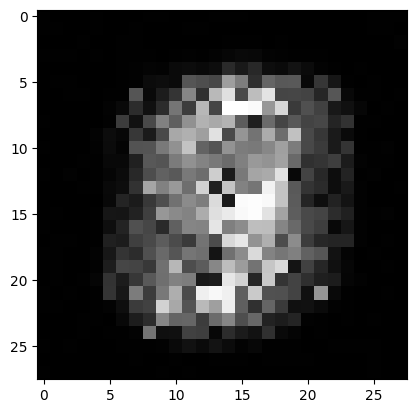

Ploting:  9


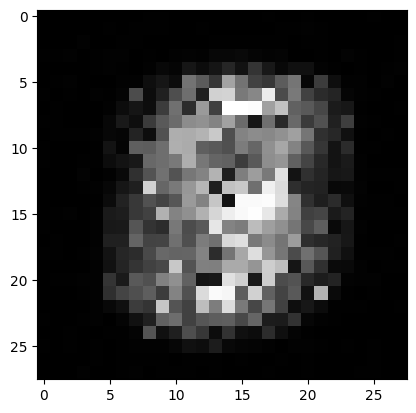

Ploting:  0


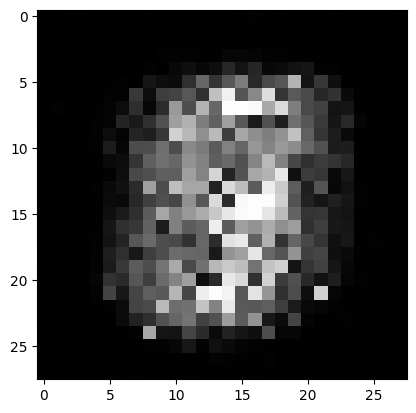

Epoch: 73550
loss_g: 2.056175947189331 	loss_d: 0.2905825674533844
Epoch: 73600
loss_g: 2.0957934856414795 	loss_d: 0.3076511323451996
Epoch: 73650
loss_g: 2.0647542476654053 	loss_d: 0.27845537662506104
Epoch: 73700
loss_g: 2.068255662918091 	loss_d: 0.2750990688800812
Epoch: 73750
loss_g: 2.089799642562866 	loss_d: 0.3408200740814209
Epoch: 73800
loss_g: 2.070298671722412 	loss_d: 0.3495725989341736
Epoch: 73850
loss_g: 2.0926692485809326 	loss_d: 0.3414677381515503
Epoch: 73900
loss_g: 2.072859764099121 	loss_d: 0.3123587667942047
Epoch: 73950
loss_g: 2.0768847465515137 	loss_d: 0.3173810541629791
Epoch: 74000
loss_g: 2.0520660877227783 	loss_d: 0.31152841448783875
Ploting:  4


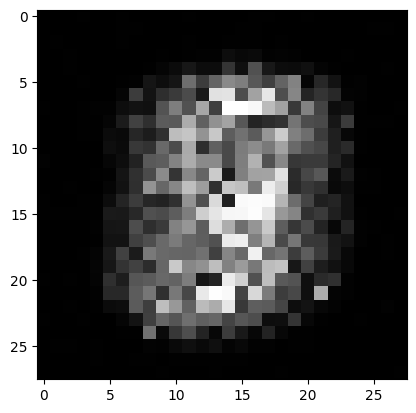

Ploting:  5


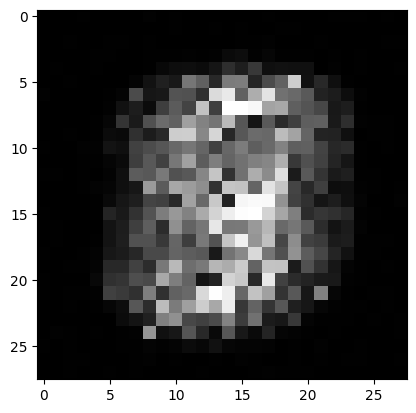

Ploting:  1


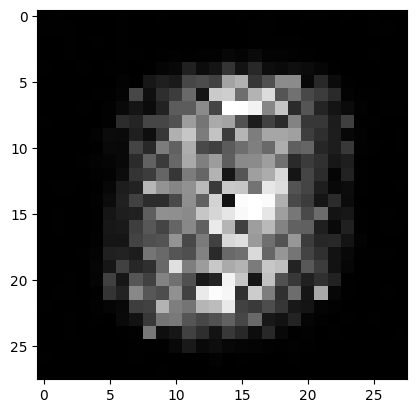

Epoch: 74050
loss_g: 2.106330156326294 	loss_d: 0.2713846266269684
Epoch: 74100
loss_g: 2.0829906463623047 	loss_d: 0.3270440697669983
Epoch: 74150
loss_g: 2.0710484981536865 	loss_d: 0.29759764671325684
Epoch: 74200
loss_g: 2.0762078762054443 	loss_d: 0.26795637607574463
Epoch: 74250
loss_g: 2.0611422061920166 	loss_d: 0.3032343089580536
Epoch: 74300
loss_g: 2.0740268230438232 	loss_d: 0.2917032241821289
Epoch: 74350
loss_g: 2.0766372680664062 	loss_d: 0.2553967237472534
Epoch: 74400
loss_g: 2.091783046722412 	loss_d: 0.2885487973690033
Epoch: 74450
loss_g: 2.052112340927124 	loss_d: 0.2687067687511444
Epoch: 74500
loss_g: 2.0656089782714844 	loss_d: 0.31184157729148865
Ploting:  9


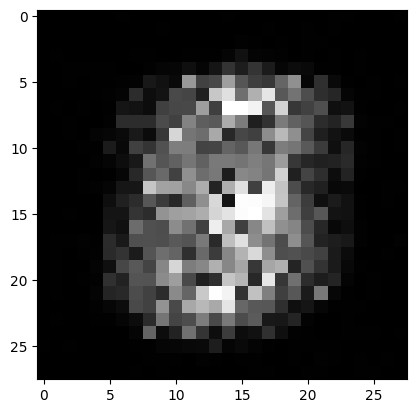

Ploting:  8


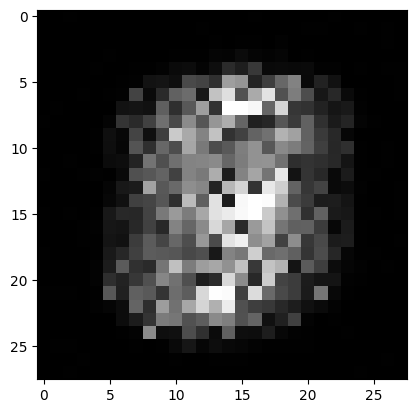

Ploting:  8


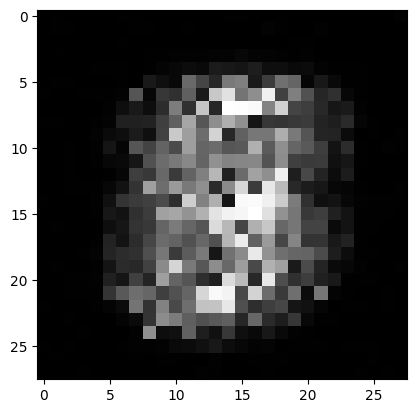

Epoch: 74550
loss_g: 2.0847558975219727 	loss_d: 0.3192218840122223
Epoch: 74600
loss_g: 2.0558242797851562 	loss_d: 0.2745443284511566
Epoch: 74650
loss_g: 2.0787086486816406 	loss_d: 0.25427791476249695
Epoch: 74700
loss_g: 2.0762977600097656 	loss_d: 0.30381518602371216
Epoch: 74750
loss_g: 2.0876128673553467 	loss_d: 0.2934938073158264
Epoch: 74800
loss_g: 2.0729269981384277 	loss_d: 0.27141720056533813
Epoch: 74850
loss_g: 2.087069034576416 	loss_d: 0.2839120328426361
Epoch: 74900
loss_g: 2.0871036052703857 	loss_d: 0.27322912216186523
Epoch: 74950
loss_g: 2.0545012950897217 	loss_d: 0.34344762563705444
Epoch: 75000
loss_g: 2.048759698867798 	loss_d: 0.36147552728652954
Ploting:  9


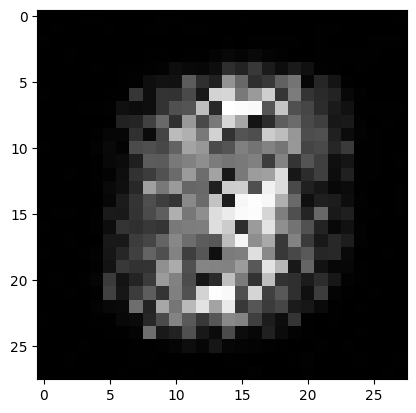

Ploting:  3


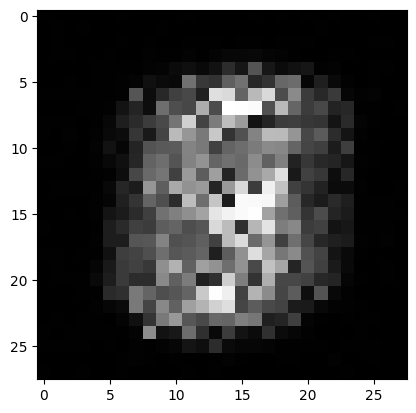

Ploting:  3


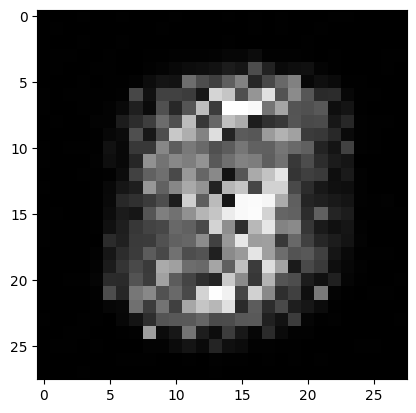

Epoch: 75050
loss_g: 2.0624263286590576 	loss_d: 0.32512927055358887
Epoch: 75100
loss_g: 2.058579444885254 	loss_d: 0.3007256090641022
Epoch: 75150
loss_g: 2.092852830886841 	loss_d: 0.2993954122066498
Epoch: 75200
loss_g: 2.0744729042053223 	loss_d: 0.3441784083843231
Epoch: 75250
loss_g: 2.075310707092285 	loss_d: 0.30348873138427734
Epoch: 75300
loss_g: 2.060487747192383 	loss_d: 0.2887909710407257
Epoch: 75350
loss_g: 2.072808265686035 	loss_d: 0.3068729043006897
Epoch: 75400
loss_g: 2.077040910720825 	loss_d: 0.33088797330856323
Epoch: 75450
loss_g: 2.041691541671753 	loss_d: 0.29911020398139954
Epoch: 75500
loss_g: 2.0572357177734375 	loss_d: 0.2947584390640259
Ploting:  5


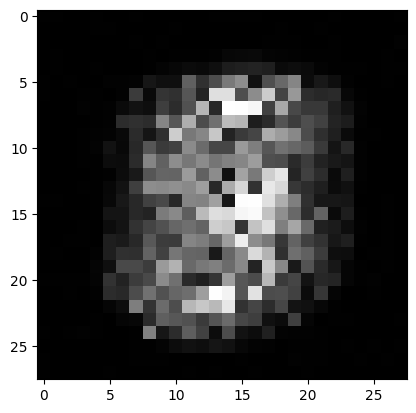

Ploting:  3


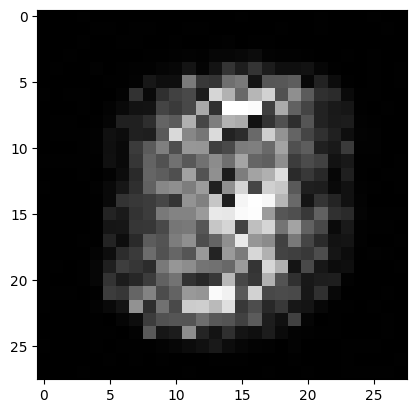

Ploting:  6


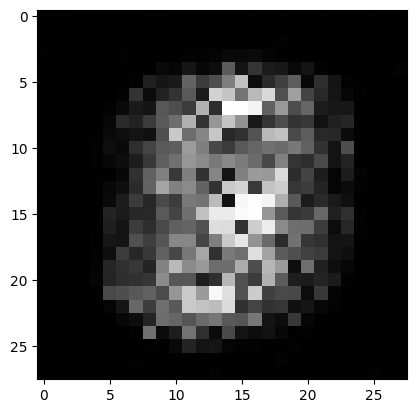

Epoch: 75550
loss_g: 2.051584005355835 	loss_d: 0.2535087466239929
Epoch: 75600
loss_g: 2.039355993270874 	loss_d: 0.29878827929496765
Epoch: 75650
loss_g: 2.0502450466156006 	loss_d: 0.31177255511283875
Epoch: 75700
loss_g: 2.0375006198883057 	loss_d: 0.3124646246433258
Epoch: 75750
loss_g: 2.045058488845825 	loss_d: 0.2729993462562561
Epoch: 75800
loss_g: 2.0438172817230225 	loss_d: 0.3079585134983063
Epoch: 75850
loss_g: 2.0373666286468506 	loss_d: 0.3271976411342621
Epoch: 75900
loss_g: 2.0378334522247314 	loss_d: 0.3279271125793457
Epoch: 75950
loss_g: 2.0465190410614014 	loss_d: 0.29475662112236023
Epoch: 76000
loss_g: 2.0376758575439453 	loss_d: 0.30194395780563354
Ploting:  0


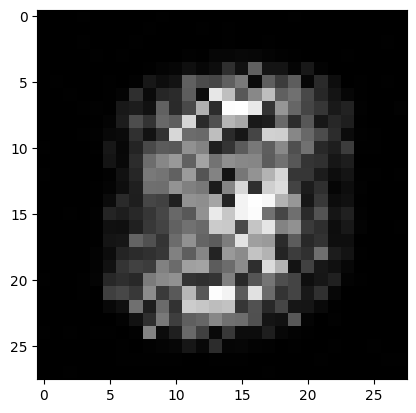

Ploting:  8


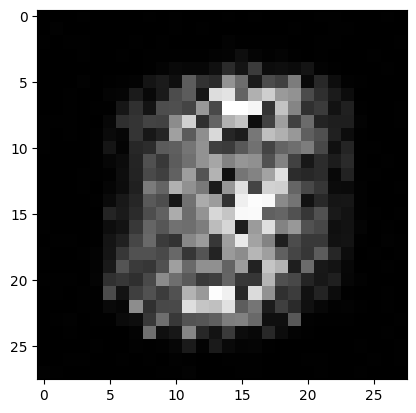

Ploting:  7


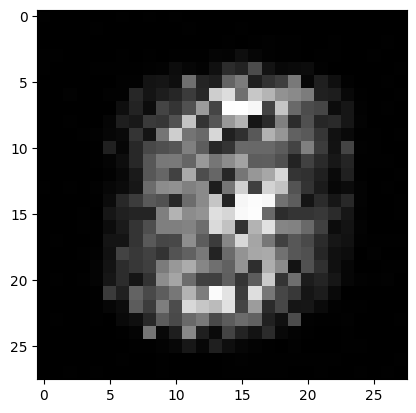

Epoch: 76050
loss_g: 2.0489308834075928 	loss_d: 0.2813068628311157
Epoch: 76100
loss_g: 2.0143353939056396 	loss_d: 0.282011479139328
Epoch: 76150
loss_g: 2.003976583480835 	loss_d: 0.35470664501190186
Epoch: 76200
loss_g: 2.0148744583129883 	loss_d: 0.360250860452652
Epoch: 76250
loss_g: 2.0274498462677 	loss_d: 0.35594427585601807
Epoch: 76300
loss_g: 2.00593900680542 	loss_d: 0.3155471086502075
Epoch: 76350
loss_g: 2.000715494155884 	loss_d: 0.3140033781528473
Epoch: 76400
loss_g: 1.9849257469177246 	loss_d: 0.3246843218803406
Epoch: 76450
loss_g: 2.0117194652557373 	loss_d: 0.2756955921649933
Epoch: 76500
loss_g: 1.9841490983963013 	loss_d: 0.3401990830898285
Ploting:  9


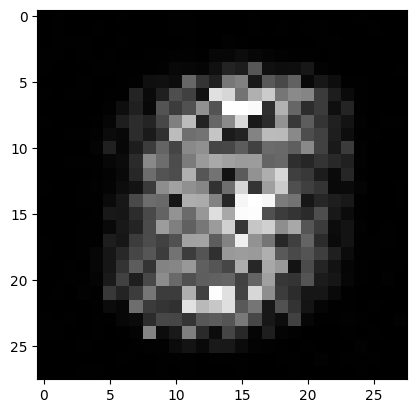

Ploting:  9


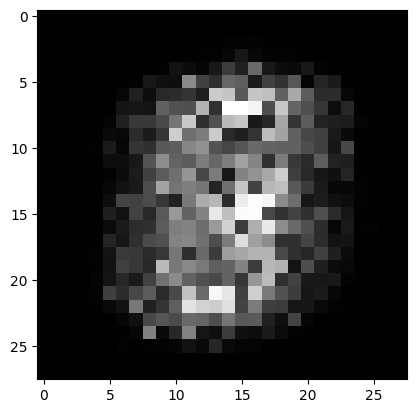

Ploting:  0


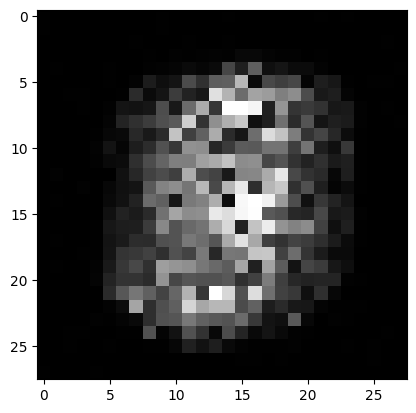

Epoch: 76550
loss_g: 1.9850966930389404 	loss_d: 0.2953772246837616
Epoch: 76600
loss_g: 2.018087148666382 	loss_d: 0.2771829068660736
Epoch: 76650
loss_g: 1.9890251159667969 	loss_d: 0.30737194418907166
Epoch: 76700
loss_g: 1.9811962842941284 	loss_d: 0.30242156982421875
Epoch: 76750
loss_g: 1.9584195613861084 	loss_d: 0.2799169421195984
Epoch: 76800
loss_g: 1.9785128831863403 	loss_d: 0.2979400157928467
Epoch: 76850
loss_g: 1.9745063781738281 	loss_d: 0.2776782512664795
Epoch: 76900
loss_g: 1.9683587551116943 	loss_d: 0.3420785367488861
Epoch: 76950
loss_g: 1.9554531574249268 	loss_d: 0.3539406955242157
Epoch: 77000
loss_g: 1.9589093923568726 	loss_d: 0.2996011972427368
Ploting:  0


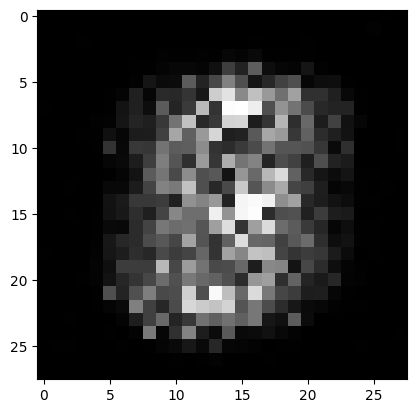

Ploting:  5


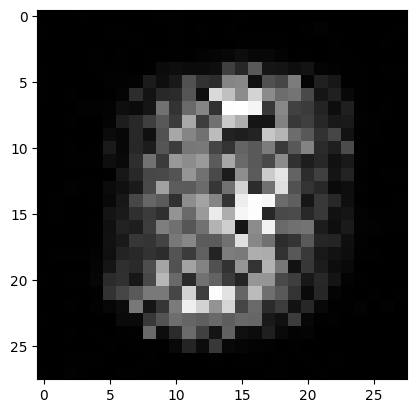

Ploting:  6


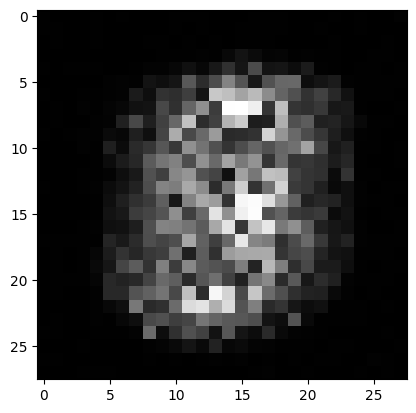

Epoch: 77050
loss_g: 1.9576380252838135 	loss_d: 0.27052363753318787
Epoch: 77100
loss_g: 1.9574334621429443 	loss_d: 0.32233762741088867
Epoch: 77150
loss_g: 1.9392499923706055 	loss_d: 0.3240824043750763
Epoch: 77200
loss_g: 1.919839859008789 	loss_d: 0.293658584356308
Epoch: 77250
loss_g: 1.9326108694076538 	loss_d: 0.3028792440891266
Epoch: 77300
loss_g: 1.9343148469924927 	loss_d: 0.30585044622421265
Epoch: 77350
loss_g: 1.9286311864852905 	loss_d: 0.3788173496723175
Epoch: 77400
loss_g: 1.9036974906921387 	loss_d: 0.411254346370697
Epoch: 77450
loss_g: 1.9101521968841553 	loss_d: 0.3574727475643158
Epoch: 77500
loss_g: 1.8751097917556763 	loss_d: 0.3458726704120636
Ploting:  4


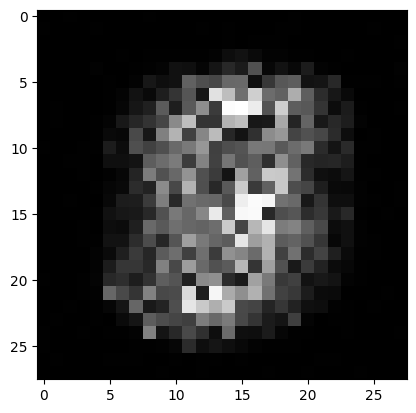

Ploting:  8


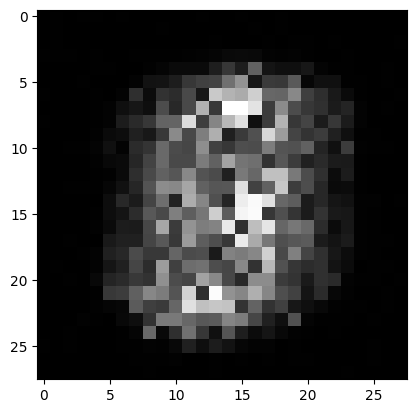

Ploting:  5


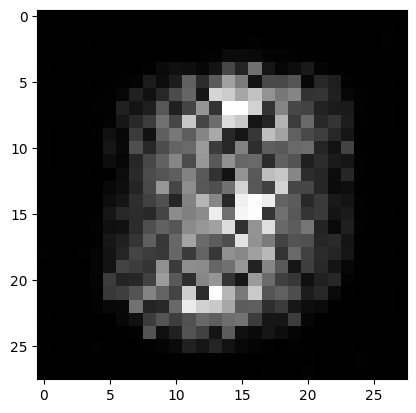

Epoch: 77550
loss_g: 1.911694884300232 	loss_d: 0.33587607741355896
Epoch: 77600
loss_g: 1.9006294012069702 	loss_d: 0.38614988327026367
Epoch: 77650
loss_g: 1.900410771369934 	loss_d: 0.34779778122901917
Epoch: 77700
loss_g: 1.8911045789718628 	loss_d: 0.3445374369621277
Epoch: 77750
loss_g: 1.9151461124420166 	loss_d: 0.35479626059532166
Epoch: 77800
loss_g: 1.896931529045105 	loss_d: 0.37423446774482727
Epoch: 77850
loss_g: 1.8783318996429443 	loss_d: 0.3386874794960022
Epoch: 77900
loss_g: 1.8712880611419678 	loss_d: 0.33187365531921387
Epoch: 77950
loss_g: 1.8774514198303223 	loss_d: 0.28886139392852783
Epoch: 78000
loss_g: 1.8977575302124023 	loss_d: 0.335286945104599
Ploting:  5


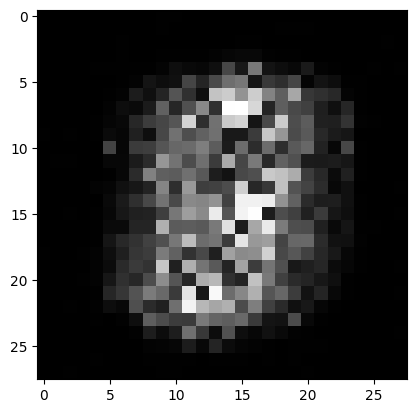

Ploting:  6


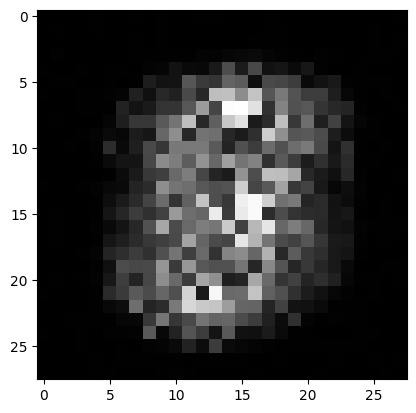

Ploting:  1


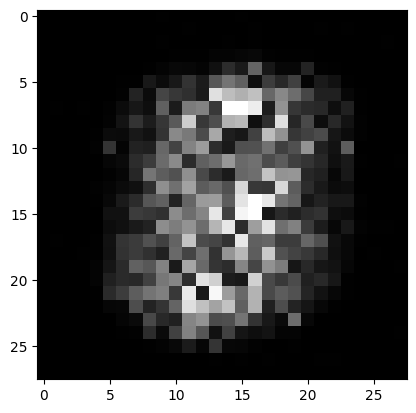

Epoch: 78050
loss_g: 1.9005661010742188 	loss_d: 0.35673925280570984
Epoch: 78100
loss_g: 1.877094030380249 	loss_d: 0.3576248586177826
Epoch: 78150
loss_g: 1.8691908121109009 	loss_d: 0.32684698700904846
Epoch: 78200
loss_g: 1.8876186609268188 	loss_d: 0.35393965244293213
Epoch: 78250
loss_g: 1.8851732015609741 	loss_d: 0.36880508065223694
Epoch: 78300
loss_g: 1.8419623374938965 	loss_d: 0.36204707622528076
Epoch: 78350
loss_g: 1.8590182065963745 	loss_d: 0.338375985622406
Epoch: 78400
loss_g: 1.8795360326766968 	loss_d: 0.3357481062412262
Epoch: 78450
loss_g: 1.8811956644058228 	loss_d: 0.3216102421283722
Epoch: 78500
loss_g: 1.868181824684143 	loss_d: 0.3218359351158142
Ploting:  4


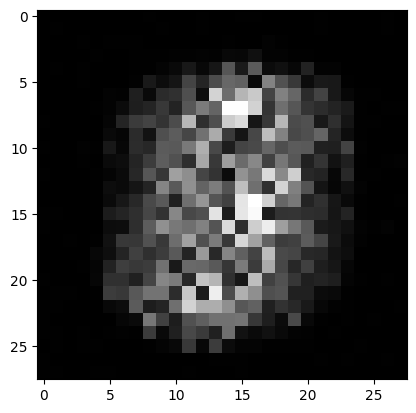

Ploting:  9


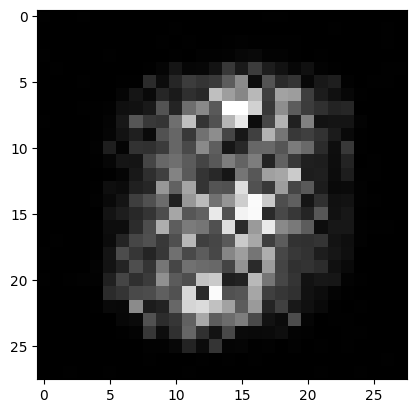

Ploting:  8


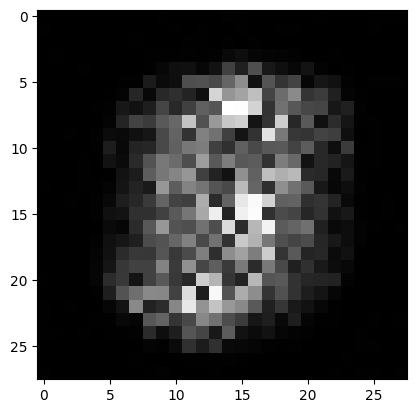

Epoch: 78550
loss_g: 1.8654018640518188 	loss_d: 0.39330047369003296
Epoch: 78600
loss_g: 1.863505244255066 	loss_d: 0.40168821811676025
Epoch: 78650
loss_g: 1.860020399093628 	loss_d: 0.38851672410964966
Epoch: 78700
loss_g: 1.856348991394043 	loss_d: 0.3480166494846344
Epoch: 78750
loss_g: 1.8555501699447632 	loss_d: 0.35049307346343994
Epoch: 78800
loss_g: 1.8476018905639648 	loss_d: 0.3613317906856537
Epoch: 78850
loss_g: 1.8656574487686157 	loss_d: 0.3057831823825836
Epoch: 78900
loss_g: 1.8620226383209229 	loss_d: 0.3860258162021637
Epoch: 78950
loss_g: 1.8587889671325684 	loss_d: 0.32518744468688965
Epoch: 79000
loss_g: 1.859572410583496 	loss_d: 0.3108094334602356
Ploting:  2


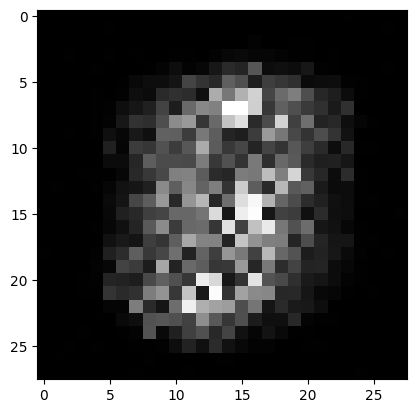

Ploting:  6


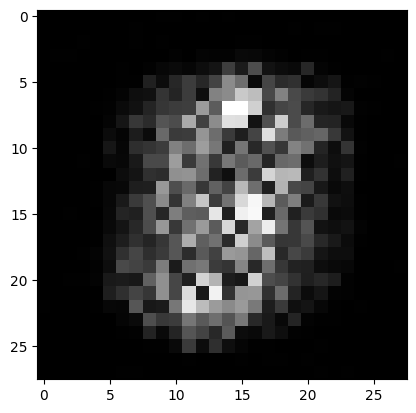

Ploting:  3


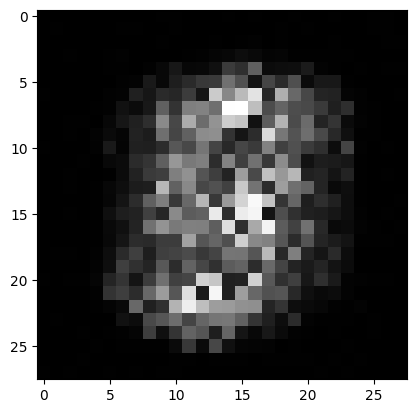

Epoch: 79050
loss_g: 1.8439522981643677 	loss_d: 0.3330368101596832
Epoch: 79100
loss_g: 1.8292465209960938 	loss_d: 0.34239456057548523
Epoch: 79150
loss_g: 1.8189841508865356 	loss_d: 0.32129234075546265
Epoch: 79200
loss_g: 1.8208342790603638 	loss_d: 0.33250945806503296
Epoch: 79250
loss_g: 1.8057204484939575 	loss_d: 0.3177744746208191
Epoch: 79300
loss_g: 1.7924458980560303 	loss_d: 0.39365217089653015
Epoch: 79350
loss_g: 1.799800992012024 	loss_d: 0.4188355505466461
Epoch: 79400
loss_g: 1.770514965057373 	loss_d: 0.34394267201423645
Epoch: 79450
loss_g: 1.7698323726654053 	loss_d: 0.31033387780189514
Epoch: 79500
loss_g: 1.7648898363113403 	loss_d: 0.363433301448822
Ploting:  6


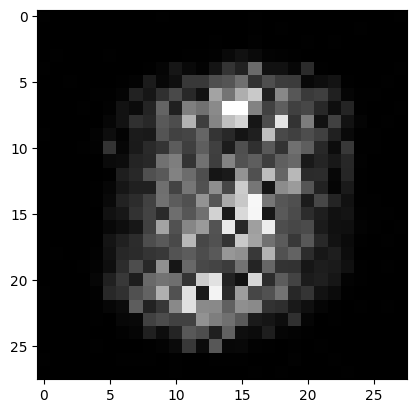

Ploting:  8


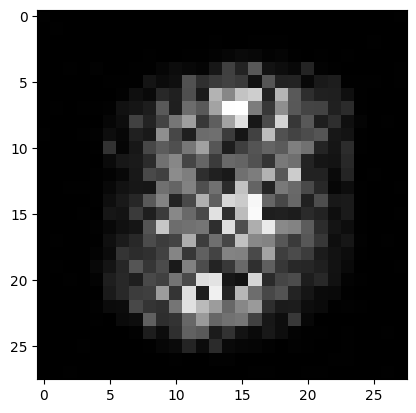

Ploting:  9


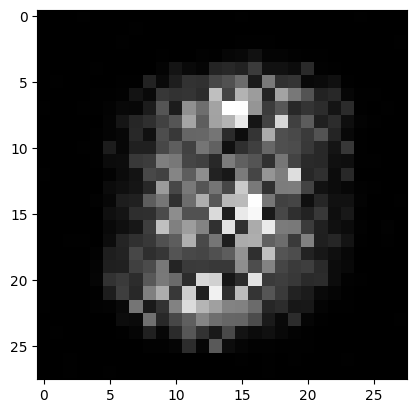

Epoch: 79550
loss_g: 1.7711591720581055 	loss_d: 0.386026531457901
Epoch: 79600
loss_g: 1.7611550092697144 	loss_d: 0.35030677914619446
Epoch: 79650
loss_g: 1.7594650983810425 	loss_d: 0.35662367939949036
Epoch: 79700
loss_g: 1.7260184288024902 	loss_d: 0.3552228510379791
Epoch: 79750
loss_g: 1.7284845113754272 	loss_d: 0.4493153691291809
Epoch: 79800
loss_g: 1.719664454460144 	loss_d: 0.4809701442718506
Epoch: 79850
loss_g: 1.7208902835845947 	loss_d: 0.4024955630302429
Epoch: 79900
loss_g: 1.7188968658447266 	loss_d: 0.41023939847946167
Epoch: 79950
loss_g: 1.7250761985778809 	loss_d: 0.39928385615348816
Epoch: 80000
loss_g: 1.734741449356079 	loss_d: 0.4455329179763794
Ploting:  1


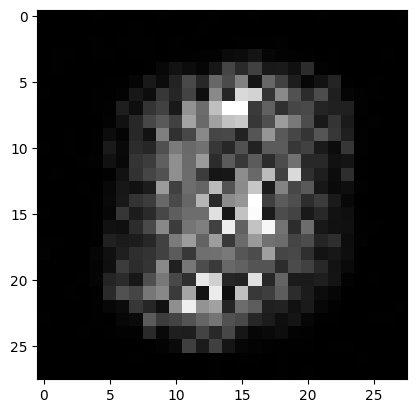

Ploting:  0


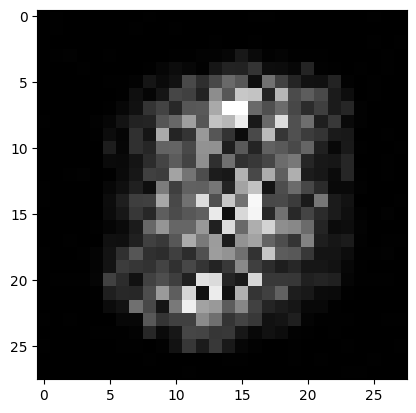

Ploting:  5


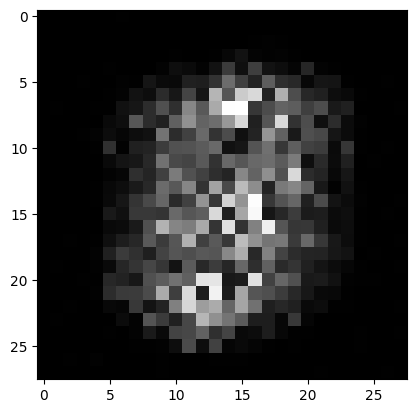

Epoch: 80050
loss_g: 1.7215251922607422 	loss_d: 0.4081052541732788
Epoch: 80100
loss_g: 1.6969579458236694 	loss_d: 0.4126918613910675
Epoch: 80150
loss_g: 1.7311769723892212 	loss_d: 0.4376741051673889
Epoch: 80200
loss_g: 1.6819021701812744 	loss_d: 0.44376352429389954
Epoch: 80250
loss_g: 1.6999773979187012 	loss_d: 0.4018145203590393
Epoch: 80300
loss_g: 1.6955785751342773 	loss_d: 0.3883100152015686
Epoch: 80350
loss_g: 1.6813321113586426 	loss_d: 0.3465974032878876
Epoch: 80400
loss_g: 1.6757140159606934 	loss_d: 0.39231014251708984
Epoch: 80450
loss_g: 1.6794185638427734 	loss_d: 0.42690202593803406
Epoch: 80500
loss_g: 1.679089903831482 	loss_d: 0.41552093625068665
Ploting:  6


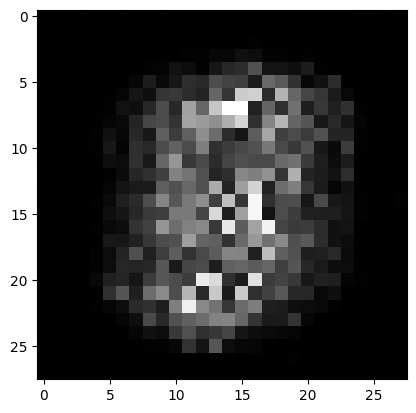

Ploting:  6


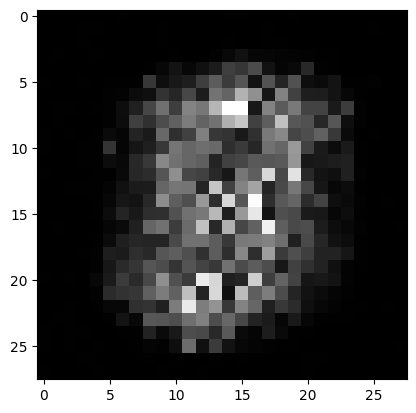

Ploting:  2


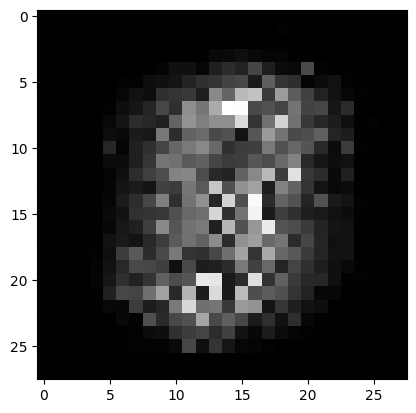

Epoch: 80550
loss_g: 1.6951448917388916 	loss_d: 0.40772250294685364
Epoch: 80600
loss_g: 1.6725237369537354 	loss_d: 0.4160453975200653
Epoch: 80650
loss_g: 1.6532914638519287 	loss_d: 0.4625473618507385
Epoch: 80700
loss_g: 1.6611571311950684 	loss_d: 0.4322008788585663
Epoch: 80750
loss_g: 1.6267054080963135 	loss_d: 0.4361121356487274
Epoch: 80800
loss_g: 1.6331151723861694 	loss_d: 0.4000658392906189
Epoch: 80850
loss_g: 1.6390146017074585 	loss_d: 0.4033072888851166
Epoch: 80900
loss_g: 1.6119942665100098 	loss_d: 0.3971589207649231
Epoch: 80950
loss_g: 1.6025376319885254 	loss_d: 0.4825001657009125
Epoch: 81000
loss_g: 1.6137824058532715 	loss_d: 0.4888153076171875
Ploting:  2


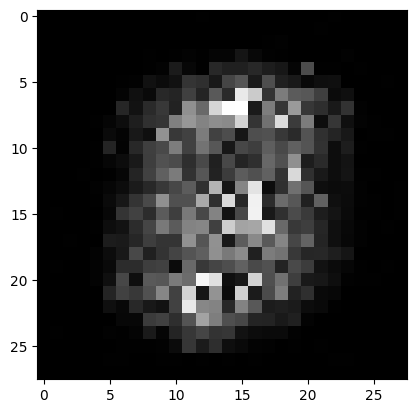

Ploting:  4


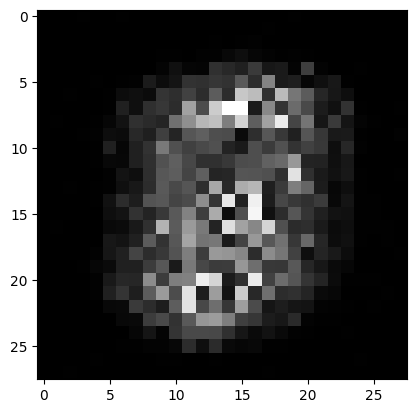

Ploting:  6


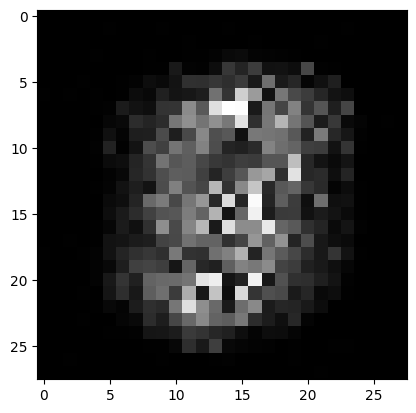

Epoch: 81050
loss_g: 1.5964716672897339 	loss_d: 0.49311575293540955
Epoch: 81100
loss_g: 1.588586449623108 	loss_d: 0.44167056679725647
Epoch: 81150
loss_g: 1.584250569343567 	loss_d: 0.4599877893924713
Epoch: 81200
loss_g: 1.5669195652008057 	loss_d: 0.4791708290576935
Epoch: 81250
loss_g: 1.599449872970581 	loss_d: 0.40416717529296875
Epoch: 81300
loss_g: 1.5565522909164429 	loss_d: 0.4936736226081848
Epoch: 81350
loss_g: 1.5201058387756348 	loss_d: 0.44105133414268494
Epoch: 81400
loss_g: 1.5660443305969238 	loss_d: 0.40300777554512024
Epoch: 81450
loss_g: 1.5487251281738281 	loss_d: 0.4312252700328827
Epoch: 81500
loss_g: 1.5720291137695312 	loss_d: 0.44750988483428955
Ploting:  0


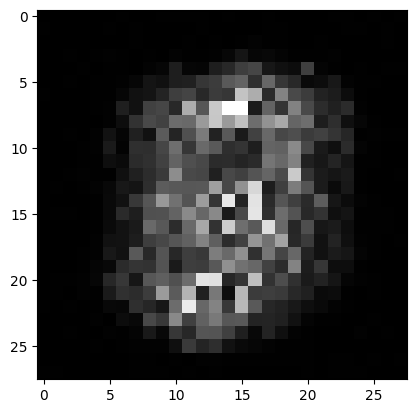

Ploting:  0


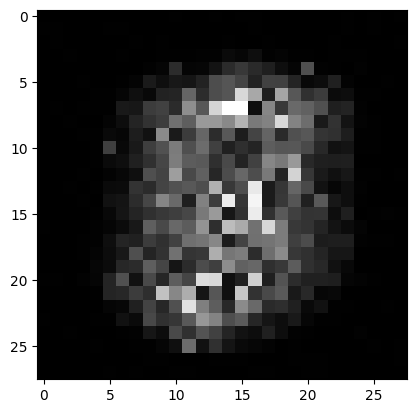

Ploting:  1


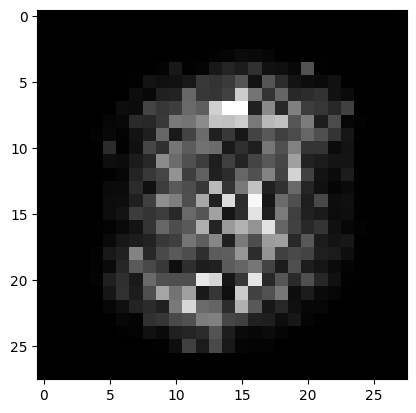

Epoch: 81550
loss_g: 1.5411428213119507 	loss_d: 0.4352112114429474
Epoch: 81600
loss_g: 1.5611623525619507 	loss_d: 0.4364691972732544
Epoch: 81650
loss_g: 1.528906226158142 	loss_d: 0.4223070442676544
Epoch: 81700
loss_g: 1.5347814559936523 	loss_d: 0.5046582221984863
Epoch: 81750
loss_g: 1.5482958555221558 	loss_d: 0.515782356262207
Epoch: 81800
loss_g: 1.5218020677566528 	loss_d: 0.46234312653541565
Epoch: 81850
loss_g: 1.5349068641662598 	loss_d: 0.38799965381622314
Epoch: 81900
loss_g: 1.5289859771728516 	loss_d: 0.4473945200443268
Epoch: 81950
loss_g: 1.5338103771209717 	loss_d: 0.4936755895614624
Epoch: 82000
loss_g: 1.5151182413101196 	loss_d: 0.44278326630592346
Ploting:  1


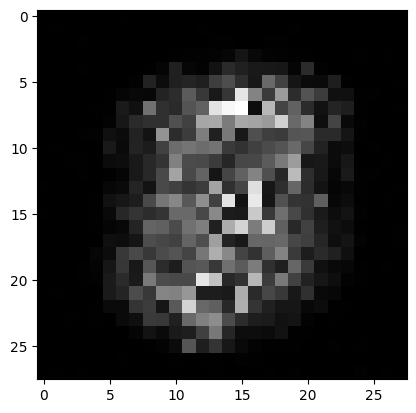

Ploting:  3


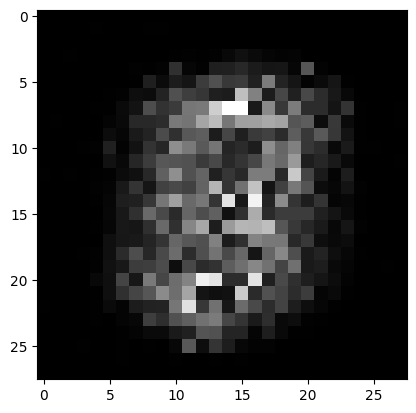

Ploting:  5


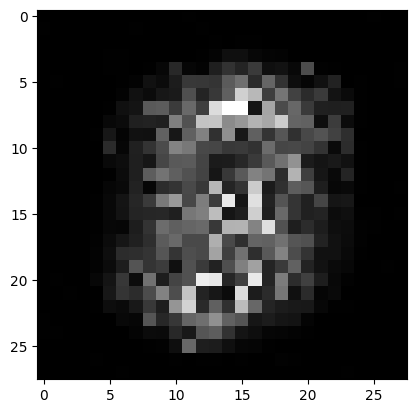

Epoch: 82050
loss_g: 1.5483993291854858 	loss_d: 0.4399278461933136
Epoch: 82100
loss_g: 1.5026732683181763 	loss_d: 0.4496106505393982
Epoch: 82150
loss_g: 1.4981396198272705 	loss_d: 0.5528210401535034
Epoch: 82200
loss_g: 1.4885163307189941 	loss_d: 0.5762907862663269
Epoch: 82250
loss_g: 1.4948382377624512 	loss_d: 0.49058178067207336
Epoch: 82300
loss_g: 1.4515998363494873 	loss_d: 0.5101745128631592
Epoch: 82350
loss_g: 1.494028091430664 	loss_d: 0.5091506838798523
Epoch: 82400
loss_g: 1.4726494550704956 	loss_d: 0.5363465547561646
Epoch: 82450
loss_g: 1.4571270942687988 	loss_d: 0.5076690316200256
Epoch: 82500
loss_g: 1.4496312141418457 	loss_d: 0.507252037525177
Ploting:  1


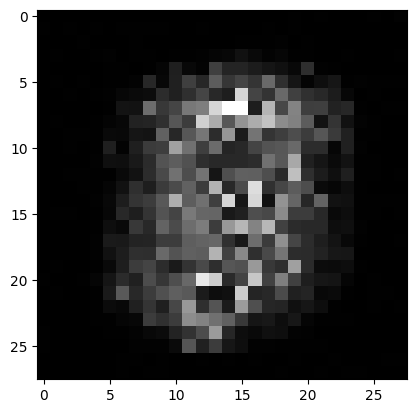

Ploting:  1


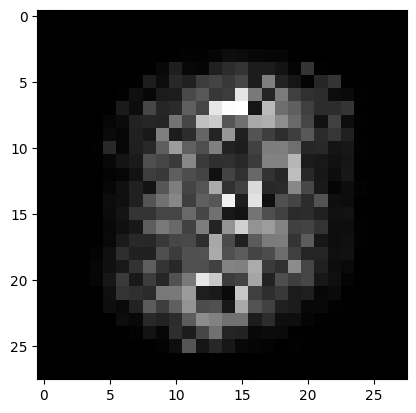

Ploting:  4


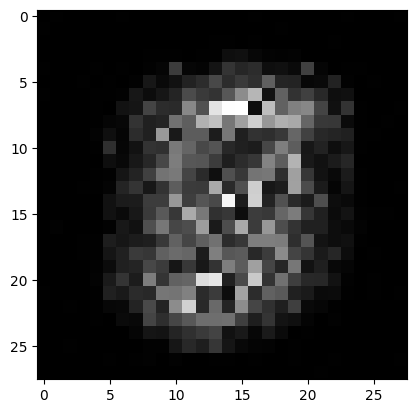

Epoch: 82550
loss_g: 1.426573634147644 	loss_d: 0.561943769454956
Epoch: 82600
loss_g: 1.4091796875 	loss_d: 0.5670602917671204
Epoch: 82650
loss_g: 1.4210878610610962 	loss_d: 0.5023248791694641
Epoch: 82700
loss_g: 1.4165230989456177 	loss_d: 0.5032278895378113
Epoch: 82750
loss_g: 1.4266146421432495 	loss_d: 0.4829563796520233
Epoch: 82800
loss_g: 1.4255177974700928 	loss_d: 0.4914586544036865
Epoch: 82850
loss_g: 1.4086790084838867 	loss_d: 0.5225852727890015
Epoch: 82900
loss_g: 1.4085273742675781 	loss_d: 0.5096136331558228
Epoch: 82950
loss_g: 1.407808780670166 	loss_d: 0.5228719711303711
Epoch: 83000
loss_g: 1.3947505950927734 	loss_d: 0.5343070030212402
Ploting:  3


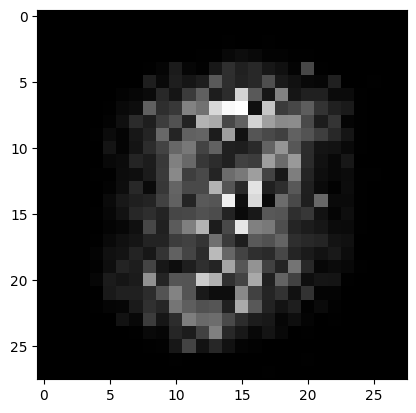

Ploting:  8


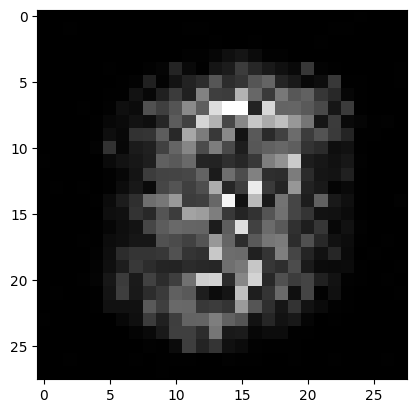

Ploting:  0


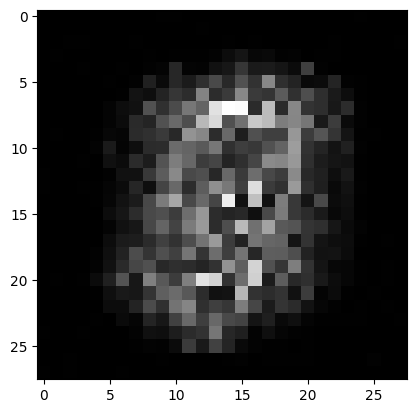

Epoch: 83050
loss_g: 1.3843506574630737 	loss_d: 0.5865998268127441
Epoch: 83100
loss_g: 1.3702387809753418 	loss_d: 0.5761684775352478
Epoch: 83150
loss_g: 1.4018551111221313 	loss_d: 0.5568862557411194
Epoch: 83200
loss_g: 1.3806097507476807 	loss_d: 0.5085320472717285
Epoch: 83250
loss_g: 1.3619695901870728 	loss_d: 0.5132611989974976
Epoch: 83300
loss_g: 1.3381456136703491 	loss_d: 0.5331288576126099
Epoch: 83350
loss_g: 1.3617185354232788 	loss_d: 0.5811245441436768
Epoch: 83400
loss_g: 1.3481733798980713 	loss_d: 0.5941421985626221
Epoch: 83450
loss_g: 1.3167827129364014 	loss_d: 0.5947989225387573
Epoch: 83500
loss_g: 1.314329981803894 	loss_d: 0.5476202368736267
Ploting:  3


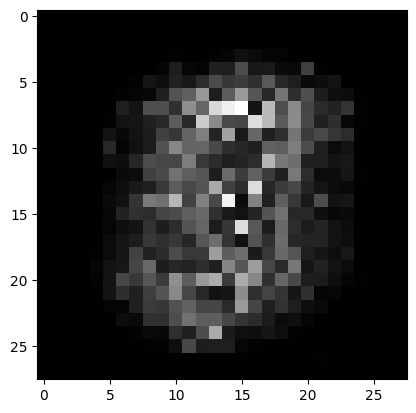

Ploting:  9


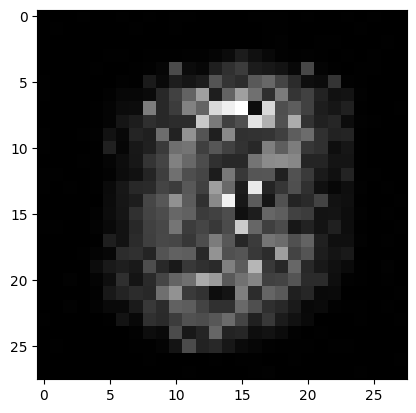

Ploting:  9


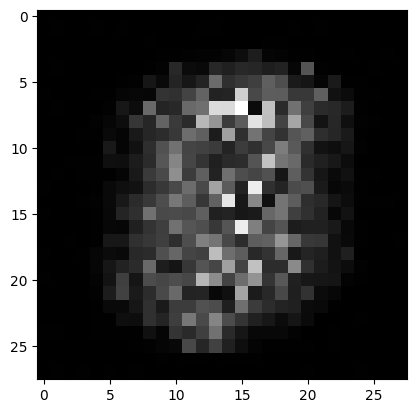

Epoch: 83550
loss_g: 1.3240288496017456 	loss_d: 0.60407555103302
Epoch: 83600
loss_g: 1.3099584579467773 	loss_d: 0.6136014461517334
Epoch: 83650
loss_g: 1.3291066884994507 	loss_d: 0.4996340572834015
Epoch: 83700
loss_g: 1.3193399906158447 	loss_d: 0.5915158987045288
Epoch: 83750
loss_g: 1.2680211067199707 	loss_d: 0.5697644352912903
Epoch: 83800
loss_g: 1.2741148471832275 	loss_d: 0.5344781875610352
Epoch: 83850
loss_g: 1.3014605045318604 	loss_d: 0.572331428527832
Epoch: 83900
loss_g: 1.293737769126892 	loss_d: 0.565808117389679
Epoch: 83950
loss_g: 1.295687198638916 	loss_d: 0.5688150525093079
Epoch: 84000
loss_g: 1.277996301651001 	loss_d: 0.5912941098213196
Ploting:  3


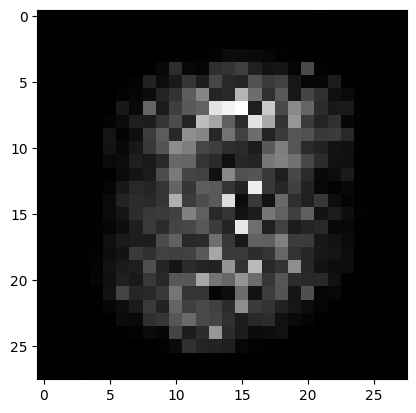

Ploting:  5


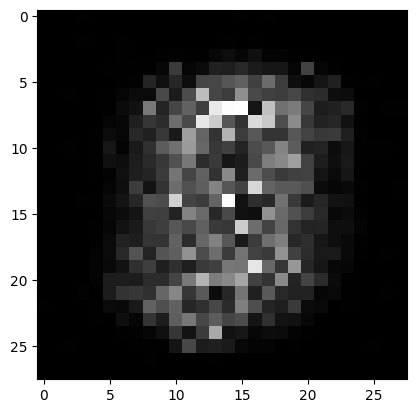

Ploting:  2


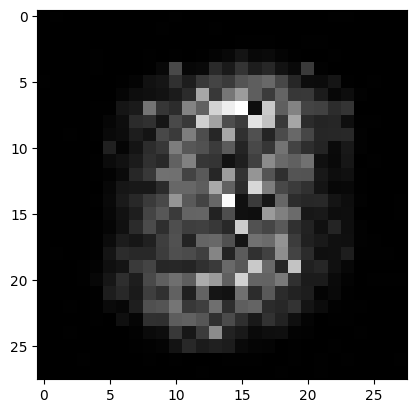

Epoch: 84050
loss_g: 1.2641072273254395 	loss_d: 0.5411343574523926
Epoch: 84100
loss_g: 1.2553257942199707 	loss_d: 0.6511856913566589
Epoch: 84150
loss_g: 1.2443490028381348 	loss_d: 0.6581220626831055
Epoch: 84200
loss_g: 1.2302106618881226 	loss_d: 0.6489271521568298
Epoch: 84250
loss_g: 1.2315973043441772 	loss_d: 0.5458338856697083
Epoch: 84300
loss_g: 1.2172061204910278 	loss_d: 0.6045869588851929
Epoch: 84350
loss_g: 1.1901017427444458 	loss_d: 0.64507657289505
Epoch: 84400
loss_g: 1.1601883172988892 	loss_d: 0.6291060447692871
Epoch: 84450
loss_g: 1.1570757627487183 	loss_d: 0.622759222984314
Epoch: 84500
loss_g: 1.1716779470443726 	loss_d: 0.6647197008132935
Ploting:  1


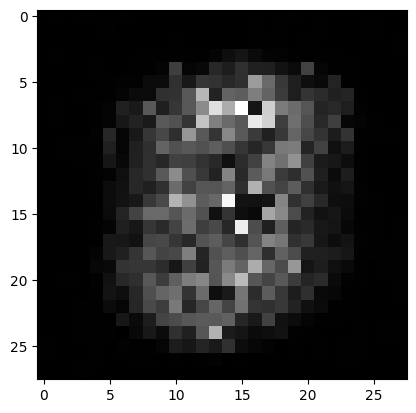

Ploting:  0


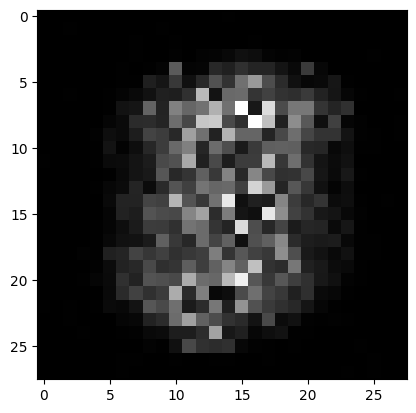

Ploting:  3


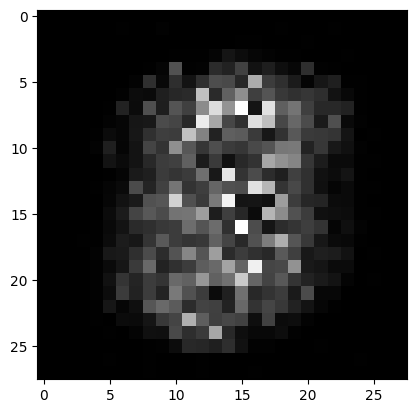

Epoch: 84550
loss_g: 1.117275357246399 	loss_d: 0.7801228165626526
Epoch: 84600
loss_g: 1.0933096408843994 	loss_d: 0.8312804698944092
Epoch: 84650
loss_g: 1.106852412223816 	loss_d: 0.7541665434837341
Epoch: 84700
loss_g: 1.0792022943496704 	loss_d: 0.7586169242858887
Epoch: 84750
loss_g: 1.0872864723205566 	loss_d: 0.7731812000274658
Epoch: 84800
loss_g: 1.051236867904663 	loss_d: 0.777615487575531
Epoch: 84850
loss_g: 1.0628639459609985 	loss_d: 0.7361663579940796
Epoch: 84900
loss_g: 1.040906310081482 	loss_d: 0.7305837273597717
Epoch: 84950
loss_g: 1.060272455215454 	loss_d: 0.8371708989143372
Epoch: 85000
loss_g: 1.0327258110046387 	loss_d: 0.8137726187705994
Ploting:  4


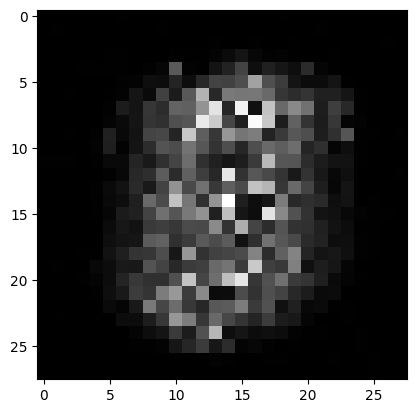

Ploting:  9


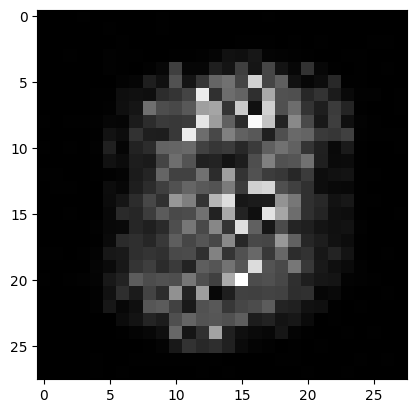

Ploting:  0


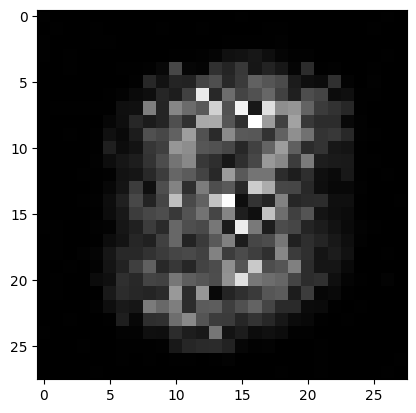

Epoch: 85050
loss_g: 1.0436042547225952 	loss_d: 0.790264904499054
Epoch: 85100
loss_g: 1.0178121328353882 	loss_d: 0.7745152115821838
Epoch: 85150
loss_g: 1.002270221710205 	loss_d: 0.7607197165489197
Epoch: 85200
loss_g: 0.9810685515403748 	loss_d: 0.7892473936080933
Epoch: 85250
loss_g: 0.9817200899124146 	loss_d: 0.8128321766853333
Epoch: 85300
loss_g: 0.9621697664260864 	loss_d: 0.8001044988632202
Epoch: 85350
loss_g: 0.9714866280555725 	loss_d: 0.8453081846237183
Epoch: 85400
loss_g: 0.931972861289978 	loss_d: 0.8981207609176636
Epoch: 85450
loss_g: 0.936286211013794 	loss_d: 0.9123110771179199
Epoch: 85500
loss_g: 0.9390125870704651 	loss_d: 0.9762586951255798
Ploting:  5


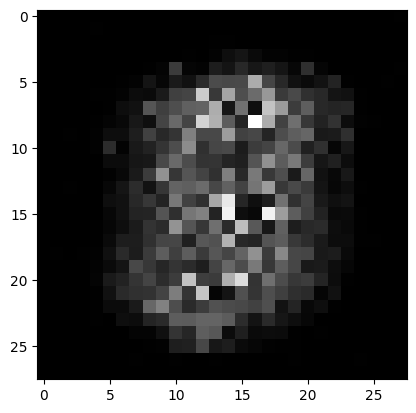

Ploting:  0


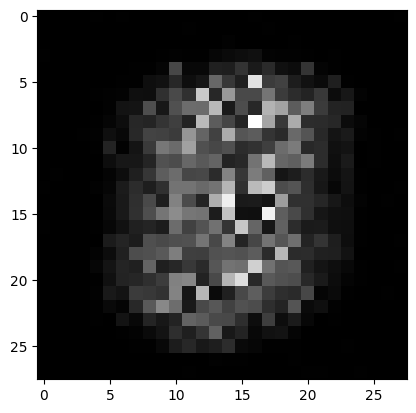

Ploting:  3


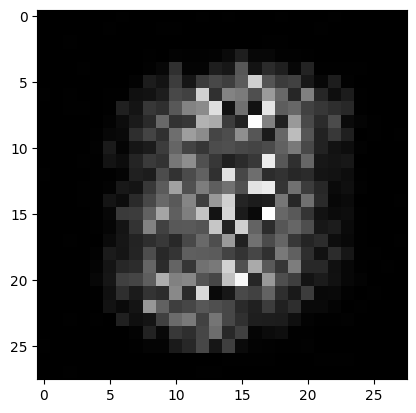

Epoch: 85550
loss_g: 0.9344238042831421 	loss_d: 0.8946183323860168
Epoch: 85600
loss_g: 0.911314070224762 	loss_d: 0.885502278804779
Epoch: 85650
loss_g: 0.9072949886322021 	loss_d: 0.8400973081588745
Epoch: 85700
loss_g: 0.8894018530845642 	loss_d: 0.910564124584198
Epoch: 85750
loss_g: 0.884383499622345 	loss_d: 0.9214823842048645
Epoch: 85800
loss_g: 0.8717953562736511 	loss_d: 0.9365556240081787
Epoch: 85850
loss_g: 0.8775122165679932 	loss_d: 0.9647710919380188
Epoch: 85900
loss_g: 0.8964800834655762 	loss_d: 0.9061419367790222
Epoch: 85950
loss_g: 0.8792731761932373 	loss_d: 0.9888561964035034
Epoch: 86000
loss_g: 0.8842077255249023 	loss_d: 0.9753064513206482
Ploting:  1


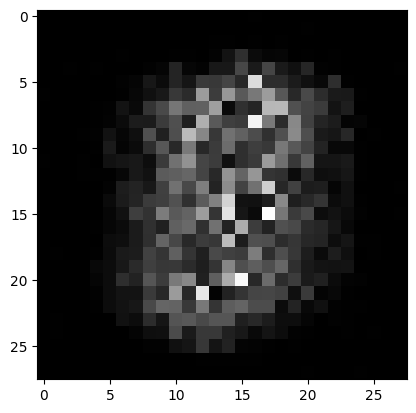

Ploting:  0


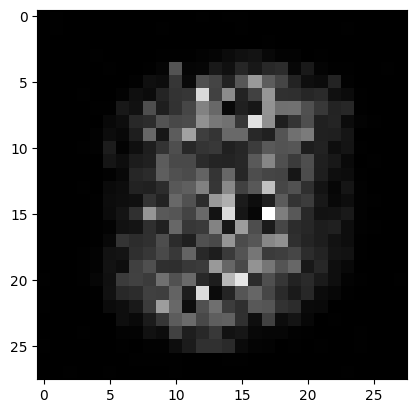

Ploting:  2


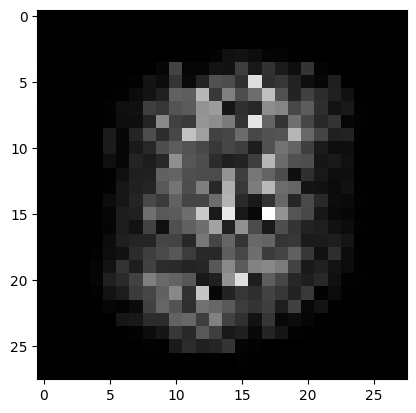

Epoch: 86050
loss_g: 0.8644135594367981 	loss_d: 0.8412716388702393
Epoch: 86100
loss_g: 0.8959947824478149 	loss_d: 0.9270418882369995
Epoch: 86150
loss_g: 0.8568537831306458 	loss_d: 0.8965774178504944
Epoch: 86200
loss_g: 0.8805407285690308 	loss_d: 0.8948342204093933
Epoch: 86250
loss_g: 0.8530004620552063 	loss_d: 0.948383629322052
Epoch: 86300
loss_g: 0.8785641193389893 	loss_d: 0.8877741098403931
Epoch: 86350
loss_g: 0.8640315532684326 	loss_d: 0.888005793094635
Epoch: 86400
loss_g: 0.8629533052444458 	loss_d: 0.889716625213623
Epoch: 86450
loss_g: 0.8503829836845398 	loss_d: 0.8587305545806885
Epoch: 86500
loss_g: 0.8522590398788452 	loss_d: 0.9188058972358704
Ploting:  3


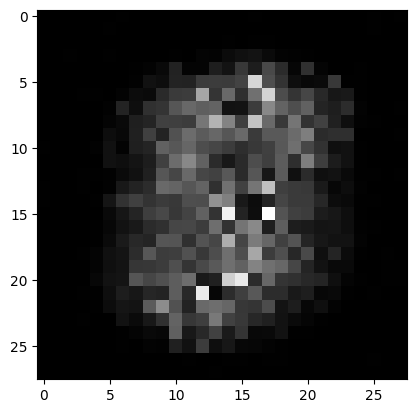

Ploting:  9


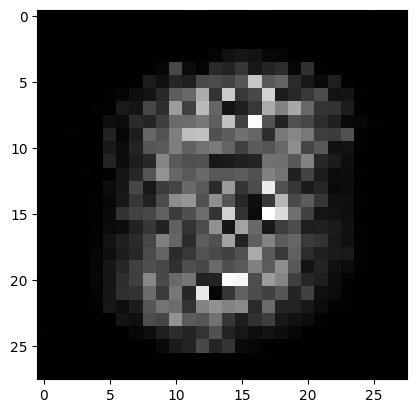

Ploting:  3


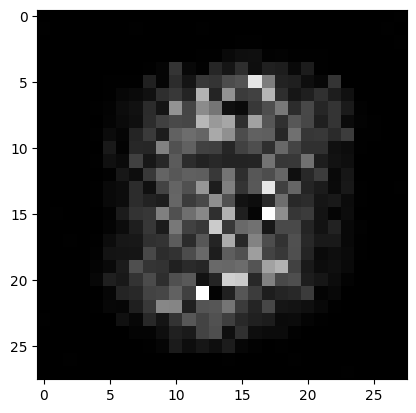

Epoch: 86550
loss_g: 0.8414937257766724 	loss_d: 0.9832496643066406
Epoch: 86600
loss_g: 0.847876250743866 	loss_d: 0.9722164869308472
Epoch: 86650
loss_g: 0.8518822193145752 	loss_d: 0.8414356708526611
Epoch: 86700
loss_g: 0.838150143623352 	loss_d: 0.9152825474739075
Epoch: 86750
loss_g: 0.8469324111938477 	loss_d: 0.9063389301300049
Epoch: 86800
loss_g: 0.8247695565223694 	loss_d: 0.918151319026947
Epoch: 86850
loss_g: 0.8256033062934875 	loss_d: 0.8528123497962952
Epoch: 86900
loss_g: 0.8161903023719788 	loss_d: 0.9266751408576965
Epoch: 86950
loss_g: 0.8063983917236328 	loss_d: 1.0167137384414673
Epoch: 87000
loss_g: 0.8155474662780762 	loss_d: 1.0213524103164673
Ploting:  4


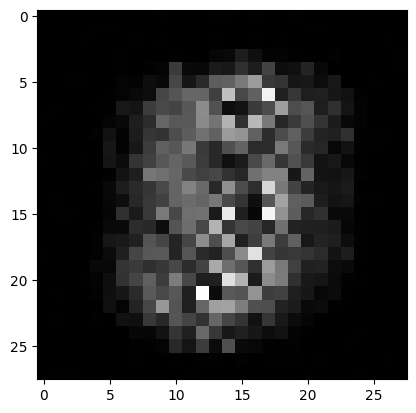

Ploting:  5


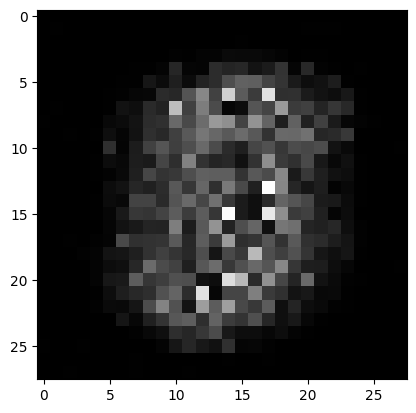

Ploting:  1


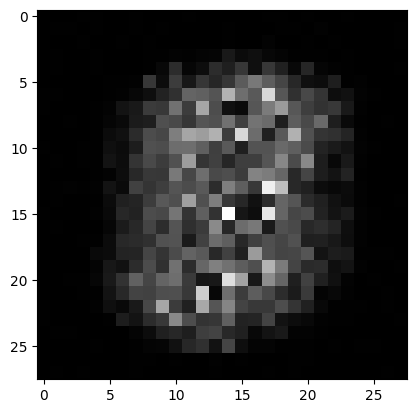

Epoch: 87050
loss_g: 0.7971086502075195 	loss_d: 0.9963690042495728
Epoch: 87100
loss_g: 0.821558952331543 	loss_d: 0.9645833969116211
Epoch: 87150
loss_g: 0.8176425099372864 	loss_d: 0.996286153793335
Epoch: 87200
loss_g: 0.8040705919265747 	loss_d: 1.0217112302780151
Epoch: 87250
loss_g: 0.798450767993927 	loss_d: 0.9191250205039978
Epoch: 87300
loss_g: 0.7990217208862305 	loss_d: 0.9384992718696594
Epoch: 87350
loss_g: 0.774848461151123 	loss_d: 1.0497809648513794
Epoch: 87400
loss_g: 0.781928539276123 	loss_d: 0.9984802007675171
Epoch: 87450
loss_g: 0.7706324458122253 	loss_d: 1.0101039409637451
Epoch: 87500
loss_g: 0.7667116522789001 	loss_d: 1.0073455572128296
Ploting:  4


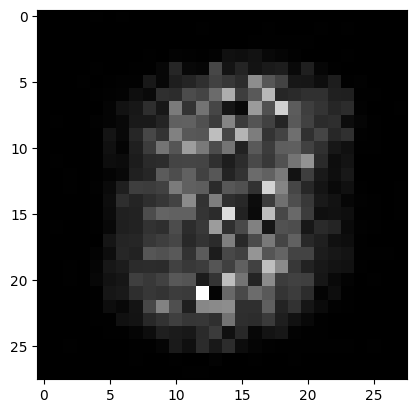

Ploting:  5


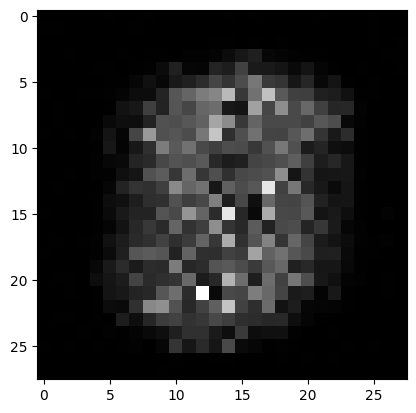

Ploting:  3


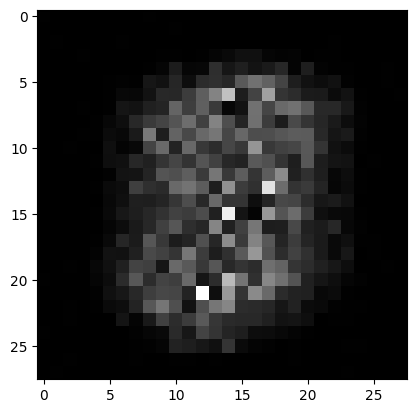

Epoch: 87550
loss_g: 0.7548252940177917 	loss_d: 0.9594444036483765
Epoch: 87600
loss_g: 0.7631112337112427 	loss_d: 1.0126694440841675
Epoch: 87650
loss_g: 0.7479287385940552 	loss_d: 1.0258007049560547
Epoch: 87700
loss_g: 0.7567217946052551 	loss_d: 0.9487325549125671
Epoch: 87750
loss_g: 0.721369743347168 	loss_d: 1.0078661441802979
Epoch: 87800
loss_g: 0.7467900514602661 	loss_d: 1.120108723640442
Epoch: 87850
loss_g: 0.7137752175331116 	loss_d: 1.067651391029358
Epoch: 87900
loss_g: 0.7204990386962891 	loss_d: 1.1276849508285522
Epoch: 87950
loss_g: 0.7240505814552307 	loss_d: 1.0236867666244507
Epoch: 88000
loss_g: 0.6972646713256836 	loss_d: 1.0613690614700317
Ploting:  9


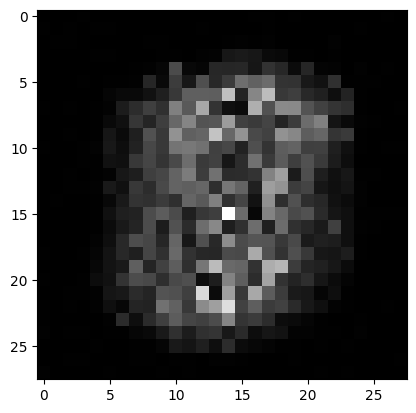

Ploting:  3


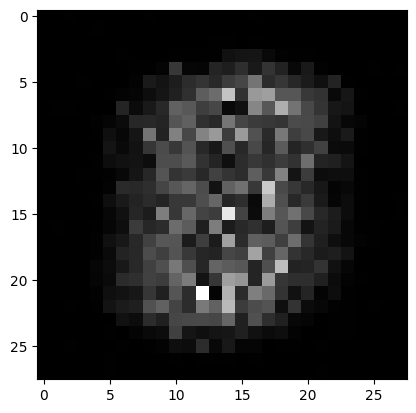

Ploting:  5


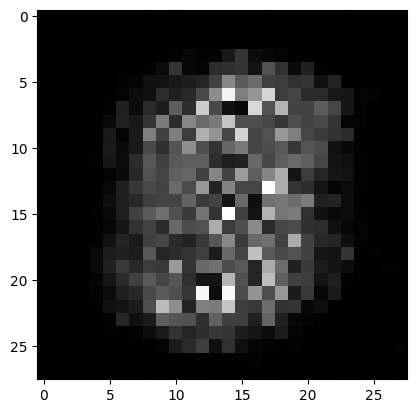

Epoch: 88050
loss_g: 0.7013136148452759 	loss_d: 1.017905592918396
Epoch: 88100
loss_g: 0.7135847210884094 	loss_d: 1.0610623359680176
Epoch: 88150
loss_g: 0.7051904797554016 	loss_d: 1.1113179922103882
Epoch: 88200
loss_g: 0.6955435276031494 	loss_d: 1.1184991598129272
Epoch: 88250
loss_g: 0.7048668265342712 	loss_d: 1.1679009199142456
Epoch: 88300
loss_g: 0.6784228086471558 	loss_d: 1.101028561592102
Epoch: 88350
loss_g: 0.7021587491035461 	loss_d: 1.1404519081115723
Epoch: 88400
loss_g: 0.6976866722106934 	loss_d: 1.1257035732269287
Epoch: 88450
loss_g: 0.6810911297798157 	loss_d: 1.0591106414794922
Epoch: 88500
loss_g: 0.6633913516998291 	loss_d: 1.1048130989074707
Ploting:  9


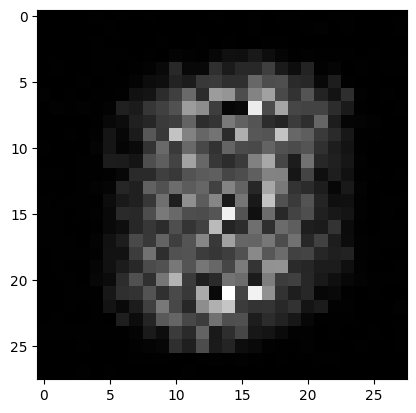

Ploting:  3


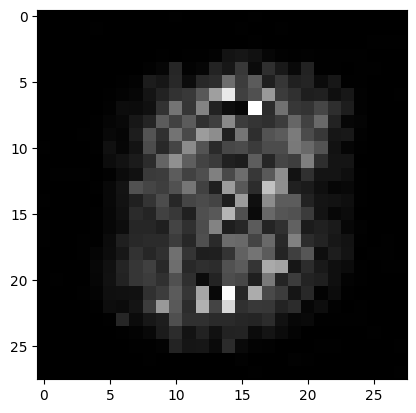

Ploting:  1


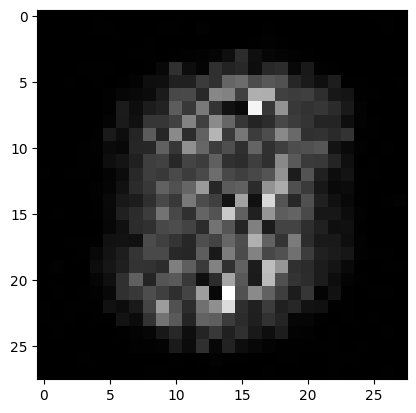

Epoch: 88550
loss_g: 0.6801103949546814 	loss_d: 1.0633060932159424
Epoch: 88600
loss_g: 0.6699594259262085 	loss_d: 1.0818982124328613
Epoch: 88650
loss_g: 0.6694216728210449 	loss_d: 1.1311988830566406
Epoch: 88700
loss_g: 0.6830929517745972 	loss_d: 1.0308551788330078
Epoch: 88750
loss_g: 0.6625599265098572 	loss_d: 1.1138619184494019
Epoch: 88800
loss_g: 0.6669027805328369 	loss_d: 1.0893845558166504
Epoch: 88850
loss_g: 0.6747145056724548 	loss_d: 1.0629582405090332
Epoch: 88900
loss_g: 0.6613682508468628 	loss_d: 1.0929292440414429
Epoch: 88950
loss_g: 0.6821302771568298 	loss_d: 1.1462911367416382
Epoch: 89000
loss_g: 0.6848190426826477 	loss_d: 1.1087100505828857
Ploting:  9


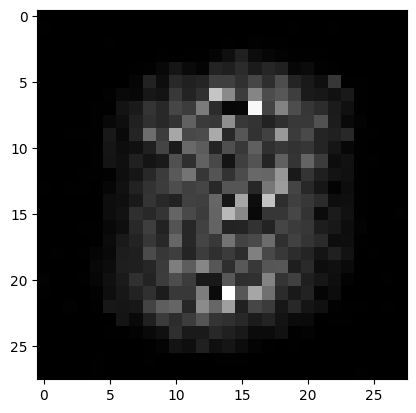

Ploting:  8


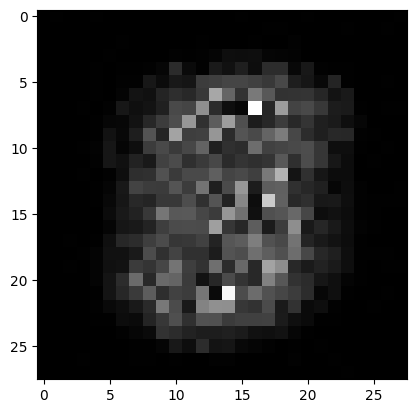

Ploting:  1


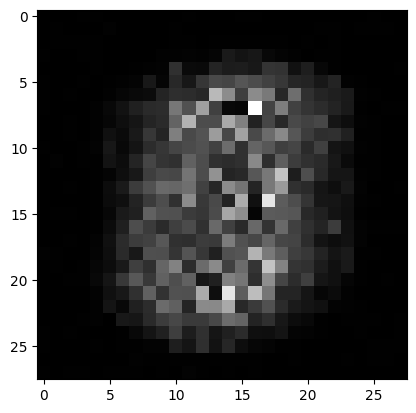

Epoch: 89050
loss_g: 0.6805638670921326 	loss_d: 1.0222761631011963
Epoch: 89100
loss_g: 0.6745954155921936 	loss_d: 1.0782612562179565
Epoch: 89150
loss_g: 0.6812924742698669 	loss_d: 1.0517897605895996
Epoch: 89200
loss_g: 0.6744906306266785 	loss_d: 1.0687289237976074
Epoch: 89250
loss_g: 0.7024505734443665 	loss_d: 0.9712617993354797
Epoch: 89300
loss_g: 0.6788245439529419 	loss_d: 1.0365982055664062
Epoch: 89350
loss_g: 0.6866106986999512 	loss_d: 1.0869905948638916
Epoch: 89400
loss_g: 0.694092333316803 	loss_d: 1.0999164581298828
Epoch: 89450
loss_g: 0.7074406743049622 	loss_d: 1.0701003074645996
Epoch: 89500
loss_g: 0.6983943581581116 	loss_d: 1.0397872924804688
Ploting:  2


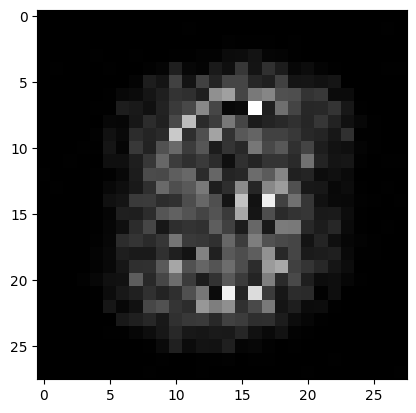

Ploting:  4


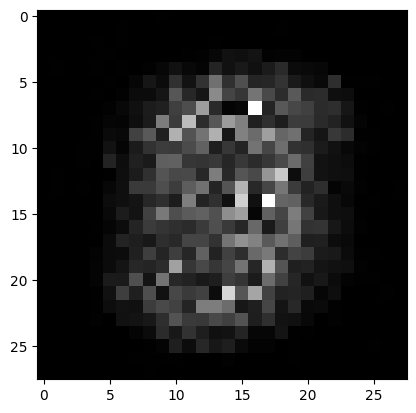

Ploting:  7


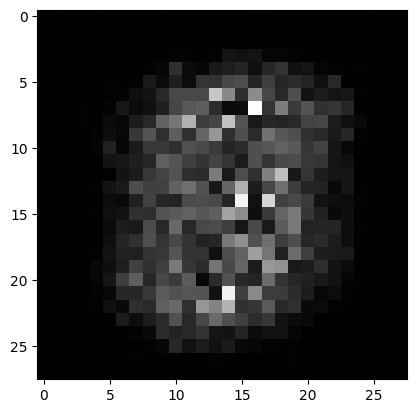

Epoch: 89550
loss_g: 0.7210543751716614 	loss_d: 1.0334528684616089
Epoch: 89600
loss_g: 0.7132453918457031 	loss_d: 1.0435293912887573
Epoch: 89650
loss_g: 0.729131817817688 	loss_d: 0.9554576873779297
Epoch: 89700
loss_g: 0.7433087229728699 	loss_d: 0.9601641893386841
Epoch: 89750
loss_g: 0.7420586347579956 	loss_d: 1.0380171537399292
Epoch: 89800
loss_g: 0.7434455752372742 	loss_d: 0.9534127712249756
Epoch: 89850
loss_g: 0.7477038502693176 	loss_d: 0.9412678480148315
Epoch: 89900
loss_g: 0.7567649483680725 	loss_d: 0.9524692893028259
Epoch: 89950
loss_g: 0.7432075142860413 	loss_d: 0.9222127795219421
Epoch: 90000
loss_g: 0.7800621390342712 	loss_d: 0.9435825943946838
Ploting:  9


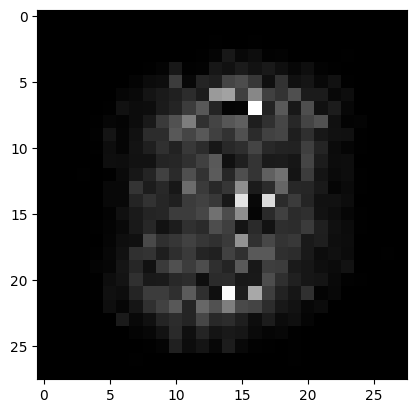

Ploting:  0


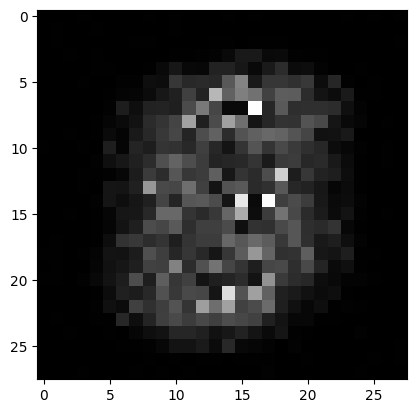

Ploting:  2


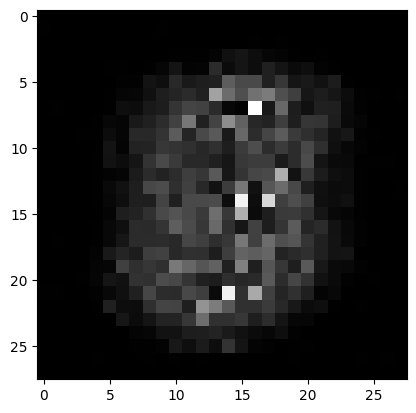

Epoch: 90050
loss_g: 0.7833561301231384 	loss_d: 0.9505307078361511
Epoch: 90100
loss_g: 0.7985590696334839 	loss_d: 0.8618966341018677
Epoch: 90150
loss_g: 0.814932107925415 	loss_d: 0.8476629257202148
Epoch: 90200
loss_g: 0.8056162595748901 	loss_d: 0.93804532289505
Epoch: 90250
loss_g: 0.8219919204711914 	loss_d: 0.8876479864120483
Epoch: 90300
loss_g: 0.8317065834999084 	loss_d: 0.9339554309844971
Epoch: 90350
loss_g: 0.833709716796875 	loss_d: 0.8001749515533447
Epoch: 90400
loss_g: 0.8341596722602844 	loss_d: 0.8402321934700012
Epoch: 90450
loss_g: 0.8694808483123779 	loss_d: 0.7861141562461853
Epoch: 90500
loss_g: 0.8709096908569336 	loss_d: 0.8061795830726624
Ploting:  8


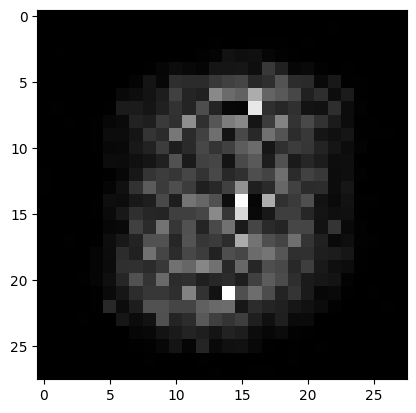

Ploting:  8


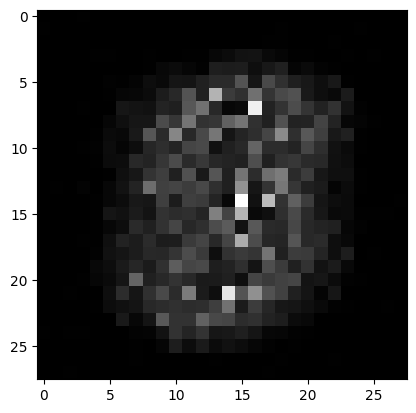

Ploting:  4


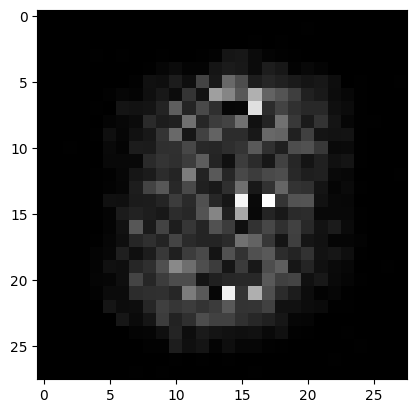

Epoch: 90550
loss_g: 0.8997451066970825 	loss_d: 0.8384051322937012
Epoch: 90600
loss_g: 0.8778558969497681 	loss_d: 0.8397989273071289
Epoch: 90650
loss_g: 0.8914817571640015 	loss_d: 0.8421407341957092
Epoch: 90700
loss_g: 0.9013106822967529 	loss_d: 0.7940285801887512
Epoch: 90750
loss_g: 0.9137517213821411 	loss_d: 0.7915741801261902
Epoch: 90800
loss_g: 0.9240590333938599 	loss_d: 0.7889450788497925
Epoch: 90850
loss_g: 0.9320335388183594 	loss_d: 0.7111429572105408
Epoch: 90900
loss_g: 0.9177064299583435 	loss_d: 0.7539187669754028
Epoch: 90950
loss_g: 0.9327752590179443 	loss_d: 0.7312321066856384
Epoch: 91000
loss_g: 0.9494157433509827 	loss_d: 0.715307891368866
Ploting:  3


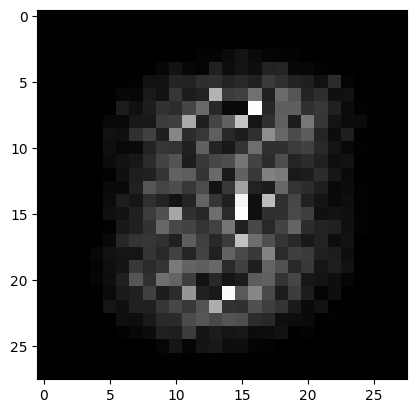

Ploting:  7


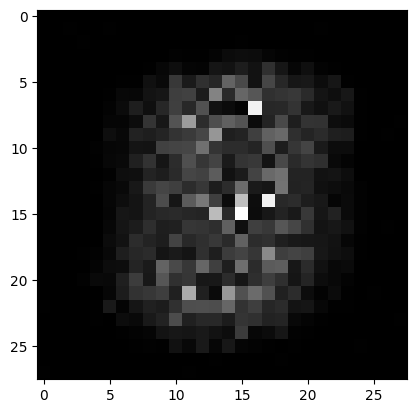

Ploting:  2


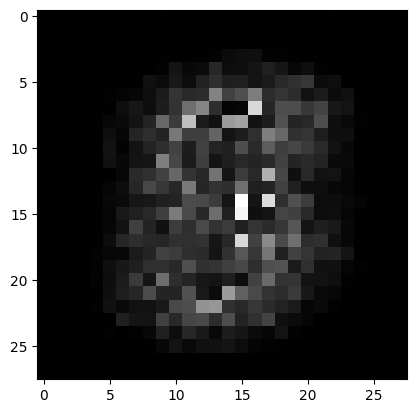

Epoch: 91050
loss_g: 0.9564597606658936 	loss_d: 0.7323052883148193
Epoch: 91100
loss_g: 0.9531864523887634 	loss_d: 0.6509846448898315
Epoch: 91150
loss_g: 0.9577378034591675 	loss_d: 0.7284576296806335
Epoch: 91200
loss_g: 0.9673281908035278 	loss_d: 0.6745412945747375
Epoch: 91250
loss_g: 0.9677518010139465 	loss_d: 0.6786270141601562
Epoch: 91300
loss_g: 0.9621713161468506 	loss_d: 0.6974545121192932
Epoch: 91350
loss_g: 0.9926900863647461 	loss_d: 0.7015631198883057
Epoch: 91400
loss_g: 0.9972805380821228 	loss_d: 0.7071037292480469
Epoch: 91450
loss_g: 0.9854636788368225 	loss_d: 0.6450971364974976
Epoch: 91500
loss_g: 1.0134352445602417 	loss_d: 0.6649448871612549
Ploting:  5


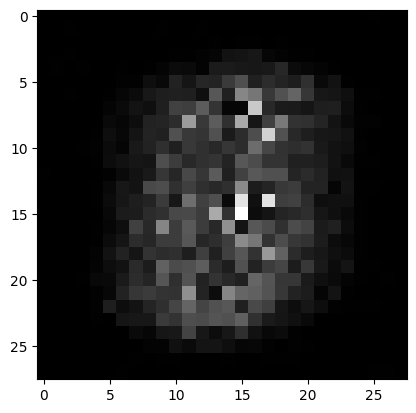

Ploting:  0


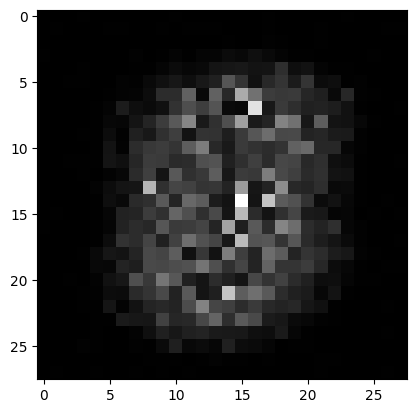

Ploting:  4


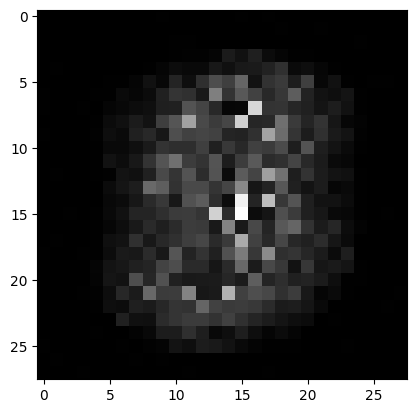

Epoch: 91550
loss_g: 1.0010465383529663 	loss_d: 0.6466423869132996
Epoch: 91600
loss_g: 0.9809326529502869 	loss_d: 0.676975667476654
Epoch: 91650
loss_g: 1.0104326009750366 	loss_d: 0.6182365417480469
Epoch: 91700
loss_g: 1.0065308809280396 	loss_d: 0.6523361802101135
Epoch: 91750
loss_g: 0.9956873655319214 	loss_d: 0.6983799338340759
Epoch: 91800
loss_g: 0.9906502962112427 	loss_d: 0.7183013558387756
Epoch: 91850
loss_g: 0.9909640550613403 	loss_d: 0.6899294853210449
Epoch: 91900
loss_g: 1.0072871446609497 	loss_d: 0.6684521436691284
Epoch: 91950
loss_g: 0.9999553561210632 	loss_d: 0.6762505173683167
Epoch: 92000
loss_g: 1.0015767812728882 	loss_d: 0.7155225872993469
Ploting:  9


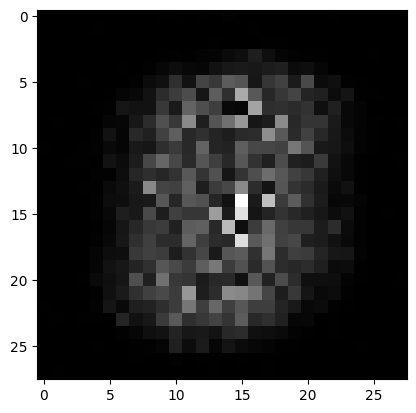

Ploting:  8


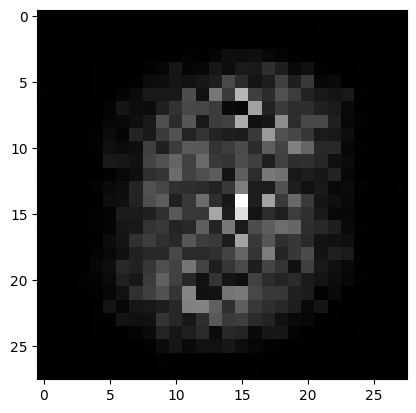

Ploting:  0


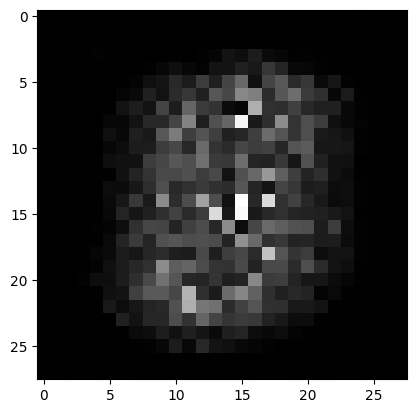

Epoch: 92050
loss_g: 0.9947711825370789 	loss_d: 0.6453763246536255
Epoch: 92100
loss_g: 0.9847241640090942 	loss_d: 0.6725731492042542
Epoch: 92150
loss_g: 1.0065019130706787 	loss_d: 0.6794955134391785
Epoch: 92200
loss_g: 0.9802451729774475 	loss_d: 0.6663233637809753
Epoch: 92250
loss_g: 0.9890598654747009 	loss_d: 0.6570507884025574
Epoch: 92300
loss_g: 0.9733148217201233 	loss_d: 0.6538257598876953
Epoch: 92350
loss_g: 0.9801185131072998 	loss_d: 0.6671047806739807
Epoch: 92400
loss_g: 0.9844415187835693 	loss_d: 0.6913851499557495
Epoch: 92450
loss_g: 0.9800322651863098 	loss_d: 0.7144631743431091
Epoch: 92500
loss_g: 0.9884472489356995 	loss_d: 0.6689271926879883
Ploting:  6


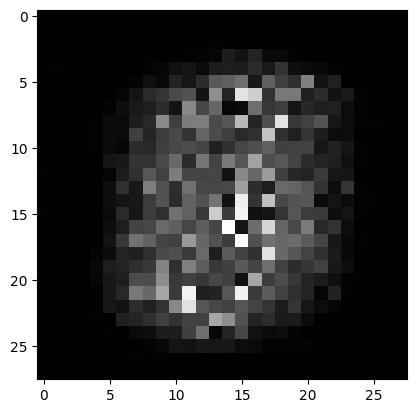

Ploting:  5


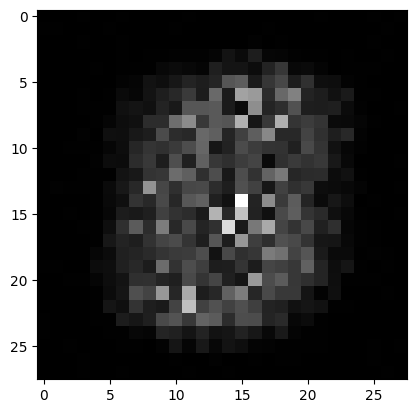

Ploting:  4


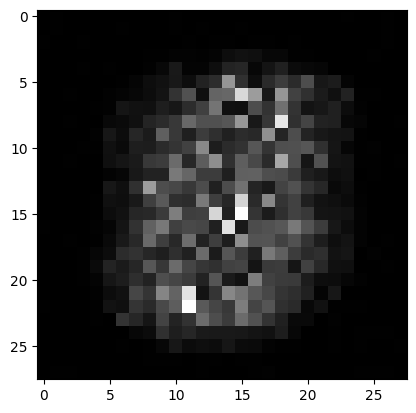

Epoch: 92550
loss_g: 0.9911284446716309 	loss_d: 0.647772490978241
Epoch: 92600
loss_g: 0.9705337285995483 	loss_d: 0.7259407043457031
Epoch: 92650
loss_g: 0.9987397789955139 	loss_d: 0.6836698651313782
Epoch: 92700
loss_g: 0.9857699275016785 	loss_d: 0.7158321738243103
Epoch: 92750
loss_g: 0.9760028123855591 	loss_d: 0.6726955771446228
Epoch: 92800
loss_g: 0.9723892211914062 	loss_d: 0.6752150654792786
Epoch: 92850
loss_g: 0.9640020728111267 	loss_d: 0.6502397656440735
Epoch: 92900
loss_g: 0.9738534092903137 	loss_d: 0.6623605489730835
Epoch: 92950
loss_g: 0.9741941094398499 	loss_d: 0.7454806566238403
Epoch: 93000
loss_g: 0.9713053107261658 	loss_d: 0.702312171459198
Ploting:  2


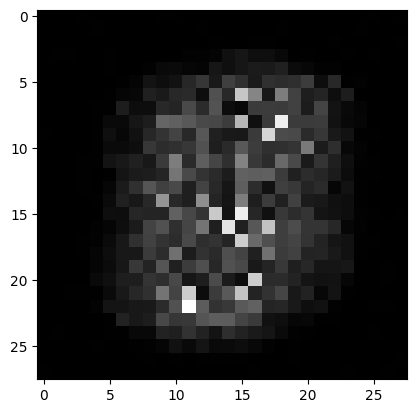

Ploting:  5


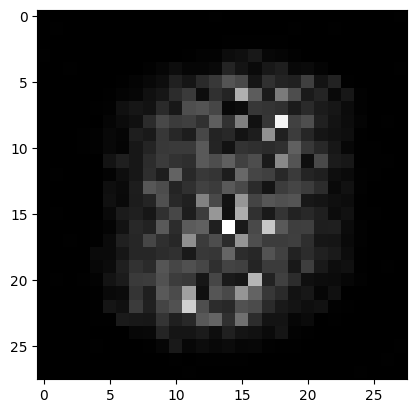

Ploting:  6


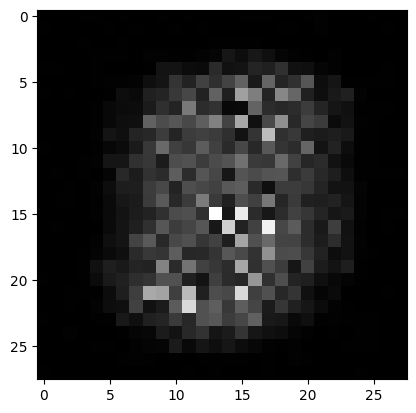

Epoch: 93050
loss_g: 0.9512041211128235 	loss_d: 0.7179632186889648
Epoch: 93100
loss_g: 0.9542582631111145 	loss_d: 0.6910534501075745
Epoch: 93150
loss_g: 0.9564773440361023 	loss_d: 0.706202507019043
Epoch: 93200
loss_g: 0.9646984934806824 	loss_d: 0.7401843070983887
Epoch: 93250
loss_g: 0.9467111825942993 	loss_d: 0.6710044741630554
Epoch: 93300
loss_g: 0.9412736296653748 	loss_d: 0.7049274444580078
Epoch: 93350
loss_g: 0.9344999194145203 	loss_d: 0.6950286030769348
Epoch: 93400
loss_g: 0.9368629455566406 	loss_d: 0.7153310775756836
Epoch: 93450
loss_g: 0.9488811492919922 	loss_d: 0.7045419812202454
Epoch: 93500
loss_g: 0.9322769045829773 	loss_d: 0.6709432005882263
Ploting:  2


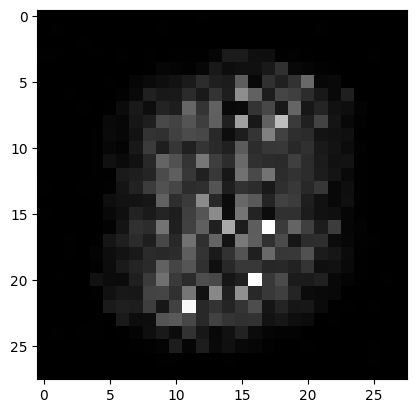

Ploting:  1


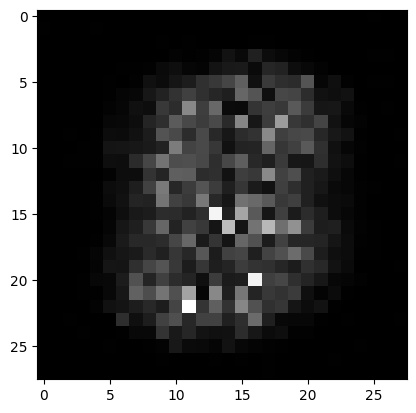

Ploting:  5


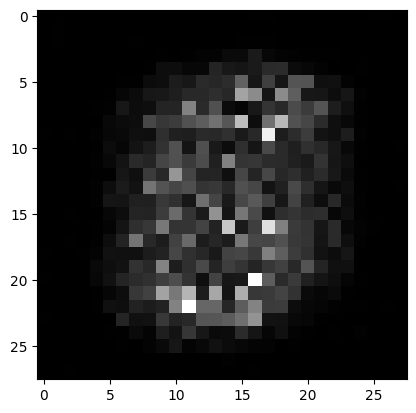

Epoch: 93550
loss_g: 0.9003182649612427 	loss_d: 0.7593792676925659
Epoch: 93600
loss_g: 0.919715940952301 	loss_d: 0.702871561050415
Epoch: 93650
loss_g: 0.9266218543052673 	loss_d: 0.7645607590675354
Epoch: 93700
loss_g: 0.90208500623703 	loss_d: 0.7522587180137634
Epoch: 93750
loss_g: 0.9208971858024597 	loss_d: 0.7357571721076965
Epoch: 93800
loss_g: 0.901628851890564 	loss_d: 0.786162257194519
Epoch: 93850
loss_g: 0.8781198859214783 	loss_d: 0.7326344847679138
Epoch: 93900
loss_g: 0.8895191550254822 	loss_d: 0.7426659464836121
Epoch: 93950
loss_g: 0.8532227277755737 	loss_d: 0.7501116991043091
Epoch: 94000
loss_g: 0.8885523676872253 	loss_d: 0.7446047067642212
Ploting:  0


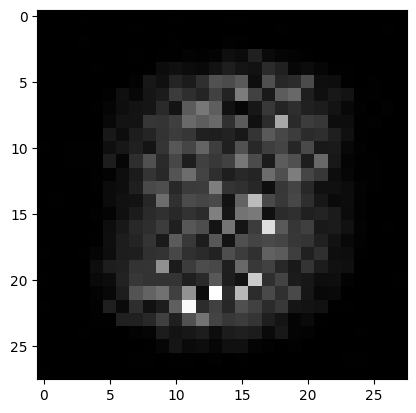

Ploting:  3


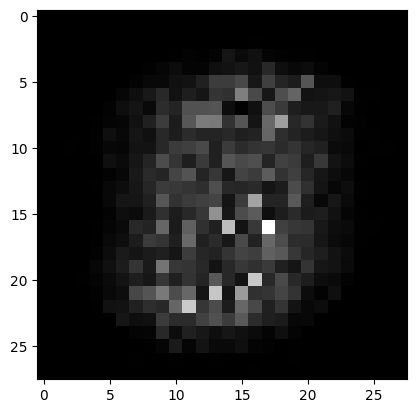

Ploting:  7


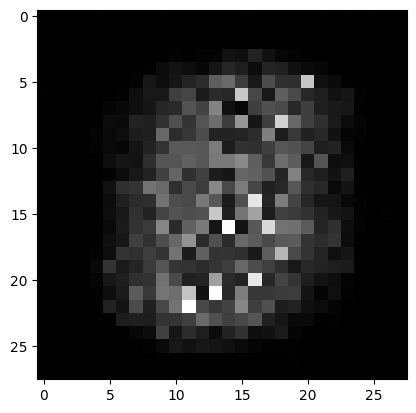

Epoch: 94050
loss_g: 0.8734734058380127 	loss_d: 0.7258826494216919
Epoch: 94100
loss_g: 0.8681361079216003 	loss_d: 0.7758901119232178
Epoch: 94150
loss_g: 0.8588211536407471 	loss_d: 0.8028245568275452
Epoch: 94200
loss_g: 0.8618972301483154 	loss_d: 0.8129962086677551
Epoch: 94250
loss_g: 0.8902237415313721 	loss_d: 0.7720711827278137
Epoch: 94300
loss_g: 0.8752313852310181 	loss_d: 0.7850350141525269
Epoch: 94350
loss_g: 0.8817448019981384 	loss_d: 0.7779570817947388
Epoch: 94400
loss_g: 0.8672317266464233 	loss_d: 0.8073515295982361
Epoch: 94450
loss_g: 0.8832415342330933 	loss_d: 0.7732105255126953
Epoch: 94500
loss_g: 0.8893823027610779 	loss_d: 0.7670692205429077
Ploting:  3


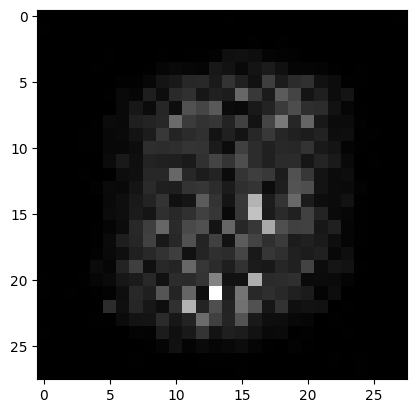

Ploting:  6


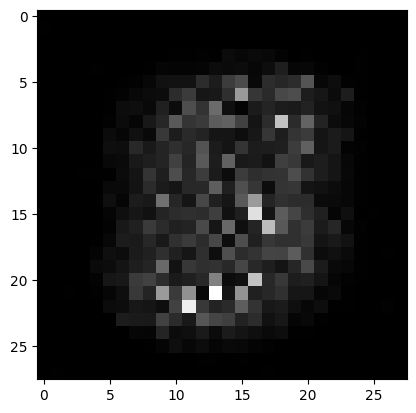

Ploting:  7


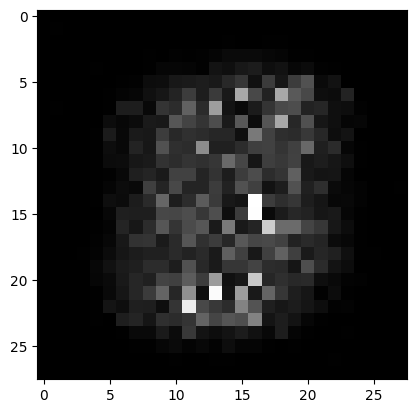

Epoch: 94550
loss_g: 0.8913348317146301 	loss_d: 0.7661244869232178
Epoch: 94600
loss_g: 0.9100609421730042 	loss_d: 0.7176573276519775
Epoch: 94650
loss_g: 0.9127969145774841 	loss_d: 0.705826997756958
Epoch: 94700
loss_g: 0.9247429966926575 	loss_d: 0.6958369016647339
Epoch: 94750
loss_g: 0.918444812297821 	loss_d: 0.7112988233566284
Epoch: 94800
loss_g: 0.9321452379226685 	loss_d: 0.7035935521125793
Epoch: 94850
loss_g: 0.957346498966217 	loss_d: 0.7228544354438782
Epoch: 94900
loss_g: 0.9517967104911804 	loss_d: 0.6661533713340759
Epoch: 94950
loss_g: 0.963481605052948 	loss_d: 0.6523841023445129
Epoch: 95000
loss_g: 0.9911873936653137 	loss_d: 0.6909210085868835
Ploting:  1


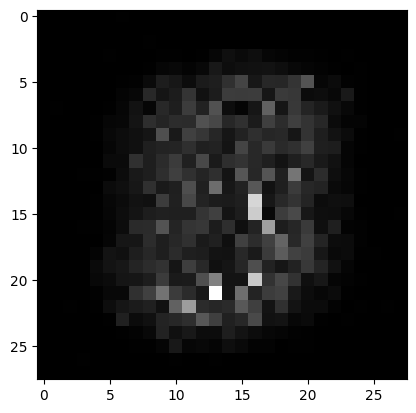

Ploting:  6


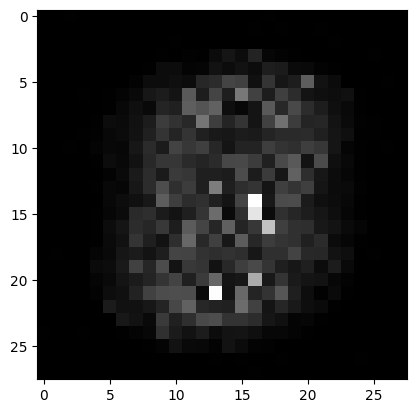

Ploting:  7


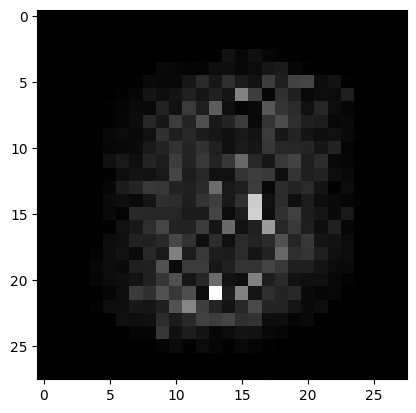

Epoch: 95050
loss_g: 0.9888370037078857 	loss_d: 0.6605233550071716
Epoch: 95100
loss_g: 0.9953689575195312 	loss_d: 0.6895030736923218
Epoch: 95150
loss_g: 1.000179409980774 	loss_d: 0.6345951557159424
Epoch: 95200
loss_g: 1.0110015869140625 	loss_d: 0.636758029460907
Epoch: 95250
loss_g: 1.0369622707366943 	loss_d: 0.6003754138946533
Epoch: 95300
loss_g: 1.046208381652832 	loss_d: 0.6185256838798523
Epoch: 95350
loss_g: 1.053780436515808 	loss_d: 0.6646276712417603
Epoch: 95400
loss_g: 1.0558085441589355 	loss_d: 0.6154756546020508
Epoch: 95450
loss_g: 1.0707528591156006 	loss_d: 0.6167901158332825
Epoch: 95500
loss_g: 1.061869740486145 	loss_d: 0.5976320505142212
Ploting:  5


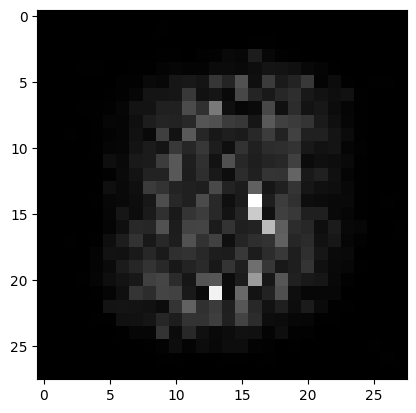

Ploting:  0


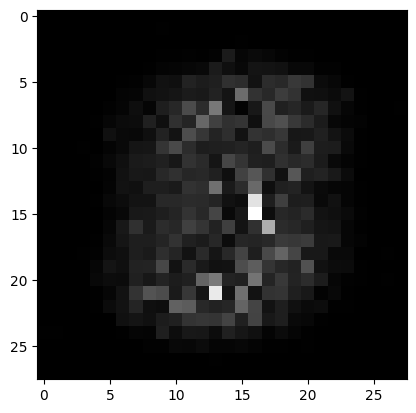

Ploting:  8


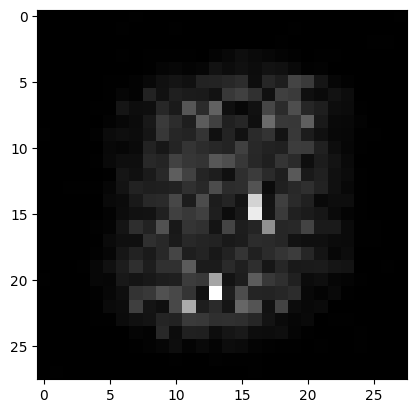

Epoch: 95550
loss_g: 1.077354073524475 	loss_d: 0.5820800065994263
Epoch: 95600
loss_g: 1.0985195636749268 	loss_d: 0.5937471389770508
Epoch: 95650
loss_g: 1.1040513515472412 	loss_d: 0.5593302845954895
Epoch: 95700
loss_g: 1.105164647102356 	loss_d: 0.5502497553825378
Epoch: 95750
loss_g: 1.1192872524261475 	loss_d: 0.5574125647544861
Epoch: 95800
loss_g: 1.1247355937957764 	loss_d: 0.553636372089386
Epoch: 95850
loss_g: 1.1395734548568726 	loss_d: 0.543258786201477
Epoch: 95900
loss_g: 1.1534799337387085 	loss_d: 0.520892858505249
Epoch: 95950
loss_g: 1.1383121013641357 	loss_d: 0.5470271110534668
Epoch: 96000
loss_g: 1.1669689416885376 	loss_d: 0.5097838044166565
Ploting:  0


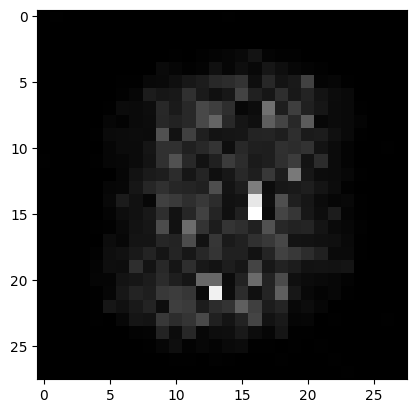

Ploting:  9


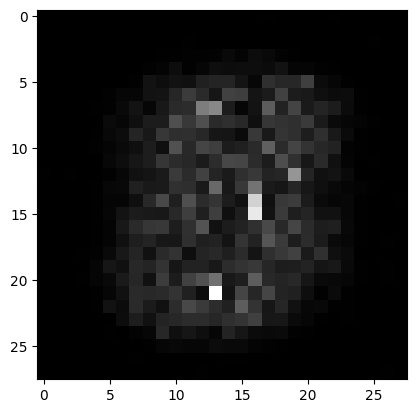

Ploting:  9


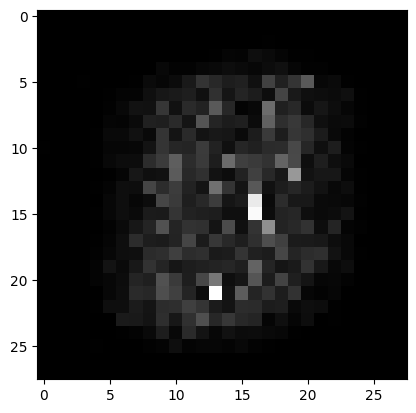

Epoch: 96050
loss_g: 1.1862622499465942 	loss_d: 0.5476825833320618
Epoch: 96100
loss_g: 1.1907906532287598 	loss_d: 0.5158722400665283
Epoch: 96150
loss_g: 1.1949876546859741 	loss_d: 0.491284042596817
Epoch: 96200
loss_g: 1.1977702379226685 	loss_d: 0.49706214666366577
Epoch: 96250
loss_g: 1.2236309051513672 	loss_d: 0.4922298192977905
Epoch: 96300
loss_g: 1.2186601161956787 	loss_d: 0.46141135692596436
Epoch: 96350
loss_g: 1.2477318048477173 	loss_d: 0.4728519320487976
Epoch: 96400
loss_g: 1.2353148460388184 	loss_d: 0.4595571756362915
Epoch: 96450
loss_g: 1.2434189319610596 	loss_d: 0.46293753385543823
Epoch: 96500
loss_g: 1.244842290878296 	loss_d: 0.4869057238101959
Ploting:  9


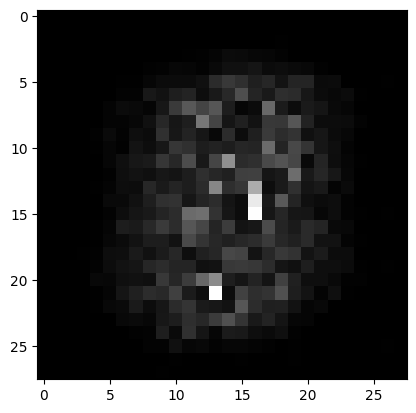

Ploting:  6


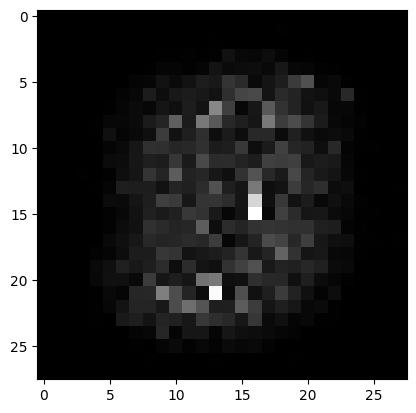

Ploting:  5


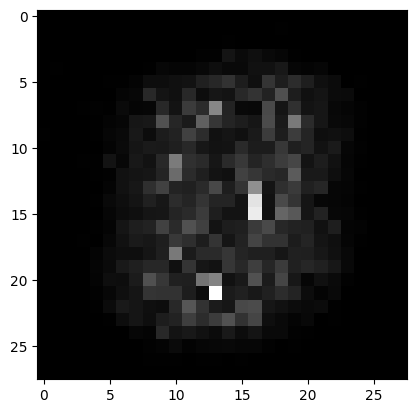

Epoch: 96550
loss_g: 1.2666429281234741 	loss_d: 0.4726843237876892
Epoch: 96600
loss_g: 1.2613544464111328 	loss_d: 0.4710317552089691
Epoch: 96650
loss_g: 1.2775737047195435 	loss_d: 0.44121816754341125
Epoch: 96700
loss_g: 1.299431562423706 	loss_d: 0.4497806429862976
Epoch: 96750
loss_g: 1.296634316444397 	loss_d: 0.446699857711792
Epoch: 96800
loss_g: 1.2880135774612427 	loss_d: 0.4644913375377655
Epoch: 96850
loss_g: 1.3083142042160034 	loss_d: 0.4548742175102234
Epoch: 96900
loss_g: 1.319143295288086 	loss_d: 0.4502818286418915
Epoch: 96950
loss_g: 1.313561201095581 	loss_d: 0.4560190439224243
Epoch: 97000
loss_g: 1.3212201595306396 	loss_d: 0.43000733852386475
Ploting:  9


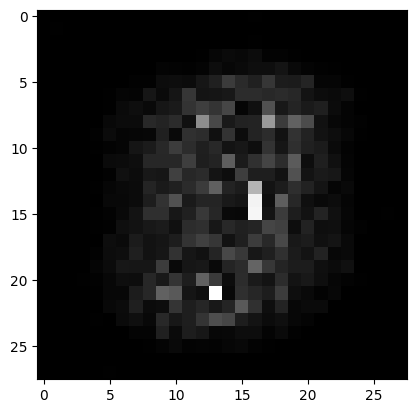

Ploting:  9


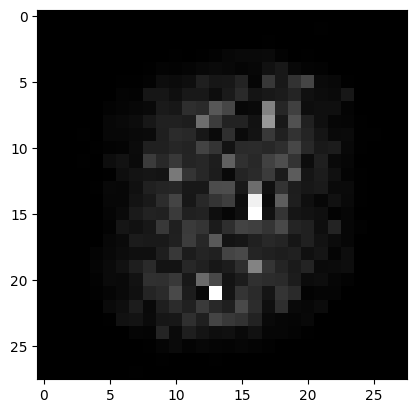

Ploting:  7


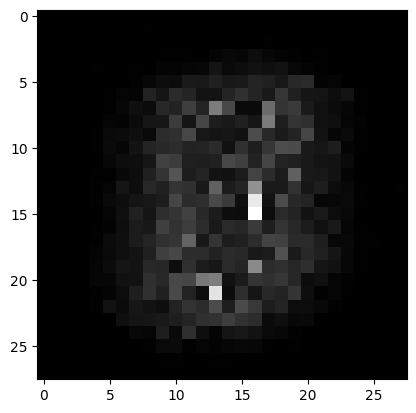

Epoch: 97050
loss_g: 1.3377916812896729 	loss_d: 0.41719526052474976
Epoch: 97100
loss_g: 1.3421690464019775 	loss_d: 0.4019608199596405
Epoch: 97150
loss_g: 1.331808090209961 	loss_d: 0.42414382100105286
Epoch: 97200
loss_g: 1.333771824836731 	loss_d: 0.41332218050956726
Epoch: 97250
loss_g: 1.3532726764678955 	loss_d: 0.42971011996269226
Epoch: 97300
loss_g: 1.3521403074264526 	loss_d: 0.4211658239364624
Epoch: 97350
loss_g: 1.3571205139160156 	loss_d: 0.40276816487312317
Epoch: 97400
loss_g: 1.357435703277588 	loss_d: 0.41875287890434265
Epoch: 97450
loss_g: 1.3601996898651123 	loss_d: 0.41044294834136963
Epoch: 97500
loss_g: 1.3779958486557007 	loss_d: 0.42758673429489136
Ploting:  4


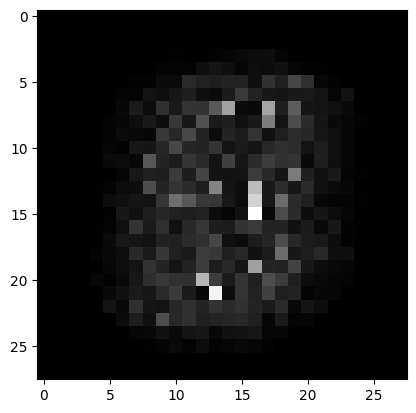

Ploting:  8


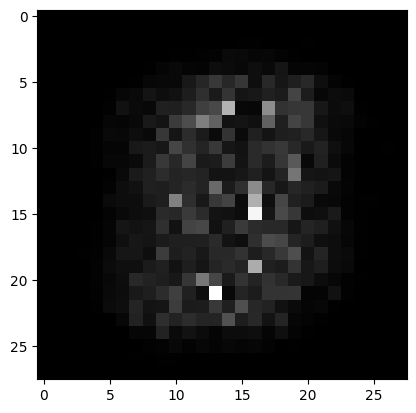

Ploting:  7


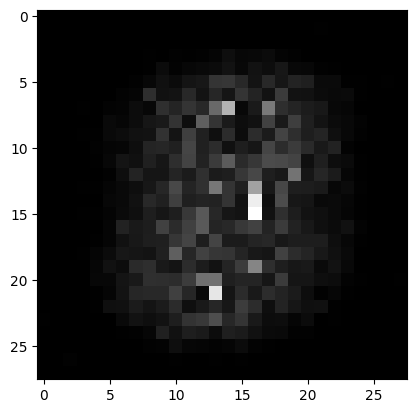

Epoch: 97550
loss_g: 1.3726146221160889 	loss_d: 0.40986624360084534
Epoch: 97600
loss_g: 1.380879521369934 	loss_d: 0.4154452085494995
Epoch: 97650
loss_g: 1.4045709371566772 	loss_d: 0.3900054097175598
Epoch: 97700
loss_g: 1.39138662815094 	loss_d: 0.407107949256897
Epoch: 97750
loss_g: 1.418731689453125 	loss_d: 0.42123159766197205
Epoch: 97800
loss_g: 1.3989760875701904 	loss_d: 0.41159480810165405
Epoch: 97850
loss_g: 1.4160479307174683 	loss_d: 0.4163965582847595
Epoch: 97900
loss_g: 1.3967688083648682 	loss_d: 0.39691978693008423
Epoch: 97950
loss_g: 1.4108386039733887 	loss_d: 0.3847994804382324
Epoch: 98000
loss_g: 1.4218025207519531 	loss_d: 0.40104517340660095
Ploting:  4


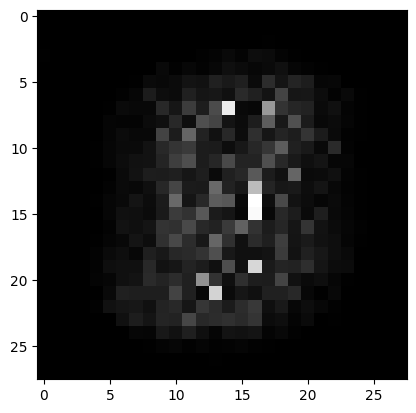

Ploting:  7


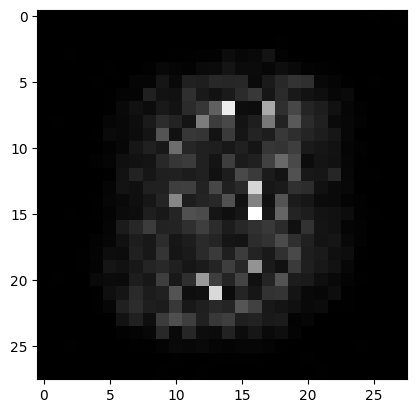

Ploting:  2


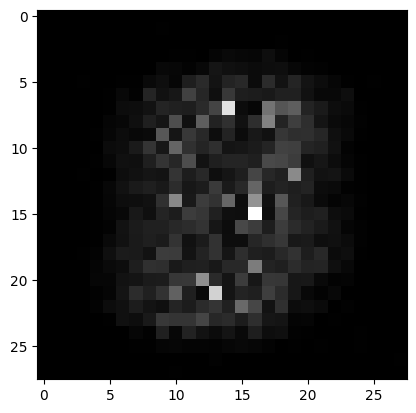

Epoch: 98050
loss_g: 1.436083197593689 	loss_d: 0.3648267984390259
Epoch: 98100
loss_g: 1.4226059913635254 	loss_d: 0.3834661841392517
Epoch: 98150
loss_g: 1.4278439283370972 	loss_d: 0.39085981249809265
Epoch: 98200
loss_g: 1.438108205795288 	loss_d: 0.38357940316200256
Epoch: 98250
loss_g: 1.42889404296875 	loss_d: 0.39589881896972656
Epoch: 98300
loss_g: 1.4378492832183838 	loss_d: 0.383710652589798
Epoch: 98350
loss_g: 1.4349459409713745 	loss_d: 0.38907375931739807
Epoch: 98400
loss_g: 1.4229857921600342 	loss_d: 0.38286688923835754
Epoch: 98450
loss_g: 1.4337893724441528 	loss_d: 0.41065001487731934
Epoch: 98500
loss_g: 1.416211485862732 	loss_d: 0.3909364938735962
Ploting:  7


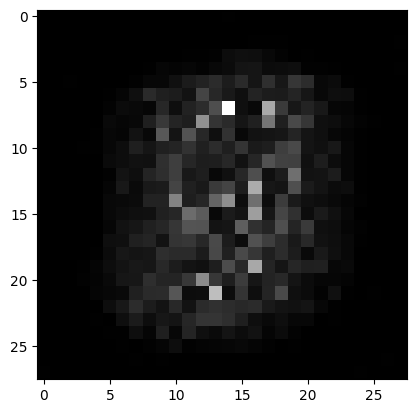

Ploting:  8


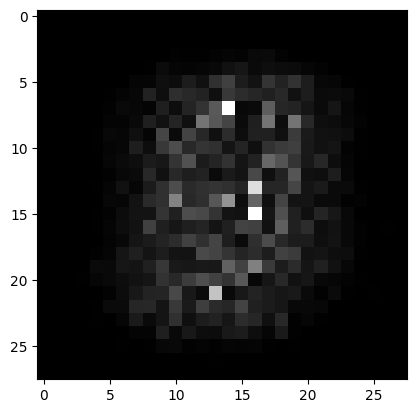

Ploting:  7


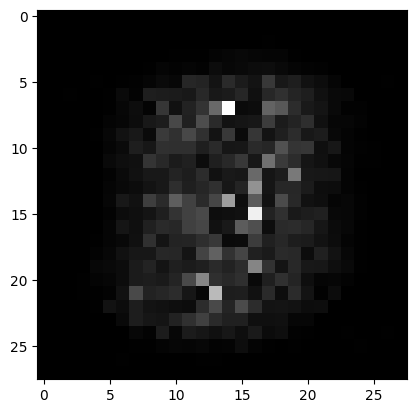

Epoch: 98550
loss_g: 1.3983652591705322 	loss_d: 0.37696123123168945
Epoch: 98600
loss_g: 1.4177907705307007 	loss_d: 0.38880813121795654
Epoch: 98650
loss_g: 1.422842025756836 	loss_d: 0.39684370160102844
Epoch: 98700
loss_g: 1.43404221534729 	loss_d: 0.3707304000854492
Epoch: 98750
loss_g: 1.395760416984558 	loss_d: 0.39274367690086365
Epoch: 98800
loss_g: 1.4012078046798706 	loss_d: 0.37987199425697327
Epoch: 98850
loss_g: 1.398822546005249 	loss_d: 0.40573665499687195
Epoch: 98900
loss_g: 1.4125804901123047 	loss_d: 0.4325723946094513
Epoch: 98950
loss_g: 1.3683634996414185 	loss_d: 0.41213729977607727
Epoch: 99000
loss_g: 1.3782200813293457 	loss_d: 0.4116630554199219
Ploting:  2


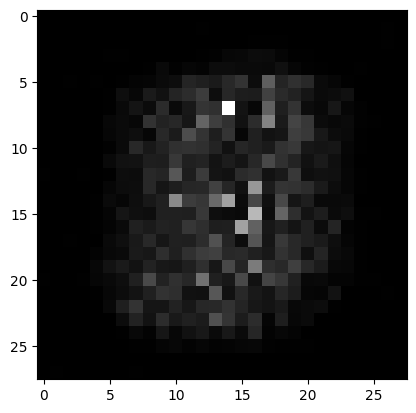

Ploting:  2


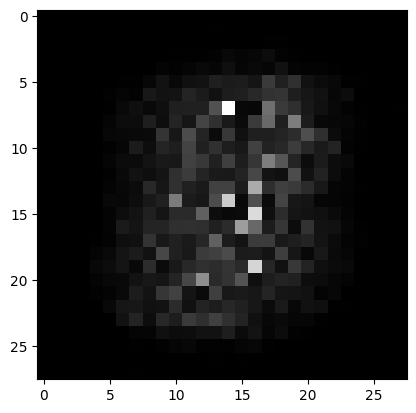

Ploting:  7


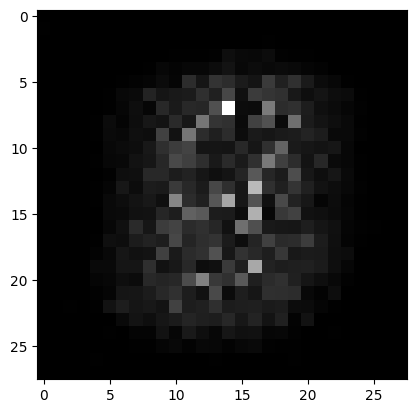

Epoch: 99050
loss_g: 1.4080628156661987 	loss_d: 0.39888763427734375
Epoch: 99100
loss_g: 1.376104712486267 	loss_d: 0.40667569637298584
Epoch: 99150
loss_g: 1.3535188436508179 	loss_d: 0.4201434850692749
Epoch: 99200
loss_g: 1.4022948741912842 	loss_d: 0.42518290877342224
Epoch: 99250
loss_g: 1.4003678560256958 	loss_d: 0.42504507303237915
Epoch: 99300
loss_g: 1.3788471221923828 	loss_d: 0.4246754050254822
Epoch: 99350
loss_g: 1.3630383014678955 	loss_d: 0.4357314109802246
Epoch: 99400
loss_g: 1.37821364402771 	loss_d: 0.409168004989624
Epoch: 99450
loss_g: 1.3806089162826538 	loss_d: 0.40662702918052673
Epoch: 99500
loss_g: 1.3801555633544922 	loss_d: 0.4029441475868225
Ploting:  9


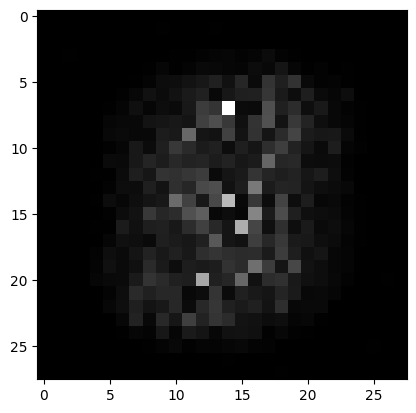

Ploting:  4


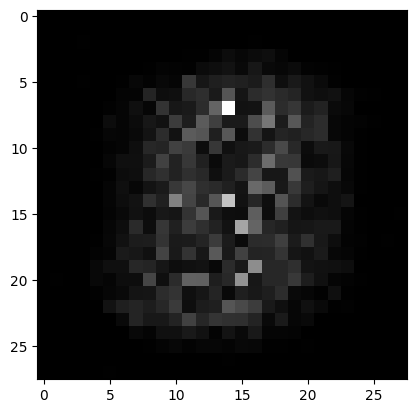

Ploting:  5


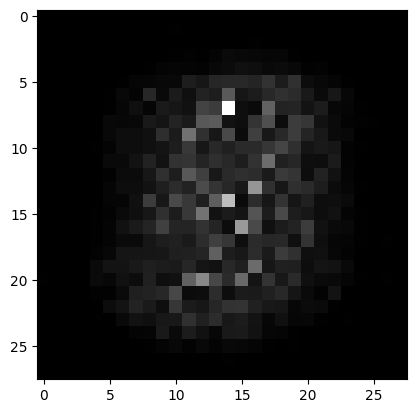

Epoch: 99550
loss_g: 1.3722529411315918 	loss_d: 0.3980199694633484
Epoch: 99600
loss_g: 1.3714715242385864 	loss_d: 0.39259928464889526
Epoch: 99650
loss_g: 1.3780598640441895 	loss_d: 0.41234391927719116
Epoch: 99700
loss_g: 1.4159983396530151 	loss_d: 0.41337209939956665
Epoch: 99750
loss_g: 1.3976925611495972 	loss_d: 0.3923763930797577
Epoch: 99800
loss_g: 1.3953285217285156 	loss_d: 0.40956148505210876
Epoch: 99850
loss_g: 1.418332815170288 	loss_d: 0.3849276006221771
Epoch: 99900
loss_g: 1.402945876121521 	loss_d: 0.41311705112457275
Epoch: 99950
loss_g: 1.4262466430664062 	loss_d: 0.3884972631931305


In [6]:
lr = 0.0002
k = 1
epochs = 100000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.SGD(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.SGD(disciminator.parameters(), lr=lr)

criterion_gen = Generator_loss()
criterion_dis = Discriminator_loss()


train_models(disciminator, criterion_dis, optimizer_dis, generator, criterion_gen, optimizer_gen, epochs, train_loader, k, batch_size)